In [1]:
!pip install catboost

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMRegressor, LGBMClassifier
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import os
from imblearn.over_sampling import SMOTE
import math
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as sk
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

import numpy as np
%matplotlib inline

In [3]:
df=pd.read_csv("../../Integrated_data/merged_df_reward.csv",encoding="cp949")

In [4]:
import pandas as pd

class DataProcessor:
    def __init__(self, df):
        self.df = df
        self.interpolated()
        self.abmormaled()
        self.result=self.fill_missing_values()

    # ... (다른 클래스 함수 정의는 여기에 있어야 합니다)

    def interpolated(self):
        temp=[]
        temp2=[]
        for i in df['ID'].unique():
            try:
                temp.append(df[df['ID']==i].interpolate())
            except:
                temp.append(df[df['ID']==i])

        new_df=pd.concat(temp,axis=0)
        new_df.fillna(method='bfill',inplace=True)   
        for i in new_df['ID'].unique():
            temp_df=new_df[new_df['ID']==i].reset_index(drop=True)
            temp_df["height"].fillna(method='bfill',inplace=True)
            temp_df["weight"].fillna(method='bfill',inplace=True)
            temp_df["height"].fillna(method='ffill',inplace=True)
            temp_df["weight"].fillna(method='ffill',inplace=True)
            temp2.append(temp_df)
        new_df=pd.concat(temp2,axis=0)  
        self.df = new_df   
    def gap(self,first, last):
        gap_per=(last-first)/first*100
        return abs(gap_per)
        
    def abmormaled(self):
        temp = []
        for i in self.df['ID'].unique():
            temp_df = self.df[self.df['ID'] == i].reset_index(drop=True)
            for i in range(1, len(temp_df)):
                if temp_df.at[i, 'height'] <= temp_df.at[i - 1, 'height']:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
                if self.gap(temp_df.at[i - 1, 'height'], temp_df.at[i, 'height']) >= 16:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
            temp.append(temp_df)
        new_df2 = pd.concat(temp, axis=0)
        new_df2.reset_index(drop=True, inplace=True)
        self.df = new_df2

    def fill_missing_values(self):
        self.df["step_count"].fillna(self.df["step_count"].median(), inplace=True)
        self.df["burned calory"].fillna(self.df["burned calory"].median(), inplace=True)
        self.df["eat_calory"].fillna(self.df["eat_calory"].median(), inplace=True)
        self.df["Sleep_time"].fillna(self.df["Sleep_time"].median(), inplace=True)
        return self.df
    



In [5]:
import pandas as pd

class TimeSeriesLabeler:
    def __init__(self, term):
        self.term = term
        self.result_df = pd.DataFrame()
        self.labels = []

    def calculate_labels(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            label = []

            for i in range(self.term, len(df_id)):
                previous_days = df_id['weight'].iloc[i - self.term:i]
                current_weight = df_id['weight'].iloc[i]
                if current_weight > previous_days.mean().round(3):
                    label.append(1)
                elif current_weight == previous_days.mean().round(3):
                    label.append(0)
                elif current_weight < previous_days.mean().round(3):
                    label.append(2)
                else:
                    print("error")

            self.labels.extend(label)

    def create_result_df(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            df_id_drop = df_id.drop(index=range(self.term))
            self.result_df = pd.concat([self.result_df, df_id_drop])
        self.result_df['labels']= self.labels
        
    def get_labels(self):
        return self.labels

    def get_result_df(self):
        return self.result_df



In [6]:
for i in range(3):
    globals()['reward_data_{}'.format(i+1)]=pd.read_excel("../../Integrated_data/merged_df_reward_분리.xlsx",sheet_name = i)
    

In [7]:
# 데이터프레임 리스트 생성
dataframes = [reward_data_1, reward_data_2, reward_data_3]

# 반복문으로 데이터프레임 순차적으로 호출
for i, df in enumerate(dataframes, start=0):
    print(f"Processing reward_data_{i+1}")
    processor = DataProcessor(df)
    globals()['df_{}'.format(i+1)]=processor.result


Processing reward_data_1
Processing reward_data_2
Processing reward_data_3


In [10]:
reward_data_2[reward_data_2['ID']=='#KDBKVW']

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부


# ID 별로 일주일 간격으로 몸무게 변화 라벨링(유지:0, 감소:2, 증가:1)

In [9]:
term = 5  # You can set your desired 'term' here

In [10]:
labeler_1 = TimeSeriesLabeler(term)
labeler_1.calculate_labels(df_1)  # Provide your DataFrame 'df' as input
labeler_1.create_result_df(df_1)  # Create the result DataFrame
labels = labeler_1.get_labels()
result_df_1 = labeler_1.get_result_df()

In [11]:
labeler_2 = TimeSeriesLabeler(term)
labeler_2.calculate_labels(df_2)  # Provide your DataFrame 'df' as input
labeler_2.create_result_df(df_2)  # Create the result DataFrame
labels = labeler_2.get_labels()
result_df_2 = labeler_2.get_result_df()

In [12]:
labeler_3 = TimeSeriesLabeler(term)
labeler_3.calculate_labels(df_3)  # Provide your DataFrame 'df' as input
labeler_3.create_result_df(df_3)  # Create the result DataFrame
labels = labeler_3.get_labels()
result_df_3 = labeler_3.get_result_df()

In [13]:
result_df_3.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부,labels
5,#ASELLU,2022-07-19,2,6,164.0,64.0,5490.0,142.8,546.0,432.0,3,2
6,#ASELLU,2022-07-20,2,6,164.0,64.0,4100.0,142.8,546.0,432.0,3,1
7,#ASELLU,2022-07-21,2,6,164.0,64.0,4919.0,142.8,546.0,432.0,3,2
8,#ASELLU,2022-07-22,2,6,164.0,64.0,323.0,142.8,546.0,432.0,3,2
9,#ASELLU,2022-07-23,2,6,164.0,64.0,323.0,142.8,546.0,432.0,3,2


# 데이터 세트 로드

In [14]:
result_df_2.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부,labels
5,#AAGQKY,2022-07-19,2,4,148.0,45.15,72.0,48.552,2000.0,468.0,2,0
6,#AAGQKY,2022-07-20,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
7,#AAGQKY,2022-07-21,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
8,#AAGQKY,2022-07-22,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
9,#AAGQKY,2022-07-23,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2


In [15]:
X_1=result_df_1.iloc[:,[4,5,6,7,8,9]]
y_1=result_df_1.iloc[:,-1]

X_2=result_df_2.iloc[:,[4,5,6,7,8,9]]
y_2=result_df_2.iloc[:,-1]

X_3=result_df_3.iloc[:,[4,5,6,7,8,9]]
y_3=result_df_3.iloc[:,-1]

In [16]:
y_1

5      2
6      2
7      2
8      0
9      0
      ..
177    0
178    0
179    0
180    0
181    0
Name: labels, Length: 37347, dtype: int64

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
scaler_3 = StandardScaler()

X_scaler_1=scaler_1.fit_transform(X_1)
X_scaler_2= scaler_2.fit_transform(X_2)
X_scaler_3= scaler_3.fit_transform(X_3)


smote_1 = SMOTE(random_state=0)
X_over_1,y_over_1 = smote_1.fit_resample(X_scaler_1,y_1)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_1.shape, y_1.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_1.shape, y_over_1.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_1).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_1).value_counts())

smote_2 = SMOTE(random_state=0)
X_over_2,y_over_2 = smote_2.fit_resample(X_scaler_2,y_2)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_2.shape, y_2.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_2.shape, y_over_2.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_2).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_2).value_counts())

smote_3 = SMOTE(random_state=0)
X_over_3,y_over_3 = smote_3.fit_resample(X_scaler_3,y_3)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_3.shape, y_3.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_3.shape, y_over_3.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_3).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_3).value_counts())






SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (37347, 6) (37347,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (100797, 6) (100797,)
SMOTE 적용 전 레이블 값 분포: 
 0    33599
1     2318
2     1430
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 2    33599
0    33599
1    33599
Name: labels, dtype: int64
SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (13983, 6) (13983,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (37818, 6) (37818,)
SMOTE 적용 전 레이블 값 분포: 
 0    12606
1      752
2      625
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    12606
2    12606
1    12606
Name: labels, dtype: int64
SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (4602, 6) (4602,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (10857, 6) (10857,)
SMOTE 적용 전 레이블 값 분포: 
 0    3619
1     534
2     449
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 2    3619
1    3619
0    3619
Name: labels, dtype: int64


# 데이터 스케일링

## Train, Test dataset 나누기

In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_over_1, y_over_1, test_size=0.20)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_over_2, y_over_2, test_size=0.20)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_over_3, y_over_3, test_size=0.20)

## Global train 데이터 세트 만들기

In [19]:
X_train = np.concatenate((X_train_1,X_train_2,X_train_3), axis=0)
y_train = np.concatenate((y_train_1,y_train_2,y_train_3), axis=0)

In [20]:
X_test = np.concatenate((X_test_1,X_test_2,X_test_3), axis=0)
y_test = np.concatenate((y_test_1,y_test_2,y_test_3), axis=0)

In [21]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
train_dataset=TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)

## Client train 데이터 세트 만들기

In [22]:
X_train_1 = torch.FloatTensor(X_train_1)
X_test_1 = torch.FloatTensor(X_test_1)
y_train_1 = torch.LongTensor(y_train_1.to_numpy())
y_test_1 = torch.LongTensor(y_test_1.to_numpy())

train_dataset_1=TensorDataset(X_train_1, y_train_1)
test_dataset_1=TensorDataset(X_test_1, y_test_1)

In [23]:
X_train_2 = torch.FloatTensor(X_train_2)
X_test_2 = torch.FloatTensor(X_test_2)
y_train_2 = torch.LongTensor(y_train_2.to_numpy())
y_test_2 = torch.LongTensor(y_test_2.to_numpy())

train_dataset_2=TensorDataset(X_train_2, y_train_2)
test_dataset_2=TensorDataset(X_test_2, y_test_2)

In [24]:
X_train_3 = torch.FloatTensor(X_train_3)
X_test_3 = torch.FloatTensor(X_test_3)
y_train_3 = torch.LongTensor(y_train_3.to_numpy())
y_test_3 = torch.LongTensor(y_test_3.to_numpy())

train_dataset_3=TensorDataset(X_train_3, y_train_3)
test_dataset_3=TensorDataset(X_test_3, y_test_3)

In [25]:
# from sklearn.model_selection import StratifiedKFold
# skf=StratifiedKFold(n_splits=10)
# skf.get_n_splits(X_train_1,y_train_1)

In [26]:
X_train_over=X_over_1
y_train_over=y_over_1

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.87it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.11149. Saving Model!
epoch 01, loss: 1.21747, acc: 0.22669, val_loss: 1.11149, val_accuracy: 0.33333


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.88it/s]


[INFO] val_acc has been improved from 1.11149 to 1.10114. Saving Model!
epoch 02, loss: 1.09204, acc: 0.33333, val_loss: 1.10114, val_accuracy: 0.33333


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.05it/s]


[INFO] val_acc has been improved from 1.10114 to 1.09865. Saving Model!
epoch 03, loss: 1.09589, acc: 0.33333, val_loss: 1.09865, val_accuracy: 0.33333


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


[INFO] val_acc has been improved from 1.09865 to 1.09733. Saving Model!
epoch 04, loss: 1.09704, acc: 0.33333, val_loss: 1.09733, val_accuracy: 0.33542


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.37it/s]


[INFO] val_acc has been improved from 1.09733 to 1.09631. Saving Model!
epoch 05, loss: 1.09690, acc: 0.33117, val_loss: 1.09631, val_accuracy: 0.33730


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


[INFO] val_acc has been improved from 1.09631 to 1.09513. Saving Model!
epoch 06, loss: 1.09612, acc: 0.31950, val_loss: 1.09513, val_accuracy: 0.34296


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


[INFO] val_acc has been improved from 1.09513 to 1.09380. Saving Model!
epoch 07, loss: 1.09521, acc: 0.33007, val_loss: 1.09380, val_accuracy: 0.35317


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.98it/s]


[INFO] val_acc has been improved from 1.09380 to 1.09228. Saving Model!
epoch 08, loss: 1.09424, acc: 0.32962, val_loss: 1.09228, val_accuracy: 0.37569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]


[INFO] val_acc has been improved from 1.09228 to 1.09101. Saving Model!
epoch 09, loss: 1.09336, acc: 0.32910, val_loss: 1.09101, val_accuracy: 0.39970


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.72it/s]


[INFO] val_acc has been improved from 1.09101 to 1.08974. Saving Model!
epoch 10, loss: 1.09242, acc: 0.31236, val_loss: 1.08974, val_accuracy: 0.41746


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


[INFO] val_acc has been improved from 1.08974 to 1.08849. Saving Model!
epoch 11, loss: 1.09154, acc: 0.31791, val_loss: 1.08849, val_accuracy: 0.40099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


[INFO] val_acc has been improved from 1.08849 to 1.08755. Saving Model!
epoch 12, loss: 1.09048, acc: 0.34157, val_loss: 1.08755, val_accuracy: 0.39494


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.04it/s]


[INFO] val_acc has been improved from 1.08755 to 1.08666. Saving Model!
epoch 13, loss: 1.08950, acc: 0.34995, val_loss: 1.08666, val_accuracy: 0.37927


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]


[INFO] val_acc has been improved from 1.08666 to 1.08577. Saving Model!
epoch 14, loss: 1.08820, acc: 0.35837, val_loss: 1.08577, val_accuracy: 0.38105


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


[INFO] val_acc has been improved from 1.08577 to 1.08499. Saving Model!
epoch 15, loss: 1.08765, acc: 0.35030, val_loss: 1.08499, val_accuracy: 0.39206


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


[INFO] val_acc has been improved from 1.08499 to 1.08475. Saving Model!
epoch 16, loss: 1.08522, acc: 0.36342, val_loss: 1.08475, val_accuracy: 0.39464


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


[INFO] val_acc has been improved from 1.08475 to 1.08401. Saving Model!
epoch 17, loss: 1.08488, acc: 0.35915, val_loss: 1.08401, val_accuracy: 0.39484


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


[INFO] val_acc has been improved from 1.08401 to 1.08348. Saving Model!
epoch 18, loss: 1.08233, acc: 0.36527, val_loss: 1.08348, val_accuracy: 0.39544


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


[INFO] val_acc has been improved from 1.08348 to 1.08297. Saving Model!
epoch 19, loss: 1.08127, acc: 0.36217, val_loss: 1.08297, val_accuracy: 0.37192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 20, loss: 1.07856, acc: 0.36678, val_loss: 1.08304, val_accuracy: 0.37609


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


[INFO] val_acc has been improved from 1.08297 to 1.08161. Saving Model!
epoch 21, loss: 1.07764, acc: 0.36559, val_loss: 1.08161, val_accuracy: 0.37520


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


[INFO] val_acc has been improved from 1.08161 to 1.08154. Saving Model!
epoch 22, loss: 1.07490, acc: 0.36624, val_loss: 1.08154, val_accuracy: 0.37629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


[INFO] val_acc has been improved from 1.08154 to 1.08119. Saving Model!
epoch 23, loss: 1.07342, acc: 0.36555, val_loss: 1.08119, val_accuracy: 0.37550


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.88it/s]


epoch 24, loss: 1.07079, acc: 0.37017, val_loss: 1.08172, val_accuracy: 0.37649


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.10it/s]


epoch 25, loss: 1.06933, acc: 0.36860, val_loss: 1.08139, val_accuracy: 0.37738


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.71it/s]


epoch 26, loss: 1.06675, acc: 0.37305, val_loss: 1.08249, val_accuracy: 0.37817


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


[INFO] val_acc has been improved from 1.08119 to 1.08079. Saving Model!
epoch 27, loss: 1.06548, acc: 0.37037, val_loss: 1.08079, val_accuracy: 0.36190


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.98it/s]


epoch 28, loss: 1.06135, acc: 0.37652, val_loss: 1.08276, val_accuracy: 0.36220


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 29, loss: 1.06101, acc: 0.37452, val_loss: 1.08285, val_accuracy: 0.36458


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 30, loss: 1.05683, acc: 0.37742, val_loss: 1.08355, val_accuracy: 0.36429


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


epoch 31, loss: 1.05541, acc: 0.37309, val_loss: 1.08473, val_accuracy: 0.36151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 32, loss: 1.05235, acc: 0.37574, val_loss: 1.08476, val_accuracy: 0.36042


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 33, loss: 1.05022, acc: 0.37365, val_loss: 1.08707, val_accuracy: 0.36200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.53it/s]


epoch 34, loss: 1.04722, acc: 0.37977, val_loss: 1.08746, val_accuracy: 0.38750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 35, loss: 1.04566, acc: 0.38588, val_loss: 1.08851, val_accuracy: 0.38839


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


epoch 36, loss: 1.04323, acc: 0.38995, val_loss: 1.08797, val_accuracy: 0.39167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


epoch 37, loss: 1.04036, acc: 0.40250, val_loss: 1.09217, val_accuracy: 0.39137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


epoch 38, loss: 1.03725, acc: 0.41196, val_loss: 1.09138, val_accuracy: 0.39385


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.46it/s]


epoch 39, loss: 1.03594, acc: 0.41002, val_loss: 1.09416, val_accuracy: 0.39276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 40, loss: 1.03197, acc: 0.41452, val_loss: 1.09446, val_accuracy: 0.39157


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


epoch 41, loss: 1.03074, acc: 0.41265, val_loss: 1.09889, val_accuracy: 0.39504


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


epoch 42, loss: 1.02756, acc: 0.41690, val_loss: 1.09608, val_accuracy: 0.39802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.58it/s]


epoch 43, loss: 1.02585, acc: 0.41720, val_loss: 1.10172, val_accuracy: 0.39673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 44, loss: 1.02253, acc: 0.42166, val_loss: 1.10041, val_accuracy: 0.39692


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 45, loss: 1.02142, acc: 0.42370, val_loss: 1.10367, val_accuracy: 0.40030


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.66it/s]


epoch 46, loss: 1.01735, acc: 0.43296, val_loss: 1.10413, val_accuracy: 0.39891


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


epoch 47, loss: 1.01654, acc: 0.43685, val_loss: 1.10795, val_accuracy: 0.40099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.82it/s]


epoch 48, loss: 1.01305, acc: 0.43635, val_loss: 1.10619, val_accuracy: 0.39940


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.62it/s]


epoch 49, loss: 1.01137, acc: 0.44079, val_loss: 1.11103, val_accuracy: 0.40308


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]


epoch 50, loss: 1.00715, acc: 0.44852, val_loss: 1.10924, val_accuracy: 0.40208


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.87it/s]


epoch 51, loss: 1.00682, acc: 0.44610, val_loss: 1.11515, val_accuracy: 0.40327


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 52, loss: 1.00316, acc: 0.45139, val_loss: 1.11120, val_accuracy: 0.40466


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 53, loss: 1.00181, acc: 0.45394, val_loss: 1.11735, val_accuracy: 0.41071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


epoch 54, loss: 0.99798, acc: 0.46226, val_loss: 1.11679, val_accuracy: 0.40992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.34it/s]


epoch 55, loss: 0.99765, acc: 0.46195, val_loss: 1.11811, val_accuracy: 0.41429


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.47it/s]


epoch 56, loss: 0.99237, acc: 0.46875, val_loss: 1.12110, val_accuracy: 0.41101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.35it/s]


epoch 57, loss: 0.99196, acc: 0.46802, val_loss: 1.12325, val_accuracy: 0.41498


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 58, loss: 0.98703, acc: 0.47592, val_loss: 1.12553, val_accuracy: 0.41280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 59, loss: 0.98713, acc: 0.47551, val_loss: 1.12824, val_accuracy: 0.41508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 60, loss: 0.98242, acc: 0.48004, val_loss: 1.13113, val_accuracy: 0.41409


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 61, loss: 0.98280, acc: 0.47195, val_loss: 1.13786, val_accuracy: 0.41617


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 62, loss: 0.97883, acc: 0.48393, val_loss: 1.13424, val_accuracy: 0.41478


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 63, loss: 0.97795, acc: 0.47718, val_loss: 1.14054, val_accuracy: 0.41567


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 64, loss: 0.97317, acc: 0.48732, val_loss: 1.13803, val_accuracy: 0.41438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 65, loss: 0.97313, acc: 0.47852, val_loss: 1.14369, val_accuracy: 0.41498


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 66, loss: 0.96792, acc: 0.48728, val_loss: 1.14256, val_accuracy: 0.41806


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 67, loss: 0.96789, acc: 0.48217, val_loss: 1.14555, val_accuracy: 0.42480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 68, loss: 0.96468, acc: 0.49061, val_loss: 1.14729, val_accuracy: 0.42758


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 69, loss: 0.96343, acc: 0.48111, val_loss: 1.15193, val_accuracy: 0.42569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 70, loss: 0.96008, acc: 0.49467, val_loss: 1.14851, val_accuracy: 0.42847


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 71, loss: 0.95917, acc: 0.48585, val_loss: 1.15541, val_accuracy: 0.42788


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 72, loss: 0.95720, acc: 0.49669, val_loss: 1.15028, val_accuracy: 0.42956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 73, loss: 0.95583, acc: 0.48640, val_loss: 1.16012, val_accuracy: 0.42669


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 74, loss: 0.95200, acc: 0.49954, val_loss: 1.15218, val_accuracy: 0.42966


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 75, loss: 0.95184, acc: 0.48918, val_loss: 1.16146, val_accuracy: 0.42976


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 76, loss: 0.94860, acc: 0.49811, val_loss: 1.15599, val_accuracy: 0.43085


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 77, loss: 0.94737, acc: 0.49116, val_loss: 1.16370, val_accuracy: 0.43065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 78, loss: 0.94374, acc: 0.50051, val_loss: 1.16371, val_accuracy: 0.43046


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 79, loss: 0.94296, acc: 0.49492, val_loss: 1.16605, val_accuracy: 0.43075


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 80, loss: 0.94019, acc: 0.50178, val_loss: 1.16667, val_accuracy: 0.43065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 81, loss: 0.93952, acc: 0.49509, val_loss: 1.17085, val_accuracy: 0.43512


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 82, loss: 0.93668, acc: 0.50200, val_loss: 1.16498, val_accuracy: 0.43244


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 83, loss: 0.93591, acc: 0.49441, val_loss: 1.17458, val_accuracy: 0.43720


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 84, loss: 0.93398, acc: 0.50508, val_loss: 1.16291, val_accuracy: 0.43224


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 85, loss: 0.93297, acc: 0.49802, val_loss: 1.17402, val_accuracy: 0.44028


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 86, loss: 0.92822, acc: 0.50707, val_loss: 1.16876, val_accuracy: 0.43472


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 87, loss: 0.92931, acc: 0.49747, val_loss: 1.17946, val_accuracy: 0.44107


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 88, loss: 0.92537, acc: 0.51115, val_loss: 1.16933, val_accuracy: 0.43651


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 89, loss: 0.92505, acc: 0.50171, val_loss: 1.17918, val_accuracy: 0.44137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 90, loss: 0.92131, acc: 0.51183, val_loss: 1.17715, val_accuracy: 0.44226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 91, loss: 0.92099, acc: 0.50658, val_loss: 1.18292, val_accuracy: 0.44167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 92, loss: 0.91807, acc: 0.51499, val_loss: 1.17869, val_accuracy: 0.44266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 93, loss: 0.91771, acc: 0.50847, val_loss: 1.18418, val_accuracy: 0.44236


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 94, loss: 0.91435, acc: 0.51976, val_loss: 1.17828, val_accuracy: 0.44355


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.78it/s]


epoch 95, loss: 0.91428, acc: 0.51514, val_loss: 1.18619, val_accuracy: 0.44613


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 96, loss: 0.91138, acc: 0.52314, val_loss: 1.18304, val_accuracy: 0.44663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 97, loss: 0.91087, acc: 0.51712, val_loss: 1.18742, val_accuracy: 0.44623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 98, loss: 0.90783, acc: 0.53028, val_loss: 1.18523, val_accuracy: 0.44841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.25it/s]


epoch 99, loss: 0.90807, acc: 0.52232, val_loss: 1.19095, val_accuracy: 0.45010


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 100, loss: 0.90493, acc: 0.53277, val_loss: 1.18453, val_accuracy: 0.45258


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.26it/s]


epoch 101, loss: 0.90446, acc: 0.52459, val_loss: 1.19211, val_accuracy: 0.45377


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.76it/s]


epoch 102, loss: 0.90097, acc: 0.53595, val_loss: 1.18738, val_accuracy: 0.45377


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 103, loss: 0.90166, acc: 0.52706, val_loss: 1.19498, val_accuracy: 0.45615


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 104, loss: 0.89849, acc: 0.53804, val_loss: 1.18148, val_accuracy: 0.45506


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.34it/s]


epoch 105, loss: 0.89885, acc: 0.52948, val_loss: 1.19095, val_accuracy: 0.45883


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 106, loss: 0.89427, acc: 0.54313, val_loss: 1.19268, val_accuracy: 0.45774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.50it/s]


epoch 107, loss: 0.89538, acc: 0.53494, val_loss: 1.19302, val_accuracy: 0.45923


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 108, loss: 0.89206, acc: 0.54572, val_loss: 1.19535, val_accuracy: 0.45754


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.05it/s]


epoch 109, loss: 0.89201, acc: 0.54093, val_loss: 1.19617, val_accuracy: 0.45923


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 110, loss: 0.88868, acc: 0.54767, val_loss: 1.19467, val_accuracy: 0.45853


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 111, loss: 0.88897, acc: 0.54353, val_loss: 1.19808, val_accuracy: 0.46181


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 112, loss: 0.88570, acc: 0.54855, val_loss: 1.19012, val_accuracy: 0.45813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 113, loss: 0.88580, acc: 0.54525, val_loss: 1.19767, val_accuracy: 0.46270


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 114, loss: 0.88283, acc: 0.54959, val_loss: 1.19644, val_accuracy: 0.45942


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 115, loss: 0.88331, acc: 0.54617, val_loss: 1.20622, val_accuracy: 0.46419


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.15it/s]


epoch 116, loss: 0.88003, acc: 0.55045, val_loss: 1.18478, val_accuracy: 0.46181


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.04it/s]


epoch 117, loss: 0.87977, acc: 0.55002, val_loss: 1.19821, val_accuracy: 0.46548


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.08it/s]


epoch 118, loss: 0.87640, acc: 0.55356, val_loss: 1.20434, val_accuracy: 0.46468


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.61it/s]


epoch 119, loss: 0.87735, acc: 0.54873, val_loss: 1.20456, val_accuracy: 0.46647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.29it/s]


epoch 120, loss: 0.87433, acc: 0.55404, val_loss: 1.20253, val_accuracy: 0.46558


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 121, loss: 0.87407, acc: 0.55188, val_loss: 1.20894, val_accuracy: 0.46835


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 122, loss: 0.87147, acc: 0.55558, val_loss: 1.20594, val_accuracy: 0.46786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 123, loss: 0.87112, acc: 0.55463, val_loss: 1.20946, val_accuracy: 0.46895


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.06it/s]


epoch 124, loss: 0.86828, acc: 0.55732, val_loss: 1.20782, val_accuracy: 0.46756


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 125, loss: 0.86824, acc: 0.55579, val_loss: 1.21412, val_accuracy: 0.47173


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 126, loss: 0.86518, acc: 0.55966, val_loss: 1.20711, val_accuracy: 0.46319


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 127, loss: 0.86583, acc: 0.55684, val_loss: 1.21760, val_accuracy: 0.46667


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 128, loss: 0.86353, acc: 0.56192, val_loss: 1.20252, val_accuracy: 0.46220


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


epoch 129, loss: 0.86307, acc: 0.56101, val_loss: 1.21462, val_accuracy: 0.46855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


epoch 130, loss: 0.85992, acc: 0.56409, val_loss: 1.21582, val_accuracy: 0.46567


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.66it/s]


epoch 131, loss: 0.86064, acc: 0.56163, val_loss: 1.21916, val_accuracy: 0.46786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]


epoch 132, loss: 0.85621, acc: 0.56869, val_loss: 1.21118, val_accuracy: 0.46577


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 133, loss: 0.85702, acc: 0.56520, val_loss: 1.21639, val_accuracy: 0.46994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 134, loss: 0.85369, acc: 0.56727, val_loss: 1.22283, val_accuracy: 0.46746


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.24it/s]


epoch 135, loss: 0.85380, acc: 0.56466, val_loss: 1.22447, val_accuracy: 0.46905


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.92it/s]


epoch 136, loss: 0.85187, acc: 0.57036, val_loss: 1.21615, val_accuracy: 0.47153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]


epoch 137, loss: 0.85072, acc: 0.56901, val_loss: 1.22702, val_accuracy: 0.47103


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 138, loss: 0.84860, acc: 0.57030, val_loss: 1.21699, val_accuracy: 0.47252


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 139, loss: 0.84834, acc: 0.57053, val_loss: 1.22773, val_accuracy: 0.47490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 140, loss: 0.84518, acc: 0.56997, val_loss: 1.22047, val_accuracy: 0.47401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 141, loss: 0.84559, acc: 0.57191, val_loss: 1.23168, val_accuracy: 0.47599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 142, loss: 0.84202, acc: 0.57346, val_loss: 1.22074, val_accuracy: 0.47629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 143, loss: 0.84251, acc: 0.57388, val_loss: 1.23244, val_accuracy: 0.47788


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 144, loss: 0.83927, acc: 0.57625, val_loss: 1.22624, val_accuracy: 0.47500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 145, loss: 0.83955, acc: 0.57579, val_loss: 1.23016, val_accuracy: 0.47837


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 146, loss: 0.83619, acc: 0.58033, val_loss: 1.23418, val_accuracy: 0.47649


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 147, loss: 0.83664, acc: 0.58083, val_loss: 1.23226, val_accuracy: 0.47877


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 148, loss: 0.83426, acc: 0.58129, val_loss: 1.23647, val_accuracy: 0.47887


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 149, loss: 0.83385, acc: 0.58225, val_loss: 1.23099, val_accuracy: 0.47887


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 150, loss: 0.83155, acc: 0.58242, val_loss: 1.23568, val_accuracy: 0.47827


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 151, loss: 0.83089, acc: 0.58694, val_loss: 1.23486, val_accuracy: 0.47937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 152, loss: 0.82850, acc: 0.58748, val_loss: 1.23909, val_accuracy: 0.47817


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 153, loss: 0.82800, acc: 0.58883, val_loss: 1.23973, val_accuracy: 0.47956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 154, loss: 0.82686, acc: 0.58936, val_loss: 1.23630, val_accuracy: 0.48006


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 155, loss: 0.82557, acc: 0.59237, val_loss: 1.23827, val_accuracy: 0.47897


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.17it/s]


epoch 156, loss: 0.82332, acc: 0.59056, val_loss: 1.23192, val_accuracy: 0.47956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 157, loss: 0.82336, acc: 0.59277, val_loss: 1.24220, val_accuracy: 0.48056


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 158, loss: 0.82111, acc: 0.59180, val_loss: 1.23249, val_accuracy: 0.47946


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 159, loss: 0.82130, acc: 0.59438, val_loss: 1.24991, val_accuracy: 0.48254


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 160, loss: 0.81880, acc: 0.59193, val_loss: 1.23099, val_accuracy: 0.47907


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 161, loss: 0.81824, acc: 0.59608, val_loss: 1.24968, val_accuracy: 0.48363


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 162, loss: 0.81673, acc: 0.59355, val_loss: 1.23932, val_accuracy: 0.48175


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 163, loss: 0.81627, acc: 0.59817, val_loss: 1.25160, val_accuracy: 0.48482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 164, loss: 0.81304, acc: 0.59408, val_loss: 1.23913, val_accuracy: 0.48244


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 165, loss: 0.81269, acc: 0.59925, val_loss: 1.24985, val_accuracy: 0.48343


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 166, loss: 0.81106, acc: 0.59460, val_loss: 1.24836, val_accuracy: 0.48423


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 167, loss: 0.81018, acc: 0.60067, val_loss: 1.25304, val_accuracy: 0.48462


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.28it/s]


epoch 168, loss: 0.80910, acc: 0.59559, val_loss: 1.24688, val_accuracy: 0.48482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


epoch 169, loss: 0.80760, acc: 0.60047, val_loss: 1.25220, val_accuracy: 0.48552


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.25it/s]


epoch 170, loss: 0.80561, acc: 0.59831, val_loss: 1.26062, val_accuracy: 0.48661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.55it/s]


epoch 171, loss: 0.80565, acc: 0.60197, val_loss: 1.25161, val_accuracy: 0.48591


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


epoch 172, loss: 0.80330, acc: 0.60206, val_loss: 1.26975, val_accuracy: 0.48740


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 173, loss: 0.80423, acc: 0.60237, val_loss: 1.23512, val_accuracy: 0.48571


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 174, loss: 0.80230, acc: 0.60184, val_loss: 1.26688, val_accuracy: 0.48790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 175, loss: 0.80067, acc: 0.60242, val_loss: 1.24659, val_accuracy: 0.48522


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 176, loss: 0.79975, acc: 0.60310, val_loss: 1.26497, val_accuracy: 0.48849


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.72it/s]


epoch 177, loss: 0.79708, acc: 0.60265, val_loss: 1.24878, val_accuracy: 0.48631


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 178, loss: 0.79720, acc: 0.60468, val_loss: 1.26987, val_accuracy: 0.48889


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 179, loss: 0.79633, acc: 0.60259, val_loss: 1.24956, val_accuracy: 0.48631


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 180, loss: 0.79522, acc: 0.60715, val_loss: 1.27375, val_accuracy: 0.49157


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 181, loss: 0.79344, acc: 0.60463, val_loss: 1.25101, val_accuracy: 0.48690


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 182, loss: 0.79284, acc: 0.61114, val_loss: 1.27240, val_accuracy: 0.49077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 183, loss: 0.79216, acc: 0.60542, val_loss: 1.25350, val_accuracy: 0.48770


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 184, loss: 0.79069, acc: 0.61306, val_loss: 1.27740, val_accuracy: 0.49226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 185, loss: 0.79034, acc: 0.60500, val_loss: 1.24939, val_accuracy: 0.48770


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 186, loss: 0.78942, acc: 0.61383, val_loss: 1.27468, val_accuracy: 0.49435


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 187, loss: 0.78766, acc: 0.60676, val_loss: 1.25683, val_accuracy: 0.48988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.21it/s]


epoch 188, loss: 0.78754, acc: 0.61530, val_loss: 1.27273, val_accuracy: 0.49583


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


epoch 189, loss: 0.78527, acc: 0.60860, val_loss: 1.26770, val_accuracy: 0.49246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


epoch 190, loss: 0.78496, acc: 0.61474, val_loss: 1.27586, val_accuracy: 0.49653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.21it/s]


epoch 191, loss: 0.78322, acc: 0.61073, val_loss: 1.26683, val_accuracy: 0.49058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.19it/s]


epoch 192, loss: 0.78227, acc: 0.61768, val_loss: 1.28262, val_accuracy: 0.49673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.00it/s]


epoch 193, loss: 0.78107, acc: 0.61093, val_loss: 1.26290, val_accuracy: 0.49325


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.57it/s]


epoch 194, loss: 0.78090, acc: 0.61863, val_loss: 1.28079, val_accuracy: 0.49841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.54it/s]


epoch 195, loss: 0.77964, acc: 0.61154, val_loss: 1.26363, val_accuracy: 0.49405


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.29it/s]


epoch 196, loss: 0.77797, acc: 0.61922, val_loss: 1.29452, val_accuracy: 0.49861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 197, loss: 0.77856, acc: 0.61292, val_loss: 1.25327, val_accuracy: 0.49276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 198, loss: 0.77630, acc: 0.61955, val_loss: 1.28404, val_accuracy: 0.49931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 199, loss: 0.77513, acc: 0.61525, val_loss: 1.26626, val_accuracy: 0.49484


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.47it/s]


epoch 200, loss: 0.77474, acc: 0.62071, val_loss: 1.28508, val_accuracy: 0.50079


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 201, loss: 0.77220, acc: 0.61626, val_loss: 1.27714, val_accuracy: 0.49752


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 202, loss: 0.77322, acc: 0.62020, val_loss: 1.28851, val_accuracy: 0.50188


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


epoch 203, loss: 0.76993, acc: 0.62223, val_loss: 1.27934, val_accuracy: 0.49940


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.45it/s]


epoch 204, loss: 0.77083, acc: 0.62412, val_loss: 1.29646, val_accuracy: 0.50129


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


epoch 205, loss: 0.76915, acc: 0.62480, val_loss: 1.27154, val_accuracy: 0.49990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 206, loss: 0.76875, acc: 0.62654, val_loss: 1.29319, val_accuracy: 0.50218


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 207, loss: 0.76831, acc: 0.62594, val_loss: 1.27104, val_accuracy: 0.49851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.67it/s]


epoch 208, loss: 0.76718, acc: 0.63322, val_loss: 1.29426, val_accuracy: 0.50298


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


epoch 209, loss: 0.76573, acc: 0.62589, val_loss: 1.26782, val_accuracy: 0.49881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.92it/s]


epoch 210, loss: 0.76567, acc: 0.63340, val_loss: 1.29658, val_accuracy: 0.50407


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 211, loss: 0.76345, acc: 0.62749, val_loss: 1.27484, val_accuracy: 0.49980


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 212, loss: 0.76309, acc: 0.63499, val_loss: 1.29168, val_accuracy: 0.50427


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 213, loss: 0.76099, acc: 0.63109, val_loss: 1.28123, val_accuracy: 0.49970


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 214, loss: 0.76086, acc: 0.63430, val_loss: 1.29836, val_accuracy: 0.50585


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


epoch 215, loss: 0.75897, acc: 0.63253, val_loss: 1.28321, val_accuracy: 0.50298


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.69it/s]


epoch 216, loss: 0.75855, acc: 0.63752, val_loss: 1.30149, val_accuracy: 0.50645


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]


epoch 217, loss: 0.75790, acc: 0.63265, val_loss: 1.28037, val_accuracy: 0.50238


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 218, loss: 0.75678, acc: 0.63773, val_loss: 1.30204, val_accuracy: 0.50585


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 219, loss: 0.75626, acc: 0.63421, val_loss: 1.26976, val_accuracy: 0.50159


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 220, loss: 0.75582, acc: 0.63881, val_loss: 1.30082, val_accuracy: 0.50605


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


epoch 221, loss: 0.75340, acc: 0.63685, val_loss: 1.27393, val_accuracy: 0.50040


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.15it/s]


epoch 222, loss: 0.75352, acc: 0.63988, val_loss: 1.30198, val_accuracy: 0.50625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.56it/s]


epoch 223, loss: 0.75121, acc: 0.63753, val_loss: 1.27672, val_accuracy: 0.50367


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]


epoch 224, loss: 0.75148, acc: 0.64076, val_loss: 1.29728, val_accuracy: 0.50665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 225, loss: 0.74825, acc: 0.64006, val_loss: 1.29173, val_accuracy: 0.50397


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 226, loss: 0.74926, acc: 0.64379, val_loss: 1.30028, val_accuracy: 0.50744


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 227, loss: 0.74733, acc: 0.64274, val_loss: 1.29538, val_accuracy: 0.50556


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 228, loss: 0.74760, acc: 0.64339, val_loss: 1.30402, val_accuracy: 0.50556


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 229, loss: 0.74517, acc: 0.64524, val_loss: 1.29826, val_accuracy: 0.50575


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 230, loss: 0.74665, acc: 0.64596, val_loss: 1.30550, val_accuracy: 0.50764


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 231, loss: 0.74324, acc: 0.64813, val_loss: 1.28395, val_accuracy: 0.50665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 232, loss: 0.74457, acc: 0.64708, val_loss: 1.30239, val_accuracy: 0.51091


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 233, loss: 0.74151, acc: 0.64423, val_loss: 1.28548, val_accuracy: 0.50675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 234, loss: 0.74150, acc: 0.64869, val_loss: 1.30465, val_accuracy: 0.51190


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 235, loss: 0.74098, acc: 0.64685, val_loss: 1.29202, val_accuracy: 0.50764


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 236, loss: 0.74016, acc: 0.64996, val_loss: 1.30974, val_accuracy: 0.51022


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 237, loss: 0.73742, acc: 0.65042, val_loss: 1.29149, val_accuracy: 0.50813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 238, loss: 0.73769, acc: 0.65066, val_loss: 1.31175, val_accuracy: 0.51131


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 239, loss: 0.73594, acc: 0.64919, val_loss: 1.29044, val_accuracy: 0.50933


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.17it/s]


epoch 240, loss: 0.73506, acc: 0.65487, val_loss: 1.31382, val_accuracy: 0.51101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.25it/s]


epoch 241, loss: 0.73373, acc: 0.65516, val_loss: 1.29137, val_accuracy: 0.50982


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.04it/s]


epoch 242, loss: 0.73295, acc: 0.65581, val_loss: 1.31416, val_accuracy: 0.51121


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 243, loss: 0.73095, acc: 0.66023, val_loss: 1.30610, val_accuracy: 0.51081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 244, loss: 0.73218, acc: 0.65621, val_loss: 1.31961, val_accuracy: 0.51071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 245, loss: 0.72903, acc: 0.65842, val_loss: 1.30455, val_accuracy: 0.50972


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.19it/s]


epoch 246, loss: 0.73126, acc: 0.65689, val_loss: 1.31750, val_accuracy: 0.51062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.28it/s]


epoch 247, loss: 0.72781, acc: 0.66033, val_loss: 1.29980, val_accuracy: 0.51081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.17it/s]


epoch 248, loss: 0.72800, acc: 0.65787, val_loss: 1.31208, val_accuracy: 0.51091


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.31it/s]


epoch 249, loss: 0.72602, acc: 0.66322, val_loss: 1.30243, val_accuracy: 0.51161


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.73it/s]


epoch 250, loss: 0.72666, acc: 0.65736, val_loss: 1.31818, val_accuracy: 0.51200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


epoch 251, loss: 0.72484, acc: 0.66461, val_loss: 1.29474, val_accuracy: 0.51151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.05it/s]


epoch 252, loss: 0.72478, acc: 0.65872, val_loss: 1.32137, val_accuracy: 0.51270


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.79it/s]


epoch 253, loss: 0.72182, acc: 0.66677, val_loss: 1.29949, val_accuracy: 0.51121


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.28it/s]


epoch 254, loss: 0.72344, acc: 0.66036, val_loss: 1.32823, val_accuracy: 0.51339


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.27it/s]


epoch 255, loss: 0.72116, acc: 0.66435, val_loss: 1.29699, val_accuracy: 0.51300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 256, loss: 0.72061, acc: 0.66123, val_loss: 1.32201, val_accuracy: 0.51548


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 257, loss: 0.71874, acc: 0.66259, val_loss: 1.30233, val_accuracy: 0.51339


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 258, loss: 0.71942, acc: 0.65892, val_loss: 1.32680, val_accuracy: 0.51627


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 259, loss: 0.71698, acc: 0.66777, val_loss: 1.30264, val_accuracy: 0.51230


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 260, loss: 0.71771, acc: 0.66339, val_loss: 1.32337, val_accuracy: 0.51577


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 261, loss: 0.71391, acc: 0.66900, val_loss: 1.30858, val_accuracy: 0.51518


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 262, loss: 0.71583, acc: 0.66418, val_loss: 1.32492, val_accuracy: 0.51687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 263, loss: 0.71416, acc: 0.66739, val_loss: 1.31724, val_accuracy: 0.51399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 264, loss: 0.71405, acc: 0.66253, val_loss: 1.32090, val_accuracy: 0.51726


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 265, loss: 0.71027, acc: 0.66997, val_loss: 1.31380, val_accuracy: 0.51498


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 266, loss: 0.71104, acc: 0.66419, val_loss: 1.32216, val_accuracy: 0.51706


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.17it/s]


epoch 267, loss: 0.70839, acc: 0.67005, val_loss: 1.32064, val_accuracy: 0.51567


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.44it/s]


epoch 268, loss: 0.70900, acc: 0.66601, val_loss: 1.32830, val_accuracy: 0.51647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 269, loss: 0.70728, acc: 0.67016, val_loss: 1.31968, val_accuracy: 0.51677


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 270, loss: 0.70718, acc: 0.66944, val_loss: 1.32730, val_accuracy: 0.51845


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 271, loss: 0.70609, acc: 0.66935, val_loss: 1.32461, val_accuracy: 0.51677


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 272, loss: 0.70596, acc: 0.66776, val_loss: 1.33842, val_accuracy: 0.51736


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 273, loss: 0.70181, acc: 0.67546, val_loss: 1.31097, val_accuracy: 0.51925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 274, loss: 0.70371, acc: 0.66985, val_loss: 1.32697, val_accuracy: 0.51935


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 275, loss: 0.70156, acc: 0.67515, val_loss: 1.32057, val_accuracy: 0.51875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 276, loss: 0.70168, acc: 0.66993, val_loss: 1.33349, val_accuracy: 0.51607


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 277, loss: 0.69737, acc: 0.67790, val_loss: 1.32086, val_accuracy: 0.51925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


epoch 278, loss: 0.69825, acc: 0.67126, val_loss: 1.33703, val_accuracy: 0.51984


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.43it/s]


epoch 279, loss: 0.69744, acc: 0.67579, val_loss: 1.32701, val_accuracy: 0.52004


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 280, loss: 0.69728, acc: 0.67002, val_loss: 1.34313, val_accuracy: 0.52024


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.27it/s]


epoch 281, loss: 0.69443, acc: 0.68127, val_loss: 1.32723, val_accuracy: 0.52014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 282, loss: 0.69530, acc: 0.67458, val_loss: 1.34226, val_accuracy: 0.51964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 283, loss: 0.69446, acc: 0.68167, val_loss: 1.31886, val_accuracy: 0.52044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 284, loss: 0.69512, acc: 0.67499, val_loss: 1.34408, val_accuracy: 0.51944


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 285, loss: 0.69247, acc: 0.68433, val_loss: 1.33268, val_accuracy: 0.52014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 286, loss: 0.69301, acc: 0.67495, val_loss: 1.35025, val_accuracy: 0.51994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 287, loss: 0.68924, acc: 0.68482, val_loss: 1.33192, val_accuracy: 0.52242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 288, loss: 0.69103, acc: 0.67791, val_loss: 1.34909, val_accuracy: 0.52093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]


epoch 289, loss: 0.68812, acc: 0.68431, val_loss: 1.33772, val_accuracy: 0.52163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.76it/s]


epoch 290, loss: 0.68999, acc: 0.67842, val_loss: 1.33539, val_accuracy: 0.52192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 291, loss: 0.68660, acc: 0.68551, val_loss: 1.34438, val_accuracy: 0.52262


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 292, loss: 0.68578, acc: 0.67912, val_loss: 1.34682, val_accuracy: 0.52163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 293, loss: 0.68307, acc: 0.68727, val_loss: 1.34863, val_accuracy: 0.52331


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 294, loss: 0.68328, acc: 0.68369, val_loss: 1.35243, val_accuracy: 0.52371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 295, loss: 0.68218, acc: 0.68911, val_loss: 1.34997, val_accuracy: 0.52292


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 296, loss: 0.68257, acc: 0.68250, val_loss: 1.34736, val_accuracy: 0.52321


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 297, loss: 0.67981, acc: 0.68828, val_loss: 1.35174, val_accuracy: 0.52212


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 298, loss: 0.68046, acc: 0.68352, val_loss: 1.35511, val_accuracy: 0.52421


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 299, loss: 0.67866, acc: 0.69043, val_loss: 1.35704, val_accuracy: 0.52411


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 300, loss: 0.67859, acc: 0.68616, val_loss: 1.35853, val_accuracy: 0.52401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 301, loss: 0.67605, acc: 0.69320, val_loss: 1.34617, val_accuracy: 0.52113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 302, loss: 0.67662, acc: 0.68736, val_loss: 1.35671, val_accuracy: 0.52500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 303, loss: 0.67349, acc: 0.69381, val_loss: 1.35939, val_accuracy: 0.52371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 304, loss: 0.67575, acc: 0.68673, val_loss: 1.36959, val_accuracy: 0.52411


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 305, loss: 0.67211, acc: 0.69403, val_loss: 1.36186, val_accuracy: 0.52351


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 306, loss: 0.67334, acc: 0.68777, val_loss: 1.35977, val_accuracy: 0.52619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 307, loss: 0.67026, acc: 0.69468, val_loss: 1.36012, val_accuracy: 0.52440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 308, loss: 0.67201, acc: 0.68746, val_loss: 1.35613, val_accuracy: 0.52609


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 309, loss: 0.66895, acc: 0.69497, val_loss: 1.37029, val_accuracy: 0.52589


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 310, loss: 0.67034, acc: 0.68866, val_loss: 1.36773, val_accuracy: 0.52540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]


epoch 311, loss: 0.66731, acc: 0.69549, val_loss: 1.37605, val_accuracy: 0.52599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.33it/s]


epoch 312, loss: 0.66906, acc: 0.68846, val_loss: 1.36494, val_accuracy: 0.52768


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.21it/s]


epoch 313, loss: 0.66533, acc: 0.69456, val_loss: 1.37796, val_accuracy: 0.52748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.28it/s]


epoch 314, loss: 0.66562, acc: 0.68951, val_loss: 1.37353, val_accuracy: 0.52817


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 315, loss: 0.66524, acc: 0.69499, val_loss: 1.37660, val_accuracy: 0.52679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 316, loss: 0.66475, acc: 0.69182, val_loss: 1.36460, val_accuracy: 0.52887


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 317, loss: 0.66159, acc: 0.69691, val_loss: 1.37841, val_accuracy: 0.53056


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 318, loss: 0.66137, acc: 0.69370, val_loss: 1.39233, val_accuracy: 0.53194


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.19it/s]


epoch 319, loss: 0.66102, acc: 0.69677, val_loss: 1.37604, val_accuracy: 0.53155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 320, loss: 0.65902, acc: 0.69470, val_loss: 1.38898, val_accuracy: 0.53214


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.34it/s]


epoch 321, loss: 0.65891, acc: 0.69829, val_loss: 1.37376, val_accuracy: 0.53145


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 322, loss: 0.65875, acc: 0.69662, val_loss: 1.38376, val_accuracy: 0.53214


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


epoch 323, loss: 0.65485, acc: 0.70124, val_loss: 1.38205, val_accuracy: 0.53115


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


epoch 324, loss: 0.65599, acc: 0.69989, val_loss: 1.38930, val_accuracy: 0.53839


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


epoch 325, loss: 0.65280, acc: 0.70529, val_loss: 1.38777, val_accuracy: 0.53373


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.19it/s]


epoch 326, loss: 0.65332, acc: 0.69779, val_loss: 1.39436, val_accuracy: 0.53333


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.05it/s]


epoch 327, loss: 0.65197, acc: 0.70238, val_loss: 1.39774, val_accuracy: 0.53353


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]


epoch 328, loss: 0.65242, acc: 0.70151, val_loss: 1.39734, val_accuracy: 0.53978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.70it/s]


epoch 329, loss: 0.65005, acc: 0.70535, val_loss: 1.40004, val_accuracy: 0.53403


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


epoch 330, loss: 0.65120, acc: 0.70099, val_loss: 1.39167, val_accuracy: 0.53571


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.34it/s]


epoch 331, loss: 0.64956, acc: 0.70437, val_loss: 1.39745, val_accuracy: 0.53571


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.74it/s]


epoch 332, loss: 0.65010, acc: 0.70234, val_loss: 1.39759, val_accuracy: 0.53929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 333, loss: 0.64643, acc: 0.70829, val_loss: 1.40594, val_accuracy: 0.53700


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 334, loss: 0.64813, acc: 0.70066, val_loss: 1.40578, val_accuracy: 0.54137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]


epoch 335, loss: 0.64554, acc: 0.70837, val_loss: 1.39689, val_accuracy: 0.53790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 336, loss: 0.64595, acc: 0.70271, val_loss: 1.40452, val_accuracy: 0.54206


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 337, loss: 0.64366, acc: 0.70979, val_loss: 1.40006, val_accuracy: 0.53938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 338, loss: 0.64550, acc: 0.70361, val_loss: 1.40366, val_accuracy: 0.54196


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 339, loss: 0.64242, acc: 0.71201, val_loss: 1.40350, val_accuracy: 0.53859


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 340, loss: 0.64456, acc: 0.70215, val_loss: 1.40640, val_accuracy: 0.53919


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.24it/s]


epoch 341, loss: 0.64043, acc: 0.71331, val_loss: 1.41643, val_accuracy: 0.53909


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.31it/s]


epoch 342, loss: 0.64233, acc: 0.70547, val_loss: 1.40550, val_accuracy: 0.53988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.52it/s]


epoch 343, loss: 0.64092, acc: 0.71002, val_loss: 1.41328, val_accuracy: 0.53849


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 344, loss: 0.64077, acc: 0.70544, val_loss: 1.39523, val_accuracy: 0.54008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 345, loss: 0.63641, acc: 0.71301, val_loss: 1.41149, val_accuracy: 0.54196


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 346, loss: 0.63680, acc: 0.70593, val_loss: 1.40658, val_accuracy: 0.53968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 347, loss: 0.63469, acc: 0.71293, val_loss: 1.41986, val_accuracy: 0.54276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 348, loss: 0.63593, acc: 0.70778, val_loss: 1.39757, val_accuracy: 0.53988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 349, loss: 0.63323, acc: 0.71507, val_loss: 1.41427, val_accuracy: 0.54187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


epoch 350, loss: 0.63420, acc: 0.70840, val_loss: 1.40460, val_accuracy: 0.53978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 351, loss: 0.63166, acc: 0.71293, val_loss: 1.42359, val_accuracy: 0.54266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 352, loss: 0.63261, acc: 0.71430, val_loss: 1.40666, val_accuracy: 0.54107


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 353, loss: 0.62936, acc: 0.71605, val_loss: 1.42101, val_accuracy: 0.54335


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 354, loss: 0.62978, acc: 0.71630, val_loss: 1.41373, val_accuracy: 0.54167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 355, loss: 0.63026, acc: 0.71709, val_loss: 1.42721, val_accuracy: 0.54177


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 356, loss: 0.62694, acc: 0.71853, val_loss: 1.42029, val_accuracy: 0.54375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.32it/s]


epoch 357, loss: 0.62676, acc: 0.72025, val_loss: 1.41178, val_accuracy: 0.54395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.25it/s]


epoch 358, loss: 0.62654, acc: 0.71638, val_loss: 1.42863, val_accuracy: 0.54325


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.33it/s]


epoch 359, loss: 0.62493, acc: 0.71776, val_loss: 1.41319, val_accuracy: 0.54246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.95it/s]


epoch 360, loss: 0.62283, acc: 0.72190, val_loss: 1.43139, val_accuracy: 0.54583


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.31it/s]


epoch 361, loss: 0.62133, acc: 0.72205, val_loss: 1.41131, val_accuracy: 0.54216


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 362, loss: 0.62175, acc: 0.72197, val_loss: 1.43504, val_accuracy: 0.54534


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 363, loss: 0.61941, acc: 0.72458, val_loss: 1.41171, val_accuracy: 0.54216


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


epoch 364, loss: 0.62041, acc: 0.72101, val_loss: 1.44293, val_accuracy: 0.54623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.94it/s]


epoch 365, loss: 0.61810, acc: 0.72393, val_loss: 1.40616, val_accuracy: 0.54395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.32it/s]


epoch 366, loss: 0.62018, acc: 0.72235, val_loss: 1.44027, val_accuracy: 0.54722


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 367, loss: 0.61630, acc: 0.72539, val_loss: 1.41185, val_accuracy: 0.54395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 368, loss: 0.61885, acc: 0.72423, val_loss: 1.44674, val_accuracy: 0.54712


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 369, loss: 0.61515, acc: 0.72566, val_loss: 1.41530, val_accuracy: 0.54335


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


epoch 370, loss: 0.61940, acc: 0.72264, val_loss: 1.44637, val_accuracy: 0.55119


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


epoch 371, loss: 0.61311, acc: 0.72539, val_loss: 1.42900, val_accuracy: 0.54375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.91it/s]


epoch 372, loss: 0.61593, acc: 0.72466, val_loss: 1.45143, val_accuracy: 0.54653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]


epoch 373, loss: 0.61082, acc: 0.72801, val_loss: 1.43203, val_accuracy: 0.54603


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 374, loss: 0.61480, acc: 0.72578, val_loss: 1.44499, val_accuracy: 0.55149


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 375, loss: 0.60929, acc: 0.72790, val_loss: 1.43430, val_accuracy: 0.54464


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 376, loss: 0.61312, acc: 0.72545, val_loss: 1.45049, val_accuracy: 0.54692


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 377, loss: 0.60826, acc: 0.72927, val_loss: 1.44550, val_accuracy: 0.54623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 378, loss: 0.61276, acc: 0.72467, val_loss: 1.45636, val_accuracy: 0.55119


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 379, loss: 0.60698, acc: 0.72874, val_loss: 1.44494, val_accuracy: 0.54563


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 380, loss: 0.61233, acc: 0.72655, val_loss: 1.46338, val_accuracy: 0.54653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 381, loss: 0.60753, acc: 0.72736, val_loss: 1.45681, val_accuracy: 0.54593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 382, loss: 0.61080, acc: 0.72691, val_loss: 1.46003, val_accuracy: 0.54683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 383, loss: 0.60485, acc: 0.72918, val_loss: 1.45271, val_accuracy: 0.54683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 384, loss: 0.60881, acc: 0.72842, val_loss: 1.45864, val_accuracy: 0.54802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 385, loss: 0.60361, acc: 0.73186, val_loss: 1.46118, val_accuracy: 0.54554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 386, loss: 0.60707, acc: 0.72996, val_loss: 1.45065, val_accuracy: 0.54891


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 387, loss: 0.60177, acc: 0.72983, val_loss: 1.46758, val_accuracy: 0.54563


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 388, loss: 0.60542, acc: 0.72775, val_loss: 1.45533, val_accuracy: 0.57312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 389, loss: 0.60169, acc: 0.73251, val_loss: 1.45960, val_accuracy: 0.54841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 390, loss: 0.60402, acc: 0.73004, val_loss: 1.46619, val_accuracy: 0.57371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 391, loss: 0.60166, acc: 0.72829, val_loss: 1.45536, val_accuracy: 0.54871


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 392, loss: 0.60282, acc: 0.72882, val_loss: 1.47186, val_accuracy: 0.57113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 393, loss: 0.60038, acc: 0.73110, val_loss: 1.45631, val_accuracy: 0.54821


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 394, loss: 0.60227, acc: 0.73369, val_loss: 1.47306, val_accuracy: 0.57510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 395, loss: 0.59792, acc: 0.73486, val_loss: 1.45392, val_accuracy: 0.54990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 396, loss: 0.59968, acc: 0.73509, val_loss: 1.47188, val_accuracy: 0.57321


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 397, loss: 0.59605, acc: 0.73211, val_loss: 1.46859, val_accuracy: 0.54881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 398, loss: 0.59718, acc: 0.73353, val_loss: 1.47458, val_accuracy: 0.57688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 399, loss: 0.59289, acc: 0.73737, val_loss: 1.46792, val_accuracy: 0.55754


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 400, loss: 0.59603, acc: 0.73740, val_loss: 1.47423, val_accuracy: 0.57649


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 401, loss: 0.59130, acc: 0.73905, val_loss: 1.46424, val_accuracy: 0.55179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 402, loss: 0.59320, acc: 0.74024, val_loss: 1.48201, val_accuracy: 0.57808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 403, loss: 0.58901, acc: 0.73871, val_loss: 1.47277, val_accuracy: 0.57788


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 404, loss: 0.59173, acc: 0.73815, val_loss: 1.47624, val_accuracy: 0.57510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 405, loss: 0.58891, acc: 0.74046, val_loss: 1.47041, val_accuracy: 0.58244


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.65it/s]


epoch 406, loss: 0.59184, acc: 0.73949, val_loss: 1.47530, val_accuracy: 0.58413


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.93it/s]


epoch 407, loss: 0.58608, acc: 0.74145, val_loss: 1.48106, val_accuracy: 0.57440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 408, loss: 0.59178, acc: 0.73797, val_loss: 1.48529, val_accuracy: 0.57808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]


epoch 409, loss: 0.58581, acc: 0.74436, val_loss: 1.47089, val_accuracy: 0.57877


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 410, loss: 0.59048, acc: 0.74202, val_loss: 1.48374, val_accuracy: 0.58185


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 411, loss: 0.58552, acc: 0.74462, val_loss: 1.46052, val_accuracy: 0.57728


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 412, loss: 0.58731, acc: 0.74099, val_loss: 1.48682, val_accuracy: 0.58343


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 413, loss: 0.58605, acc: 0.74350, val_loss: 1.47281, val_accuracy: 0.57996


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 414, loss: 0.58761, acc: 0.74154, val_loss: 1.49264, val_accuracy: 0.57847


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 415, loss: 0.58222, acc: 0.74519, val_loss: 1.47383, val_accuracy: 0.57956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 416, loss: 0.58496, acc: 0.74369, val_loss: 1.48694, val_accuracy: 0.58819


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.33it/s]


epoch 417, loss: 0.58069, acc: 0.74784, val_loss: 1.47835, val_accuracy: 0.58800


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


epoch 418, loss: 0.58332, acc: 0.74531, val_loss: 1.49180, val_accuracy: 0.58304


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


epoch 419, loss: 0.57990, acc: 0.74653, val_loss: 1.47674, val_accuracy: 0.58651


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 420, loss: 0.58029, acc: 0.74792, val_loss: 1.49085, val_accuracy: 0.59008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.74it/s]


epoch 421, loss: 0.57718, acc: 0.75006, val_loss: 1.48391, val_accuracy: 0.58958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 422, loss: 0.57993, acc: 0.74686, val_loss: 1.49549, val_accuracy: 0.59306


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 423, loss: 0.57522, acc: 0.75009, val_loss: 1.48462, val_accuracy: 0.58998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.08it/s]


epoch 424, loss: 0.57909, acc: 0.74743, val_loss: 1.49872, val_accuracy: 0.58978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.89it/s]


epoch 425, loss: 0.57438, acc: 0.75147, val_loss: 1.49564, val_accuracy: 0.58770


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 426, loss: 0.57756, acc: 0.74918, val_loss: 1.50066, val_accuracy: 0.59802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]


epoch 427, loss: 0.57211, acc: 0.75226, val_loss: 1.48425, val_accuracy: 0.58869


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 428, loss: 0.57667, acc: 0.74742, val_loss: 1.50701, val_accuracy: 0.59216


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 429, loss: 0.57358, acc: 0.75189, val_loss: 1.48005, val_accuracy: 0.59058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 430, loss: 0.57520, acc: 0.74751, val_loss: 1.49461, val_accuracy: 0.59702


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 431, loss: 0.57026, acc: 0.75277, val_loss: 1.49465, val_accuracy: 0.59395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 432, loss: 0.57349, acc: 0.74977, val_loss: 1.52084, val_accuracy: 0.59544


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 433, loss: 0.56851, acc: 0.75619, val_loss: 1.51000, val_accuracy: 0.59435


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 434, loss: 0.57169, acc: 0.75211, val_loss: 1.51632, val_accuracy: 0.59494


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 435, loss: 0.56775, acc: 0.75435, val_loss: 1.50953, val_accuracy: 0.59196


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 436, loss: 0.57230, acc: 0.75065, val_loss: 1.52055, val_accuracy: 0.59375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 437, loss: 0.56663, acc: 0.75447, val_loss: 1.51717, val_accuracy: 0.59157


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 438, loss: 0.56921, acc: 0.75213, val_loss: 1.54075, val_accuracy: 0.59742


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 439, loss: 0.56551, acc: 0.75665, val_loss: 1.52408, val_accuracy: 0.59355


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.13it/s]


epoch 440, loss: 0.56931, acc: 0.75189, val_loss: 1.53290, val_accuracy: 0.60159


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.30it/s]


epoch 441, loss: 0.56239, acc: 0.75859, val_loss: 1.51267, val_accuracy: 0.59554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.83it/s]


epoch 442, loss: 0.56572, acc: 0.75453, val_loss: 1.52854, val_accuracy: 0.59712


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.78it/s]


epoch 443, loss: 0.56130, acc: 0.75834, val_loss: 1.52648, val_accuracy: 0.59683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 444, loss: 0.56463, acc: 0.75705, val_loss: 1.52615, val_accuracy: 0.59722


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 445, loss: 0.55957, acc: 0.75861, val_loss: 1.53757, val_accuracy: 0.60000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 446, loss: 0.56326, acc: 0.75527, val_loss: 1.52206, val_accuracy: 0.59851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]


epoch 447, loss: 0.55845, acc: 0.75871, val_loss: 1.54380, val_accuracy: 0.59673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 448, loss: 0.56179, acc: 0.75884, val_loss: 1.53331, val_accuracy: 0.59861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 449, loss: 0.55731, acc: 0.75736, val_loss: 1.54274, val_accuracy: 0.59821


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 450, loss: 0.56136, acc: 0.75314, val_loss: 1.54041, val_accuracy: 0.60139


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 451, loss: 0.55735, acc: 0.75882, val_loss: 1.53440, val_accuracy: 0.60020


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 452, loss: 0.56122, acc: 0.75245, val_loss: 1.54717, val_accuracy: 0.60050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 453, loss: 0.55815, acc: 0.75640, val_loss: 1.53930, val_accuracy: 0.59960


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 454, loss: 0.56037, acc: 0.75546, val_loss: 1.55715, val_accuracy: 0.60099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 455, loss: 0.55572, acc: 0.75730, val_loss: 1.51293, val_accuracy: 0.59633


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 456, loss: 0.55971, acc: 0.75652, val_loss: 1.54673, val_accuracy: 0.60040


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 457, loss: 0.55416, acc: 0.75639, val_loss: 1.54065, val_accuracy: 0.59881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 458, loss: 0.55856, acc: 0.75733, val_loss: 1.54810, val_accuracy: 0.60040


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.23it/s]


epoch 459, loss: 0.55374, acc: 0.75696, val_loss: 1.54526, val_accuracy: 0.60149


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.28it/s]


epoch 460, loss: 0.55886, acc: 0.75564, val_loss: 1.55552, val_accuracy: 0.59980


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.31it/s]


epoch 461, loss: 0.55204, acc: 0.75956, val_loss: 1.55291, val_accuracy: 0.60268


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 462, loss: 0.55643, acc: 0.75650, val_loss: 1.55755, val_accuracy: 0.60000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 463, loss: 0.55336, acc: 0.75696, val_loss: 1.54079, val_accuracy: 0.60089


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 464, loss: 0.55572, acc: 0.75708, val_loss: 1.55913, val_accuracy: 0.60109


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 465, loss: 0.55143, acc: 0.75790, val_loss: 1.56358, val_accuracy: 0.60387


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 466, loss: 0.55244, acc: 0.75999, val_loss: 1.57331, val_accuracy: 0.60228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 467, loss: 0.54995, acc: 0.75833, val_loss: 1.55952, val_accuracy: 0.60238


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 468, loss: 0.54988, acc: 0.76229, val_loss: 1.57403, val_accuracy: 0.60268


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 469, loss: 0.54777, acc: 0.75916, val_loss: 1.53967, val_accuracy: 0.60407


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 470, loss: 0.55041, acc: 0.75806, val_loss: 1.55806, val_accuracy: 0.60337


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 471, loss: 0.54572, acc: 0.76046, val_loss: 1.55815, val_accuracy: 0.60397


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 472, loss: 0.54819, acc: 0.75967, val_loss: 1.57315, val_accuracy: 0.60337


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.92it/s]


epoch 473, loss: 0.54446, acc: 0.76172, val_loss: 1.56733, val_accuracy: 0.60595


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 474, loss: 0.54645, acc: 0.76040, val_loss: 1.56890, val_accuracy: 0.60298


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]


epoch 475, loss: 0.54340, acc: 0.76273, val_loss: 1.56969, val_accuracy: 0.60595


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 476, loss: 0.54491, acc: 0.76243, val_loss: 1.57592, val_accuracy: 0.60337


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 477, loss: 0.54315, acc: 0.76290, val_loss: 1.55757, val_accuracy: 0.60744


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 478, loss: 0.54530, acc: 0.75944, val_loss: 1.57812, val_accuracy: 0.60397


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 479, loss: 0.54163, acc: 0.76293, val_loss: 1.55440, val_accuracy: 0.60496


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 480, loss: 0.54434, acc: 0.76268, val_loss: 1.58101, val_accuracy: 0.60675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 481, loss: 0.53927, acc: 0.76359, val_loss: 1.56784, val_accuracy: 0.60565


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 482, loss: 0.54139, acc: 0.76493, val_loss: 1.58427, val_accuracy: 0.60456


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.34it/s]


epoch 483, loss: 0.53735, acc: 0.76364, val_loss: 1.57543, val_accuracy: 0.60784


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.25it/s]


epoch 484, loss: 0.54119, acc: 0.76448, val_loss: 1.58463, val_accuracy: 0.60476


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.38it/s]


epoch 485, loss: 0.53628, acc: 0.76313, val_loss: 1.57817, val_accuracy: 0.60813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.96it/s]


epoch 486, loss: 0.53929, acc: 0.76517, val_loss: 1.58985, val_accuracy: 0.60536


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.43it/s]


epoch 487, loss: 0.53581, acc: 0.76487, val_loss: 1.58120, val_accuracy: 0.60744


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 488, loss: 0.53910, acc: 0.76530, val_loss: 1.59332, val_accuracy: 0.60536


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 489, loss: 0.53484, acc: 0.76839, val_loss: 1.58998, val_accuracy: 0.60774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 490, loss: 0.53724, acc: 0.76838, val_loss: 1.58893, val_accuracy: 0.60744


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 491, loss: 0.53406, acc: 0.76670, val_loss: 1.59787, val_accuracy: 0.60903


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 492, loss: 0.53499, acc: 0.76634, val_loss: 1.59950, val_accuracy: 0.60794


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 493, loss: 0.53218, acc: 0.76727, val_loss: 1.58640, val_accuracy: 0.60714


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 494, loss: 0.53401, acc: 0.76648, val_loss: 1.59276, val_accuracy: 0.60784


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.25it/s]


epoch 495, loss: 0.53087, acc: 0.76858, val_loss: 1.59242, val_accuracy: 0.60883


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.23it/s]


epoch 496, loss: 0.53471, acc: 0.76590, val_loss: 1.60279, val_accuracy: 0.60833


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.86it/s]


epoch 497, loss: 0.52934, acc: 0.76889, val_loss: 1.58519, val_accuracy: 0.60913


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.44it/s]


epoch 498, loss: 0.53261, acc: 0.76861, val_loss: 1.60683, val_accuracy: 0.60992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 499, loss: 0.52750, acc: 0.77010, val_loss: 1.58388, val_accuracy: 0.60952


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 500, loss: 0.53190, acc: 0.76615, val_loss: 1.60356, val_accuracy: 0.61141
0번째 교차검증
evaluation loss: 1.08079, evaluation accuracy: 0.36190
(5, 10080)
(10080, 5)
Learning rate set to 0.10399
0:	learn: 1.0665279	total: 7.51ms	remaining: 7.5s
1:	learn: 1.0407779	total: 14.1ms	remaining: 7.03s
2:	learn: 1.0198508	total: 20.1ms	remaining: 6.68s
3:	learn: 1.0012720	total: 26.6ms	remaining: 6.62s
4:	learn: 0.9871405	total: 32.7ms	remaining: 6.5s
5:	learn: 0.9734571	total: 38.9ms	remaining: 6.44s
6:	learn: 0.9623884	total: 45.1ms	remaining: 6.39s
7:	learn: 0.9532264	total: 52.2ms	remaining: 6.47s
8:	learn: 0.9456093	total: 58.6ms	remaining: 6.45s
9:	learn: 0.9388665	total: 64.8ms	remaining: 6.41s
10:	learn: 0.9325867	total: 71.2ms	remaining: 6.4s
11:	learn: 0.9276875	total: 77.2ms	remaining: 6.36s
12:	learn: 0.9230547	total: 83.9ms	remaining: 6.37s
13:	learn: 0.9191139	total: 90ms	remaining: 6.34s
14:	learn: 0.9152826	total: 96.4ms	remaining: 6.33s
15:	learn: 0.9124549	total: 103ms	remai

186:	learn: 0.8768336	total: 1.11s	remaining: 4.82s
187:	learn: 0.8768163	total: 1.11s	remaining: 4.81s
188:	learn: 0.8768024	total: 1.12s	remaining: 4.81s
189:	learn: 0.8767873	total: 1.13s	remaining: 4.8s
190:	learn: 0.8767701	total: 1.13s	remaining: 4.8s
191:	learn: 0.8767552	total: 1.14s	remaining: 4.79s
192:	learn: 0.8767376	total: 1.15s	remaining: 4.79s
193:	learn: 0.8767194	total: 1.15s	remaining: 4.79s
194:	learn: 0.8767099	total: 1.16s	remaining: 4.79s
195:	learn: 0.8766944	total: 1.17s	remaining: 4.78s
196:	learn: 0.8766821	total: 1.17s	remaining: 4.78s
197:	learn: 0.8766719	total: 1.18s	remaining: 4.77s
198:	learn: 0.8766588	total: 1.18s	remaining: 4.77s
199:	learn: 0.8766501	total: 1.19s	remaining: 4.76s
200:	learn: 0.8766369	total: 1.2s	remaining: 4.76s
201:	learn: 0.8766228	total: 1.2s	remaining: 4.75s
202:	learn: 0.8766089	total: 1.21s	remaining: 4.75s
203:	learn: 0.8765960	total: 1.22s	remaining: 4.75s
204:	learn: 0.8765839	total: 1.22s	remaining: 4.74s
205:	learn: 0.87

366:	learn: 0.8755671	total: 2.36s	remaining: 4.07s
367:	learn: 0.8755637	total: 2.36s	remaining: 4.06s
368:	learn: 0.8755610	total: 2.37s	remaining: 4.06s
369:	learn: 0.8755568	total: 2.38s	remaining: 4.05s
370:	learn: 0.8755545	total: 2.39s	remaining: 4.05s
371:	learn: 0.8755521	total: 2.39s	remaining: 4.04s
372:	learn: 0.8755496	total: 2.4s	remaining: 4.04s
373:	learn: 0.8755465	total: 2.41s	remaining: 4.03s
374:	learn: 0.8755443	total: 2.42s	remaining: 4.03s
375:	learn: 0.8755422	total: 2.42s	remaining: 4.02s
376:	learn: 0.8755402	total: 2.43s	remaining: 4.02s
377:	learn: 0.8755363	total: 2.44s	remaining: 4.01s
378:	learn: 0.8755336	total: 2.45s	remaining: 4.01s
379:	learn: 0.8755296	total: 2.46s	remaining: 4s
380:	learn: 0.8755249	total: 2.46s	remaining: 4s
381:	learn: 0.8755226	total: 2.47s	remaining: 4s
382:	learn: 0.8755190	total: 2.48s	remaining: 3.99s
383:	learn: 0.8755167	total: 2.48s	remaining: 3.99s
384:	learn: 0.8755150	total: 2.49s	remaining: 3.98s
385:	learn: 0.8755135	

528:	learn: 0.8752305	total: 3.61s	remaining: 3.21s
529:	learn: 0.8752293	total: 3.62s	remaining: 3.21s
530:	learn: 0.8752284	total: 3.63s	remaining: 3.2s
531:	learn: 0.8752274	total: 3.63s	remaining: 3.2s
532:	learn: 0.8752262	total: 3.64s	remaining: 3.19s
533:	learn: 0.8752252	total: 3.65s	remaining: 3.19s
534:	learn: 0.8752240	total: 3.66s	remaining: 3.18s
535:	learn: 0.8752232	total: 3.67s	remaining: 3.17s
536:	learn: 0.8752222	total: 3.67s	remaining: 3.17s
537:	learn: 0.8752207	total: 3.68s	remaining: 3.16s
538:	learn: 0.8752194	total: 3.69s	remaining: 3.15s
539:	learn: 0.8752177	total: 3.7s	remaining: 3.15s
540:	learn: 0.8752169	total: 3.71s	remaining: 3.14s
541:	learn: 0.8752153	total: 3.71s	remaining: 3.14s
542:	learn: 0.8752136	total: 3.72s	remaining: 3.13s
543:	learn: 0.8752129	total: 3.73s	remaining: 3.13s
544:	learn: 0.8752119	total: 3.74s	remaining: 3.12s
545:	learn: 0.8752109	total: 3.75s	remaining: 3.11s
546:	learn: 0.8752097	total: 3.75s	remaining: 3.11s
547:	learn: 0.8

703:	learn: 0.8750683	total: 5.07s	remaining: 2.13s
704:	learn: 0.8750672	total: 5.08s	remaining: 2.12s
705:	learn: 0.8750660	total: 5.08s	remaining: 2.12s
706:	learn: 0.8750640	total: 5.09s	remaining: 2.11s
707:	learn: 0.8750637	total: 5.1s	remaining: 2.1s
708:	learn: 0.8750627	total: 5.11s	remaining: 2.1s
709:	learn: 0.8750622	total: 5.12s	remaining: 2.09s
710:	learn: 0.8750618	total: 5.13s	remaining: 2.08s
711:	learn: 0.8750613	total: 5.13s	remaining: 2.08s
712:	learn: 0.8750607	total: 5.14s	remaining: 2.07s
713:	learn: 0.8750591	total: 5.15s	remaining: 2.06s
714:	learn: 0.8750586	total: 5.16s	remaining: 2.06s
715:	learn: 0.8750580	total: 5.17s	remaining: 2.05s
716:	learn: 0.8750576	total: 5.18s	remaining: 2.04s
717:	learn: 0.8750572	total: 5.18s	remaining: 2.04s
718:	learn: 0.8750564	total: 5.19s	remaining: 2.03s
719:	learn: 0.8750556	total: 5.2s	remaining: 2.02s
720:	learn: 0.8750551	total: 5.21s	remaining: 2.02s
721:	learn: 0.8750544	total: 5.22s	remaining: 2.01s
722:	learn: 0.87

872:	learn: 0.8749649	total: 6.53s	remaining: 949ms
873:	learn: 0.8749646	total: 6.53s	remaining: 942ms
874:	learn: 0.8749639	total: 6.54s	remaining: 935ms
875:	learn: 0.8749634	total: 6.55s	remaining: 927ms
876:	learn: 0.8749632	total: 6.56s	remaining: 920ms
877:	learn: 0.8749628	total: 6.57s	remaining: 913ms
878:	learn: 0.8749624	total: 6.58s	remaining: 906ms
879:	learn: 0.8749622	total: 6.59s	remaining: 898ms
880:	learn: 0.8749616	total: 6.6s	remaining: 891ms
881:	learn: 0.8749611	total: 6.61s	remaining: 884ms
882:	learn: 0.8749609	total: 6.61s	remaining: 876ms
883:	learn: 0.8749590	total: 6.62s	remaining: 869ms
884:	learn: 0.8749587	total: 6.63s	remaining: 862ms
885:	learn: 0.8749582	total: 6.64s	remaining: 855ms
886:	learn: 0.8749575	total: 6.65s	remaining: 847ms
887:	learn: 0.8749563	total: 6.66s	remaining: 840ms
888:	learn: 0.8749556	total: 6.67s	remaining: 832ms
889:	learn: 0.8749549	total: 6.68s	remaining: 825ms
890:	learn: 0.8749544	total: 6.68s	remaining: 818ms
891:	learn: 0

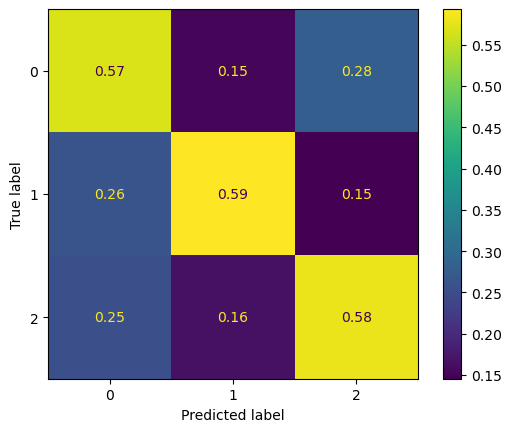

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.03932. Saving Model!
epoch 01, loss: 1.06733, acc: 0.34917, val_loss: 1.03932, val_accuracy: 0.39077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 02, loss: 1.05436, acc: 0.38124, val_loss: 1.03952, val_accuracy: 0.40139


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


epoch 03, loss: 1.05514, acc: 0.37729, val_loss: 1.03941, val_accuracy: 0.39821


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


[INFO] val_acc has been improved from 1.03932 to 1.03824. Saving Model!
epoch 04, loss: 1.05515, acc: 0.37696, val_loss: 1.03824, val_accuracy: 0.39742


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


[INFO] val_acc has been improved from 1.03824 to 1.03737. Saving Model!
epoch 05, loss: 1.05297, acc: 0.37911, val_loss: 1.03737, val_accuracy: 0.39593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


[INFO] val_acc has been improved from 1.03737 to 1.03693. Saving Model!
epoch 06, loss: 1.05137, acc: 0.38143, val_loss: 1.03693, val_accuracy: 0.39484


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


[INFO] val_acc has been improved from 1.03693 to 1.03640. Saving Model!
epoch 07, loss: 1.05027, acc: 0.38167, val_loss: 1.03640, val_accuracy: 0.39435


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


[INFO] val_acc has been improved from 1.03640 to 1.03580. Saving Model!
epoch 08, loss: 1.04915, acc: 0.38058, val_loss: 1.03580, val_accuracy: 0.39464


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


[INFO] val_acc has been improved from 1.03580 to 1.03522. Saving Model!
epoch 09, loss: 1.04748, acc: 0.38421, val_loss: 1.03522, val_accuracy: 0.41806


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


[INFO] val_acc has been improved from 1.03522 to 1.03472. Saving Model!
epoch 10, loss: 1.04663, acc: 0.38661, val_loss: 1.03472, val_accuracy: 0.42133


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


[INFO] val_acc has been improved from 1.03472 to 1.03430. Saving Model!
epoch 11, loss: 1.04494, acc: 0.40916, val_loss: 1.03430, val_accuracy: 0.42133


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


[INFO] val_acc has been improved from 1.03430 to 1.03389. Saving Model!
epoch 12, loss: 1.04469, acc: 0.39532, val_loss: 1.03389, val_accuracy: 0.40833


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


[INFO] val_acc has been improved from 1.03389 to 1.03349. Saving Model!
epoch 13, loss: 1.04248, acc: 0.41013, val_loss: 1.03349, val_accuracy: 0.40982


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


[INFO] val_acc has been improved from 1.03349 to 1.03307. Saving Model!
epoch 14, loss: 1.04248, acc: 0.41155, val_loss: 1.03307, val_accuracy: 0.41012


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


[INFO] val_acc has been improved from 1.03307 to 1.03272. Saving Model!
epoch 15, loss: 1.04052, acc: 0.41369, val_loss: 1.03272, val_accuracy: 0.41190


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


[INFO] val_acc has been improved from 1.03272 to 1.03257. Saving Model!
epoch 16, loss: 1.04010, acc: 0.41532, val_loss: 1.03257, val_accuracy: 0.41200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


[INFO] val_acc has been improved from 1.03257 to 1.03241. Saving Model!
epoch 17, loss: 1.03815, acc: 0.41652, val_loss: 1.03241, val_accuracy: 0.41429


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


[INFO] val_acc has been improved from 1.03241 to 1.03234. Saving Model!
epoch 18, loss: 1.03837, acc: 0.41785, val_loss: 1.03234, val_accuracy: 0.41478


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


epoch 19, loss: 1.03598, acc: 0.42095, val_loss: 1.03236, val_accuracy: 0.41538


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.21it/s]


[INFO] val_acc has been improved from 1.03234 to 1.03218. Saving Model!
epoch 20, loss: 1.03588, acc: 0.42386, val_loss: 1.03218, val_accuracy: 0.41865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.88it/s]


[INFO] val_acc has been improved from 1.03218 to 1.03201. Saving Model!
epoch 21, loss: 1.03400, acc: 0.42681, val_loss: 1.03201, val_accuracy: 0.41825


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.31it/s]


epoch 22, loss: 1.03393, acc: 0.42723, val_loss: 1.03214, val_accuracy: 0.41875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 23, loss: 1.03161, acc: 0.43000, val_loss: 1.03217, val_accuracy: 0.41915


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 24, loss: 1.03160, acc: 0.43467, val_loss: 1.03209, val_accuracy: 0.42312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.45it/s]


[INFO] val_acc has been improved from 1.03201 to 1.03189. Saving Model!
epoch 25, loss: 1.03024, acc: 0.43726, val_loss: 1.03189, val_accuracy: 0.42411


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.56it/s]


epoch 26, loss: 1.02855, acc: 0.44127, val_loss: 1.03194, val_accuracy: 0.42391


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 27, loss: 1.02857, acc: 0.44225, val_loss: 1.03192, val_accuracy: 0.41002


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.67it/s]


epoch 28, loss: 1.02620, acc: 0.44507, val_loss: 1.03189, val_accuracy: 0.41081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.94it/s]


epoch 29, loss: 1.02628, acc: 0.44707, val_loss: 1.03224, val_accuracy: 0.41538


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.96it/s]


[INFO] val_acc has been improved from 1.03189 to 1.03180. Saving Model!
epoch 30, loss: 1.02538, acc: 0.44780, val_loss: 1.03180, val_accuracy: 0.41389


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 31, loss: 1.02387, acc: 0.44982, val_loss: 1.03193, val_accuracy: 0.41448


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


[INFO] val_acc has been improved from 1.03180 to 1.03147. Saving Model!
epoch 32, loss: 1.02254, acc: 0.45028, val_loss: 1.03147, val_accuracy: 0.41438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.12it/s]


epoch 33, loss: 1.02223, acc: 0.45178, val_loss: 1.03160, val_accuracy: 0.41845


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


[INFO] val_acc has been improved from 1.03147 to 1.03146. Saving Model!
epoch 34, loss: 1.01971, acc: 0.45639, val_loss: 1.03146, val_accuracy: 0.41855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


[INFO] val_acc has been improved from 1.03146 to 1.03134. Saving Model!
epoch 35, loss: 1.01996, acc: 0.45633, val_loss: 1.03134, val_accuracy: 0.42123


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 36, loss: 1.01803, acc: 0.45802, val_loss: 1.03138, val_accuracy: 0.42312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


[INFO] val_acc has been improved from 1.03134 to 1.03111. Saving Model!
epoch 37, loss: 1.01691, acc: 0.46045, val_loss: 1.03111, val_accuracy: 0.42212


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


epoch 38, loss: 1.01640, acc: 0.46179, val_loss: 1.03175, val_accuracy: 0.42460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


epoch 39, loss: 1.01449, acc: 0.46228, val_loss: 1.03141, val_accuracy: 0.42381


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 40, loss: 1.01456, acc: 0.46112, val_loss: 1.03144, val_accuracy: 0.42391


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 41, loss: 1.01298, acc: 0.46475, val_loss: 1.03165, val_accuracy: 0.42401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.95it/s]


epoch 42, loss: 1.01122, acc: 0.46504, val_loss: 1.03145, val_accuracy: 0.42371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 43, loss: 1.01148, acc: 0.46431, val_loss: 1.03199, val_accuracy: 0.42500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 44, loss: 1.00882, acc: 0.46598, val_loss: 1.03174, val_accuracy: 0.42361


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 45, loss: 1.00954, acc: 0.46728, val_loss: 1.03191, val_accuracy: 0.42480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 46, loss: 1.00693, acc: 0.47023, val_loss: 1.03163, val_accuracy: 0.42450


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 47, loss: 1.00738, acc: 0.46673, val_loss: 1.03237, val_accuracy: 0.42510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 48, loss: 1.00473, acc: 0.47006, val_loss: 1.03213, val_accuracy: 0.42470


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


epoch 49, loss: 1.00551, acc: 0.46742, val_loss: 1.03287, val_accuracy: 0.42579


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


epoch 50, loss: 1.00344, acc: 0.46921, val_loss: 1.03209, val_accuracy: 0.42550


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


epoch 51, loss: 1.00304, acc: 0.46677, val_loss: 1.03290, val_accuracy: 0.42520


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.71it/s]


epoch 52, loss: 1.00035, acc: 0.46889, val_loss: 1.03303, val_accuracy: 0.42649


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 53, loss: 1.00083, acc: 0.46698, val_loss: 1.03365, val_accuracy: 0.42490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 54, loss: 0.99824, acc: 0.46866, val_loss: 1.03329, val_accuracy: 0.42589


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 55, loss: 0.99881, acc: 0.46640, val_loss: 1.03333, val_accuracy: 0.42639


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 56, loss: 0.99585, acc: 0.46878, val_loss: 1.03357, val_accuracy: 0.42510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 57, loss: 0.99649, acc: 0.46928, val_loss: 1.03432, val_accuracy: 0.42440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 58, loss: 0.99387, acc: 0.47147, val_loss: 1.03374, val_accuracy: 0.42480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 59, loss: 0.99415, acc: 0.46825, val_loss: 1.03397, val_accuracy: 0.44236


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.39it/s]


epoch 60, loss: 0.99182, acc: 0.47033, val_loss: 1.03499, val_accuracy: 0.44206


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 61, loss: 0.99121, acc: 0.47566, val_loss: 1.03429, val_accuracy: 0.44365


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 62, loss: 0.99038, acc: 0.47527, val_loss: 1.03598, val_accuracy: 0.44018


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 63, loss: 0.98865, acc: 0.47588, val_loss: 1.03452, val_accuracy: 0.44395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 64, loss: 0.98812, acc: 0.47403, val_loss: 1.03469, val_accuracy: 0.44345


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 65, loss: 0.98680, acc: 0.47636, val_loss: 1.03525, val_accuracy: 0.44593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 66, loss: 0.98505, acc: 0.47697, val_loss: 1.03470, val_accuracy: 0.44375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 67, loss: 0.98544, acc: 0.47514, val_loss: 1.03679, val_accuracy: 0.44425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 68, loss: 0.98270, acc: 0.48100, val_loss: 1.03540, val_accuracy: 0.44792


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 69, loss: 0.98372, acc: 0.47553, val_loss: 1.03513, val_accuracy: 0.45109


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 70, loss: 0.98007, acc: 0.48044, val_loss: 1.03628, val_accuracy: 0.44812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 71, loss: 0.98140, acc: 0.47859, val_loss: 1.03633, val_accuracy: 0.44782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 72, loss: 0.97829, acc: 0.48160, val_loss: 1.03581, val_accuracy: 0.44722


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 73, loss: 0.97935, acc: 0.48207, val_loss: 1.03663, val_accuracy: 0.44861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 74, loss: 0.97590, acc: 0.48501, val_loss: 1.03638, val_accuracy: 0.44861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 75, loss: 0.97767, acc: 0.48310, val_loss: 1.03751, val_accuracy: 0.44851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 76, loss: 0.97395, acc: 0.48648, val_loss: 1.03576, val_accuracy: 0.44821


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 77, loss: 0.97541, acc: 0.48163, val_loss: 1.03626, val_accuracy: 0.44931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 78, loss: 0.97157, acc: 0.48831, val_loss: 1.03647, val_accuracy: 0.44901


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 79, loss: 0.97311, acc: 0.48720, val_loss: 1.03709, val_accuracy: 0.45060


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 80, loss: 0.96985, acc: 0.48985, val_loss: 1.03577, val_accuracy: 0.44950


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 81, loss: 0.97097, acc: 0.48478, val_loss: 1.03750, val_accuracy: 0.45069


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 82, loss: 0.96773, acc: 0.49211, val_loss: 1.03668, val_accuracy: 0.45099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 83, loss: 0.96900, acc: 0.48784, val_loss: 1.03744, val_accuracy: 0.45208


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 84, loss: 0.96548, acc: 0.49119, val_loss: 1.03678, val_accuracy: 0.45109


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 85, loss: 0.96706, acc: 0.48842, val_loss: 1.03762, val_accuracy: 0.45188


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 86, loss: 0.96381, acc: 0.49193, val_loss: 1.03633, val_accuracy: 0.46627


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 87, loss: 0.96458, acc: 0.48867, val_loss: 1.03711, val_accuracy: 0.45179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 88, loss: 0.96162, acc: 0.49061, val_loss: 1.03660, val_accuracy: 0.46756


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 89, loss: 0.96322, acc: 0.48859, val_loss: 1.03792, val_accuracy: 0.45308


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 90, loss: 0.95945, acc: 0.49217, val_loss: 1.03685, val_accuracy: 0.46974


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 91, loss: 0.96107, acc: 0.49015, val_loss: 1.03688, val_accuracy: 0.45308


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 92, loss: 0.95758, acc: 0.49395, val_loss: 1.03640, val_accuracy: 0.46984


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 93, loss: 0.95918, acc: 0.48978, val_loss: 1.03641, val_accuracy: 0.47044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 94, loss: 0.95557, acc: 0.49533, val_loss: 1.03609, val_accuracy: 0.47103


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 95, loss: 0.95701, acc: 0.49260, val_loss: 1.03628, val_accuracy: 0.47312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 96, loss: 0.95354, acc: 0.49550, val_loss: 1.03479, val_accuracy: 0.47063


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 97, loss: 0.95515, acc: 0.49319, val_loss: 1.03589, val_accuracy: 0.47381


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]


epoch 98, loss: 0.95204, acc: 0.49902, val_loss: 1.03484, val_accuracy: 0.47143


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 99, loss: 0.95286, acc: 0.49501, val_loss: 1.03454, val_accuracy: 0.47312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 100, loss: 0.95008, acc: 0.49858, val_loss: 1.03428, val_accuracy: 0.47093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 101, loss: 0.95119, acc: 0.49572, val_loss: 1.03322, val_accuracy: 0.47272


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 102, loss: 0.94751, acc: 0.50135, val_loss: 1.03343, val_accuracy: 0.47133


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 103, loss: 0.94914, acc: 0.49734, val_loss: 1.03307, val_accuracy: 0.47371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 104, loss: 0.94630, acc: 0.50064, val_loss: 1.03183, val_accuracy: 0.47222


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 105, loss: 0.94708, acc: 0.49794, val_loss: 1.03180, val_accuracy: 0.47530


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 106, loss: 0.94408, acc: 0.50077, val_loss: 1.03184, val_accuracy: 0.47232


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 107, loss: 0.94513, acc: 0.49927, val_loss: 1.03113, val_accuracy: 0.47490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


[INFO] val_acc has been improved from 1.03111 to 1.03086. Saving Model!
epoch 108, loss: 0.94221, acc: 0.50128, val_loss: 1.03086, val_accuracy: 0.47401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


[INFO] val_acc has been improved from 1.03086 to 1.03070. Saving Model!
epoch 109, loss: 0.94314, acc: 0.50004, val_loss: 1.03070, val_accuracy: 0.47431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 110, loss: 0.94007, acc: 0.50305, val_loss: 1.03078, val_accuracy: 0.47411


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 111, loss: 0.94123, acc: 0.50004, val_loss: 1.03197, val_accuracy: 0.47431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


[INFO] val_acc has been improved from 1.03070 to 1.02943. Saving Model!
epoch 112, loss: 0.93834, acc: 0.50422, val_loss: 1.02943, val_accuracy: 0.47401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 113, loss: 0.93916, acc: 0.50202, val_loss: 1.03163, val_accuracy: 0.47550


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 114, loss: 0.93575, acc: 0.50537, val_loss: 1.03055, val_accuracy: 0.47560


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 115, loss: 0.93678, acc: 0.50400, val_loss: 1.03043, val_accuracy: 0.47569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


[INFO] val_acc has been improved from 1.02943 to 1.02939. Saving Model!
epoch 116, loss: 0.93414, acc: 0.50541, val_loss: 1.02939, val_accuracy: 0.47490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 117, loss: 0.93479, acc: 0.50643, val_loss: 1.03116, val_accuracy: 0.47619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 118, loss: 0.93226, acc: 0.50671, val_loss: 1.02942, val_accuracy: 0.47530


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 119, loss: 0.93277, acc: 0.50759, val_loss: 1.03002, val_accuracy: 0.47589


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 120, loss: 0.93002, acc: 0.50881, val_loss: 1.03033, val_accuracy: 0.47798


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


[INFO] val_acc has been improved from 1.02939 to 1.02929. Saving Model!
epoch 121, loss: 0.93113, acc: 0.51053, val_loss: 1.02929, val_accuracy: 0.47490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 122, loss: 0.92823, acc: 0.51276, val_loss: 1.03204, val_accuracy: 0.47550


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


[INFO] val_acc has been improved from 1.02929 to 1.02885. Saving Model!
epoch 123, loss: 0.92895, acc: 0.51128, val_loss: 1.02885, val_accuracy: 0.47242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 124, loss: 0.92673, acc: 0.51550, val_loss: 1.03067, val_accuracy: 0.47679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 125, loss: 0.92684, acc: 0.51587, val_loss: 1.02954, val_accuracy: 0.47361


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 126, loss: 0.92526, acc: 0.51678, val_loss: 1.03027, val_accuracy: 0.47698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


[INFO] val_acc has been improved from 1.02885 to 1.02813. Saving Model!
epoch 127, loss: 0.92399, acc: 0.51736, val_loss: 1.02813, val_accuracy: 0.47123


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 128, loss: 0.92263, acc: 0.51903, val_loss: 1.03047, val_accuracy: 0.47500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 129, loss: 0.92251, acc: 0.52072, val_loss: 1.02874, val_accuracy: 0.47143


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.70it/s]


epoch 130, loss: 0.92002, acc: 0.52030, val_loss: 1.03013, val_accuracy: 0.47619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.24it/s]


epoch 131, loss: 0.92023, acc: 0.52211, val_loss: 1.02906, val_accuracy: 0.47202


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.00it/s]


epoch 132, loss: 0.91788, acc: 0.52136, val_loss: 1.03095, val_accuracy: 0.47599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 133, loss: 0.91825, acc: 0.52263, val_loss: 1.02900, val_accuracy: 0.47252


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 134, loss: 0.91538, acc: 0.52420, val_loss: 1.03021, val_accuracy: 0.47639


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.86it/s]


epoch 135, loss: 0.91596, acc: 0.52330, val_loss: 1.03035, val_accuracy: 0.47242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


epoch 136, loss: 0.91346, acc: 0.52437, val_loss: 1.03060, val_accuracy: 0.47589


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.28it/s]


epoch 137, loss: 0.91351, acc: 0.52690, val_loss: 1.02963, val_accuracy: 0.47411


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


epoch 138, loss: 0.91178, acc: 0.52537, val_loss: 1.03072, val_accuracy: 0.47589


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.39it/s]


epoch 139, loss: 0.91182, acc: 0.52791, val_loss: 1.03034, val_accuracy: 0.47381


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]


epoch 140, loss: 0.90926, acc: 0.52619, val_loss: 1.03072, val_accuracy: 0.47679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 141, loss: 0.90976, acc: 0.52773, val_loss: 1.02946, val_accuracy: 0.47540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 142, loss: 0.90696, acc: 0.52702, val_loss: 1.03099, val_accuracy: 0.47609


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 143, loss: 0.90713, acc: 0.53088, val_loss: 1.02971, val_accuracy: 0.47599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 144, loss: 0.90448, acc: 0.53174, val_loss: 1.03089, val_accuracy: 0.47698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]


epoch 145, loss: 0.90480, acc: 0.53391, val_loss: 1.02905, val_accuracy: 0.47837


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 146, loss: 0.90487, acc: 0.53442, val_loss: 1.03082, val_accuracy: 0.47877


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]


epoch 147, loss: 0.90405, acc: 0.53569, val_loss: 1.02947, val_accuracy: 0.47986


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 148, loss: 0.90006, acc: 0.53423, val_loss: 1.02870, val_accuracy: 0.47768


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 149, loss: 0.89972, acc: 0.53763, val_loss: 1.02850, val_accuracy: 0.47937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 150, loss: 0.89816, acc: 0.53640, val_loss: 1.02976, val_accuracy: 0.47927


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


[INFO] val_acc has been improved from 1.02813 to 1.02767. Saving Model!
epoch 151, loss: 0.89777, acc: 0.53914, val_loss: 1.02767, val_accuracy: 0.48442


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 152, loss: 0.89597, acc: 0.54193, val_loss: 1.03003, val_accuracy: 0.48363


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


[INFO] val_acc has been improved from 1.02767 to 1.02725. Saving Model!
epoch 153, loss: 0.89652, acc: 0.54189, val_loss: 1.02725, val_accuracy: 0.48581


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 154, loss: 0.89412, acc: 0.54296, val_loss: 1.02938, val_accuracy: 0.48403


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.00it/s]


[INFO] val_acc has been improved from 1.02725 to 1.02662. Saving Model!
epoch 155, loss: 0.89402, acc: 0.54461, val_loss: 1.02662, val_accuracy: 0.48760


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.38it/s]


epoch 156, loss: 0.89197, acc: 0.54644, val_loss: 1.02967, val_accuracy: 0.48571


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]


[INFO] val_acc has been improved from 1.02662 to 1.02616. Saving Model!
epoch 157, loss: 0.89229, acc: 0.54874, val_loss: 1.02616, val_accuracy: 0.49117


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]


epoch 158, loss: 0.88929, acc: 0.54959, val_loss: 1.02816, val_accuracy: 0.49216


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 159, loss: 0.88973, acc: 0.55103, val_loss: 1.02680, val_accuracy: 0.49365


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 160, loss: 0.88718, acc: 0.55165, val_loss: 1.02858, val_accuracy: 0.49355


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


[INFO] val_acc has been improved from 1.02616 to 1.02584. Saving Model!
epoch 161, loss: 0.88738, acc: 0.55293, val_loss: 1.02584, val_accuracy: 0.49504


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 162, loss: 0.88544, acc: 0.55736, val_loss: 1.02767, val_accuracy: 0.49464


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 163, loss: 0.88502, acc: 0.55371, val_loss: 1.02685, val_accuracy: 0.49712


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 164, loss: 0.88339, acc: 0.55907, val_loss: 1.02797, val_accuracy: 0.49692


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.94it/s]


[INFO] val_acc has been improved from 1.02584 to 1.02561. Saving Model!
epoch 165, loss: 0.88284, acc: 0.55877, val_loss: 1.02561, val_accuracy: 0.49663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 166, loss: 0.88132, acc: 0.55921, val_loss: 1.02845, val_accuracy: 0.49931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.01it/s]


[INFO] val_acc has been improved from 1.02561 to 1.02491. Saving Model!
epoch 167, loss: 0.88091, acc: 0.56031, val_loss: 1.02491, val_accuracy: 0.49901


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


epoch 168, loss: 0.87889, acc: 0.56134, val_loss: 1.02803, val_accuracy: 0.50010


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 169, loss: 0.87908, acc: 0.56176, val_loss: 1.02544, val_accuracy: 0.49950


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 170, loss: 0.87767, acc: 0.56513, val_loss: 1.02771, val_accuracy: 0.50337


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.14it/s]


epoch 171, loss: 0.87726, acc: 0.56244, val_loss: 1.02515, val_accuracy: 0.50129


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


epoch 172, loss: 0.87516, acc: 0.56695, val_loss: 1.02736, val_accuracy: 0.50228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.98it/s]


epoch 173, loss: 0.87475, acc: 0.56415, val_loss: 1.02540, val_accuracy: 0.50308


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.35it/s]


epoch 174, loss: 0.87295, acc: 0.56901, val_loss: 1.02716, val_accuracy: 0.50486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 175, loss: 0.87233, acc: 0.56714, val_loss: 1.02566, val_accuracy: 0.50367


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 176, loss: 0.87066, acc: 0.57012, val_loss: 1.02650, val_accuracy: 0.50546


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]


epoch 177, loss: 0.87030, acc: 0.57000, val_loss: 1.02580, val_accuracy: 0.50456


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


epoch 178, loss: 0.86867, acc: 0.57194, val_loss: 1.02703, val_accuracy: 0.50615


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.17it/s]


epoch 179, loss: 0.86802, acc: 0.57167, val_loss: 1.02660, val_accuracy: 0.50437


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


epoch 180, loss: 0.86713, acc: 0.57389, val_loss: 1.02707, val_accuracy: 0.50685


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.30it/s]


epoch 181, loss: 0.86664, acc: 0.57324, val_loss: 1.02539, val_accuracy: 0.50387


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.42it/s]


epoch 182, loss: 0.86461, acc: 0.57370, val_loss: 1.02763, val_accuracy: 0.50655


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 183, loss: 0.86482, acc: 0.57395, val_loss: 1.02542, val_accuracy: 0.50446


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 184, loss: 0.86260, acc: 0.57664, val_loss: 1.02799, val_accuracy: 0.50734


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


epoch 185, loss: 0.86270, acc: 0.57626, val_loss: 1.02521, val_accuracy: 0.50546


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 186, loss: 0.86084, acc: 0.57694, val_loss: 1.02749, val_accuracy: 0.50665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 187, loss: 0.86031, acc: 0.57854, val_loss: 1.02558, val_accuracy: 0.50546


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.13it/s]


epoch 188, loss: 0.85858, acc: 0.58076, val_loss: 1.02735, val_accuracy: 0.50903


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.46it/s]


epoch 189, loss: 0.85873, acc: 0.58171, val_loss: 1.02614, val_accuracy: 0.50486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]


epoch 190, loss: 0.85694, acc: 0.58346, val_loss: 1.02744, val_accuracy: 0.50813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 191, loss: 0.85616, acc: 0.58624, val_loss: 1.02661, val_accuracy: 0.50804


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]


epoch 192, loss: 0.85483, acc: 0.58754, val_loss: 1.02642, val_accuracy: 0.50843


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 193, loss: 0.85362, acc: 0.58588, val_loss: 1.02627, val_accuracy: 0.50804


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 194, loss: 0.85353, acc: 0.58846, val_loss: 1.02704, val_accuracy: 0.50873


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 195, loss: 0.85230, acc: 0.58709, val_loss: 1.02527, val_accuracy: 0.50923


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 196, loss: 0.85120, acc: 0.59150, val_loss: 1.02700, val_accuracy: 0.50913


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 197, loss: 0.85049, acc: 0.58978, val_loss: 1.02539, val_accuracy: 0.50952


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 198, loss: 0.84915, acc: 0.59393, val_loss: 1.02633, val_accuracy: 0.50952


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 199, loss: 0.84813, acc: 0.59128, val_loss: 1.02501, val_accuracy: 0.51012


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 200, loss: 0.84786, acc: 0.59397, val_loss: 1.02636, val_accuracy: 0.51052


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.39it/s]


[INFO] val_acc has been improved from 1.02491 to 1.02373. Saving Model!
epoch 201, loss: 0.84640, acc: 0.59478, val_loss: 1.02373, val_accuracy: 0.51052


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.13it/s]


epoch 202, loss: 0.84496, acc: 0.59886, val_loss: 1.02583, val_accuracy: 0.51181


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.43it/s]


epoch 203, loss: 0.84460, acc: 0.59600, val_loss: 1.02433, val_accuracy: 0.51101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 204, loss: 0.84278, acc: 0.59935, val_loss: 1.02453, val_accuracy: 0.51210


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 205, loss: 0.84241, acc: 0.59720, val_loss: 1.02414, val_accuracy: 0.51131


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 206, loss: 0.84131, acc: 0.60060, val_loss: 1.02415, val_accuracy: 0.51290


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


[INFO] val_acc has been improved from 1.02373 to 1.02368. Saving Model!
epoch 207, loss: 0.83971, acc: 0.60220, val_loss: 1.02368, val_accuracy: 0.51190


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


[INFO] val_acc has been improved from 1.02368 to 1.02357. Saving Model!
epoch 208, loss: 0.83927, acc: 0.60149, val_loss: 1.02357, val_accuracy: 0.51339


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 209, loss: 0.83805, acc: 0.60042, val_loss: 1.02374, val_accuracy: 0.51240


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


[INFO] val_acc has been improved from 1.02357 to 1.02257. Saving Model!
epoch 210, loss: 0.83765, acc: 0.60224, val_loss: 1.02257, val_accuracy: 0.51230


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 211, loss: 0.83618, acc: 0.60046, val_loss: 1.02446, val_accuracy: 0.51141


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


[INFO] val_acc has been improved from 1.02257 to 1.02240. Saving Model!
epoch 212, loss: 0.83592, acc: 0.60208, val_loss: 1.02240, val_accuracy: 0.51260


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 213, loss: 0.83439, acc: 0.60106, val_loss: 1.02284, val_accuracy: 0.51349


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 214, loss: 0.83397, acc: 0.60519, val_loss: 1.02344, val_accuracy: 0.51240


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


[INFO] val_acc has been improved from 1.02240 to 1.02071. Saving Model!
epoch 215, loss: 0.83285, acc: 0.60653, val_loss: 1.02071, val_accuracy: 0.51389


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 216, loss: 0.83156, acc: 0.60737, val_loss: 1.02352, val_accuracy: 0.51399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 217, loss: 0.83155, acc: 0.61151, val_loss: 1.02071, val_accuracy: 0.51448


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 218, loss: 0.82969, acc: 0.61024, val_loss: 1.02327, val_accuracy: 0.51220


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


[INFO] val_acc has been improved from 1.02071 to 1.02007. Saving Model!
epoch 219, loss: 0.82975, acc: 0.61186, val_loss: 1.02007, val_accuracy: 0.51429


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.29it/s]


epoch 220, loss: 0.82757, acc: 0.61265, val_loss: 1.02239, val_accuracy: 0.51429


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.57it/s]


epoch 221, loss: 0.82736, acc: 0.61471, val_loss: 1.02082, val_accuracy: 0.51458


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.37it/s]


epoch 222, loss: 0.82596, acc: 0.61252, val_loss: 1.02087, val_accuracy: 0.51349


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 223, loss: 0.82568, acc: 0.61335, val_loss: 1.02193, val_accuracy: 0.51438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


[INFO] val_acc has been improved from 1.02007 to 1.02000. Saving Model!
epoch 224, loss: 0.82380, acc: 0.61514, val_loss: 1.02000, val_accuracy: 0.51518


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.05it/s]


epoch 225, loss: 0.82422, acc: 0.61321, val_loss: 1.02081, val_accuracy: 0.51518


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.59it/s]


[INFO] val_acc has been improved from 1.02000 to 1.01983. Saving Model!
epoch 226, loss: 0.82301, acc: 0.61436, val_loss: 1.01983, val_accuracy: 0.51567


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 227, loss: 0.82277, acc: 0.61161, val_loss: 1.02097, val_accuracy: 0.51419


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


[INFO] val_acc has been improved from 1.01983 to 1.01929. Saving Model!
epoch 228, loss: 0.82201, acc: 0.61514, val_loss: 1.01929, val_accuracy: 0.51696


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.12it/s]


epoch 229, loss: 0.82142, acc: 0.61272, val_loss: 1.01969, val_accuracy: 0.51567


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 230, loss: 0.82014, acc: 0.61601, val_loss: 1.02016, val_accuracy: 0.51677


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.78it/s]


epoch 231, loss: 0.81865, acc: 0.61337, val_loss: 1.01989, val_accuracy: 0.51647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]


epoch 232, loss: 0.81801, acc: 0.61680, val_loss: 1.01982, val_accuracy: 0.51925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


[INFO] val_acc has been improved from 1.01929 to 1.01830. Saving Model!
epoch 233, loss: 0.81654, acc: 0.61714, val_loss: 1.01830, val_accuracy: 0.51567


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 234, loss: 0.81510, acc: 0.61717, val_loss: 1.02124, val_accuracy: 0.51974


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 235, loss: 0.81508, acc: 0.61808, val_loss: 1.01860, val_accuracy: 0.51637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 236, loss: 0.81293, acc: 0.61806, val_loss: 1.01894, val_accuracy: 0.52083


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 237, loss: 0.81247, acc: 0.61700, val_loss: 1.02055, val_accuracy: 0.51558


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


[INFO] val_acc has been improved from 1.01830 to 1.01771. Saving Model!
epoch 238, loss: 0.81217, acc: 0.61863, val_loss: 1.01771, val_accuracy: 0.52222


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 239, loss: 0.81023, acc: 0.61622, val_loss: 1.02100, val_accuracy: 0.51994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 240, loss: 0.81009, acc: 0.61746, val_loss: 1.01780, val_accuracy: 0.52292


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 241, loss: 0.80839, acc: 0.61668, val_loss: 1.01939, val_accuracy: 0.51895


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 242, loss: 0.80834, acc: 0.61853, val_loss: 1.01835, val_accuracy: 0.52361


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 243, loss: 0.80606, acc: 0.62113, val_loss: 1.01842, val_accuracy: 0.51865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 244, loss: 0.80586, acc: 0.61873, val_loss: 1.01903, val_accuracy: 0.52500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


[INFO] val_acc has been improved from 1.01771 to 1.01685. Saving Model!
epoch 245, loss: 0.80490, acc: 0.62199, val_loss: 1.01685, val_accuracy: 0.52083


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 246, loss: 0.80434, acc: 0.61944, val_loss: 1.01941, val_accuracy: 0.52460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 247, loss: 0.80324, acc: 0.62328, val_loss: 1.01745, val_accuracy: 0.52153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


[INFO] val_acc has been improved from 1.01685 to 1.01656. Saving Model!
epoch 248, loss: 0.80324, acc: 0.61963, val_loss: 1.01656, val_accuracy: 0.52669


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.95it/s]


epoch 249, loss: 0.80137, acc: 0.62512, val_loss: 1.01877, val_accuracy: 0.52361


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 250, loss: 0.80129, acc: 0.62099, val_loss: 1.01742, val_accuracy: 0.52490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 251, loss: 0.79980, acc: 0.62336, val_loss: 1.01897, val_accuracy: 0.52401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 252, loss: 0.79903, acc: 0.62138, val_loss: 1.01725, val_accuracy: 0.52629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 253, loss: 0.79870, acc: 0.62230, val_loss: 1.01813, val_accuracy: 0.52312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 254, loss: 0.79736, acc: 0.62218, val_loss: 1.01764, val_accuracy: 0.52540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 255, loss: 0.79569, acc: 0.62739, val_loss: 1.01977, val_accuracy: 0.52490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.11it/s]


epoch 256, loss: 0.79566, acc: 0.62357, val_loss: 1.01675, val_accuracy: 0.52599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.90it/s]


epoch 257, loss: 0.79467, acc: 0.62491, val_loss: 1.01908, val_accuracy: 0.52500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.14it/s]


[INFO] val_acc has been improved from 1.01656 to 1.01577. Saving Model!
epoch 258, loss: 0.79342, acc: 0.62370, val_loss: 1.01577, val_accuracy: 0.52540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 259, loss: 0.79171, acc: 0.62791, val_loss: 1.01843, val_accuracy: 0.52550


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


epoch 260, loss: 0.79106, acc: 0.62567, val_loss: 1.01829, val_accuracy: 0.52569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 261, loss: 0.79004, acc: 0.62802, val_loss: 1.01951, val_accuracy: 0.52629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 262, loss: 0.78937, acc: 0.62656, val_loss: 1.01673, val_accuracy: 0.52698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 263, loss: 0.78862, acc: 0.63051, val_loss: 1.02026, val_accuracy: 0.52560


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 264, loss: 0.78778, acc: 0.62782, val_loss: 1.01639, val_accuracy: 0.52728


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 265, loss: 0.78677, acc: 0.63128, val_loss: 1.01964, val_accuracy: 0.52639


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 266, loss: 0.78660, acc: 0.62949, val_loss: 1.01609, val_accuracy: 0.52788


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 267, loss: 0.78431, acc: 0.63165, val_loss: 1.02064, val_accuracy: 0.52679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 268, loss: 0.78382, acc: 0.63120, val_loss: 1.01612, val_accuracy: 0.52937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 269, loss: 0.78282, acc: 0.63206, val_loss: 1.01914, val_accuracy: 0.52867


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


[INFO] val_acc has been improved from 1.01577 to 1.01568. Saving Model!
epoch 270, loss: 0.78178, acc: 0.63348, val_loss: 1.01568, val_accuracy: 0.52996


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 271, loss: 0.78126, acc: 0.63321, val_loss: 1.01721, val_accuracy: 0.52976


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 272, loss: 0.77932, acc: 0.63470, val_loss: 1.01691, val_accuracy: 0.53006


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 273, loss: 0.77934, acc: 0.63459, val_loss: 1.01731, val_accuracy: 0.53026


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


[INFO] val_acc has been improved from 1.01568 to 1.01480. Saving Model!
epoch 274, loss: 0.77803, acc: 0.63528, val_loss: 1.01480, val_accuracy: 0.53036


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 275, loss: 0.77700, acc: 0.63784, val_loss: 1.01940, val_accuracy: 0.53046


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


[INFO] val_acc has been improved from 1.01480 to 1.01454. Saving Model!
epoch 276, loss: 0.77729, acc: 0.63546, val_loss: 1.01454, val_accuracy: 0.53095


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


epoch 277, loss: 0.77543, acc: 0.63976, val_loss: 1.01956, val_accuracy: 0.53155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 278, loss: 0.77514, acc: 0.63631, val_loss: 1.01672, val_accuracy: 0.53244


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 279, loss: 0.77374, acc: 0.64332, val_loss: 1.01959, val_accuracy: 0.53234


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 280, loss: 0.77450, acc: 0.63744, val_loss: 1.01585, val_accuracy: 0.53185


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 281, loss: 0.77135, acc: 0.64376, val_loss: 1.01985, val_accuracy: 0.53244


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 282, loss: 0.77273, acc: 0.63719, val_loss: 1.01905, val_accuracy: 0.53323


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.47it/s]


epoch 283, loss: 0.77046, acc: 0.64512, val_loss: 1.01744, val_accuracy: 0.53284


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 284, loss: 0.77140, acc: 0.63913, val_loss: 1.02126, val_accuracy: 0.53462


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 285, loss: 0.76977, acc: 0.64555, val_loss: 1.01551, val_accuracy: 0.53363


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 286, loss: 0.76899, acc: 0.63882, val_loss: 1.02044, val_accuracy: 0.53522


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 287, loss: 0.76792, acc: 0.64634, val_loss: 1.01817, val_accuracy: 0.53482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 288, loss: 0.76672, acc: 0.64062, val_loss: 1.01893, val_accuracy: 0.53571


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 289, loss: 0.76533, acc: 0.64830, val_loss: 1.01905, val_accuracy: 0.53522


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 290, loss: 0.76489, acc: 0.64099, val_loss: 1.01803, val_accuracy: 0.53661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 291, loss: 0.76348, acc: 0.64948, val_loss: 1.01862, val_accuracy: 0.53571


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 292, loss: 0.76267, acc: 0.64162, val_loss: 1.02028, val_accuracy: 0.53621


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 293, loss: 0.76103, acc: 0.65193, val_loss: 1.01796, val_accuracy: 0.53502


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 294, loss: 0.76220, acc: 0.64205, val_loss: 1.02041, val_accuracy: 0.53730


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 295, loss: 0.75990, acc: 0.65126, val_loss: 1.01550, val_accuracy: 0.53552


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 296, loss: 0.75902, acc: 0.64342, val_loss: 1.02116, val_accuracy: 0.53750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 297, loss: 0.75835, acc: 0.65134, val_loss: 1.01717, val_accuracy: 0.53690


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.15it/s]


epoch 298, loss: 0.75723, acc: 0.64432, val_loss: 1.01909, val_accuracy: 0.53968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


epoch 299, loss: 0.75612, acc: 0.65158, val_loss: 1.01687, val_accuracy: 0.53899


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.30it/s]


epoch 300, loss: 0.75511, acc: 0.64651, val_loss: 1.02194, val_accuracy: 0.53998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.79it/s]


epoch 301, loss: 0.75471, acc: 0.65301, val_loss: 1.01778, val_accuracy: 0.54008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 302, loss: 0.75311, acc: 0.64827, val_loss: 1.02214, val_accuracy: 0.54097


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 303, loss: 0.75312, acc: 0.65438, val_loss: 1.01716, val_accuracy: 0.54038


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 304, loss: 0.75153, acc: 0.64759, val_loss: 1.02232, val_accuracy: 0.54206


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.98it/s]


epoch 305, loss: 0.75212, acc: 0.65553, val_loss: 1.02037, val_accuracy: 0.54206


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.17it/s]


epoch 306, loss: 0.74943, acc: 0.64851, val_loss: 1.01915, val_accuracy: 0.54335


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.88it/s]


epoch 307, loss: 0.75047, acc: 0.65459, val_loss: 1.02082, val_accuracy: 0.54415


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.27it/s]


epoch 308, loss: 0.74744, acc: 0.64918, val_loss: 1.01847, val_accuracy: 0.54306


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]


epoch 309, loss: 0.74780, acc: 0.65599, val_loss: 1.02317, val_accuracy: 0.54554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 310, loss: 0.74654, acc: 0.65034, val_loss: 1.01731, val_accuracy: 0.54395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 311, loss: 0.74623, acc: 0.65720, val_loss: 1.02281, val_accuracy: 0.54534


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 312, loss: 0.74373, acc: 0.65140, val_loss: 1.01791, val_accuracy: 0.54613


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.25it/s]


epoch 313, loss: 0.74544, acc: 0.65778, val_loss: 1.02515, val_accuracy: 0.54692


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.67it/s]


epoch 314, loss: 0.74219, acc: 0.65293, val_loss: 1.01674, val_accuracy: 0.54494


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.29it/s]


epoch 315, loss: 0.74325, acc: 0.65833, val_loss: 1.02495, val_accuracy: 0.54712


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.72it/s]


epoch 316, loss: 0.74093, acc: 0.65319, val_loss: 1.01763, val_accuracy: 0.54444


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.34it/s]


epoch 317, loss: 0.74140, acc: 0.65873, val_loss: 1.02487, val_accuracy: 0.54752


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 318, loss: 0.73871, acc: 0.65568, val_loss: 1.01814, val_accuracy: 0.54474


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 319, loss: 0.73998, acc: 0.66069, val_loss: 1.02505, val_accuracy: 0.54742


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 320, loss: 0.73711, acc: 0.65741, val_loss: 1.01998, val_accuracy: 0.54603


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]


epoch 321, loss: 0.73776, acc: 0.66084, val_loss: 1.02341, val_accuracy: 0.54762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.05it/s]


epoch 322, loss: 0.73508, acc: 0.65839, val_loss: 1.02216, val_accuracy: 0.54524


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]


epoch 323, loss: 0.73649, acc: 0.66074, val_loss: 1.02485, val_accuracy: 0.54812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.19it/s]


epoch 324, loss: 0.73322, acc: 0.65898, val_loss: 1.02089, val_accuracy: 0.54554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 325, loss: 0.73643, acc: 0.65940, val_loss: 1.02535, val_accuracy: 0.54802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 326, loss: 0.73042, acc: 0.66124, val_loss: 1.02231, val_accuracy: 0.54593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 327, loss: 0.73584, acc: 0.65603, val_loss: 1.02446, val_accuracy: 0.54881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 328, loss: 0.73021, acc: 0.66134, val_loss: 1.02318, val_accuracy: 0.54593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 329, loss: 0.73478, acc: 0.65810, val_loss: 1.02444, val_accuracy: 0.54802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]


epoch 330, loss: 0.72958, acc: 0.66146, val_loss: 1.02287, val_accuracy: 0.54643


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 331, loss: 0.73370, acc: 0.65621, val_loss: 1.02459, val_accuracy: 0.55060


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 332, loss: 0.72840, acc: 0.66057, val_loss: 1.02473, val_accuracy: 0.54643


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.19it/s]


epoch 333, loss: 0.73223, acc: 0.65821, val_loss: 1.02284, val_accuracy: 0.55040


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 334, loss: 0.72665, acc: 0.66182, val_loss: 1.02448, val_accuracy: 0.54831


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 335, loss: 0.72817, acc: 0.66091, val_loss: 1.02446, val_accuracy: 0.55169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 336, loss: 0.72541, acc: 0.66353, val_loss: 1.02461, val_accuracy: 0.55099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.13it/s]


epoch 337, loss: 0.72579, acc: 0.66190, val_loss: 1.02573, val_accuracy: 0.55268


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.12it/s]


epoch 338, loss: 0.72362, acc: 0.66399, val_loss: 1.02118, val_accuracy: 0.55149


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.09it/s]


epoch 339, loss: 0.72426, acc: 0.66014, val_loss: 1.02789, val_accuracy: 0.55169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


epoch 340, loss: 0.72240, acc: 0.66547, val_loss: 1.02096, val_accuracy: 0.55169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 341, loss: 0.72145, acc: 0.66082, val_loss: 1.02377, val_accuracy: 0.55347


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 342, loss: 0.72057, acc: 0.66937, val_loss: 1.02463, val_accuracy: 0.55188


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 343, loss: 0.72101, acc: 0.66134, val_loss: 1.02394, val_accuracy: 0.55248


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 344, loss: 0.71896, acc: 0.66930, val_loss: 1.02507, val_accuracy: 0.55159


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.15it/s]


epoch 345, loss: 0.72057, acc: 0.66091, val_loss: 1.02538, val_accuracy: 0.55466


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 346, loss: 0.71866, acc: 0.67005, val_loss: 1.02266, val_accuracy: 0.55278


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.27it/s]


epoch 347, loss: 0.71849, acc: 0.66030, val_loss: 1.02755, val_accuracy: 0.55337


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 348, loss: 0.71858, acc: 0.67078, val_loss: 1.02204, val_accuracy: 0.55486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


epoch 349, loss: 0.71437, acc: 0.66111, val_loss: 1.02494, val_accuracy: 0.55288


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.12it/s]


epoch 350, loss: 0.71585, acc: 0.67046, val_loss: 1.02243, val_accuracy: 0.55575


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 351, loss: 0.71159, acc: 0.66301, val_loss: 1.02325, val_accuracy: 0.55635


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97it/s]


epoch 352, loss: 0.71317, acc: 0.66944, val_loss: 1.02629, val_accuracy: 0.55536


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]


epoch 353, loss: 0.70990, acc: 0.66700, val_loss: 1.02391, val_accuracy: 0.55456


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.85it/s]


epoch 354, loss: 0.71034, acc: 0.67087, val_loss: 1.02893, val_accuracy: 0.55645


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.84it/s]


epoch 355, loss: 0.70908, acc: 0.66786, val_loss: 1.02406, val_accuracy: 0.55635


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.98it/s]


epoch 356, loss: 0.70815, acc: 0.67195, val_loss: 1.02805, val_accuracy: 0.55685


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.84it/s]


epoch 357, loss: 0.70791, acc: 0.66936, val_loss: 1.02777, val_accuracy: 0.55446


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.70it/s]


epoch 358, loss: 0.70651, acc: 0.67240, val_loss: 1.02856, val_accuracy: 0.55734


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66it/s]


epoch 359, loss: 0.70605, acc: 0.67024, val_loss: 1.02784, val_accuracy: 0.55685


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.85it/s]


epoch 360, loss: 0.70599, acc: 0.67313, val_loss: 1.02689, val_accuracy: 0.55734


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


epoch 361, loss: 0.70310, acc: 0.67090, val_loss: 1.02802, val_accuracy: 0.55784


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.14it/s]


epoch 362, loss: 0.70391, acc: 0.67558, val_loss: 1.03097, val_accuracy: 0.55823


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.86it/s]


epoch 363, loss: 0.70252, acc: 0.67062, val_loss: 1.02615, val_accuracy: 0.55605


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 364, loss: 0.70288, acc: 0.67616, val_loss: 1.03505, val_accuracy: 0.55804


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 365, loss: 0.70223, acc: 0.66979, val_loss: 1.02446, val_accuracy: 0.55526


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


epoch 366, loss: 0.70143, acc: 0.67673, val_loss: 1.03537, val_accuracy: 0.55774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.04it/s]


epoch 367, loss: 0.70063, acc: 0.67065, val_loss: 1.02601, val_accuracy: 0.55595


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.11it/s]


epoch 368, loss: 0.70158, acc: 0.67668, val_loss: 1.03533, val_accuracy: 0.55804


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]


epoch 369, loss: 0.69875, acc: 0.67079, val_loss: 1.02758, val_accuracy: 0.55486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.76it/s]


epoch 370, loss: 0.70006, acc: 0.67743, val_loss: 1.03297, val_accuracy: 0.55933


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.05it/s]


epoch 371, loss: 0.69673, acc: 0.67137, val_loss: 1.03129, val_accuracy: 0.55496


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 372, loss: 0.69803, acc: 0.67966, val_loss: 1.03768, val_accuracy: 0.55893


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 373, loss: 0.69578, acc: 0.67272, val_loss: 1.02863, val_accuracy: 0.55764


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.82it/s]


epoch 374, loss: 0.69693, acc: 0.68075, val_loss: 1.03572, val_accuracy: 0.55962


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


epoch 375, loss: 0.69359, acc: 0.67317, val_loss: 1.02853, val_accuracy: 0.55734


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.55it/s]


epoch 376, loss: 0.69564, acc: 0.67987, val_loss: 1.04067, val_accuracy: 0.55962


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 377, loss: 0.69251, acc: 0.67329, val_loss: 1.03124, val_accuracy: 0.55774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 378, loss: 0.69436, acc: 0.68037, val_loss: 1.03665, val_accuracy: 0.56002


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


epoch 379, loss: 0.69111, acc: 0.67442, val_loss: 1.03491, val_accuracy: 0.55764


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 380, loss: 0.69326, acc: 0.68041, val_loss: 1.03657, val_accuracy: 0.56091


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 381, loss: 0.68900, acc: 0.67503, val_loss: 1.03669, val_accuracy: 0.55754


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 382, loss: 0.69148, acc: 0.68133, val_loss: 1.03862, val_accuracy: 0.56131


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 383, loss: 0.68802, acc: 0.67638, val_loss: 1.03753, val_accuracy: 0.56012


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 384, loss: 0.68908, acc: 0.68226, val_loss: 1.04144, val_accuracy: 0.56151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


epoch 385, loss: 0.68681, acc: 0.67732, val_loss: 1.03479, val_accuracy: 0.55962


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 386, loss: 0.68768, acc: 0.68414, val_loss: 1.04411, val_accuracy: 0.56389


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.98it/s]


epoch 387, loss: 0.68501, acc: 0.67879, val_loss: 1.03806, val_accuracy: 0.56062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.00it/s]


epoch 388, loss: 0.68627, acc: 0.68451, val_loss: 1.04367, val_accuracy: 0.56468


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


epoch 389, loss: 0.68351, acc: 0.67957, val_loss: 1.04021, val_accuracy: 0.56181


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]


epoch 390, loss: 0.68514, acc: 0.68569, val_loss: 1.04228, val_accuracy: 0.56498


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 391, loss: 0.68201, acc: 0.67913, val_loss: 1.04240, val_accuracy: 0.56151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 392, loss: 0.68412, acc: 0.68586, val_loss: 1.04195, val_accuracy: 0.56468


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 393, loss: 0.68052, acc: 0.67902, val_loss: 1.04058, val_accuracy: 0.56121


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.81it/s]


epoch 394, loss: 0.68277, acc: 0.68849, val_loss: 1.04088, val_accuracy: 0.56518


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 395, loss: 0.67831, acc: 0.68194, val_loss: 1.04293, val_accuracy: 0.56270


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.84it/s]


epoch 396, loss: 0.68152, acc: 0.68983, val_loss: 1.04613, val_accuracy: 0.56508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.77it/s]


epoch 397, loss: 0.67629, acc: 0.68433, val_loss: 1.04321, val_accuracy: 0.56369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.29it/s]


epoch 398, loss: 0.67851, acc: 0.68968, val_loss: 1.04779, val_accuracy: 0.56617


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 399, loss: 0.67560, acc: 0.68423, val_loss: 1.04405, val_accuracy: 0.56290


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]


epoch 400, loss: 0.67643, acc: 0.69068, val_loss: 1.04964, val_accuracy: 0.56696


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 401, loss: 0.67505, acc: 0.68443, val_loss: 1.04239, val_accuracy: 0.56438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]


epoch 402, loss: 0.67543, acc: 0.69079, val_loss: 1.04979, val_accuracy: 0.56657


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.03it/s]


epoch 403, loss: 0.67348, acc: 0.68346, val_loss: 1.04548, val_accuracy: 0.56389


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]


epoch 404, loss: 0.67458, acc: 0.69103, val_loss: 1.04886, val_accuracy: 0.56647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 405, loss: 0.67182, acc: 0.68404, val_loss: 1.04693, val_accuracy: 0.56329


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 406, loss: 0.67384, acc: 0.69195, val_loss: 1.05193, val_accuracy: 0.56746


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 407, loss: 0.67038, acc: 0.68510, val_loss: 1.04840, val_accuracy: 0.56498


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.71it/s]


epoch 408, loss: 0.67196, acc: 0.69249, val_loss: 1.05046, val_accuracy: 0.56776


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 409, loss: 0.66884, acc: 0.68616, val_loss: 1.04995, val_accuracy: 0.56468


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 410, loss: 0.67124, acc: 0.69278, val_loss: 1.05424, val_accuracy: 0.56865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.80it/s]


epoch 411, loss: 0.66800, acc: 0.68768, val_loss: 1.04535, val_accuracy: 0.56488


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 412, loss: 0.66909, acc: 0.69379, val_loss: 1.05191, val_accuracy: 0.56994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


epoch 413, loss: 0.66633, acc: 0.68654, val_loss: 1.04916, val_accuracy: 0.56498


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 414, loss: 0.66826, acc: 0.69407, val_loss: 1.05401, val_accuracy: 0.56964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.77it/s]


epoch 415, loss: 0.66424, acc: 0.69071, val_loss: 1.04976, val_accuracy: 0.56478


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.01it/s]


epoch 416, loss: 0.66606, acc: 0.69469, val_loss: 1.05589, val_accuracy: 0.56984


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.47it/s]


epoch 417, loss: 0.66375, acc: 0.69174, val_loss: 1.05099, val_accuracy: 0.56478


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 418, loss: 0.66299, acc: 0.69589, val_loss: 1.05799, val_accuracy: 0.57083


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 419, loss: 0.66302, acc: 0.69190, val_loss: 1.04840, val_accuracy: 0.56558


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


epoch 420, loss: 0.66071, acc: 0.69648, val_loss: 1.06025, val_accuracy: 0.57113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 421, loss: 0.66221, acc: 0.69342, val_loss: 1.04839, val_accuracy: 0.56538


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 422, loss: 0.65987, acc: 0.69952, val_loss: 1.05817, val_accuracy: 0.57103


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 423, loss: 0.66009, acc: 0.69456, val_loss: 1.05040, val_accuracy: 0.56657


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 424, loss: 0.65928, acc: 0.69889, val_loss: 1.05927, val_accuracy: 0.57143


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 425, loss: 0.65810, acc: 0.69575, val_loss: 1.05131, val_accuracy: 0.56776


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 426, loss: 0.65786, acc: 0.70017, val_loss: 1.05632, val_accuracy: 0.57103


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 427, loss: 0.65628, acc: 0.69775, val_loss: 1.05485, val_accuracy: 0.56994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.85it/s]


epoch 428, loss: 0.65662, acc: 0.70113, val_loss: 1.05888, val_accuracy: 0.57381


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 429, loss: 0.65453, acc: 0.69815, val_loss: 1.05302, val_accuracy: 0.56984


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


epoch 430, loss: 0.65668, acc: 0.69893, val_loss: 1.06118, val_accuracy: 0.57450


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.61it/s]


epoch 431, loss: 0.65291, acc: 0.69826, val_loss: 1.04719, val_accuracy: 0.57004


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 432, loss: 0.65594, acc: 0.70043, val_loss: 1.06024, val_accuracy: 0.57500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 433, loss: 0.65159, acc: 0.70116, val_loss: 1.05640, val_accuracy: 0.57133


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.37it/s]


epoch 434, loss: 0.65495, acc: 0.70109, val_loss: 1.05827, val_accuracy: 0.57540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]


epoch 435, loss: 0.64876, acc: 0.70426, val_loss: 1.05722, val_accuracy: 0.57242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.29it/s]


epoch 436, loss: 0.65486, acc: 0.69842, val_loss: 1.05504, val_accuracy: 0.57619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 437, loss: 0.64672, acc: 0.70421, val_loss: 1.05990, val_accuracy: 0.57361


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.89it/s]


epoch 438, loss: 0.65124, acc: 0.70143, val_loss: 1.05643, val_accuracy: 0.57629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66it/s]


epoch 439, loss: 0.64588, acc: 0.70481, val_loss: 1.06126, val_accuracy: 0.57212


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 440, loss: 0.64902, acc: 0.70167, val_loss: 1.05835, val_accuracy: 0.57748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 441, loss: 0.64536, acc: 0.70680, val_loss: 1.06347, val_accuracy: 0.57460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 442, loss: 0.64647, acc: 0.70288, val_loss: 1.06174, val_accuracy: 0.57798


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 443, loss: 0.64628, acc: 0.70417, val_loss: 1.05878, val_accuracy: 0.57450


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


epoch 444, loss: 0.64441, acc: 0.70318, val_loss: 1.06281, val_accuracy: 0.57877


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.42it/s]


epoch 445, loss: 0.64611, acc: 0.70507, val_loss: 1.05649, val_accuracy: 0.57450


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.35it/s]


epoch 446, loss: 0.64292, acc: 0.70436, val_loss: 1.06920, val_accuracy: 0.57887


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 447, loss: 0.64590, acc: 0.70523, val_loss: 1.05552, val_accuracy: 0.57331


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]


epoch 448, loss: 0.64219, acc: 0.70539, val_loss: 1.06979, val_accuracy: 0.57877


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 449, loss: 0.64372, acc: 0.70482, val_loss: 1.05659, val_accuracy: 0.57431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.37it/s]


epoch 450, loss: 0.64202, acc: 0.70533, val_loss: 1.07237, val_accuracy: 0.57867


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 451, loss: 0.64184, acc: 0.70721, val_loss: 1.05641, val_accuracy: 0.57470


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 452, loss: 0.64134, acc: 0.70722, val_loss: 1.07006, val_accuracy: 0.57927


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 453, loss: 0.63898, acc: 0.70833, val_loss: 1.05939, val_accuracy: 0.57907


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 454, loss: 0.64097, acc: 0.70642, val_loss: 1.06979, val_accuracy: 0.57847


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 455, loss: 0.63812, acc: 0.70624, val_loss: 1.06195, val_accuracy: 0.57877


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 456, loss: 0.63854, acc: 0.70679, val_loss: 1.06893, val_accuracy: 0.57986


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 457, loss: 0.63671, acc: 0.70670, val_loss: 1.06073, val_accuracy: 0.57927


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 458, loss: 0.63755, acc: 0.70625, val_loss: 1.07152, val_accuracy: 0.58075


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 459, loss: 0.63453, acc: 0.70852, val_loss: 1.06175, val_accuracy: 0.57996


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 460, loss: 0.63565, acc: 0.70733, val_loss: 1.07082, val_accuracy: 0.58135


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 461, loss: 0.63432, acc: 0.70682, val_loss: 1.06175, val_accuracy: 0.57907


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 462, loss: 0.63355, acc: 0.70613, val_loss: 1.07420, val_accuracy: 0.58333


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.05it/s]


epoch 463, loss: 0.63209, acc: 0.70832, val_loss: 1.06346, val_accuracy: 0.57986


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.35it/s]


epoch 464, loss: 0.63215, acc: 0.70731, val_loss: 1.07178, val_accuracy: 0.58383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.26it/s]


epoch 465, loss: 0.63029, acc: 0.70828, val_loss: 1.06754, val_accuracy: 0.58085


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.05it/s]


epoch 466, loss: 0.63191, acc: 0.70699, val_loss: 1.07493, val_accuracy: 0.58313


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]


epoch 467, loss: 0.62929, acc: 0.70933, val_loss: 1.06929, val_accuracy: 0.58214


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 468, loss: 0.63127, acc: 0.70781, val_loss: 1.07241, val_accuracy: 0.58373


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 469, loss: 0.62680, acc: 0.70864, val_loss: 1.07031, val_accuracy: 0.58323


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 470, loss: 0.62938, acc: 0.70853, val_loss: 1.07826, val_accuracy: 0.58333


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]


epoch 471, loss: 0.62694, acc: 0.71149, val_loss: 1.06551, val_accuracy: 0.58323


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 472, loss: 0.62731, acc: 0.71106, val_loss: 1.07755, val_accuracy: 0.58423


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.72it/s]


epoch 473, loss: 0.62423, acc: 0.71106, val_loss: 1.06581, val_accuracy: 0.58403


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.25it/s]


epoch 474, loss: 0.62632, acc: 0.71080, val_loss: 1.07684, val_accuracy: 0.58542


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 475, loss: 0.62336, acc: 0.71263, val_loss: 1.07161, val_accuracy: 0.58274


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


epoch 476, loss: 0.62487, acc: 0.71007, val_loss: 1.07955, val_accuracy: 0.58581


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 477, loss: 0.62142, acc: 0.71306, val_loss: 1.07136, val_accuracy: 0.58621


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.87it/s]


epoch 478, loss: 0.62388, acc: 0.71219, val_loss: 1.08044, val_accuracy: 0.58601


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 479, loss: 0.62004, acc: 0.71401, val_loss: 1.07201, val_accuracy: 0.58323


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 480, loss: 0.62109, acc: 0.71348, val_loss: 1.07928, val_accuracy: 0.58542


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 481, loss: 0.61892, acc: 0.71641, val_loss: 1.07576, val_accuracy: 0.58472


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 482, loss: 0.61981, acc: 0.71391, val_loss: 1.08556, val_accuracy: 0.58581


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 483, loss: 0.61868, acc: 0.71791, val_loss: 1.06829, val_accuracy: 0.58472


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]


epoch 484, loss: 0.61921, acc: 0.71504, val_loss: 1.08523, val_accuracy: 0.58542


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 485, loss: 0.61752, acc: 0.71276, val_loss: 1.06976, val_accuracy: 0.58433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 486, loss: 0.61869, acc: 0.71558, val_loss: 1.08219, val_accuracy: 0.58661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 487, loss: 0.61510, acc: 0.71551, val_loss: 1.07802, val_accuracy: 0.58433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


epoch 488, loss: 0.61870, acc: 0.71761, val_loss: 1.07984, val_accuracy: 0.58770


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 489, loss: 0.61384, acc: 0.71847, val_loss: 1.08138, val_accuracy: 0.58502


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.85it/s]


epoch 490, loss: 0.61726, acc: 0.71871, val_loss: 1.08089, val_accuracy: 0.59643


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 491, loss: 0.61259, acc: 0.72198, val_loss: 1.08219, val_accuracy: 0.58472


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 492, loss: 0.61604, acc: 0.71790, val_loss: 1.07836, val_accuracy: 0.59712


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 493, loss: 0.61043, acc: 0.72343, val_loss: 1.08599, val_accuracy: 0.58720


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 494, loss: 0.61388, acc: 0.71870, val_loss: 1.08084, val_accuracy: 0.59802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 495, loss: 0.60928, acc: 0.72367, val_loss: 1.08802, val_accuracy: 0.58849


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 496, loss: 0.61013, acc: 0.72021, val_loss: 1.08245, val_accuracy: 0.59653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.79it/s]


epoch 497, loss: 0.60918, acc: 0.72706, val_loss: 1.08568, val_accuracy: 0.59792


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.11it/s]


epoch 498, loss: 0.60849, acc: 0.72007, val_loss: 1.08487, val_accuracy: 0.59623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.31it/s]


epoch 499, loss: 0.60840, acc: 0.72768, val_loss: 1.08778, val_accuracy: 0.59613


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.17it/s]


epoch 500, loss: 0.60702, acc: 0.72571, val_loss: 1.08837, val_accuracy: 0.59623
1번째 교차검증
evaluation loss: 1.01454, evaluation accuracy: 0.53095
(5, 10080)
(10080, 5)
Learning rate set to 0.10399
0:	learn: 1.0512084	total: 7.71ms	remaining: 7.71s
1:	learn: 1.0133180	total: 14ms	remaining: 7s
2:	learn: 0.9831343	total: 20.8ms	remaining: 6.93s
3:	learn: 0.9566969	total: 27.3ms	remaining: 6.8s
4:	learn: 0.9352913	total: 33.7ms	remaining: 6.7s
5:	learn: 0.9144493	total: 40ms	remaining: 6.62s
6:	learn: 0.8981304	total: 46.6ms	remaining: 6.61s
7:	learn: 0.8828243	total: 53.3ms	remaining: 6.61s
8:	learn: 0.8710316	total: 59.6ms	remaining: 6.57s
9:	learn: 0.8579616	total: 66.1ms	remaining: 6.54s
10:	learn: 0.8484950	total: 72.6ms	remaining: 6.52s
11:	learn: 0.8403961	total: 79.1ms	remaining: 6.51s
12:	learn: 0.8319610	total: 85.8ms	remaining: 6.52s
13:	learn: 0.8254492	total: 92.4ms	remaining: 6.5s
14:	learn: 0.8202530	total: 98.8ms	remaining: 6.49s
15:	learn: 0.8139473	total: 106ms	remaining:

175:	learn: 0.7533058	total: 1.04s	remaining: 4.87s
176:	learn: 0.7532816	total: 1.05s	remaining: 4.87s
177:	learn: 0.7532568	total: 1.05s	remaining: 4.86s
178:	learn: 0.7532292	total: 1.06s	remaining: 4.86s
179:	learn: 0.7532076	total: 1.06s	remaining: 4.86s
180:	learn: 0.7531880	total: 1.07s	remaining: 4.85s
181:	learn: 0.7531699	total: 1.08s	remaining: 4.85s
182:	learn: 0.7531379	total: 1.08s	remaining: 4.85s
183:	learn: 0.7531062	total: 1.09s	remaining: 4.84s
184:	learn: 0.7530610	total: 1.1s	remaining: 4.84s
185:	learn: 0.7530350	total: 1.1s	remaining: 4.83s
186:	learn: 0.7530044	total: 1.11s	remaining: 4.83s
187:	learn: 0.7529766	total: 1.12s	remaining: 4.83s
188:	learn: 0.7529483	total: 1.12s	remaining: 4.82s
189:	learn: 0.7529326	total: 1.13s	remaining: 4.82s
190:	learn: 0.7529093	total: 1.14s	remaining: 4.82s
191:	learn: 0.7528861	total: 1.14s	remaining: 4.81s
192:	learn: 0.7528603	total: 1.15s	remaining: 4.81s
193:	learn: 0.7528338	total: 1.16s	remaining: 4.8s
194:	learn: 0.7

356:	learn: 0.7510752	total: 2.29s	remaining: 4.13s
357:	learn: 0.7510691	total: 2.3s	remaining: 4.13s
358:	learn: 0.7510634	total: 2.31s	remaining: 4.12s
359:	learn: 0.7510579	total: 2.31s	remaining: 4.12s
360:	learn: 0.7510534	total: 2.32s	remaining: 4.11s
361:	learn: 0.7510480	total: 2.33s	remaining: 4.11s
362:	learn: 0.7510448	total: 2.34s	remaining: 4.1s
363:	learn: 0.7510394	total: 2.35s	remaining: 4.1s
364:	learn: 0.7510298	total: 2.35s	remaining: 4.09s
365:	learn: 0.7510267	total: 2.36s	remaining: 4.09s
366:	learn: 0.7510214	total: 2.37s	remaining: 4.08s
367:	learn: 0.7510182	total: 2.38s	remaining: 4.08s
368:	learn: 0.7510143	total: 2.38s	remaining: 4.07s
369:	learn: 0.7510097	total: 2.39s	remaining: 4.07s
370:	learn: 0.7510058	total: 2.4s	remaining: 4.07s
371:	learn: 0.7510010	total: 2.4s	remaining: 4.06s
372:	learn: 0.7509925	total: 2.41s	remaining: 4.05s
373:	learn: 0.7509867	total: 2.42s	remaining: 4.05s
374:	learn: 0.7509814	total: 2.43s	remaining: 4.04s
375:	learn: 0.750

519:	learn: 0.7505477	total: 3.54s	remaining: 3.27s
520:	learn: 0.7505464	total: 3.54s	remaining: 3.26s
521:	learn: 0.7505420	total: 3.55s	remaining: 3.25s
522:	learn: 0.7505389	total: 3.56s	remaining: 3.25s
523:	learn: 0.7505353	total: 3.57s	remaining: 3.24s
524:	learn: 0.7505311	total: 3.58s	remaining: 3.23s
525:	learn: 0.7505279	total: 3.58s	remaining: 3.23s
526:	learn: 0.7505263	total: 3.59s	remaining: 3.22s
527:	learn: 0.7505239	total: 3.6s	remaining: 3.22s
528:	learn: 0.7505230	total: 3.61s	remaining: 3.21s
529:	learn: 0.7505188	total: 3.62s	remaining: 3.21s
530:	learn: 0.7505175	total: 3.62s	remaining: 3.2s
531:	learn: 0.7505147	total: 3.63s	remaining: 3.19s
532:	learn: 0.7505131	total: 3.64s	remaining: 3.19s
533:	learn: 0.7505125	total: 3.65s	remaining: 3.18s
534:	learn: 0.7505117	total: 3.65s	remaining: 3.18s
535:	learn: 0.7505094	total: 3.66s	remaining: 3.17s
536:	learn: 0.7505089	total: 3.67s	remaining: 3.17s
537:	learn: 0.7505058	total: 3.68s	remaining: 3.16s
538:	learn: 0.

697:	learn: 0.7502533	total: 5s	remaining: 2.16s
698:	learn: 0.7502523	total: 5s	remaining: 2.15s
699:	learn: 0.7502505	total: 5.01s	remaining: 2.15s
700:	learn: 0.7502494	total: 5.02s	remaining: 2.14s
701:	learn: 0.7502484	total: 5.03s	remaining: 2.13s
702:	learn: 0.7502478	total: 5.04s	remaining: 2.13s
703:	learn: 0.7502466	total: 5.05s	remaining: 2.12s
704:	learn: 0.7502462	total: 5.06s	remaining: 2.12s
705:	learn: 0.7502455	total: 5.06s	remaining: 2.11s
706:	learn: 0.7502434	total: 5.07s	remaining: 2.1s
707:	learn: 0.7502413	total: 5.08s	remaining: 2.1s
708:	learn: 0.7502403	total: 5.09s	remaining: 2.09s
709:	learn: 0.7502396	total: 5.1s	remaining: 2.08s
710:	learn: 0.7502391	total: 5.11s	remaining: 2.08s
711:	learn: 0.7502375	total: 5.11s	remaining: 2.07s
712:	learn: 0.7502362	total: 5.12s	remaining: 2.06s
713:	learn: 0.7502339	total: 5.13s	remaining: 2.06s
714:	learn: 0.7502331	total: 5.14s	remaining: 2.05s
715:	learn: 0.7502308	total: 5.15s	remaining: 2.04s
716:	learn: 0.7502287

868:	learn: 0.7500850	total: 6.46s	remaining: 973ms
869:	learn: 0.7500849	total: 6.46s	remaining: 966ms
870:	learn: 0.7500836	total: 6.47s	remaining: 959ms
871:	learn: 0.7500833	total: 6.48s	remaining: 952ms
872:	learn: 0.7500824	total: 6.49s	remaining: 944ms
873:	learn: 0.7500820	total: 6.5s	remaining: 937ms
874:	learn: 0.7500815	total: 6.51s	remaining: 930ms
875:	learn: 0.7500811	total: 6.52s	remaining: 923ms
876:	learn: 0.7500797	total: 6.53s	remaining: 915ms
877:	learn: 0.7500796	total: 6.53s	remaining: 908ms
878:	learn: 0.7500790	total: 6.54s	remaining: 901ms
879:	learn: 0.7500784	total: 6.55s	remaining: 894ms
880:	learn: 0.7500782	total: 6.56s	remaining: 886ms
881:	learn: 0.7500777	total: 6.57s	remaining: 879ms
882:	learn: 0.7500761	total: 6.58s	remaining: 872ms
883:	learn: 0.7500749	total: 6.59s	remaining: 864ms
884:	learn: 0.7500742	total: 6.59s	remaining: 857ms
885:	learn: 0.7500738	total: 6.6s	remaining: 850ms
886:	learn: 0.7500733	total: 6.61s	remaining: 843ms
887:	learn: 0.

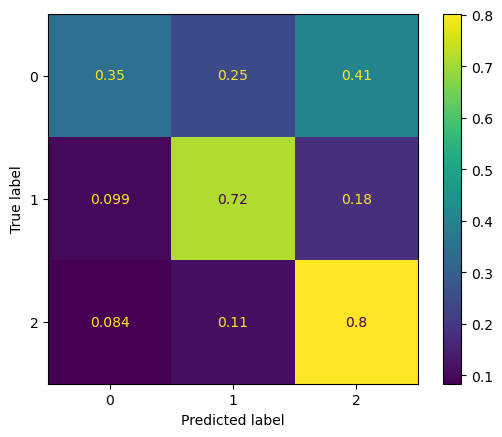

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.81it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.76715. Saving Model!
epoch 01, loss: 0.80248, acc: 0.62857, val_loss: 0.76715, val_accuracy: 0.62093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 02, loss: 0.79320, acc: 0.63042, val_loss: 0.77628, val_accuracy: 0.61835


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 03, loss: 0.78768, acc: 0.63297, val_loss: 0.77957, val_accuracy: 0.62004


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 04, loss: 0.78355, acc: 0.63301, val_loss: 0.78206, val_accuracy: 0.61925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 05, loss: 0.78028, acc: 0.63607, val_loss: 0.78490, val_accuracy: 0.61865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 06, loss: 0.77803, acc: 0.63686, val_loss: 0.78717, val_accuracy: 0.61895


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 07, loss: 0.77702, acc: 0.63776, val_loss: 0.78882, val_accuracy: 0.61944


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 08, loss: 0.77541, acc: 0.63959, val_loss: 0.79089, val_accuracy: 0.61925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 09, loss: 0.77504, acc: 0.63958, val_loss: 0.79250, val_accuracy: 0.62014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 10, loss: 0.77341, acc: 0.64394, val_loss: 0.79403, val_accuracy: 0.62063


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 11, loss: 0.77410, acc: 0.64192, val_loss: 0.79568, val_accuracy: 0.62202


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 12, loss: 0.77223, acc: 0.64396, val_loss: 0.79659, val_accuracy: 0.62173


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


epoch 13, loss: 0.77244, acc: 0.64010, val_loss: 0.79789, val_accuracy: 0.62431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 14, loss: 0.77086, acc: 0.64530, val_loss: 0.79898, val_accuracy: 0.62192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 15, loss: 0.77071, acc: 0.64246, val_loss: 0.80126, val_accuracy: 0.62391


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 16, loss: 0.76981, acc: 0.64453, val_loss: 0.80130, val_accuracy: 0.62222


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 17, loss: 0.76803, acc: 0.64347, val_loss: 0.80346, val_accuracy: 0.62460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 18, loss: 0.76776, acc: 0.64566, val_loss: 0.80411, val_accuracy: 0.62321


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 19, loss: 0.76541, acc: 0.64409, val_loss: 0.80645, val_accuracy: 0.62460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 20, loss: 0.76567, acc: 0.64784, val_loss: 0.80610, val_accuracy: 0.62401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 21, loss: 0.76264, acc: 0.64505, val_loss: 0.80799, val_accuracy: 0.62649


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 22, loss: 0.76293, acc: 0.64996, val_loss: 0.80762, val_accuracy: 0.62470


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 23, loss: 0.76110, acc: 0.64517, val_loss: 0.81085, val_accuracy: 0.62679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 24, loss: 0.76101, acc: 0.64799, val_loss: 0.81049, val_accuracy: 0.62560


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 25, loss: 0.75993, acc: 0.64656, val_loss: 0.81184, val_accuracy: 0.62708


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 26, loss: 0.75902, acc: 0.64878, val_loss: 0.81311, val_accuracy: 0.62569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 27, loss: 0.75856, acc: 0.64646, val_loss: 0.81469, val_accuracy: 0.62679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 28, loss: 0.75769, acc: 0.64874, val_loss: 0.81569, val_accuracy: 0.62679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 29, loss: 0.75673, acc: 0.64742, val_loss: 0.81774, val_accuracy: 0.62768


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 30, loss: 0.75575, acc: 0.64965, val_loss: 0.81725, val_accuracy: 0.62679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 31, loss: 0.75550, acc: 0.64716, val_loss: 0.81982, val_accuracy: 0.62877


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 32, loss: 0.75382, acc: 0.65029, val_loss: 0.81954, val_accuracy: 0.62619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 33, loss: 0.75280, acc: 0.64842, val_loss: 0.82303, val_accuracy: 0.63046


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 34, loss: 0.75157, acc: 0.65109, val_loss: 0.82188, val_accuracy: 0.62698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 35, loss: 0.75142, acc: 0.64648, val_loss: 0.82418, val_accuracy: 0.63065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 36, loss: 0.74976, acc: 0.65138, val_loss: 0.82443, val_accuracy: 0.62837


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.33it/s]


epoch 37, loss: 0.74962, acc: 0.64781, val_loss: 0.82601, val_accuracy: 0.62937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 38, loss: 0.74772, acc: 0.65201, val_loss: 0.82596, val_accuracy: 0.62867


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 39, loss: 0.74777, acc: 0.64925, val_loss: 0.82807, val_accuracy: 0.63155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 40, loss: 0.74606, acc: 0.65255, val_loss: 0.82842, val_accuracy: 0.62986


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


epoch 41, loss: 0.74697, acc: 0.65001, val_loss: 0.83131, val_accuracy: 0.63056


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 42, loss: 0.74503, acc: 0.65462, val_loss: 0.82980, val_accuracy: 0.63214


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 43, loss: 0.74539, acc: 0.65145, val_loss: 0.83341, val_accuracy: 0.62073


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 44, loss: 0.74371, acc: 0.65379, val_loss: 0.83298, val_accuracy: 0.62143


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 45, loss: 0.74347, acc: 0.65171, val_loss: 0.83471, val_accuracy: 0.62262


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 46, loss: 0.74237, acc: 0.65429, val_loss: 0.83467, val_accuracy: 0.62153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 47, loss: 0.74183, acc: 0.65161, val_loss: 0.83674, val_accuracy: 0.62391


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.28it/s]


epoch 48, loss: 0.74054, acc: 0.65467, val_loss: 0.83596, val_accuracy: 0.62113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


epoch 49, loss: 0.74051, acc: 0.65413, val_loss: 0.84015, val_accuracy: 0.62440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.37it/s]


epoch 50, loss: 0.73919, acc: 0.65516, val_loss: 0.83864, val_accuracy: 0.62480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 51, loss: 0.73793, acc: 0.65267, val_loss: 0.84002, val_accuracy: 0.62540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 52, loss: 0.73756, acc: 0.65447, val_loss: 0.84141, val_accuracy: 0.62450


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 53, loss: 0.73651, acc: 0.65363, val_loss: 0.84164, val_accuracy: 0.62669


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 54, loss: 0.73607, acc: 0.65574, val_loss: 0.84213, val_accuracy: 0.62649


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 55, loss: 0.73444, acc: 0.65413, val_loss: 0.84493, val_accuracy: 0.62669


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 56, loss: 0.73361, acc: 0.65667, val_loss: 0.84332, val_accuracy: 0.62649


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 57, loss: 0.73302, acc: 0.65661, val_loss: 0.84646, val_accuracy: 0.62837


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 58, loss: 0.73212, acc: 0.65722, val_loss: 0.84599, val_accuracy: 0.62738


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 59, loss: 0.73081, acc: 0.65710, val_loss: 0.84947, val_accuracy: 0.62748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 60, loss: 0.73045, acc: 0.65960, val_loss: 0.84882, val_accuracy: 0.62857


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 61, loss: 0.73022, acc: 0.65644, val_loss: 0.84957, val_accuracy: 0.62510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 62, loss: 0.72874, acc: 0.65869, val_loss: 0.84933, val_accuracy: 0.62768


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 63, loss: 0.72856, acc: 0.65820, val_loss: 0.85360, val_accuracy: 0.62063


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 64, loss: 0.72741, acc: 0.66097, val_loss: 0.85173, val_accuracy: 0.62817


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 65, loss: 0.72703, acc: 0.65834, val_loss: 0.85398, val_accuracy: 0.61508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 66, loss: 0.72586, acc: 0.66274, val_loss: 0.85367, val_accuracy: 0.62927


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 67, loss: 0.72532, acc: 0.65926, val_loss: 0.85862, val_accuracy: 0.61528


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 68, loss: 0.72484, acc: 0.66217, val_loss: 0.85621, val_accuracy: 0.62212


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 69, loss: 0.72341, acc: 0.65955, val_loss: 0.85790, val_accuracy: 0.61687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 70, loss: 0.72390, acc: 0.66293, val_loss: 0.85838, val_accuracy: 0.61617


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 71, loss: 0.72232, acc: 0.65909, val_loss: 0.86151, val_accuracy: 0.61577


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 72, loss: 0.72143, acc: 0.66295, val_loss: 0.85931, val_accuracy: 0.61865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 73, loss: 0.72098, acc: 0.66003, val_loss: 0.86250, val_accuracy: 0.61647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 74, loss: 0.71922, acc: 0.66355, val_loss: 0.86228, val_accuracy: 0.61726


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 75, loss: 0.71880, acc: 0.66075, val_loss: 0.86404, val_accuracy: 0.61786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 76, loss: 0.71811, acc: 0.66323, val_loss: 0.86410, val_accuracy: 0.61865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


epoch 77, loss: 0.71750, acc: 0.66291, val_loss: 0.86807, val_accuracy: 0.61796


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 78, loss: 0.71610, acc: 0.66383, val_loss: 0.86507, val_accuracy: 0.61895


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 79, loss: 0.71687, acc: 0.66239, val_loss: 0.86861, val_accuracy: 0.61875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 80, loss: 0.71460, acc: 0.66609, val_loss: 0.86717, val_accuracy: 0.61885


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 81, loss: 0.71551, acc: 0.66262, val_loss: 0.87184, val_accuracy: 0.61855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


epoch 82, loss: 0.71372, acc: 0.66921, val_loss: 0.87021, val_accuracy: 0.61984


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 83, loss: 0.71358, acc: 0.66656, val_loss: 0.87303, val_accuracy: 0.61845


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 84, loss: 0.71265, acc: 0.67034, val_loss: 0.87198, val_accuracy: 0.61885


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 85, loss: 0.71192, acc: 0.66495, val_loss: 0.87489, val_accuracy: 0.60179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 86, loss: 0.71164, acc: 0.67080, val_loss: 0.87448, val_accuracy: 0.60337


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 87, loss: 0.70990, acc: 0.66804, val_loss: 0.87852, val_accuracy: 0.60169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 88, loss: 0.70974, acc: 0.67133, val_loss: 0.87648, val_accuracy: 0.60278


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 89, loss: 0.70743, acc: 0.66868, val_loss: 0.87835, val_accuracy: 0.60179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 90, loss: 0.70785, acc: 0.67140, val_loss: 0.87822, val_accuracy: 0.60347


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 91, loss: 0.70587, acc: 0.66886, val_loss: 0.88343, val_accuracy: 0.60218


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 92, loss: 0.70551, acc: 0.67153, val_loss: 0.88132, val_accuracy: 0.60347


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 93, loss: 0.70392, acc: 0.67034, val_loss: 0.88307, val_accuracy: 0.60228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 94, loss: 0.70459, acc: 0.67090, val_loss: 0.88274, val_accuracy: 0.60437


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 95, loss: 0.70266, acc: 0.67027, val_loss: 0.88578, val_accuracy: 0.59990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 96, loss: 0.70315, acc: 0.67098, val_loss: 0.88380, val_accuracy: 0.60446


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 97, loss: 0.70125, acc: 0.67013, val_loss: 0.88841, val_accuracy: 0.59821


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 98, loss: 0.70173, acc: 0.67219, val_loss: 0.88702, val_accuracy: 0.59950


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 99, loss: 0.70031, acc: 0.67012, val_loss: 0.89149, val_accuracy: 0.59742


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 100, loss: 0.70003, acc: 0.67919, val_loss: 0.88787, val_accuracy: 0.60575


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 101, loss: 0.69838, acc: 0.67066, val_loss: 0.89294, val_accuracy: 0.59960


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 102, loss: 0.69887, acc: 0.67898, val_loss: 0.89106, val_accuracy: 0.59980


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 103, loss: 0.69645, acc: 0.67220, val_loss: 0.89532, val_accuracy: 0.59950


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 104, loss: 0.69735, acc: 0.68050, val_loss: 0.89236, val_accuracy: 0.60060


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 105, loss: 0.69519, acc: 0.67303, val_loss: 0.89737, val_accuracy: 0.60030


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 106, loss: 0.69589, acc: 0.68116, val_loss: 0.89582, val_accuracy: 0.60119


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 107, loss: 0.69291, acc: 0.67712, val_loss: 0.89918, val_accuracy: 0.60079


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 108, loss: 0.69404, acc: 0.68266, val_loss: 0.89784, val_accuracy: 0.60288


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 109, loss: 0.69206, acc: 0.67869, val_loss: 0.90149, val_accuracy: 0.60169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 110, loss: 0.69247, acc: 0.68258, val_loss: 0.89900, val_accuracy: 0.60327


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 111, loss: 0.69031, acc: 0.67891, val_loss: 0.90552, val_accuracy: 0.60218


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 112, loss: 0.69129, acc: 0.68381, val_loss: 0.89960, val_accuracy: 0.60198


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 113, loss: 0.68968, acc: 0.68031, val_loss: 0.90648, val_accuracy: 0.60198


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.31it/s]


epoch 114, loss: 0.68970, acc: 0.68563, val_loss: 0.90527, val_accuracy: 0.60099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


epoch 115, loss: 0.68783, acc: 0.68097, val_loss: 0.90908, val_accuracy: 0.60238


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 116, loss: 0.68834, acc: 0.68459, val_loss: 0.90509, val_accuracy: 0.60208


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


epoch 117, loss: 0.68647, acc: 0.68247, val_loss: 0.90973, val_accuracy: 0.60288


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 118, loss: 0.68625, acc: 0.68849, val_loss: 0.90970, val_accuracy: 0.58948


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 119, loss: 0.68437, acc: 0.68576, val_loss: 0.91409, val_accuracy: 0.59147


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 120, loss: 0.68498, acc: 0.68719, val_loss: 0.91071, val_accuracy: 0.60397


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 121, loss: 0.68301, acc: 0.68681, val_loss: 0.91612, val_accuracy: 0.60486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 122, loss: 0.68384, acc: 0.68900, val_loss: 0.91428, val_accuracy: 0.60288


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 123, loss: 0.68183, acc: 0.68516, val_loss: 0.91798, val_accuracy: 0.60397


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 124, loss: 0.68215, acc: 0.69009, val_loss: 0.91509, val_accuracy: 0.59097


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 125, loss: 0.68020, acc: 0.68705, val_loss: 0.92048, val_accuracy: 0.60575


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 126, loss: 0.68059, acc: 0.69040, val_loss: 0.91654, val_accuracy: 0.60556


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 127, loss: 0.67893, acc: 0.68899, val_loss: 0.92081, val_accuracy: 0.60575


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 128, loss: 0.67861, acc: 0.69034, val_loss: 0.91892, val_accuracy: 0.60526


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


epoch 129, loss: 0.67695, acc: 0.69003, val_loss: 0.92537, val_accuracy: 0.60754


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.21it/s]


epoch 130, loss: 0.67755, acc: 0.69141, val_loss: 0.92101, val_accuracy: 0.60774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.24it/s]


epoch 131, loss: 0.67543, acc: 0.69125, val_loss: 0.92683, val_accuracy: 0.59593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.48it/s]


epoch 132, loss: 0.67631, acc: 0.69080, val_loss: 0.92111, val_accuracy: 0.60734


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 133, loss: 0.67418, acc: 0.69130, val_loss: 0.92826, val_accuracy: 0.59514


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.80it/s]


epoch 134, loss: 0.67422, acc: 0.69212, val_loss: 0.92679, val_accuracy: 0.59524


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.15it/s]


epoch 135, loss: 0.67315, acc: 0.69031, val_loss: 0.92908, val_accuracy: 0.59573


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 136, loss: 0.67300, acc: 0.69210, val_loss: 0.92717, val_accuracy: 0.59514


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]


epoch 137, loss: 0.67171, acc: 0.69152, val_loss: 0.93359, val_accuracy: 0.59554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 138, loss: 0.67115, acc: 0.69510, val_loss: 0.93013, val_accuracy: 0.59623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]


epoch 139, loss: 0.66943, acc: 0.69279, val_loss: 0.93151, val_accuracy: 0.60962


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.68it/s]


epoch 140, loss: 0.66924, acc: 0.69376, val_loss: 0.93111, val_accuracy: 0.59772


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 141, loss: 0.66803, acc: 0.69507, val_loss: 0.93453, val_accuracy: 0.59593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]


epoch 142, loss: 0.66862, acc: 0.69459, val_loss: 0.93285, val_accuracy: 0.59702


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


epoch 143, loss: 0.66691, acc: 0.69463, val_loss: 0.94026, val_accuracy: 0.59742


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.56it/s]


epoch 144, loss: 0.66618, acc: 0.69506, val_loss: 0.93486, val_accuracy: 0.59792


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 145, loss: 0.66646, acc: 0.69335, val_loss: 0.94085, val_accuracy: 0.59702


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.07it/s]


epoch 146, loss: 0.66538, acc: 0.69732, val_loss: 0.93760, val_accuracy: 0.59861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 147, loss: 0.66432, acc: 0.69462, val_loss: 0.94349, val_accuracy: 0.59802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 148, loss: 0.66514, acc: 0.69547, val_loss: 0.93923, val_accuracy: 0.60079


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 149, loss: 0.66303, acc: 0.69432, val_loss: 0.94309, val_accuracy: 0.59782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


epoch 150, loss: 0.66300, acc: 0.69850, val_loss: 0.94364, val_accuracy: 0.60119


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.56it/s]


epoch 151, loss: 0.66194, acc: 0.69620, val_loss: 0.94362, val_accuracy: 0.61032


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.64it/s]


epoch 152, loss: 0.66135, acc: 0.70159, val_loss: 0.94302, val_accuracy: 0.60040


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.14it/s]


epoch 153, loss: 0.65960, acc: 0.69714, val_loss: 0.95050, val_accuracy: 0.58323


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 154, loss: 0.65958, acc: 0.70141, val_loss: 0.94370, val_accuracy: 0.59980


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 155, loss: 0.65783, acc: 0.69783, val_loss: 0.95060, val_accuracy: 0.59861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 156, loss: 0.65756, acc: 0.70303, val_loss: 0.94739, val_accuracy: 0.60198


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


epoch 157, loss: 0.65676, acc: 0.69854, val_loss: 0.95386, val_accuracy: 0.58363


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.03it/s]


epoch 158, loss: 0.65624, acc: 0.70455, val_loss: 0.95451, val_accuracy: 0.58472


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.30it/s]


epoch 159, loss: 0.65717, acc: 0.69794, val_loss: 0.95407, val_accuracy: 0.58383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]


epoch 160, loss: 0.65486, acc: 0.70368, val_loss: 0.95219, val_accuracy: 0.58393


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 161, loss: 0.65565, acc: 0.70019, val_loss: 0.95755, val_accuracy: 0.58383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.14it/s]


epoch 162, loss: 0.65387, acc: 0.70384, val_loss: 0.95355, val_accuracy: 0.60298


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.73it/s]


epoch 163, loss: 0.65387, acc: 0.70010, val_loss: 0.96105, val_accuracy: 0.58433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]


epoch 164, loss: 0.65291, acc: 0.70404, val_loss: 0.95624, val_accuracy: 0.58730


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]


epoch 165, loss: 0.65152, acc: 0.70092, val_loss: 0.96049, val_accuracy: 0.58433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 166, loss: 0.65084, acc: 0.70546, val_loss: 0.95891, val_accuracy: 0.58750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.83it/s]


epoch 167, loss: 0.65127, acc: 0.70010, val_loss: 0.96242, val_accuracy: 0.58552


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


epoch 168, loss: 0.64966, acc: 0.70498, val_loss: 0.96080, val_accuracy: 0.60496


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.09it/s]


epoch 169, loss: 0.64928, acc: 0.70168, val_loss: 0.96428, val_accuracy: 0.58671


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.23it/s]


epoch 170, loss: 0.64897, acc: 0.70619, val_loss: 0.96323, val_accuracy: 0.58899


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.65it/s]


epoch 171, loss: 0.64773, acc: 0.70250, val_loss: 0.96956, val_accuracy: 0.58581


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]


epoch 172, loss: 0.64705, acc: 0.70693, val_loss: 0.96522, val_accuracy: 0.58740


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.98it/s]


epoch 173, loss: 0.64511, acc: 0.70288, val_loss: 0.97038, val_accuracy: 0.58542


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 174, loss: 0.64590, acc: 0.70751, val_loss: 0.96687, val_accuracy: 0.59097


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]


epoch 175, loss: 0.64469, acc: 0.70350, val_loss: 0.97091, val_accuracy: 0.58671


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 176, loss: 0.64280, acc: 0.70670, val_loss: 0.96916, val_accuracy: 0.58899


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 177, loss: 0.64336, acc: 0.70431, val_loss: 0.97045, val_accuracy: 0.58611


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 178, loss: 0.64189, acc: 0.70962, val_loss: 0.96837, val_accuracy: 0.60437


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 179, loss: 0.64187, acc: 0.70536, val_loss: 0.97438, val_accuracy: 0.58948


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


epoch 180, loss: 0.64084, acc: 0.71061, val_loss: 0.97265, val_accuracy: 0.59117


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.19it/s]


epoch 181, loss: 0.63932, acc: 0.70566, val_loss: 0.97865, val_accuracy: 0.58829


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


epoch 182, loss: 0.63903, acc: 0.71014, val_loss: 0.97307, val_accuracy: 0.60288


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 183, loss: 0.63927, acc: 0.70820, val_loss: 0.97883, val_accuracy: 0.58919


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]


epoch 184, loss: 0.63775, acc: 0.71209, val_loss: 0.97352, val_accuracy: 0.60417


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.27it/s]


epoch 185, loss: 0.63775, acc: 0.70643, val_loss: 0.98333, val_accuracy: 0.59177


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.43it/s]


epoch 186, loss: 0.63698, acc: 0.71115, val_loss: 0.98153, val_accuracy: 0.60347


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]


epoch 187, loss: 0.63763, acc: 0.70538, val_loss: 0.98233, val_accuracy: 0.58988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 188, loss: 0.63549, acc: 0.70815, val_loss: 0.97951, val_accuracy: 0.60546


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


epoch 189, loss: 0.63565, acc: 0.70762, val_loss: 0.98604, val_accuracy: 0.58998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 190, loss: 0.63623, acc: 0.71088, val_loss: 0.98274, val_accuracy: 0.60575


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 191, loss: 0.63385, acc: 0.70743, val_loss: 0.99054, val_accuracy: 0.59375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


epoch 192, loss: 0.63330, acc: 0.71191, val_loss: 0.98254, val_accuracy: 0.60565


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 193, loss: 0.63352, acc: 0.70685, val_loss: 0.99356, val_accuracy: 0.59365


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 194, loss: 0.63229, acc: 0.71486, val_loss: 0.98558, val_accuracy: 0.60516


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 195, loss: 0.63264, acc: 0.70783, val_loss: 0.99222, val_accuracy: 0.59077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 196, loss: 0.63052, acc: 0.71349, val_loss: 0.99034, val_accuracy: 0.60526


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 197, loss: 0.63159, acc: 0.70693, val_loss: 0.99138, val_accuracy: 0.59375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 198, loss: 0.63020, acc: 0.71421, val_loss: 0.99067, val_accuracy: 0.60605


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 199, loss: 0.63050, acc: 0.70872, val_loss: 0.99959, val_accuracy: 0.59385


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 200, loss: 0.62869, acc: 0.71269, val_loss: 0.99179, val_accuracy: 0.60546


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 201, loss: 0.62765, acc: 0.71003, val_loss: 0.99852, val_accuracy: 0.59345


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 202, loss: 0.62726, acc: 0.71587, val_loss: 0.99864, val_accuracy: 0.60724


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 203, loss: 0.62706, acc: 0.71016, val_loss: 0.99858, val_accuracy: 0.60565


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.10it/s]


epoch 204, loss: 0.62572, acc: 0.71689, val_loss: 1.00236, val_accuracy: 0.60585


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 205, loss: 0.62324, acc: 0.71404, val_loss: 1.00100, val_accuracy: 0.59484


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.64it/s]


epoch 206, loss: 0.62495, acc: 0.71272, val_loss: 0.99997, val_accuracy: 0.59494


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.14it/s]


epoch 207, loss: 0.62313, acc: 0.71309, val_loss: 1.00082, val_accuracy: 0.60655


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.04it/s]


epoch 208, loss: 0.62141, acc: 0.72012, val_loss: 1.00431, val_accuracy: 0.60853


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.25it/s]


epoch 209, loss: 0.62093, acc: 0.71389, val_loss: 1.00466, val_accuracy: 0.59573


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.53it/s]


epoch 210, loss: 0.62033, acc: 0.72057, val_loss: 1.00760, val_accuracy: 0.60774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 211, loss: 0.61921, acc: 0.71664, val_loss: 1.00661, val_accuracy: 0.60714


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 212, loss: 0.61782, acc: 0.71998, val_loss: 1.01106, val_accuracy: 0.60804


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 213, loss: 0.61710, acc: 0.71738, val_loss: 1.01700, val_accuracy: 0.59663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 214, loss: 0.61668, acc: 0.71990, val_loss: 1.01049, val_accuracy: 0.59653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 215, loss: 0.61556, acc: 0.71787, val_loss: 1.01149, val_accuracy: 0.60952


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 216, loss: 0.61492, acc: 0.72437, val_loss: 1.01725, val_accuracy: 0.61101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 217, loss: 0.61402, acc: 0.72005, val_loss: 1.02237, val_accuracy: 0.61052


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.74it/s]


epoch 218, loss: 0.61295, acc: 0.72480, val_loss: 1.01998, val_accuracy: 0.59782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.80it/s]


epoch 219, loss: 0.61231, acc: 0.72109, val_loss: 1.02494, val_accuracy: 0.60913


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.78it/s]


epoch 220, loss: 0.61165, acc: 0.72593, val_loss: 1.02305, val_accuracy: 0.59663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 221, loss: 0.61159, acc: 0.72394, val_loss: 1.02200, val_accuracy: 0.60972


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.74it/s]


epoch 222, loss: 0.61002, acc: 0.72435, val_loss: 1.02648, val_accuracy: 0.61171


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.31it/s]


epoch 223, loss: 0.61024, acc: 0.72518, val_loss: 1.03042, val_accuracy: 0.61111


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.09it/s]


epoch 224, loss: 0.60946, acc: 0.72436, val_loss: 1.02237, val_accuracy: 0.61012


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.14it/s]


epoch 225, loss: 0.60923, acc: 0.72424, val_loss: 1.02903, val_accuracy: 0.61379


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.52it/s]


epoch 226, loss: 0.60821, acc: 0.72284, val_loss: 1.03417, val_accuracy: 0.61319


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 227, loss: 0.60842, acc: 0.72393, val_loss: 1.03162, val_accuracy: 0.61071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 228, loss: 0.60764, acc: 0.72577, val_loss: 1.03277, val_accuracy: 0.61319


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 229, loss: 0.60750, acc: 0.72467, val_loss: 1.03765, val_accuracy: 0.61250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 230, loss: 0.60594, acc: 0.72596, val_loss: 1.03184, val_accuracy: 0.61369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 231, loss: 0.60656, acc: 0.72540, val_loss: 1.03769, val_accuracy: 0.61300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.99it/s]


epoch 232, loss: 0.60467, acc: 0.72847, val_loss: 1.03949, val_accuracy: 0.61230


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.00it/s]


epoch 233, loss: 0.60504, acc: 0.72658, val_loss: 1.04301, val_accuracy: 0.61349


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 234, loss: 0.60470, acc: 0.72882, val_loss: 1.03532, val_accuracy: 0.61329


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.55it/s]


epoch 235, loss: 0.60363, acc: 0.72673, val_loss: 1.04638, val_accuracy: 0.60179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.76it/s]


epoch 236, loss: 0.60281, acc: 0.72915, val_loss: 1.04014, val_accuracy: 0.61339


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.98it/s]


epoch 237, loss: 0.60207, acc: 0.72868, val_loss: 1.04918, val_accuracy: 0.61478


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 238, loss: 0.60175, acc: 0.73278, val_loss: 1.04460, val_accuracy: 0.61300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 239, loss: 0.60126, acc: 0.72931, val_loss: 1.04933, val_accuracy: 0.61280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 240, loss: 0.59975, acc: 0.73092, val_loss: 1.05156, val_accuracy: 0.61458


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 241, loss: 0.60004, acc: 0.73013, val_loss: 1.04796, val_accuracy: 0.61399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 242, loss: 0.59836, acc: 0.73384, val_loss: 1.05077, val_accuracy: 0.61518


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.10it/s]


epoch 243, loss: 0.59985, acc: 0.72836, val_loss: 1.05231, val_accuracy: 0.61627


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]


epoch 244, loss: 0.59667, acc: 0.73348, val_loss: 1.05707, val_accuracy: 0.61528


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 245, loss: 0.59838, acc: 0.73252, val_loss: 1.05657, val_accuracy: 0.61587


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]


epoch 246, loss: 0.59598, acc: 0.73454, val_loss: 1.05169, val_accuracy: 0.61478


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 247, loss: 0.59577, acc: 0.73278, val_loss: 1.05651, val_accuracy: 0.61597


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 248, loss: 0.59415, acc: 0.73738, val_loss: 1.05991, val_accuracy: 0.61508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 249, loss: 0.59474, acc: 0.73478, val_loss: 1.06165, val_accuracy: 0.61657


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 250, loss: 0.59329, acc: 0.73739, val_loss: 1.05837, val_accuracy: 0.61667


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


epoch 251, loss: 0.59289, acc: 0.73653, val_loss: 1.06142, val_accuracy: 0.61716


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 252, loss: 0.59215, acc: 0.73705, val_loss: 1.06596, val_accuracy: 0.59891


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 253, loss: 0.59181, acc: 0.73701, val_loss: 1.06806, val_accuracy: 0.61835


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.37it/s]


epoch 254, loss: 0.59014, acc: 0.73733, val_loss: 1.06332, val_accuracy: 0.61647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.29it/s]


epoch 255, loss: 0.59016, acc: 0.73844, val_loss: 1.06969, val_accuracy: 0.61855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.54it/s]


epoch 256, loss: 0.58915, acc: 0.73672, val_loss: 1.06353, val_accuracy: 0.61746


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 257, loss: 0.58871, acc: 0.73593, val_loss: 1.07323, val_accuracy: 0.62034


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 258, loss: 0.58780, acc: 0.73606, val_loss: 1.07193, val_accuracy: 0.60050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


epoch 259, loss: 0.58883, acc: 0.73690, val_loss: 1.07434, val_accuracy: 0.62034


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]


epoch 260, loss: 0.58602, acc: 0.74094, val_loss: 1.07864, val_accuracy: 0.60119


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.80it/s]


epoch 261, loss: 0.58763, acc: 0.74032, val_loss: 1.07273, val_accuracy: 0.62024


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 262, loss: 0.58585, acc: 0.73571, val_loss: 1.07547, val_accuracy: 0.60258


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 263, loss: 0.58437, acc: 0.74092, val_loss: 1.08213, val_accuracy: 0.62044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 264, loss: 0.58582, acc: 0.73806, val_loss: 1.07924, val_accuracy: 0.60298


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]


epoch 265, loss: 0.58260, acc: 0.74202, val_loss: 1.08903, val_accuracy: 0.62093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.67it/s]


epoch 266, loss: 0.58517, acc: 0.73888, val_loss: 1.07433, val_accuracy: 0.60258


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 267, loss: 0.58041, acc: 0.74368, val_loss: 1.08768, val_accuracy: 0.61954


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 268, loss: 0.58330, acc: 0.74243, val_loss: 1.08616, val_accuracy: 0.60377


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 269, loss: 0.57899, acc: 0.74280, val_loss: 1.09240, val_accuracy: 0.60357


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 270, loss: 0.58111, acc: 0.74034, val_loss: 1.08913, val_accuracy: 0.60337


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 271, loss: 0.57705, acc: 0.74429, val_loss: 1.09697, val_accuracy: 0.60536


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.84it/s]


epoch 272, loss: 0.58080, acc: 0.73867, val_loss: 1.08132, val_accuracy: 0.62093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]


epoch 273, loss: 0.57543, acc: 0.74473, val_loss: 1.09283, val_accuracy: 0.60536


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 274, loss: 0.57733, acc: 0.74242, val_loss: 1.09561, val_accuracy: 0.60446


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 275, loss: 0.57524, acc: 0.74484, val_loss: 1.09679, val_accuracy: 0.60387


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.76it/s]


epoch 276, loss: 0.57638, acc: 0.74285, val_loss: 1.09836, val_accuracy: 0.60486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.65it/s]


epoch 277, loss: 0.57346, acc: 0.74668, val_loss: 1.09540, val_accuracy: 0.60486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 278, loss: 0.57545, acc: 0.74112, val_loss: 1.10359, val_accuracy: 0.60605


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 279, loss: 0.57242, acc: 0.74659, val_loss: 1.10286, val_accuracy: 0.60427


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 280, loss: 0.57473, acc: 0.74262, val_loss: 1.10604, val_accuracy: 0.60585


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]


epoch 281, loss: 0.57193, acc: 0.74644, val_loss: 1.09990, val_accuracy: 0.60387


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 282, loss: 0.57289, acc: 0.74365, val_loss: 1.11280, val_accuracy: 0.60595


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.61it/s]


epoch 283, loss: 0.57131, acc: 0.74758, val_loss: 1.09704, val_accuracy: 0.60466


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.90it/s]


epoch 284, loss: 0.57169, acc: 0.74188, val_loss: 1.11122, val_accuracy: 0.60536


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 285, loss: 0.57042, acc: 0.74896, val_loss: 1.10142, val_accuracy: 0.60565


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 286, loss: 0.56988, acc: 0.74330, val_loss: 1.11749, val_accuracy: 0.60694


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 287, loss: 0.56965, acc: 0.74867, val_loss: 1.10628, val_accuracy: 0.60694


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.59it/s]


epoch 288, loss: 0.56866, acc: 0.74683, val_loss: 1.12249, val_accuracy: 0.60744


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.95it/s]


epoch 289, loss: 0.56921, acc: 0.74937, val_loss: 1.10377, val_accuracy: 0.60655


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]


epoch 290, loss: 0.56860, acc: 0.74576, val_loss: 1.11925, val_accuracy: 0.60992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 291, loss: 0.56707, acc: 0.74900, val_loss: 1.11527, val_accuracy: 0.60635


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 292, loss: 0.56851, acc: 0.74449, val_loss: 1.12327, val_accuracy: 0.61071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.38it/s]


epoch 293, loss: 0.56526, acc: 0.75059, val_loss: 1.12000, val_accuracy: 0.60694


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.27it/s]


epoch 294, loss: 0.56847, acc: 0.74607, val_loss: 1.11994, val_accuracy: 0.60883


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 295, loss: 0.56429, acc: 0.75148, val_loss: 1.11679, val_accuracy: 0.60764


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]


epoch 296, loss: 0.56679, acc: 0.74555, val_loss: 1.12788, val_accuracy: 0.60694


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.98it/s]


epoch 297, loss: 0.56287, acc: 0.75341, val_loss: 1.12437, val_accuracy: 0.60962


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 298, loss: 0.56506, acc: 0.74525, val_loss: 1.13064, val_accuracy: 0.60883


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 299, loss: 0.56157, acc: 0.75187, val_loss: 1.13153, val_accuracy: 0.60893


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 300, loss: 0.56381, acc: 0.74928, val_loss: 1.12372, val_accuracy: 0.60893


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]


epoch 301, loss: 0.56029, acc: 0.75440, val_loss: 1.12874, val_accuracy: 0.60784


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 302, loss: 0.56116, acc: 0.75215, val_loss: 1.13531, val_accuracy: 0.61052


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.03it/s]


epoch 303, loss: 0.55974, acc: 0.75262, val_loss: 1.12929, val_accuracy: 0.60764


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 304, loss: 0.56052, acc: 0.75088, val_loss: 1.13459, val_accuracy: 0.60972


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 305, loss: 0.55837, acc: 0.75384, val_loss: 1.13044, val_accuracy: 0.60675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 306, loss: 0.55882, acc: 0.75529, val_loss: 1.14268, val_accuracy: 0.61220


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20it/s]


epoch 307, loss: 0.55882, acc: 0.75360, val_loss: 1.13064, val_accuracy: 0.60893


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.32it/s]


epoch 308, loss: 0.55733, acc: 0.75083, val_loss: 1.14908, val_accuracy: 0.61260


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 309, loss: 0.55769, acc: 0.75485, val_loss: 1.13689, val_accuracy: 0.60913


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 310, loss: 0.55611, acc: 0.75642, val_loss: 1.14581, val_accuracy: 0.61300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 311, loss: 0.55673, acc: 0.75528, val_loss: 1.14002, val_accuracy: 0.60863


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


epoch 312, loss: 0.55569, acc: 0.75648, val_loss: 1.14396, val_accuracy: 0.61310


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 313, loss: 0.55465, acc: 0.75605, val_loss: 1.13886, val_accuracy: 0.60952


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 314, loss: 0.55575, acc: 0.75521, val_loss: 1.14530, val_accuracy: 0.61081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.84it/s]


epoch 315, loss: 0.55149, acc: 0.75956, val_loss: 1.14775, val_accuracy: 0.61091


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.29it/s]


epoch 316, loss: 0.55473, acc: 0.75814, val_loss: 1.15327, val_accuracy: 0.59563


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


epoch 317, loss: 0.55119, acc: 0.75667, val_loss: 1.15097, val_accuracy: 0.61091


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 318, loss: 0.55300, acc: 0.75992, val_loss: 1.15594, val_accuracy: 0.59583


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.19it/s]


epoch 319, loss: 0.55070, acc: 0.75785, val_loss: 1.15732, val_accuracy: 0.59405


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 320, loss: 0.55294, acc: 0.75684, val_loss: 1.15932, val_accuracy: 0.59613


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66it/s]


epoch 321, loss: 0.55050, acc: 0.75694, val_loss: 1.16075, val_accuracy: 0.59296


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 322, loss: 0.55149, acc: 0.76029, val_loss: 1.15476, val_accuracy: 0.59802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 323, loss: 0.55011, acc: 0.75773, val_loss: 1.15544, val_accuracy: 0.61220


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.71it/s]


epoch 324, loss: 0.55176, acc: 0.75827, val_loss: 1.16939, val_accuracy: 0.59762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]


epoch 325, loss: 0.54904, acc: 0.75781, val_loss: 1.15680, val_accuracy: 0.59355


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.77it/s]


epoch 326, loss: 0.54977, acc: 0.76152, val_loss: 1.18000, val_accuracy: 0.59683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.73it/s]


epoch 327, loss: 0.54845, acc: 0.76009, val_loss: 1.15513, val_accuracy: 0.59504


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 328, loss: 0.54920, acc: 0.75852, val_loss: 1.17623, val_accuracy: 0.59702


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.66it/s]


epoch 329, loss: 0.54573, acc: 0.76421, val_loss: 1.16312, val_accuracy: 0.59504


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.72it/s]


epoch 330, loss: 0.54862, acc: 0.75711, val_loss: 1.17992, val_accuracy: 0.59762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 331, loss: 0.54551, acc: 0.76495, val_loss: 1.16778, val_accuracy: 0.59673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.77it/s]


epoch 332, loss: 0.54795, acc: 0.75688, val_loss: 1.17594, val_accuracy: 0.59732


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.03it/s]


epoch 333, loss: 0.54276, acc: 0.76581, val_loss: 1.17993, val_accuracy: 0.59583


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 334, loss: 0.54804, acc: 0.76010, val_loss: 1.17014, val_accuracy: 0.59861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 335, loss: 0.54206, acc: 0.76686, val_loss: 1.17783, val_accuracy: 0.59673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.64it/s]


epoch 336, loss: 0.54739, acc: 0.75820, val_loss: 1.17709, val_accuracy: 0.59772


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.50it/s]


epoch 337, loss: 0.54095, acc: 0.76625, val_loss: 1.18285, val_accuracy: 0.59563


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 338, loss: 0.54593, acc: 0.76343, val_loss: 1.18466, val_accuracy: 0.59871


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 339, loss: 0.54001, acc: 0.76268, val_loss: 1.18092, val_accuracy: 0.59554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


epoch 340, loss: 0.54460, acc: 0.76374, val_loss: 1.18197, val_accuracy: 0.59593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.91it/s]


epoch 341, loss: 0.53944, acc: 0.76381, val_loss: 1.18043, val_accuracy: 0.59613


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.44it/s]


epoch 342, loss: 0.54282, acc: 0.76421, val_loss: 1.19124, val_accuracy: 0.59762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]


epoch 343, loss: 0.54019, acc: 0.76467, val_loss: 1.17837, val_accuracy: 0.59623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 344, loss: 0.54153, acc: 0.76567, val_loss: 1.19652, val_accuracy: 0.59861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 345, loss: 0.53907, acc: 0.76353, val_loss: 1.18647, val_accuracy: 0.59712


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 346, loss: 0.54272, acc: 0.75933, val_loss: 1.19556, val_accuracy: 0.59931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.78it/s]


epoch 347, loss: 0.53682, acc: 0.76753, val_loss: 1.18478, val_accuracy: 0.59583


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.76it/s]


epoch 348, loss: 0.54123, acc: 0.76130, val_loss: 1.19235, val_accuracy: 0.60069


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 349, loss: 0.53687, acc: 0.76882, val_loss: 1.19282, val_accuracy: 0.59623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 350, loss: 0.54021, acc: 0.76237, val_loss: 1.20518, val_accuracy: 0.59812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 351, loss: 0.53620, acc: 0.77112, val_loss: 1.18950, val_accuracy: 0.59752


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 352, loss: 0.53914, acc: 0.76426, val_loss: 1.19906, val_accuracy: 0.60000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.92it/s]


epoch 353, loss: 0.53412, acc: 0.77162, val_loss: 1.19330, val_accuracy: 0.59702


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.47it/s]


epoch 354, loss: 0.53846, acc: 0.76497, val_loss: 1.19552, val_accuracy: 0.60139


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.91it/s]


epoch 355, loss: 0.53309, acc: 0.76953, val_loss: 1.20340, val_accuracy: 0.59702


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 356, loss: 0.53754, acc: 0.76588, val_loss: 1.19522, val_accuracy: 0.60179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 357, loss: 0.53225, acc: 0.77034, val_loss: 1.20161, val_accuracy: 0.59683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 358, loss: 0.53590, acc: 0.76626, val_loss: 1.20944, val_accuracy: 0.60129


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 359, loss: 0.53108, acc: 0.77068, val_loss: 1.19253, val_accuracy: 0.59782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 360, loss: 0.53494, acc: 0.76934, val_loss: 1.21000, val_accuracy: 0.60030


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.77it/s]


epoch 361, loss: 0.53161, acc: 0.76881, val_loss: 1.20095, val_accuracy: 0.59702


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


epoch 362, loss: 0.53420, acc: 0.76537, val_loss: 1.21674, val_accuracy: 0.60208


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 363, loss: 0.53090, acc: 0.77106, val_loss: 1.20307, val_accuracy: 0.59732


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 364, loss: 0.53316, acc: 0.76558, val_loss: 1.21238, val_accuracy: 0.60000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 365, loss: 0.52886, acc: 0.77503, val_loss: 1.21148, val_accuracy: 0.59871


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.87it/s]


epoch 366, loss: 0.53335, acc: 0.76704, val_loss: 1.21328, val_accuracy: 0.60248


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.53it/s]


epoch 367, loss: 0.52758, acc: 0.77281, val_loss: 1.21029, val_accuracy: 0.59306


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.28it/s]


epoch 368, loss: 0.53329, acc: 0.76729, val_loss: 1.20709, val_accuracy: 0.60050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 369, loss: 0.52538, acc: 0.77494, val_loss: 1.22636, val_accuracy: 0.59980


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 370, loss: 0.53230, acc: 0.76915, val_loss: 1.20996, val_accuracy: 0.60109


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 371, loss: 0.52527, acc: 0.77258, val_loss: 1.21608, val_accuracy: 0.59931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.74it/s]


epoch 372, loss: 0.53006, acc: 0.77135, val_loss: 1.22043, val_accuracy: 0.60139


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 373, loss: 0.52584, acc: 0.77140, val_loss: 1.21853, val_accuracy: 0.59940


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 374, loss: 0.52758, acc: 0.77440, val_loss: 1.22654, val_accuracy: 0.59613


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 375, loss: 0.52530, acc: 0.77147, val_loss: 1.20683, val_accuracy: 0.60040


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.44it/s]


epoch 376, loss: 0.52755, acc: 0.77047, val_loss: 1.22824, val_accuracy: 0.60169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 377, loss: 0.52414, acc: 0.77650, val_loss: 1.22112, val_accuracy: 0.60050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]


epoch 378, loss: 0.52484, acc: 0.77031, val_loss: 1.23743, val_accuracy: 0.59444


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 379, loss: 0.52387, acc: 0.77603, val_loss: 1.21968, val_accuracy: 0.60089


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 380, loss: 0.52303, acc: 0.76973, val_loss: 1.24142, val_accuracy: 0.59613


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]


epoch 381, loss: 0.52305, acc: 0.77350, val_loss: 1.21541, val_accuracy: 0.60050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 382, loss: 0.52359, acc: 0.77298, val_loss: 1.24051, val_accuracy: 0.59573


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.03it/s]


epoch 383, loss: 0.52033, acc: 0.77763, val_loss: 1.22515, val_accuracy: 0.60327


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.89it/s]


epoch 384, loss: 0.52281, acc: 0.76844, val_loss: 1.23980, val_accuracy: 0.59752


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 385, loss: 0.52081, acc: 0.77542, val_loss: 1.23069, val_accuracy: 0.59633


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.78it/s]


epoch 386, loss: 0.52168, acc: 0.77285, val_loss: 1.23843, val_accuracy: 0.60546


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]


epoch 387, loss: 0.51897, acc: 0.77646, val_loss: 1.24282, val_accuracy: 0.59653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


epoch 388, loss: 0.52160, acc: 0.77430, val_loss: 1.24152, val_accuracy: 0.60377


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 389, loss: 0.51846, acc: 0.77721, val_loss: 1.23694, val_accuracy: 0.59653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 390, loss: 0.52042, acc: 0.76994, val_loss: 1.23905, val_accuracy: 0.59623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


epoch 391, loss: 0.51641, acc: 0.77840, val_loss: 1.24127, val_accuracy: 0.59762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 392, loss: 0.52047, acc: 0.76992, val_loss: 1.24480, val_accuracy: 0.60050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.95it/s]


epoch 393, loss: 0.51683, acc: 0.77624, val_loss: 1.23926, val_accuracy: 0.59782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.95it/s]


epoch 394, loss: 0.51879, acc: 0.77074, val_loss: 1.25035, val_accuracy: 0.59881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 395, loss: 0.51463, acc: 0.78042, val_loss: 1.24537, val_accuracy: 0.59772


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 396, loss: 0.51884, acc: 0.77223, val_loss: 1.25141, val_accuracy: 0.59960


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 397, loss: 0.51425, acc: 0.77790, val_loss: 1.24834, val_accuracy: 0.59782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.98it/s]


epoch 398, loss: 0.51741, acc: 0.77244, val_loss: 1.24433, val_accuracy: 0.60020


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.69it/s]


epoch 399, loss: 0.51250, acc: 0.77856, val_loss: 1.25250, val_accuracy: 0.59970


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]


epoch 400, loss: 0.51562, acc: 0.77548, val_loss: 1.25835, val_accuracy: 0.59921


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 401, loss: 0.51325, acc: 0.77590, val_loss: 1.25183, val_accuracy: 0.59861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 402, loss: 0.51493, acc: 0.77747, val_loss: 1.26153, val_accuracy: 0.59980


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 403, loss: 0.51247, acc: 0.77461, val_loss: 1.25313, val_accuracy: 0.59802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 404, loss: 0.51306, acc: 0.77832, val_loss: 1.25990, val_accuracy: 0.59980


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.20it/s]


epoch 405, loss: 0.51204, acc: 0.77926, val_loss: 1.24851, val_accuracy: 0.60099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]


epoch 406, loss: 0.51184, acc: 0.77395, val_loss: 1.26136, val_accuracy: 0.60139


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 407, loss: 0.50969, acc: 0.77892, val_loss: 1.25391, val_accuracy: 0.59881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 408, loss: 0.51086, acc: 0.77763, val_loss: 1.26794, val_accuracy: 0.60079


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 409, loss: 0.50885, acc: 0.78063, val_loss: 1.26111, val_accuracy: 0.59950


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.89it/s]


epoch 410, loss: 0.51043, acc: 0.77789, val_loss: 1.26723, val_accuracy: 0.60516


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.83it/s]


epoch 411, loss: 0.50720, acc: 0.78240, val_loss: 1.26810, val_accuracy: 0.59762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


epoch 412, loss: 0.51069, acc: 0.77677, val_loss: 1.26325, val_accuracy: 0.60317


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.39it/s]


epoch 413, loss: 0.50699, acc: 0.78145, val_loss: 1.26403, val_accuracy: 0.59841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 414, loss: 0.50953, acc: 0.77780, val_loss: 1.26783, val_accuracy: 0.60278


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 415, loss: 0.50650, acc: 0.77859, val_loss: 1.26919, val_accuracy: 0.59911


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 416, loss: 0.50854, acc: 0.77961, val_loss: 1.27595, val_accuracy: 0.60020


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.76it/s]


epoch 417, loss: 0.50721, acc: 0.78316, val_loss: 1.26729, val_accuracy: 0.60228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 418, loss: 0.50716, acc: 0.77878, val_loss: 1.27640, val_accuracy: 0.60278


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.50it/s]


epoch 419, loss: 0.50577, acc: 0.78081, val_loss: 1.27190, val_accuracy: 0.60347


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 420, loss: 0.50622, acc: 0.78024, val_loss: 1.29719, val_accuracy: 0.60069


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 421, loss: 0.50602, acc: 0.78368, val_loss: 1.25803, val_accuracy: 0.60169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.92it/s]


epoch 422, loss: 0.50496, acc: 0.77881, val_loss: 1.29206, val_accuracy: 0.60456


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.79it/s]


epoch 423, loss: 0.50648, acc: 0.78292, val_loss: 1.26551, val_accuracy: 0.60149


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.81it/s]


epoch 424, loss: 0.50518, acc: 0.78054, val_loss: 1.29041, val_accuracy: 0.60357


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 425, loss: 0.50480, acc: 0.78442, val_loss: 1.26663, val_accuracy: 0.60248


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 426, loss: 0.50444, acc: 0.77843, val_loss: 1.29378, val_accuracy: 0.60625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


epoch 427, loss: 0.50335, acc: 0.78593, val_loss: 1.28025, val_accuracy: 0.60069


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 428, loss: 0.50507, acc: 0.77805, val_loss: 1.28950, val_accuracy: 0.60665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 429, loss: 0.50071, acc: 0.78581, val_loss: 1.28913, val_accuracy: 0.60139


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 430, loss: 0.50404, acc: 0.77792, val_loss: 1.29123, val_accuracy: 0.60605


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 431, loss: 0.50047, acc: 0.78567, val_loss: 1.28304, val_accuracy: 0.60198


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 432, loss: 0.50373, acc: 0.78132, val_loss: 1.29047, val_accuracy: 0.60437


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 433, loss: 0.49775, acc: 0.78435, val_loss: 1.29099, val_accuracy: 0.60496


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 434, loss: 0.50148, acc: 0.78123, val_loss: 1.29288, val_accuracy: 0.60437


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 435, loss: 0.49897, acc: 0.78174, val_loss: 1.29111, val_accuracy: 0.60546


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 436, loss: 0.49954, acc: 0.78099, val_loss: 1.30166, val_accuracy: 0.60506


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 437, loss: 0.49812, acc: 0.78534, val_loss: 1.28892, val_accuracy: 0.60476


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 438, loss: 0.49944, acc: 0.78000, val_loss: 1.30608, val_accuracy: 0.60506


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 439, loss: 0.49592, acc: 0.78900, val_loss: 1.28550, val_accuracy: 0.60357


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 440, loss: 0.49856, acc: 0.78153, val_loss: 1.30400, val_accuracy: 0.60774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 441, loss: 0.49577, acc: 0.78589, val_loss: 1.30032, val_accuracy: 0.60357


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]


epoch 442, loss: 0.49776, acc: 0.78492, val_loss: 1.30471, val_accuracy: 0.60813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.26it/s]


epoch 443, loss: 0.49575, acc: 0.78296, val_loss: 1.29882, val_accuracy: 0.60516


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]


epoch 444, loss: 0.49673, acc: 0.78554, val_loss: 1.31554, val_accuracy: 0.60665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.84it/s]


epoch 445, loss: 0.49601, acc: 0.78429, val_loss: 1.29612, val_accuracy: 0.60625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.51it/s]


epoch 446, loss: 0.49630, acc: 0.78501, val_loss: 1.31636, val_accuracy: 0.60665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 447, loss: 0.49472, acc: 0.78534, val_loss: 1.29755, val_accuracy: 0.60575


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 448, loss: 0.49341, acc: 0.78225, val_loss: 1.32597, val_accuracy: 0.60823


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 449, loss: 0.49434, acc: 0.78856, val_loss: 1.30149, val_accuracy: 0.60526


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 450, loss: 0.49328, acc: 0.78274, val_loss: 1.32266, val_accuracy: 0.61052


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.98it/s]


epoch 451, loss: 0.49347, acc: 0.78985, val_loss: 1.30186, val_accuracy: 0.60516


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 452, loss: 0.49305, acc: 0.78431, val_loss: 1.31371, val_accuracy: 0.61101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 453, loss: 0.49200, acc: 0.78878, val_loss: 1.30994, val_accuracy: 0.60427


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 454, loss: 0.49384, acc: 0.78415, val_loss: 1.30173, val_accuracy: 0.60784


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 455, loss: 0.48928, acc: 0.78625, val_loss: 1.31523, val_accuracy: 0.60853


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.07it/s]


epoch 456, loss: 0.49399, acc: 0.78706, val_loss: 1.32252, val_accuracy: 0.60794


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.29it/s]


epoch 457, loss: 0.49057, acc: 0.78720, val_loss: 1.31339, val_accuracy: 0.60734


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 458, loss: 0.49021, acc: 0.78562, val_loss: 1.33374, val_accuracy: 0.60784


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 459, loss: 0.49035, acc: 0.79273, val_loss: 1.30193, val_accuracy: 0.60903


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 460, loss: 0.48910, acc: 0.78398, val_loss: 1.33403, val_accuracy: 0.60744


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 461, loss: 0.48850, acc: 0.79598, val_loss: 1.31197, val_accuracy: 0.60714


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.03it/s]


epoch 462, loss: 0.48904, acc: 0.78607, val_loss: 1.33913, val_accuracy: 0.61260


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 463, loss: 0.48806, acc: 0.79102, val_loss: 1.32603, val_accuracy: 0.60685


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]


epoch 464, loss: 0.49052, acc: 0.78690, val_loss: 1.32512, val_accuracy: 0.60942


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


epoch 465, loss: 0.48639, acc: 0.78977, val_loss: 1.32665, val_accuracy: 0.60704


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 466, loss: 0.48895, acc: 0.78954, val_loss: 1.32449, val_accuracy: 0.60923


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


epoch 467, loss: 0.48575, acc: 0.78823, val_loss: 1.33080, val_accuracy: 0.60873


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.21it/s]


epoch 468, loss: 0.48885, acc: 0.78624, val_loss: 1.33437, val_accuracy: 0.61002


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.49it/s]


epoch 469, loss: 0.48506, acc: 0.78992, val_loss: 1.32898, val_accuracy: 0.60794


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.27it/s]


epoch 470, loss: 0.48714, acc: 0.78764, val_loss: 1.34400, val_accuracy: 0.61042


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 471, loss: 0.48437, acc: 0.79404, val_loss: 1.32781, val_accuracy: 0.60853


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.82it/s]


epoch 472, loss: 0.48506, acc: 0.78998, val_loss: 1.34647, val_accuracy: 0.61071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.88it/s]


epoch 473, loss: 0.48330, acc: 0.79521, val_loss: 1.32420, val_accuracy: 0.60833


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.12it/s]


epoch 474, loss: 0.48409, acc: 0.78750, val_loss: 1.34736, val_accuracy: 0.61161


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.86it/s]


epoch 475, loss: 0.48348, acc: 0.79502, val_loss: 1.32308, val_accuracy: 0.61002


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]


epoch 476, loss: 0.48468, acc: 0.78701, val_loss: 1.34444, val_accuracy: 0.61151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 477, loss: 0.48212, acc: 0.79547, val_loss: 1.33736, val_accuracy: 0.60794


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 478, loss: 0.48444, acc: 0.79231, val_loss: 1.33608, val_accuracy: 0.61032


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 479, loss: 0.48109, acc: 0.79347, val_loss: 1.34300, val_accuracy: 0.60813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 480, loss: 0.48481, acc: 0.79318, val_loss: 1.33993, val_accuracy: 0.61121


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 481, loss: 0.47999, acc: 0.78968, val_loss: 1.33993, val_accuracy: 0.61181


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 482, loss: 0.48331, acc: 0.79286, val_loss: 1.34822, val_accuracy: 0.61141


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 483, loss: 0.47961, acc: 0.79327, val_loss: 1.34117, val_accuracy: 0.60903


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]


epoch 484, loss: 0.48151, acc: 0.78898, val_loss: 1.36331, val_accuracy: 0.61101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 485, loss: 0.47917, acc: 0.79759, val_loss: 1.33680, val_accuracy: 0.60903


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.98it/s]


epoch 486, loss: 0.47977, acc: 0.79211, val_loss: 1.36321, val_accuracy: 0.61369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 487, loss: 0.47934, acc: 0.79664, val_loss: 1.35217, val_accuracy: 0.60893


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 488, loss: 0.48050, acc: 0.79504, val_loss: 1.35710, val_accuracy: 0.61369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]


epoch 489, loss: 0.47862, acc: 0.79447, val_loss: 1.34675, val_accuracy: 0.61032


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.34it/s]


epoch 490, loss: 0.47953, acc: 0.79299, val_loss: 1.35965, val_accuracy: 0.61171


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 491, loss: 0.47728, acc: 0.79291, val_loss: 1.35706, val_accuracy: 0.60883


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 492, loss: 0.47968, acc: 0.79637, val_loss: 1.35893, val_accuracy: 0.61369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 493, loss: 0.47684, acc: 0.79418, val_loss: 1.35710, val_accuracy: 0.61141


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.84it/s]


epoch 494, loss: 0.47700, acc: 0.79597, val_loss: 1.37277, val_accuracy: 0.61210


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.17it/s]


epoch 495, loss: 0.47616, acc: 0.79304, val_loss: 1.36386, val_accuracy: 0.61300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.77it/s]


epoch 496, loss: 0.47611, acc: 0.79340, val_loss: 1.36592, val_accuracy: 0.61399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.85it/s]


epoch 497, loss: 0.47581, acc: 0.79679, val_loss: 1.34791, val_accuracy: 0.61121


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 498, loss: 0.47526, acc: 0.79098, val_loss: 1.37672, val_accuracy: 0.61488


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 499, loss: 0.47477, acc: 0.79957, val_loss: 1.36240, val_accuracy: 0.61210


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.07it/s]


epoch 500, loss: 0.47537, acc: 0.79735, val_loss: 1.38719, val_accuracy: 0.61528
2번째 교차검증
evaluation loss: 0.76715, evaluation accuracy: 0.62093
(5, 10080)
(10080, 5)
Learning rate set to 0.10399
0:	learn: 1.0427358	total: 8.56ms	remaining: 8.55s
1:	learn: 0.9981043	total: 16.1ms	remaining: 8.05s
2:	learn: 0.9634318	total: 22.7ms	remaining: 7.56s
3:	learn: 0.9334601	total: 28.9ms	remaining: 7.21s
4:	learn: 0.9091448	total: 35.2ms	remaining: 7.01s
5:	learn: 0.8881725	total: 41.5ms	remaining: 6.87s
6:	learn: 0.8702432	total: 47.8ms	remaining: 6.78s
7:	learn: 0.8557875	total: 53.9ms	remaining: 6.68s
8:	learn: 0.8431776	total: 60.4ms	remaining: 6.65s
9:	learn: 0.8325503	total: 66.6ms	remaining: 6.59s
10:	learn: 0.8221428	total: 72.7ms	remaining: 6.54s
11:	learn: 0.8140738	total: 79.1ms	remaining: 6.51s
12:	learn: 0.8061712	total: 85.2ms	remaining: 6.47s
13:	learn: 0.8001224	total: 91.8ms	remaining: 6.46s
14:	learn: 0.7947727	total: 98.1ms	remaining: 6.44s
15:	learn: 0.7891505	total: 104ms	

164:	learn: 0.7272810	total: 1.03s	remaining: 5.2s
165:	learn: 0.7272367	total: 1.03s	remaining: 5.2s
166:	learn: 0.7272107	total: 1.04s	remaining: 5.2s
167:	learn: 0.7271637	total: 1.05s	remaining: 5.2s
168:	learn: 0.7271335	total: 1.06s	remaining: 5.2s
169:	learn: 0.7271077	total: 1.06s	remaining: 5.19s
170:	learn: 0.7270815	total: 1.07s	remaining: 5.19s
171:	learn: 0.7270567	total: 1.08s	remaining: 5.19s
172:	learn: 0.7270118	total: 1.08s	remaining: 5.18s
173:	learn: 0.7269875	total: 1.09s	remaining: 5.18s
174:	learn: 0.7269678	total: 1.1s	remaining: 5.17s
175:	learn: 0.7269394	total: 1.1s	remaining: 5.17s
176:	learn: 0.7269052	total: 1.11s	remaining: 5.16s
177:	learn: 0.7268726	total: 1.12s	remaining: 5.16s
178:	learn: 0.7268441	total: 1.12s	remaining: 5.15s
179:	learn: 0.7268174	total: 1.13s	remaining: 5.14s
180:	learn: 0.7267955	total: 1.14s	remaining: 5.14s
181:	learn: 0.7267692	total: 1.14s	remaining: 5.13s
182:	learn: 0.7267445	total: 1.15s	remaining: 5.12s
183:	learn: 0.72670

333:	learn: 0.7249938	total: 2.27s	remaining: 4.52s
334:	learn: 0.7249902	total: 2.28s	remaining: 4.52s
335:	learn: 0.7249847	total: 2.29s	remaining: 4.52s
336:	learn: 0.7249828	total: 2.29s	remaining: 4.51s
337:	learn: 0.7249759	total: 2.3s	remaining: 4.51s
338:	learn: 0.7249733	total: 2.31s	remaining: 4.5s
339:	learn: 0.7249698	total: 2.32s	remaining: 4.5s
340:	learn: 0.7249665	total: 2.32s	remaining: 4.49s
341:	learn: 0.7249585	total: 2.33s	remaining: 4.49s
342:	learn: 0.7249546	total: 2.34s	remaining: 4.48s
343:	learn: 0.7249507	total: 2.35s	remaining: 4.47s
344:	learn: 0.7249482	total: 2.35s	remaining: 4.47s
345:	learn: 0.7249447	total: 2.36s	remaining: 4.46s
346:	learn: 0.7249339	total: 2.37s	remaining: 4.46s
347:	learn: 0.7249260	total: 2.38s	remaining: 4.45s
348:	learn: 0.7249234	total: 2.38s	remaining: 4.45s
349:	learn: 0.7249212	total: 2.39s	remaining: 4.44s
350:	learn: 0.7249169	total: 2.4s	remaining: 4.43s
351:	learn: 0.7249125	total: 2.4s	remaining: 4.43s
352:	learn: 0.724

512:	learn: 0.7244007	total: 3.73s	remaining: 3.54s
513:	learn: 0.7243991	total: 3.73s	remaining: 3.53s
514:	learn: 0.7243984	total: 3.74s	remaining: 3.52s
515:	learn: 0.7243972	total: 3.75s	remaining: 3.52s
516:	learn: 0.7243962	total: 3.76s	remaining: 3.51s
517:	learn: 0.7243953	total: 3.77s	remaining: 3.5s
518:	learn: 0.7243917	total: 3.77s	remaining: 3.5s
519:	learn: 0.7243868	total: 3.78s	remaining: 3.49s
520:	learn: 0.7243853	total: 3.79s	remaining: 3.48s
521:	learn: 0.7243834	total: 3.79s	remaining: 3.48s
522:	learn: 0.7243802	total: 3.8s	remaining: 3.47s
523:	learn: 0.7243744	total: 3.81s	remaining: 3.46s
524:	learn: 0.7243716	total: 3.82s	remaining: 3.45s
525:	learn: 0.7243705	total: 3.83s	remaining: 3.45s
526:	learn: 0.7243692	total: 3.83s	remaining: 3.44s
527:	learn: 0.7243680	total: 3.84s	remaining: 3.44s
528:	learn: 0.7243670	total: 3.85s	remaining: 3.43s
529:	learn: 0.7243632	total: 3.86s	remaining: 3.42s
530:	learn: 0.7243624	total: 3.87s	remaining: 3.42s
531:	learn: 0.7

682:	learn: 0.7241566	total: 5.18s	remaining: 2.4s
683:	learn: 0.7241557	total: 5.19s	remaining: 2.4s
684:	learn: 0.7241535	total: 5.2s	remaining: 2.39s
685:	learn: 0.7241528	total: 5.21s	remaining: 2.38s
686:	learn: 0.7241525	total: 5.22s	remaining: 2.38s
687:	learn: 0.7241516	total: 5.23s	remaining: 2.37s
688:	learn: 0.7241513	total: 5.24s	remaining: 2.37s
689:	learn: 0.7241504	total: 5.25s	remaining: 2.36s
690:	learn: 0.7241485	total: 5.26s	remaining: 2.35s
691:	learn: 0.7241481	total: 5.28s	remaining: 2.35s
692:	learn: 0.7241465	total: 5.29s	remaining: 2.34s
693:	learn: 0.7241457	total: 5.29s	remaining: 2.33s
694:	learn: 0.7241445	total: 5.3s	remaining: 2.33s
695:	learn: 0.7241437	total: 5.31s	remaining: 2.32s
696:	learn: 0.7241431	total: 5.32s	remaining: 2.31s
697:	learn: 0.7241404	total: 5.33s	remaining: 2.31s
698:	learn: 0.7241399	total: 5.35s	remaining: 2.3s
699:	learn: 0.7241396	total: 5.36s	remaining: 2.3s
700:	learn: 0.7241374	total: 5.37s	remaining: 2.29s
701:	learn: 0.7241

849:	learn: 0.7239982	total: 6.62s	remaining: 1.17s
850:	learn: 0.7239977	total: 6.63s	remaining: 1.16s
851:	learn: 0.7239975	total: 6.64s	remaining: 1.15s
852:	learn: 0.7239960	total: 6.65s	remaining: 1.15s
853:	learn: 0.7239956	total: 6.66s	remaining: 1.14s
854:	learn: 0.7239953	total: 6.67s	remaining: 1.13s
855:	learn: 0.7239950	total: 6.68s	remaining: 1.12s
856:	learn: 0.7239946	total: 6.69s	remaining: 1.11s
857:	learn: 0.7239943	total: 6.69s	remaining: 1.11s
858:	learn: 0.7239931	total: 6.7s	remaining: 1.1s
859:	learn: 0.7239926	total: 6.71s	remaining: 1.09s
860:	learn: 0.7239910	total: 6.72s	remaining: 1.08s
861:	learn: 0.7239908	total: 6.73s	remaining: 1.08s
862:	learn: 0.7239889	total: 6.74s	remaining: 1.07s
863:	learn: 0.7239885	total: 6.74s	remaining: 1.06s
864:	learn: 0.7239884	total: 6.75s	remaining: 1.05s
865:	learn: 0.7239877	total: 6.76s	remaining: 1.05s
866:	learn: 0.7239869	total: 6.77s	remaining: 1.04s
867:	learn: 0.7239863	total: 6.78s	remaining: 1.03s
868:	learn: 0.

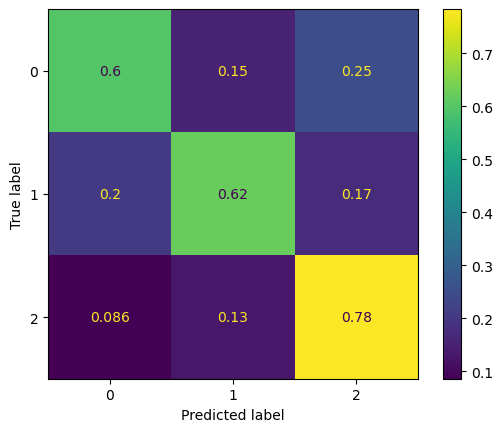

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.72412. Saving Model!
epoch 01, loss: 0.80783, acc: 0.62273, val_loss: 0.72412, val_accuracy: 0.65377


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 02, loss: 0.79244, acc: 0.62960, val_loss: 0.72952, val_accuracy: 0.65585


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 03, loss: 0.79359, acc: 0.62566, val_loss: 0.73077, val_accuracy: 0.65813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 04, loss: 0.78888, acc: 0.62803, val_loss: 0.73264, val_accuracy: 0.65942


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.73it/s]


epoch 05, loss: 0.78747, acc: 0.62926, val_loss: 0.73422, val_accuracy: 0.66012


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 06, loss: 0.78497, acc: 0.62865, val_loss: 0.73696, val_accuracy: 0.65972


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 07, loss: 0.78415, acc: 0.63090, val_loss: 0.73748, val_accuracy: 0.65992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.57it/s]


epoch 08, loss: 0.78218, acc: 0.63047, val_loss: 0.73970, val_accuracy: 0.66012


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 09, loss: 0.78128, acc: 0.63330, val_loss: 0.73964, val_accuracy: 0.66012


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.14it/s]


epoch 10, loss: 0.77855, acc: 0.63345, val_loss: 0.74199, val_accuracy: 0.66062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.22it/s]


epoch 11, loss: 0.77924, acc: 0.63348, val_loss: 0.74204, val_accuracy: 0.66101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 12, loss: 0.77615, acc: 0.63449, val_loss: 0.74442, val_accuracy: 0.66151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.99it/s]


epoch 13, loss: 0.77676, acc: 0.63696, val_loss: 0.74406, val_accuracy: 0.66171


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 14, loss: 0.77463, acc: 0.63312, val_loss: 0.74650, val_accuracy: 0.66190


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.05it/s]


epoch 15, loss: 0.77470, acc: 0.63594, val_loss: 0.74583, val_accuracy: 0.66260


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 16, loss: 0.77278, acc: 0.63445, val_loss: 0.74859, val_accuracy: 0.66270


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 17, loss: 0.77255, acc: 0.63678, val_loss: 0.74701, val_accuracy: 0.64593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]


epoch 18, loss: 0.77078, acc: 0.63564, val_loss: 0.75021, val_accuracy: 0.66240


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 19, loss: 0.77145, acc: 0.63793, val_loss: 0.74865, val_accuracy: 0.64593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


epoch 20, loss: 0.76931, acc: 0.63515, val_loss: 0.75208, val_accuracy: 0.64603


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 21, loss: 0.76894, acc: 0.63863, val_loss: 0.74985, val_accuracy: 0.64524


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 22, loss: 0.76822, acc: 0.63580, val_loss: 0.75402, val_accuracy: 0.64633


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]


epoch 23, loss: 0.76734, acc: 0.64013, val_loss: 0.75127, val_accuracy: 0.64663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 24, loss: 0.76639, acc: 0.63776, val_loss: 0.75496, val_accuracy: 0.64683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 25, loss: 0.76508, acc: 0.64067, val_loss: 0.75288, val_accuracy: 0.64792


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]


epoch 26, loss: 0.76428, acc: 0.63876, val_loss: 0.75591, val_accuracy: 0.64772


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 27, loss: 0.76362, acc: 0.64116, val_loss: 0.75409, val_accuracy: 0.64583


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.74it/s]


epoch 28, loss: 0.76265, acc: 0.63957, val_loss: 0.75732, val_accuracy: 0.64742


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 29, loss: 0.76185, acc: 0.64244, val_loss: 0.75517, val_accuracy: 0.64742


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 30, loss: 0.76069, acc: 0.64020, val_loss: 0.75826, val_accuracy: 0.64891


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.34it/s]


epoch 31, loss: 0.75988, acc: 0.64358, val_loss: 0.75665, val_accuracy: 0.64683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.86it/s]


epoch 32, loss: 0.76017, acc: 0.64011, val_loss: 0.75984, val_accuracy: 0.64534


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 33, loss: 0.75836, acc: 0.64393, val_loss: 0.75813, val_accuracy: 0.64583


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 34, loss: 0.75837, acc: 0.64074, val_loss: 0.76089, val_accuracy: 0.64653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 35, loss: 0.75698, acc: 0.64504, val_loss: 0.75875, val_accuracy: 0.64464


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.91it/s]


epoch 36, loss: 0.75727, acc: 0.64087, val_loss: 0.76287, val_accuracy: 0.64603


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 37, loss: 0.75568, acc: 0.64634, val_loss: 0.76089, val_accuracy: 0.64593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.62it/s]


epoch 38, loss: 0.75599, acc: 0.64027, val_loss: 0.76395, val_accuracy: 0.64663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.20it/s]


epoch 39, loss: 0.75422, acc: 0.64425, val_loss: 0.76129, val_accuracy: 0.64633


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 40, loss: 0.75430, acc: 0.64255, val_loss: 0.76549, val_accuracy: 0.64722


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.84it/s]


epoch 41, loss: 0.75268, acc: 0.64653, val_loss: 0.76322, val_accuracy: 0.64633


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 42, loss: 0.75275, acc: 0.64382, val_loss: 0.76583, val_accuracy: 0.64653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


epoch 43, loss: 0.75144, acc: 0.64674, val_loss: 0.76411, val_accuracy: 0.64802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 44, loss: 0.75079, acc: 0.64335, val_loss: 0.76874, val_accuracy: 0.64653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.69it/s]


epoch 45, loss: 0.75011, acc: 0.64742, val_loss: 0.76487, val_accuracy: 0.64931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 46, loss: 0.74983, acc: 0.64399, val_loss: 0.77014, val_accuracy: 0.64802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 47, loss: 0.74798, acc: 0.64836, val_loss: 0.76651, val_accuracy: 0.64990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]


epoch 48, loss: 0.74851, acc: 0.64513, val_loss: 0.77195, val_accuracy: 0.64018


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.64it/s]


epoch 49, loss: 0.74690, acc: 0.64908, val_loss: 0.76800, val_accuracy: 0.64921


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.70it/s]


epoch 50, loss: 0.74760, acc: 0.64670, val_loss: 0.77314, val_accuracy: 0.63839


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 51, loss: 0.74533, acc: 0.65096, val_loss: 0.76967, val_accuracy: 0.65050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 52, loss: 0.74569, acc: 0.64807, val_loss: 0.77488, val_accuracy: 0.64187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.92it/s]


epoch 53, loss: 0.74468, acc: 0.64900, val_loss: 0.77010, val_accuracy: 0.65169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 54, loss: 0.74431, acc: 0.64825, val_loss: 0.77583, val_accuracy: 0.62391


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.94it/s]


epoch 55, loss: 0.74297, acc: 0.65233, val_loss: 0.77293, val_accuracy: 0.64187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.88it/s]


epoch 56, loss: 0.74323, acc: 0.65025, val_loss: 0.77693, val_accuracy: 0.62510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


epoch 57, loss: 0.74088, acc: 0.65281, val_loss: 0.77343, val_accuracy: 0.64256


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.76it/s]


epoch 58, loss: 0.74173, acc: 0.64936, val_loss: 0.77889, val_accuracy: 0.62431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.54it/s]


epoch 59, loss: 0.73938, acc: 0.65411, val_loss: 0.77485, val_accuracy: 0.64375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 60, loss: 0.73968, acc: 0.65175, val_loss: 0.77921, val_accuracy: 0.62808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 61, loss: 0.73786, acc: 0.65495, val_loss: 0.77602, val_accuracy: 0.62708


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 62, loss: 0.73804, acc: 0.65322, val_loss: 0.78086, val_accuracy: 0.62679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 63, loss: 0.73701, acc: 0.65436, val_loss: 0.77711, val_accuracy: 0.62798


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 64, loss: 0.73616, acc: 0.65360, val_loss: 0.78221, val_accuracy: 0.62728


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 65, loss: 0.73534, acc: 0.65578, val_loss: 0.77887, val_accuracy: 0.62907


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 66, loss: 0.73542, acc: 0.65352, val_loss: 0.78251, val_accuracy: 0.62748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 67, loss: 0.73403, acc: 0.65774, val_loss: 0.78056, val_accuracy: 0.63006


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 68, loss: 0.73376, acc: 0.65389, val_loss: 0.78359, val_accuracy: 0.62679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]


epoch 69, loss: 0.73284, acc: 0.65744, val_loss: 0.78210, val_accuracy: 0.63016


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 70, loss: 0.73213, acc: 0.65396, val_loss: 0.78490, val_accuracy: 0.62867


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 71, loss: 0.73163, acc: 0.66084, val_loss: 0.78313, val_accuracy: 0.63085


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 72, loss: 0.73084, acc: 0.65482, val_loss: 0.78605, val_accuracy: 0.62917


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.13it/s]


epoch 73, loss: 0.72995, acc: 0.66078, val_loss: 0.78422, val_accuracy: 0.63065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 74, loss: 0.72938, acc: 0.65526, val_loss: 0.78714, val_accuracy: 0.63065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 75, loss: 0.72830, acc: 0.66147, val_loss: 0.78679, val_accuracy: 0.63194


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 76, loss: 0.72869, acc: 0.65548, val_loss: 0.78820, val_accuracy: 0.63075


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.13it/s]


epoch 77, loss: 0.72694, acc: 0.66190, val_loss: 0.78848, val_accuracy: 0.63046


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.37it/s]


epoch 78, loss: 0.72736, acc: 0.65642, val_loss: 0.78944, val_accuracy: 0.63016


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 79, loss: 0.72573, acc: 0.66347, val_loss: 0.78883, val_accuracy: 0.63264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 80, loss: 0.72661, acc: 0.65698, val_loss: 0.79128, val_accuracy: 0.62282


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 81, loss: 0.72453, acc: 0.66355, val_loss: 0.79066, val_accuracy: 0.63214


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 82, loss: 0.72599, acc: 0.65670, val_loss: 0.79167, val_accuracy: 0.62341


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 83, loss: 0.72260, acc: 0.66354, val_loss: 0.79148, val_accuracy: 0.63234


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]


epoch 84, loss: 0.72417, acc: 0.65772, val_loss: 0.79336, val_accuracy: 0.62450


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 85, loss: 0.72144, acc: 0.66561, val_loss: 0.79240, val_accuracy: 0.63284


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 86, loss: 0.72271, acc: 0.65931, val_loss: 0.79455, val_accuracy: 0.62500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.94it/s]


epoch 87, loss: 0.72116, acc: 0.66422, val_loss: 0.79442, val_accuracy: 0.62341


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.85it/s]


epoch 88, loss: 0.72142, acc: 0.66131, val_loss: 0.79689, val_accuracy: 0.62480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]


epoch 89, loss: 0.72004, acc: 0.66511, val_loss: 0.79438, val_accuracy: 0.62401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.98it/s]


epoch 90, loss: 0.72051, acc: 0.66228, val_loss: 0.79615, val_accuracy: 0.62421


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 91, loss: 0.71873, acc: 0.66835, val_loss: 0.79682, val_accuracy: 0.62431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 92, loss: 0.71968, acc: 0.66263, val_loss: 0.79887, val_accuracy: 0.62470


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 93, loss: 0.71691, acc: 0.66572, val_loss: 0.79741, val_accuracy: 0.62460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.72it/s]


epoch 94, loss: 0.71791, acc: 0.66386, val_loss: 0.80138, val_accuracy: 0.62520


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 95, loss: 0.71605, acc: 0.66634, val_loss: 0.79784, val_accuracy: 0.63482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 96, loss: 0.71632, acc: 0.66636, val_loss: 0.80228, val_accuracy: 0.62510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 97, loss: 0.71519, acc: 0.66703, val_loss: 0.79921, val_accuracy: 0.62490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 98, loss: 0.71343, acc: 0.66585, val_loss: 0.80270, val_accuracy: 0.62480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 99, loss: 0.71369, acc: 0.66742, val_loss: 0.80146, val_accuracy: 0.62569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 100, loss: 0.71276, acc: 0.66898, val_loss: 0.80458, val_accuracy: 0.62530


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 101, loss: 0.71199, acc: 0.66846, val_loss: 0.80344, val_accuracy: 0.62500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 102, loss: 0.71170, acc: 0.66505, val_loss: 0.80522, val_accuracy: 0.62738


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 103, loss: 0.71112, acc: 0.67115, val_loss: 0.80413, val_accuracy: 0.62579


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 104, loss: 0.71076, acc: 0.66492, val_loss: 0.80655, val_accuracy: 0.62758


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 105, loss: 0.70964, acc: 0.67164, val_loss: 0.80490, val_accuracy: 0.62520


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 106, loss: 0.70876, acc: 0.66670, val_loss: 0.80882, val_accuracy: 0.62698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 107, loss: 0.70869, acc: 0.67259, val_loss: 0.80565, val_accuracy: 0.62520


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 108, loss: 0.70719, acc: 0.66792, val_loss: 0.81000, val_accuracy: 0.62778


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 109, loss: 0.70724, acc: 0.67346, val_loss: 0.80707, val_accuracy: 0.62500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 110, loss: 0.70593, acc: 0.66917, val_loss: 0.81003, val_accuracy: 0.62649


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 111, loss: 0.70535, acc: 0.67325, val_loss: 0.80893, val_accuracy: 0.62490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 112, loss: 0.70500, acc: 0.66757, val_loss: 0.81125, val_accuracy: 0.62798


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 113, loss: 0.70449, acc: 0.67375, val_loss: 0.81031, val_accuracy: 0.62589


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 114, loss: 0.70337, acc: 0.66842, val_loss: 0.81275, val_accuracy: 0.62808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 115, loss: 0.70350, acc: 0.67334, val_loss: 0.80967, val_accuracy: 0.62579


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 116, loss: 0.70183, acc: 0.67014, val_loss: 0.81294, val_accuracy: 0.62847


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 117, loss: 0.70168, acc: 0.67429, val_loss: 0.81307, val_accuracy: 0.62748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 118, loss: 0.70072, acc: 0.67127, val_loss: 0.81366, val_accuracy: 0.62798


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 119, loss: 0.70068, acc: 0.67426, val_loss: 0.81479, val_accuracy: 0.62728


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 120, loss: 0.69922, acc: 0.67282, val_loss: 0.81350, val_accuracy: 0.62897


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 121, loss: 0.69907, acc: 0.67458, val_loss: 0.81682, val_accuracy: 0.62857


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 122, loss: 0.69812, acc: 0.67388, val_loss: 0.81371, val_accuracy: 0.62837


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 123, loss: 0.69751, acc: 0.67532, val_loss: 0.81682, val_accuracy: 0.62907


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 124, loss: 0.69759, acc: 0.67285, val_loss: 0.81582, val_accuracy: 0.62887


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 125, loss: 0.69592, acc: 0.67617, val_loss: 0.81620, val_accuracy: 0.62857


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 126, loss: 0.69594, acc: 0.67410, val_loss: 0.81771, val_accuracy: 0.62937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 127, loss: 0.69509, acc: 0.67671, val_loss: 0.81680, val_accuracy: 0.62867


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 128, loss: 0.69495, acc: 0.67460, val_loss: 0.81836, val_accuracy: 0.62966


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 129, loss: 0.69333, acc: 0.67842, val_loss: 0.81890, val_accuracy: 0.62917


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 130, loss: 0.69372, acc: 0.67508, val_loss: 0.81892, val_accuracy: 0.63026


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 131, loss: 0.69239, acc: 0.67875, val_loss: 0.82090, val_accuracy: 0.62996


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 132, loss: 0.69282, acc: 0.67594, val_loss: 0.82098, val_accuracy: 0.62817


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 133, loss: 0.69161, acc: 0.68040, val_loss: 0.82003, val_accuracy: 0.63016


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 134, loss: 0.69110, acc: 0.67620, val_loss: 0.82196, val_accuracy: 0.62937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 135, loss: 0.69057, acc: 0.68148, val_loss: 0.82202, val_accuracy: 0.62986


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


epoch 136, loss: 0.69107, acc: 0.67571, val_loss: 0.82237, val_accuracy: 0.62927


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


epoch 137, loss: 0.68920, acc: 0.68127, val_loss: 0.82341, val_accuracy: 0.62956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.00it/s]


epoch 138, loss: 0.68975, acc: 0.67606, val_loss: 0.82303, val_accuracy: 0.62937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.40it/s]


epoch 139, loss: 0.68830, acc: 0.68255, val_loss: 0.82302, val_accuracy: 0.62956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]


epoch 140, loss: 0.68880, acc: 0.67674, val_loss: 0.82447, val_accuracy: 0.62897


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.80it/s]


epoch 141, loss: 0.68742, acc: 0.68154, val_loss: 0.82543, val_accuracy: 0.62996


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


epoch 142, loss: 0.68649, acc: 0.67564, val_loss: 0.82655, val_accuracy: 0.62837


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.00it/s]


epoch 143, loss: 0.68611, acc: 0.68069, val_loss: 0.82590, val_accuracy: 0.62927


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.79it/s]


epoch 144, loss: 0.68451, acc: 0.67821, val_loss: 0.82697, val_accuracy: 0.62808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 145, loss: 0.68465, acc: 0.68287, val_loss: 0.82577, val_accuracy: 0.63036


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 146, loss: 0.68354, acc: 0.67879, val_loss: 0.82848, val_accuracy: 0.62897


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 147, loss: 0.68311, acc: 0.68424, val_loss: 0.82898, val_accuracy: 0.63204


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 148, loss: 0.68157, acc: 0.67986, val_loss: 0.82837, val_accuracy: 0.63026


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 149, loss: 0.68177, acc: 0.68397, val_loss: 0.82931, val_accuracy: 0.63185


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 150, loss: 0.68073, acc: 0.68045, val_loss: 0.82925, val_accuracy: 0.62897


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.89it/s]


epoch 151, loss: 0.68010, acc: 0.68517, val_loss: 0.83079, val_accuracy: 0.63274


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.77it/s]


epoch 152, loss: 0.67924, acc: 0.68051, val_loss: 0.83050, val_accuracy: 0.62937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 153, loss: 0.67874, acc: 0.68504, val_loss: 0.83167, val_accuracy: 0.63135


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 154, loss: 0.67849, acc: 0.68307, val_loss: 0.83217, val_accuracy: 0.63075


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


epoch 155, loss: 0.67798, acc: 0.68646, val_loss: 0.83223, val_accuracy: 0.63175


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 156, loss: 0.67652, acc: 0.68452, val_loss: 0.83314, val_accuracy: 0.63155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.68it/s]


epoch 157, loss: 0.67678, acc: 0.68498, val_loss: 0.83416, val_accuracy: 0.63304


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.98it/s]


epoch 158, loss: 0.67569, acc: 0.68688, val_loss: 0.83460, val_accuracy: 0.63194


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.85it/s]


epoch 159, loss: 0.67596, acc: 0.68516, val_loss: 0.83389, val_accuracy: 0.63403


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 160, loss: 0.67448, acc: 0.68688, val_loss: 0.83631, val_accuracy: 0.63155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.03it/s]


epoch 161, loss: 0.67437, acc: 0.68473, val_loss: 0.83732, val_accuracy: 0.63452


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.45it/s]


epoch 162, loss: 0.67330, acc: 0.68767, val_loss: 0.83648, val_accuracy: 0.63224


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]


epoch 163, loss: 0.67241, acc: 0.68541, val_loss: 0.83806, val_accuracy: 0.63532


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.78it/s]


epoch 164, loss: 0.67249, acc: 0.68613, val_loss: 0.83676, val_accuracy: 0.63204


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.80it/s]


epoch 165, loss: 0.67070, acc: 0.68680, val_loss: 0.83804, val_accuracy: 0.63442


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.77it/s]


epoch 166, loss: 0.67046, acc: 0.68760, val_loss: 0.83627, val_accuracy: 0.63264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]


epoch 167, loss: 0.67005, acc: 0.69004, val_loss: 0.84107, val_accuracy: 0.63373


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]


epoch 168, loss: 0.66935, acc: 0.68997, val_loss: 0.83800, val_accuracy: 0.63244


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 169, loss: 0.66844, acc: 0.69215, val_loss: 0.84156, val_accuracy: 0.63552


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 170, loss: 0.66822, acc: 0.69061, val_loss: 0.83957, val_accuracy: 0.63343


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 171, loss: 0.66699, acc: 0.69021, val_loss: 0.84215, val_accuracy: 0.63562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.49it/s]


epoch 172, loss: 0.66650, acc: 0.68832, val_loss: 0.84073, val_accuracy: 0.63383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


epoch 173, loss: 0.66523, acc: 0.69244, val_loss: 0.84381, val_accuracy: 0.63700


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 174, loss: 0.66587, acc: 0.68882, val_loss: 0.84293, val_accuracy: 0.63522


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 175, loss: 0.66468, acc: 0.69296, val_loss: 0.84589, val_accuracy: 0.63790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 176, loss: 0.66544, acc: 0.68859, val_loss: 0.84326, val_accuracy: 0.63373


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 177, loss: 0.66401, acc: 0.69248, val_loss: 0.84673, val_accuracy: 0.63839


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 178, loss: 0.66400, acc: 0.69151, val_loss: 0.84331, val_accuracy: 0.63542


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


epoch 179, loss: 0.66168, acc: 0.69419, val_loss: 0.85052, val_accuracy: 0.63056


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 180, loss: 0.66389, acc: 0.69195, val_loss: 0.84506, val_accuracy: 0.63472


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 181, loss: 0.66059, acc: 0.69482, val_loss: 0.85031, val_accuracy: 0.64008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 182, loss: 0.66116, acc: 0.69286, val_loss: 0.84574, val_accuracy: 0.63591


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 183, loss: 0.65922, acc: 0.69841, val_loss: 0.84898, val_accuracy: 0.63919


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.96it/s]


epoch 184, loss: 0.66000, acc: 0.69296, val_loss: 0.84759, val_accuracy: 0.63879


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.94it/s]


epoch 185, loss: 0.65815, acc: 0.69893, val_loss: 0.85153, val_accuracy: 0.63958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.91it/s]


epoch 186, loss: 0.65844, acc: 0.69576, val_loss: 0.84903, val_accuracy: 0.63819


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 187, loss: 0.65686, acc: 0.70006, val_loss: 0.85305, val_accuracy: 0.64137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.91it/s]


epoch 188, loss: 0.65764, acc: 0.69750, val_loss: 0.84749, val_accuracy: 0.63849


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.62it/s]


epoch 189, loss: 0.65508, acc: 0.70095, val_loss: 0.85631, val_accuracy: 0.64216


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.25it/s]


epoch 190, loss: 0.65702, acc: 0.69569, val_loss: 0.85051, val_accuracy: 0.63958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.89it/s]


epoch 191, loss: 0.65423, acc: 0.69932, val_loss: 0.85636, val_accuracy: 0.64216


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]


epoch 192, loss: 0.65482, acc: 0.69797, val_loss: 0.85115, val_accuracy: 0.64067


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.25it/s]


epoch 193, loss: 0.65312, acc: 0.69943, val_loss: 0.85846, val_accuracy: 0.64306


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 194, loss: 0.65450, acc: 0.69733, val_loss: 0.85238, val_accuracy: 0.64077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 195, loss: 0.65137, acc: 0.69809, val_loss: 0.85859, val_accuracy: 0.64226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 196, loss: 0.65397, acc: 0.69883, val_loss: 0.85403, val_accuracy: 0.64018


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 197, loss: 0.65195, acc: 0.69916, val_loss: 0.85774, val_accuracy: 0.64266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 198, loss: 0.65204, acc: 0.69822, val_loss: 0.85581, val_accuracy: 0.64077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 199, loss: 0.65088, acc: 0.69787, val_loss: 0.85957, val_accuracy: 0.64276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


epoch 200, loss: 0.65150, acc: 0.69945, val_loss: 0.85913, val_accuracy: 0.64167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 201, loss: 0.64959, acc: 0.69879, val_loss: 0.86078, val_accuracy: 0.64524


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.03it/s]


epoch 202, loss: 0.65123, acc: 0.69802, val_loss: 0.86201, val_accuracy: 0.63363


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.34it/s]


epoch 203, loss: 0.64902, acc: 0.69754, val_loss: 0.86170, val_accuracy: 0.64425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.03it/s]


epoch 204, loss: 0.64980, acc: 0.69996, val_loss: 0.86229, val_accuracy: 0.64345


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.27it/s]


epoch 205, loss: 0.64784, acc: 0.70115, val_loss: 0.86199, val_accuracy: 0.64494


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 206, loss: 0.64870, acc: 0.69787, val_loss: 0.86211, val_accuracy: 0.64395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.94it/s]


epoch 207, loss: 0.64635, acc: 0.70302, val_loss: 0.86570, val_accuracy: 0.64524


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.75it/s]


epoch 208, loss: 0.64715, acc: 0.70010, val_loss: 0.86321, val_accuracy: 0.64425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.00it/s]


epoch 209, loss: 0.64599, acc: 0.70287, val_loss: 0.86549, val_accuracy: 0.64643


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 210, loss: 0.64550, acc: 0.70140, val_loss: 0.86354, val_accuracy: 0.64395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 211, loss: 0.64377, acc: 0.70189, val_loss: 0.86876, val_accuracy: 0.64732


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.77it/s]


epoch 212, loss: 0.64439, acc: 0.70250, val_loss: 0.86381, val_accuracy: 0.64335


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


epoch 213, loss: 0.64219, acc: 0.70329, val_loss: 0.87004, val_accuracy: 0.64673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]


epoch 214, loss: 0.64345, acc: 0.70097, val_loss: 0.86761, val_accuracy: 0.64375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 215, loss: 0.64156, acc: 0.70352, val_loss: 0.87023, val_accuracy: 0.64702


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]


epoch 216, loss: 0.64150, acc: 0.70541, val_loss: 0.86654, val_accuracy: 0.64554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.14it/s]


epoch 217, loss: 0.64024, acc: 0.70425, val_loss: 0.87272, val_accuracy: 0.64821


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 218, loss: 0.64044, acc: 0.70305, val_loss: 0.86793, val_accuracy: 0.64444


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.73it/s]


epoch 219, loss: 0.63920, acc: 0.70410, val_loss: 0.87506, val_accuracy: 0.64851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 220, loss: 0.63938, acc: 0.70466, val_loss: 0.86795, val_accuracy: 0.64643


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 221, loss: 0.63747, acc: 0.70551, val_loss: 0.87396, val_accuracy: 0.64782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 222, loss: 0.63831, acc: 0.70578, val_loss: 0.86969, val_accuracy: 0.64187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 223, loss: 0.63713, acc: 0.70551, val_loss: 0.87482, val_accuracy: 0.64901


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 224, loss: 0.63600, acc: 0.70928, val_loss: 0.87272, val_accuracy: 0.64673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 225, loss: 0.63510, acc: 0.70681, val_loss: 0.87411, val_accuracy: 0.64881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 226, loss: 0.63478, acc: 0.70514, val_loss: 0.87376, val_accuracy: 0.64296


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 227, loss: 0.63468, acc: 0.70905, val_loss: 0.87523, val_accuracy: 0.64752


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 228, loss: 0.63249, acc: 0.70777, val_loss: 0.87894, val_accuracy: 0.64435


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 229, loss: 0.63367, acc: 0.70570, val_loss: 0.87320, val_accuracy: 0.64861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.77it/s]


epoch 230, loss: 0.63110, acc: 0.70955, val_loss: 0.87743, val_accuracy: 0.64504


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.01it/s]


epoch 231, loss: 0.63141, acc: 0.70778, val_loss: 0.87764, val_accuracy: 0.64881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.92it/s]


epoch 232, loss: 0.63041, acc: 0.71018, val_loss: 0.87786, val_accuracy: 0.64385


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


epoch 233, loss: 0.63046, acc: 0.71190, val_loss: 0.87889, val_accuracy: 0.64950


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 234, loss: 0.62949, acc: 0.71177, val_loss: 0.87393, val_accuracy: 0.64415


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 235, loss: 0.62835, acc: 0.71201, val_loss: 0.87877, val_accuracy: 0.65079


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 236, loss: 0.62812, acc: 0.71217, val_loss: 0.87853, val_accuracy: 0.64385


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 237, loss: 0.62667, acc: 0.71113, val_loss: 0.88173, val_accuracy: 0.64960


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 238, loss: 0.62699, acc: 0.71176, val_loss: 0.87754, val_accuracy: 0.64554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 239, loss: 0.62545, acc: 0.71292, val_loss: 0.88168, val_accuracy: 0.65030


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 240, loss: 0.62564, acc: 0.71462, val_loss: 0.88185, val_accuracy: 0.64663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.88it/s]


epoch 241, loss: 0.62437, acc: 0.71321, val_loss: 0.88129, val_accuracy: 0.65020


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.77it/s]


epoch 242, loss: 0.62467, acc: 0.71423, val_loss: 0.88239, val_accuracy: 0.64633


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.62it/s]


epoch 243, loss: 0.62307, acc: 0.71500, val_loss: 0.88567, val_accuracy: 0.65050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]


epoch 244, loss: 0.62405, acc: 0.71241, val_loss: 0.88207, val_accuracy: 0.64563


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 245, loss: 0.62199, acc: 0.71416, val_loss: 0.88478, val_accuracy: 0.65069


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 246, loss: 0.62273, acc: 0.71664, val_loss: 0.88146, val_accuracy: 0.64633


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 247, loss: 0.62050, acc: 0.71777, val_loss: 0.89080, val_accuracy: 0.64970


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 248, loss: 0.62158, acc: 0.71571, val_loss: 0.88466, val_accuracy: 0.64702


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 249, loss: 0.61957, acc: 0.71598, val_loss: 0.88736, val_accuracy: 0.64911


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 250, loss: 0.62066, acc: 0.71837, val_loss: 0.88431, val_accuracy: 0.64792


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 251, loss: 0.61903, acc: 0.71585, val_loss: 0.89009, val_accuracy: 0.64921


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.94it/s]


epoch 252, loss: 0.61833, acc: 0.71724, val_loss: 0.88781, val_accuracy: 0.64911


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.78it/s]


epoch 253, loss: 0.61784, acc: 0.71704, val_loss: 0.88898, val_accuracy: 0.64970


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.85it/s]


epoch 254, loss: 0.61851, acc: 0.71712, val_loss: 0.88727, val_accuracy: 0.64921


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 255, loss: 0.61595, acc: 0.71794, val_loss: 0.89251, val_accuracy: 0.65010


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 256, loss: 0.61949, acc: 0.71590, val_loss: 0.88935, val_accuracy: 0.64940


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 257, loss: 0.61532, acc: 0.71930, val_loss: 0.89233, val_accuracy: 0.64970


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 258, loss: 0.61830, acc: 0.71755, val_loss: 0.89474, val_accuracy: 0.65228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.93it/s]


epoch 259, loss: 0.61497, acc: 0.72031, val_loss: 0.89202, val_accuracy: 0.65079


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.32it/s]


epoch 260, loss: 0.61708, acc: 0.72007, val_loss: 0.89618, val_accuracy: 0.64673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 261, loss: 0.61548, acc: 0.72263, val_loss: 0.89181, val_accuracy: 0.64990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 262, loss: 0.61529, acc: 0.72035, val_loss: 0.89498, val_accuracy: 0.64762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.70it/s]


epoch 263, loss: 0.61305, acc: 0.72151, val_loss: 0.89571, val_accuracy: 0.64940


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.57it/s]


epoch 264, loss: 0.61377, acc: 0.72315, val_loss: 0.89537, val_accuracy: 0.64881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.01it/s]


epoch 265, loss: 0.61211, acc: 0.72390, val_loss: 0.89658, val_accuracy: 0.64891


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.63it/s]


epoch 266, loss: 0.61146, acc: 0.72410, val_loss: 0.89660, val_accuracy: 0.64990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 267, loss: 0.61032, acc: 0.72414, val_loss: 0.89793, val_accuracy: 0.65317


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 268, loss: 0.61003, acc: 0.72509, val_loss: 0.89678, val_accuracy: 0.65040


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66it/s]


epoch 269, loss: 0.60884, acc: 0.72240, val_loss: 0.89752, val_accuracy: 0.65040


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.69it/s]


epoch 270, loss: 0.60804, acc: 0.72693, val_loss: 0.89697, val_accuracy: 0.64980


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.40it/s]


epoch 271, loss: 0.60723, acc: 0.72444, val_loss: 0.90126, val_accuracy: 0.65119


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 272, loss: 0.60755, acc: 0.72854, val_loss: 0.89947, val_accuracy: 0.65050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 273, loss: 0.60608, acc: 0.72456, val_loss: 0.90322, val_accuracy: 0.65109


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 274, loss: 0.60670, acc: 0.72900, val_loss: 0.90060, val_accuracy: 0.65000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 275, loss: 0.60472, acc: 0.72337, val_loss: 0.90469, val_accuracy: 0.65109


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 276, loss: 0.60559, acc: 0.72795, val_loss: 0.89971, val_accuracy: 0.65208


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 277, loss: 0.60412, acc: 0.72540, val_loss: 0.90731, val_accuracy: 0.65248


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 278, loss: 0.60589, acc: 0.72707, val_loss: 0.90071, val_accuracy: 0.65268


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 279, loss: 0.60353, acc: 0.72523, val_loss: 0.90329, val_accuracy: 0.65228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 280, loss: 0.60361, acc: 0.72844, val_loss: 0.90405, val_accuracy: 0.65397


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 281, loss: 0.60332, acc: 0.72588, val_loss: 0.90513, val_accuracy: 0.65308


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 282, loss: 0.60506, acc: 0.72747, val_loss: 0.90557, val_accuracy: 0.65407


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 283, loss: 0.60107, acc: 0.72889, val_loss: 0.90674, val_accuracy: 0.65486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 284, loss: 0.60481, acc: 0.72574, val_loss: 0.90761, val_accuracy: 0.65456


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 285, loss: 0.60045, acc: 0.72535, val_loss: 0.90975, val_accuracy: 0.65486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


epoch 286, loss: 0.60448, acc: 0.72734, val_loss: 0.90889, val_accuracy: 0.65357


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


epoch 287, loss: 0.59913, acc: 0.72832, val_loss: 0.90813, val_accuracy: 0.65486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.19it/s]


epoch 288, loss: 0.60226, acc: 0.73055, val_loss: 0.90976, val_accuracy: 0.65327


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.35it/s]


epoch 289, loss: 0.59824, acc: 0.72671, val_loss: 0.90897, val_accuracy: 0.65506


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 290, loss: 0.60007, acc: 0.73095, val_loss: 0.91102, val_accuracy: 0.65526


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.80it/s]


epoch 291, loss: 0.59719, acc: 0.72911, val_loss: 0.90843, val_accuracy: 0.65427


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.87it/s]


epoch 292, loss: 0.59818, acc: 0.73049, val_loss: 0.91129, val_accuracy: 0.65337


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20it/s]


epoch 293, loss: 0.59571, acc: 0.73146, val_loss: 0.91213, val_accuracy: 0.65645


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 294, loss: 0.59618, acc: 0.73269, val_loss: 0.91204, val_accuracy: 0.65506


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 295, loss: 0.59506, acc: 0.73030, val_loss: 0.90991, val_accuracy: 0.65506


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 296, loss: 0.59408, acc: 0.73460, val_loss: 0.91219, val_accuracy: 0.65714


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


epoch 297, loss: 0.59377, acc: 0.73294, val_loss: 0.91328, val_accuracy: 0.65605


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 298, loss: 0.59258, acc: 0.73583, val_loss: 0.91399, val_accuracy: 0.65724


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 299, loss: 0.59279, acc: 0.73489, val_loss: 0.91416, val_accuracy: 0.65714


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 300, loss: 0.59217, acc: 0.73492, val_loss: 0.91641, val_accuracy: 0.65784


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 301, loss: 0.59219, acc: 0.73153, val_loss: 0.91591, val_accuracy: 0.65704


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 302, loss: 0.59149, acc: 0.73659, val_loss: 0.91398, val_accuracy: 0.65774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 303, loss: 0.59064, acc: 0.73379, val_loss: 0.91783, val_accuracy: 0.65823


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


epoch 304, loss: 0.59034, acc: 0.73741, val_loss: 0.91937, val_accuracy: 0.65863


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 305, loss: 0.58982, acc: 0.73334, val_loss: 0.91948, val_accuracy: 0.65665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 306, loss: 0.58971, acc: 0.73652, val_loss: 0.91875, val_accuracy: 0.65853


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 307, loss: 0.58797, acc: 0.73447, val_loss: 0.92083, val_accuracy: 0.65724


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 308, loss: 0.58990, acc: 0.73819, val_loss: 0.92126, val_accuracy: 0.65883


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


epoch 309, loss: 0.58682, acc: 0.73725, val_loss: 0.92129, val_accuracy: 0.65863


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.74it/s]


epoch 310, loss: 0.58908, acc: 0.73920, val_loss: 0.92433, val_accuracy: 0.65923


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 311, loss: 0.58664, acc: 0.73566, val_loss: 0.92018, val_accuracy: 0.65863


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 312, loss: 0.58795, acc: 0.73816, val_loss: 0.92300, val_accuracy: 0.65813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.40it/s]


epoch 313, loss: 0.58566, acc: 0.73648, val_loss: 0.92230, val_accuracy: 0.66022


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


epoch 314, loss: 0.58592, acc: 0.74056, val_loss: 0.92376, val_accuracy: 0.65823


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 315, loss: 0.58420, acc: 0.73834, val_loss: 0.92425, val_accuracy: 0.65873


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 316, loss: 0.58483, acc: 0.73987, val_loss: 0.92585, val_accuracy: 0.65843


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 317, loss: 0.58396, acc: 0.73697, val_loss: 0.92325, val_accuracy: 0.65774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.85it/s]


epoch 318, loss: 0.58264, acc: 0.74160, val_loss: 0.92317, val_accuracy: 0.65853


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]


epoch 319, loss: 0.58270, acc: 0.73762, val_loss: 0.92494, val_accuracy: 0.65724


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 320, loss: 0.58147, acc: 0.74429, val_loss: 0.92602, val_accuracy: 0.65913


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 321, loss: 0.58120, acc: 0.73887, val_loss: 0.92691, val_accuracy: 0.65833


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 322, loss: 0.58051, acc: 0.74338, val_loss: 0.92827, val_accuracy: 0.66071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 323, loss: 0.58041, acc: 0.74242, val_loss: 0.92982, val_accuracy: 0.65903


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 324, loss: 0.57909, acc: 0.74499, val_loss: 0.92865, val_accuracy: 0.65833


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 325, loss: 0.57892, acc: 0.74345, val_loss: 0.93158, val_accuracy: 0.66091


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 326, loss: 0.57845, acc: 0.74684, val_loss: 0.92776, val_accuracy: 0.66002


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 327, loss: 0.57750, acc: 0.74337, val_loss: 0.93170, val_accuracy: 0.66042


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


epoch 328, loss: 0.57982, acc: 0.74530, val_loss: 0.93141, val_accuracy: 0.66081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.74it/s]


epoch 329, loss: 0.57740, acc: 0.74403, val_loss: 0.93232, val_accuracy: 0.66290


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 330, loss: 0.57797, acc: 0.74685, val_loss: 0.93554, val_accuracy: 0.66171


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 331, loss: 0.57593, acc: 0.74368, val_loss: 0.93255, val_accuracy: 0.66022


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 332, loss: 0.57797, acc: 0.74522, val_loss: 0.93865, val_accuracy: 0.66101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 333, loss: 0.57529, acc: 0.74297, val_loss: 0.93258, val_accuracy: 0.66131


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 334, loss: 0.57572, acc: 0.74633, val_loss: 0.93828, val_accuracy: 0.66171


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 335, loss: 0.57428, acc: 0.74565, val_loss: 0.93297, val_accuracy: 0.66121


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 336, loss: 0.57515, acc: 0.74460, val_loss: 0.93796, val_accuracy: 0.66280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 337, loss: 0.57284, acc: 0.74600, val_loss: 0.93403, val_accuracy: 0.66071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 338, loss: 0.57252, acc: 0.74700, val_loss: 0.93805, val_accuracy: 0.66111


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 339, loss: 0.57185, acc: 0.74659, val_loss: 0.93721, val_accuracy: 0.66240


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 340, loss: 0.57217, acc: 0.74800, val_loss: 0.93892, val_accuracy: 0.66399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.06it/s]


epoch 341, loss: 0.57064, acc: 0.74441, val_loss: 0.93646, val_accuracy: 0.66200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]


epoch 342, loss: 0.57056, acc: 0.74993, val_loss: 0.94018, val_accuracy: 0.66389


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 343, loss: 0.57085, acc: 0.74532, val_loss: 0.93746, val_accuracy: 0.66290


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 344, loss: 0.56817, acc: 0.75156, val_loss: 0.93908, val_accuracy: 0.66419


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 345, loss: 0.57059, acc: 0.74490, val_loss: 0.93855, val_accuracy: 0.66121


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.55it/s]


epoch 346, loss: 0.56697, acc: 0.75502, val_loss: 0.94531, val_accuracy: 0.66478


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 347, loss: 0.57047, acc: 0.74528, val_loss: 0.93962, val_accuracy: 0.66111


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 348, loss: 0.56627, acc: 0.75355, val_loss: 0.94220, val_accuracy: 0.66458


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 349, loss: 0.56911, acc: 0.74501, val_loss: 0.94210, val_accuracy: 0.66319


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 350, loss: 0.56603, acc: 0.75270, val_loss: 0.94538, val_accuracy: 0.66429


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.76it/s]


epoch 351, loss: 0.56793, acc: 0.74505, val_loss: 0.94477, val_accuracy: 0.66280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 352, loss: 0.56451, acc: 0.75450, val_loss: 0.94142, val_accuracy: 0.67470


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 353, loss: 0.56549, acc: 0.74663, val_loss: 0.95136, val_accuracy: 0.66399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 354, loss: 0.56639, acc: 0.75440, val_loss: 0.94058, val_accuracy: 0.66339


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 355, loss: 0.56385, acc: 0.75041, val_loss: 0.94824, val_accuracy: 0.66210


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 356, loss: 0.56473, acc: 0.75512, val_loss: 0.94899, val_accuracy: 0.66518


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 357, loss: 0.56415, acc: 0.75106, val_loss: 0.95101, val_accuracy: 0.66329


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 358, loss: 0.56460, acc: 0.75378, val_loss: 0.94694, val_accuracy: 0.66319


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.67it/s]


epoch 359, loss: 0.56298, acc: 0.75476, val_loss: 0.95113, val_accuracy: 0.66329


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.16it/s]


epoch 360, loss: 0.56491, acc: 0.75259, val_loss: 0.95151, val_accuracy: 0.66389


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 361, loss: 0.56318, acc: 0.75351, val_loss: 0.95085, val_accuracy: 0.66379


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 362, loss: 0.56357, acc: 0.75343, val_loss: 0.95176, val_accuracy: 0.66508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 363, loss: 0.56140, acc: 0.75463, val_loss: 0.95262, val_accuracy: 0.66290


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 364, loss: 0.56247, acc: 0.75415, val_loss: 0.95021, val_accuracy: 0.66329


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 365, loss: 0.55988, acc: 0.75538, val_loss: 0.95042, val_accuracy: 0.66190


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 366, loss: 0.55978, acc: 0.75776, val_loss: 0.95611, val_accuracy: 0.66508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.57it/s]


epoch 367, loss: 0.55950, acc: 0.75397, val_loss: 0.95075, val_accuracy: 0.66290


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 368, loss: 0.55722, acc: 0.75685, val_loss: 0.95464, val_accuracy: 0.66577


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


epoch 369, loss: 0.55849, acc: 0.75395, val_loss: 0.95274, val_accuracy: 0.66399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 370, loss: 0.55601, acc: 0.75995, val_loss: 0.96016, val_accuracy: 0.66627


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 371, loss: 0.55849, acc: 0.75513, val_loss: 0.95531, val_accuracy: 0.66369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.00it/s]


epoch 372, loss: 0.55491, acc: 0.75955, val_loss: 0.95740, val_accuracy: 0.66687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 373, loss: 0.55627, acc: 0.75625, val_loss: 0.95834, val_accuracy: 0.66369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 374, loss: 0.55643, acc: 0.75839, val_loss: 0.95711, val_accuracy: 0.66617


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 375, loss: 0.55432, acc: 0.75814, val_loss: 0.96061, val_accuracy: 0.66488


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 376, loss: 0.55552, acc: 0.75790, val_loss: 0.96442, val_accuracy: 0.66607


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.57it/s]


epoch 377, loss: 0.55374, acc: 0.75747, val_loss: 0.95797, val_accuracy: 0.66577


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 378, loss: 0.55645, acc: 0.75960, val_loss: 0.96063, val_accuracy: 0.66438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.81it/s]


epoch 379, loss: 0.55286, acc: 0.76087, val_loss: 0.95905, val_accuracy: 0.66597


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 380, loss: 0.55300, acc: 0.76049, val_loss: 0.96371, val_accuracy: 0.66637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.59it/s]


epoch 381, loss: 0.55176, acc: 0.75996, val_loss: 0.96549, val_accuracy: 0.66597


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 382, loss: 0.55268, acc: 0.75963, val_loss: 0.97009, val_accuracy: 0.66736


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.05it/s]


epoch 383, loss: 0.55115, acc: 0.76186, val_loss: 0.96227, val_accuracy: 0.66488


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 384, loss: 0.55054, acc: 0.76034, val_loss: 0.97065, val_accuracy: 0.66776


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 385, loss: 0.55161, acc: 0.75677, val_loss: 0.96568, val_accuracy: 0.66548


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 386, loss: 0.55011, acc: 0.76013, val_loss: 0.97195, val_accuracy: 0.66677


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.20it/s]


epoch 387, loss: 0.55073, acc: 0.75997, val_loss: 0.96533, val_accuracy: 0.66548


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.73it/s]


epoch 388, loss: 0.54824, acc: 0.76111, val_loss: 0.97147, val_accuracy: 0.66756


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 389, loss: 0.55088, acc: 0.75662, val_loss: 0.96722, val_accuracy: 0.66587


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 390, loss: 0.54755, acc: 0.76283, val_loss: 0.97143, val_accuracy: 0.66806


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


epoch 391, loss: 0.54902, acc: 0.75952, val_loss: 0.97097, val_accuracy: 0.66647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 392, loss: 0.54703, acc: 0.76238, val_loss: 0.97058, val_accuracy: 0.66766


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.20it/s]


epoch 393, loss: 0.54698, acc: 0.75872, val_loss: 0.97255, val_accuracy: 0.66637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 394, loss: 0.54650, acc: 0.76244, val_loss: 0.97165, val_accuracy: 0.67738


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 395, loss: 0.54581, acc: 0.75899, val_loss: 0.97413, val_accuracy: 0.66716


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 396, loss: 0.54559, acc: 0.76270, val_loss: 0.97349, val_accuracy: 0.66865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.88it/s]


epoch 397, loss: 0.54527, acc: 0.75948, val_loss: 0.97518, val_accuracy: 0.66726


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 398, loss: 0.54412, acc: 0.76381, val_loss: 0.96994, val_accuracy: 0.67748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 399, loss: 0.54296, acc: 0.76130, val_loss: 0.97737, val_accuracy: 0.66855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 400, loss: 0.54543, acc: 0.76246, val_loss: 0.97156, val_accuracy: 0.67778


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 401, loss: 0.54208, acc: 0.76365, val_loss: 0.97773, val_accuracy: 0.66786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.86it/s]


epoch 402, loss: 0.54438, acc: 0.76356, val_loss: 0.97655, val_accuracy: 0.66815


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 403, loss: 0.54222, acc: 0.76313, val_loss: 0.97640, val_accuracy: 0.66766


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 404, loss: 0.54315, acc: 0.76373, val_loss: 0.97993, val_accuracy: 0.66944


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.25it/s]


epoch 405, loss: 0.54193, acc: 0.76074, val_loss: 0.97616, val_accuracy: 0.66696


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 406, loss: 0.54361, acc: 0.76248, val_loss: 0.98134, val_accuracy: 0.66954


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.92it/s]


epoch 407, loss: 0.54102, acc: 0.76321, val_loss: 0.97971, val_accuracy: 0.66845


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 408, loss: 0.54209, acc: 0.76501, val_loss: 0.97812, val_accuracy: 0.66815


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.68it/s]


epoch 409, loss: 0.53941, acc: 0.76226, val_loss: 0.98170, val_accuracy: 0.66875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 410, loss: 0.54212, acc: 0.76321, val_loss: 0.97822, val_accuracy: 0.66815


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 411, loss: 0.53860, acc: 0.76708, val_loss: 0.98239, val_accuracy: 0.66994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 412, loss: 0.54035, acc: 0.76524, val_loss: 0.98307, val_accuracy: 0.66796


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 413, loss: 0.53794, acc: 0.76318, val_loss: 0.98768, val_accuracy: 0.66875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 414, loss: 0.53796, acc: 0.76546, val_loss: 0.98392, val_accuracy: 0.66885


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 415, loss: 0.53796, acc: 0.76478, val_loss: 0.98744, val_accuracy: 0.66845


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.58it/s]


epoch 416, loss: 0.53664, acc: 0.76567, val_loss: 0.98298, val_accuracy: 0.67073


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 417, loss: 0.53608, acc: 0.76347, val_loss: 0.98833, val_accuracy: 0.66905


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 418, loss: 0.53578, acc: 0.76871, val_loss: 0.98515, val_accuracy: 0.66944


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 419, loss: 0.53455, acc: 0.76426, val_loss: 0.99001, val_accuracy: 0.66954


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.78it/s]


epoch 420, loss: 0.53517, acc: 0.76706, val_loss: 0.98689, val_accuracy: 0.67083


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 421, loss: 0.53368, acc: 0.76590, val_loss: 0.99206, val_accuracy: 0.67024


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 422, loss: 0.53357, acc: 0.77024, val_loss: 0.98424, val_accuracy: 0.66984


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 423, loss: 0.53271, acc: 0.76642, val_loss: 0.99424, val_accuracy: 0.67054


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.89it/s]


epoch 424, loss: 0.53236, acc: 0.76940, val_loss: 0.98809, val_accuracy: 0.67123


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.71it/s]


epoch 425, loss: 0.53099, acc: 0.76800, val_loss: 0.99781, val_accuracy: 0.67024


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 426, loss: 0.53199, acc: 0.76741, val_loss: 0.98620, val_accuracy: 0.67063


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 427, loss: 0.52945, acc: 0.76983, val_loss: 0.99687, val_accuracy: 0.67192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 428, loss: 0.53288, acc: 0.76867, val_loss: 0.98824, val_accuracy: 0.66925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 429, loss: 0.52918, acc: 0.76938, val_loss: 0.99528, val_accuracy: 0.67192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.70it/s]


epoch 430, loss: 0.53006, acc: 0.77088, val_loss: 0.99457, val_accuracy: 0.67272


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 431, loss: 0.52976, acc: 0.76637, val_loss: 0.99551, val_accuracy: 0.67093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 432, loss: 0.52881, acc: 0.76933, val_loss: 0.99698, val_accuracy: 0.67312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.66it/s]


epoch 433, loss: 0.52958, acc: 0.76700, val_loss: 0.99689, val_accuracy: 0.67073


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 434, loss: 0.52875, acc: 0.77144, val_loss: 0.99714, val_accuracy: 0.67272


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.01it/s]


epoch 435, loss: 0.52787, acc: 0.76829, val_loss: 0.99538, val_accuracy: 0.67212


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 436, loss: 0.52710, acc: 0.76923, val_loss: 0.99748, val_accuracy: 0.67391


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


epoch 437, loss: 0.52678, acc: 0.76574, val_loss: 0.99946, val_accuracy: 0.67192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


epoch 438, loss: 0.52678, acc: 0.77020, val_loss: 1.00260, val_accuracy: 0.67341


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 439, loss: 0.52550, acc: 0.76847, val_loss: 1.00241, val_accuracy: 0.67153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 440, loss: 0.52497, acc: 0.77359, val_loss: 1.00168, val_accuracy: 0.67381


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


epoch 441, loss: 0.52597, acc: 0.76760, val_loss: 1.00019, val_accuracy: 0.67153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 442, loss: 0.52473, acc: 0.77379, val_loss: 1.00368, val_accuracy: 0.67361


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 443, loss: 0.52533, acc: 0.76943, val_loss: 1.00888, val_accuracy: 0.67143


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.82it/s]


epoch 444, loss: 0.52331, acc: 0.77509, val_loss: 0.99956, val_accuracy: 0.67321


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 445, loss: 0.52313, acc: 0.76881, val_loss: 1.00254, val_accuracy: 0.67093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 446, loss: 0.52342, acc: 0.77248, val_loss: 1.00492, val_accuracy: 0.67232


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


epoch 447, loss: 0.52297, acc: 0.77128, val_loss: 1.00506, val_accuracy: 0.67192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 448, loss: 0.52303, acc: 0.77363, val_loss: 1.00452, val_accuracy: 0.67331


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 449, loss: 0.52269, acc: 0.77131, val_loss: 1.00334, val_accuracy: 0.67212


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 450, loss: 0.52182, acc: 0.77261, val_loss: 1.01123, val_accuracy: 0.67242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.00it/s]


epoch 451, loss: 0.52205, acc: 0.77131, val_loss: 1.00515, val_accuracy: 0.67262


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 452, loss: 0.52007, acc: 0.77493, val_loss: 1.01270, val_accuracy: 0.67391


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 453, loss: 0.52126, acc: 0.77004, val_loss: 1.00415, val_accuracy: 0.67262


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 454, loss: 0.51974, acc: 0.77304, val_loss: 1.01359, val_accuracy: 0.67500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 455, loss: 0.52035, acc: 0.77346, val_loss: 1.00797, val_accuracy: 0.67262


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.96it/s]


epoch 456, loss: 0.51868, acc: 0.77565, val_loss: 1.01752, val_accuracy: 0.67500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 457, loss: 0.51925, acc: 0.77216, val_loss: 1.00996, val_accuracy: 0.67272


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.83it/s]


epoch 458, loss: 0.51925, acc: 0.77559, val_loss: 1.01306, val_accuracy: 0.67540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 459, loss: 0.51746, acc: 0.77299, val_loss: 1.02122, val_accuracy: 0.67331


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 460, loss: 0.51790, acc: 0.77765, val_loss: 1.01588, val_accuracy: 0.67530


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.57it/s]


epoch 461, loss: 0.51793, acc: 0.77120, val_loss: 1.01169, val_accuracy: 0.67312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 462, loss: 0.51657, acc: 0.77533, val_loss: 1.01669, val_accuracy: 0.67490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.84it/s]


epoch 463, loss: 0.51560, acc: 0.77208, val_loss: 1.01948, val_accuracy: 0.67540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 464, loss: 0.51681, acc: 0.77761, val_loss: 1.01496, val_accuracy: 0.67520


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 465, loss: 0.51528, acc: 0.77482, val_loss: 1.01998, val_accuracy: 0.67391


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 466, loss: 0.51524, acc: 0.77808, val_loss: 1.01452, val_accuracy: 0.67351


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 467, loss: 0.51394, acc: 0.77603, val_loss: 1.02328, val_accuracy: 0.67599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 468, loss: 0.51389, acc: 0.77842, val_loss: 1.02291, val_accuracy: 0.67520


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 469, loss: 0.51300, acc: 0.77412, val_loss: 1.02272, val_accuracy: 0.67480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 470, loss: 0.51344, acc: 0.77876, val_loss: 1.02241, val_accuracy: 0.67609


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 471, loss: 0.51119, acc: 0.77888, val_loss: 1.02593, val_accuracy: 0.67589


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.81it/s]


epoch 472, loss: 0.51376, acc: 0.77872, val_loss: 1.02461, val_accuracy: 0.67639


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 473, loss: 0.51171, acc: 0.77770, val_loss: 1.02846, val_accuracy: 0.67540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


epoch 474, loss: 0.51279, acc: 0.77792, val_loss: 1.02511, val_accuracy: 0.67500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 475, loss: 0.50954, acc: 0.78167, val_loss: 1.02801, val_accuracy: 0.67619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 476, loss: 0.51259, acc: 0.78018, val_loss: 1.02291, val_accuracy: 0.67649


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 477, loss: 0.51028, acc: 0.77705, val_loss: 1.03081, val_accuracy: 0.67599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 478, loss: 0.51152, acc: 0.78045, val_loss: 1.02420, val_accuracy: 0.67540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 479, loss: 0.50984, acc: 0.77930, val_loss: 1.02930, val_accuracy: 0.67619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.16it/s]


epoch 480, loss: 0.50954, acc: 0.78239, val_loss: 1.03147, val_accuracy: 0.67669


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 481, loss: 0.50972, acc: 0.77721, val_loss: 1.02870, val_accuracy: 0.67639


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 482, loss: 0.50938, acc: 0.78199, val_loss: 1.02795, val_accuracy: 0.67768


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 483, loss: 0.50745, acc: 0.77568, val_loss: 1.03321, val_accuracy: 0.67669


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 484, loss: 0.50875, acc: 0.78195, val_loss: 1.03019, val_accuracy: 0.67748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 485, loss: 0.50689, acc: 0.77500, val_loss: 1.03507, val_accuracy: 0.67500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 486, loss: 0.50774, acc: 0.78169, val_loss: 1.03458, val_accuracy: 0.67748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 487, loss: 0.50660, acc: 0.77873, val_loss: 1.03441, val_accuracy: 0.67629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 488, loss: 0.50582, acc: 0.78235, val_loss: 1.03407, val_accuracy: 0.67679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.78it/s]


epoch 489, loss: 0.50499, acc: 0.77675, val_loss: 1.03402, val_accuracy: 0.67728


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 490, loss: 0.50494, acc: 0.78285, val_loss: 1.03041, val_accuracy: 0.67560


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.13it/s]


epoch 491, loss: 0.50345, acc: 0.78236, val_loss: 1.03357, val_accuracy: 0.67698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 492, loss: 0.50358, acc: 0.78152, val_loss: 1.03668, val_accuracy: 0.67490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 493, loss: 0.50201, acc: 0.77953, val_loss: 1.03864, val_accuracy: 0.67698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 494, loss: 0.50271, acc: 0.78214, val_loss: 1.03826, val_accuracy: 0.67569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 495, loss: 0.50151, acc: 0.77999, val_loss: 1.03518, val_accuracy: 0.67569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 496, loss: 0.50048, acc: 0.78232, val_loss: 1.03555, val_accuracy: 0.67698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 497, loss: 0.50140, acc: 0.78098, val_loss: 1.03553, val_accuracy: 0.67569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 498, loss: 0.50026, acc: 0.78121, val_loss: 1.03991, val_accuracy: 0.67609


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 499, loss: 0.50089, acc: 0.78092, val_loss: 1.03886, val_accuracy: 0.67708


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.00it/s]


epoch 500, loss: 0.49791, acc: 0.78330, val_loss: 1.04000, val_accuracy: 0.67748
3번째 교차검증
evaluation loss: 1.17910, evaluation accuracy: 0.39831
(5, 10080)
(10080, 5)
Learning rate set to 0.10399
0:	learn: 1.0598742	total: 9.17ms	remaining: 9.16s
1:	learn: 1.0291438	total: 16ms	remaining: 7.98s
2:	learn: 1.0040187	total: 24.4ms	remaining: 8.12s
3:	learn: 0.9830396	total: 31.5ms	remaining: 7.83s
4:	learn: 0.9643878	total: 39.3ms	remaining: 7.81s
5:	learn: 0.9490386	total: 46.4ms	remaining: 7.69s
6:	learn: 0.9360845	total: 54.9ms	remaining: 7.79s
7:	learn: 0.9223798	total: 62.4ms	remaining: 7.74s
8:	learn: 0.9130406	total: 72.2ms	remaining: 7.95s
9:	learn: 0.9028108	total: 79.3ms	remaining: 7.85s
10:	learn: 0.8950942	total: 86.2ms	remaining: 7.75s
11:	learn: 0.8875238	total: 94.4ms	remaining: 7.77s
12:	learn: 0.8808238	total: 102ms	remaining: 7.72s
13:	learn: 0.8755277	total: 111ms	remaining: 7.8s
14:	learn: 0.8711037	total: 118ms	remaining: 7.72s
15:	learn: 0.8663169	total: 125ms	remain

166:	learn: 0.7994051	total: 1.23s	remaining: 6.11s
167:	learn: 0.7993795	total: 1.23s	remaining: 6.12s
168:	learn: 0.7993485	total: 1.24s	remaining: 6.11s
169:	learn: 0.7993126	total: 1.25s	remaining: 6.1s
170:	learn: 0.7992859	total: 1.26s	remaining: 6.1s
171:	learn: 0.7992443	total: 1.26s	remaining: 6.09s
172:	learn: 0.7992035	total: 1.27s	remaining: 6.08s
173:	learn: 0.7991797	total: 1.28s	remaining: 6.08s
174:	learn: 0.7991410	total: 1.29s	remaining: 6.08s
175:	learn: 0.7991183	total: 1.29s	remaining: 6.07s
176:	learn: 0.7990873	total: 1.3s	remaining: 6.06s
177:	learn: 0.7990667	total: 1.31s	remaining: 6.05s
178:	learn: 0.7990429	total: 1.32s	remaining: 6.05s
179:	learn: 0.7990160	total: 1.33s	remaining: 6.05s
180:	learn: 0.7989813	total: 1.34s	remaining: 6.05s
181:	learn: 0.7989597	total: 1.34s	remaining: 6.04s
182:	learn: 0.7989331	total: 1.35s	remaining: 6.04s
183:	learn: 0.7988988	total: 1.36s	remaining: 6.03s
184:	learn: 0.7988795	total: 1.37s	remaining: 6.02s
185:	learn: 0.7

336:	learn: 0.7970536	total: 2.67s	remaining: 5.26s
337:	learn: 0.7970501	total: 2.68s	remaining: 5.25s
338:	learn: 0.7970449	total: 2.69s	remaining: 5.25s
339:	learn: 0.7970401	total: 2.7s	remaining: 5.24s
340:	learn: 0.7970347	total: 2.71s	remaining: 5.24s
341:	learn: 0.7970297	total: 2.72s	remaining: 5.23s
342:	learn: 0.7970244	total: 2.73s	remaining: 5.22s
343:	learn: 0.7970207	total: 2.73s	remaining: 5.21s
344:	learn: 0.7970130	total: 2.74s	remaining: 5.21s
345:	learn: 0.7970106	total: 2.75s	remaining: 5.2s
346:	learn: 0.7970056	total: 2.76s	remaining: 5.2s
347:	learn: 0.7969992	total: 2.77s	remaining: 5.19s
348:	learn: 0.7969948	total: 2.78s	remaining: 5.18s
349:	learn: 0.7969905	total: 2.79s	remaining: 5.17s
350:	learn: 0.7969868	total: 2.8s	remaining: 5.17s
351:	learn: 0.7969781	total: 2.81s	remaining: 5.17s
352:	learn: 0.7969734	total: 2.81s	remaining: 5.16s
353:	learn: 0.7969674	total: 2.82s	remaining: 5.15s
354:	learn: 0.7969652	total: 2.83s	remaining: 5.15s
355:	learn: 0.79

516:	learn: 0.7964191	total: 4.33s	remaining: 4.04s
517:	learn: 0.7964173	total: 4.34s	remaining: 4.04s
518:	learn: 0.7964154	total: 4.35s	remaining: 4.03s
519:	learn: 0.7964140	total: 4.36s	remaining: 4.02s
520:	learn: 0.7964125	total: 4.36s	remaining: 4.01s
521:	learn: 0.7964101	total: 4.37s	remaining: 4s
522:	learn: 0.7964078	total: 4.38s	remaining: 4s
523:	learn: 0.7964058	total: 4.39s	remaining: 3.99s
524:	learn: 0.7964026	total: 4.4s	remaining: 3.98s
525:	learn: 0.7964013	total: 4.41s	remaining: 3.98s
526:	learn: 0.7963995	total: 4.42s	remaining: 3.97s
527:	learn: 0.7963985	total: 4.43s	remaining: 3.96s
528:	learn: 0.7963973	total: 4.44s	remaining: 3.96s
529:	learn: 0.7963953	total: 4.45s	remaining: 3.95s
530:	learn: 0.7963932	total: 4.46s	remaining: 3.94s
531:	learn: 0.7963917	total: 4.47s	remaining: 3.93s
532:	learn: 0.7963900	total: 4.48s	remaining: 3.93s
533:	learn: 0.7963889	total: 4.49s	remaining: 3.92s
534:	learn: 0.7963872	total: 4.5s	remaining: 3.91s
535:	learn: 0.796385

689:	learn: 0.7961611	total: 5.99s	remaining: 2.69s
690:	learn: 0.7961598	total: 6s	remaining: 2.68s
691:	learn: 0.7961565	total: 6.01s	remaining: 2.68s
692:	learn: 0.7961548	total: 6.02s	remaining: 2.67s
693:	learn: 0.7961538	total: 6.03s	remaining: 2.66s
694:	learn: 0.7961529	total: 6.04s	remaining: 2.65s
695:	learn: 0.7961521	total: 6.05s	remaining: 2.64s
696:	learn: 0.7961513	total: 6.06s	remaining: 2.63s
697:	learn: 0.7961510	total: 6.07s	remaining: 2.63s
698:	learn: 0.7961503	total: 6.08s	remaining: 2.62s
699:	learn: 0.7961496	total: 6.09s	remaining: 2.61s
700:	learn: 0.7961481	total: 6.1s	remaining: 2.6s
701:	learn: 0.7961471	total: 6.11s	remaining: 2.59s
702:	learn: 0.7961465	total: 6.12s	remaining: 2.59s
703:	learn: 0.7961444	total: 6.13s	remaining: 2.58s
704:	learn: 0.7961436	total: 6.14s	remaining: 2.57s
705:	learn: 0.7961419	total: 6.15s	remaining: 2.56s
706:	learn: 0.7961413	total: 6.16s	remaining: 2.55s
707:	learn: 0.7961406	total: 6.17s	remaining: 2.54s
708:	learn: 0.796

858:	learn: 0.7960046	total: 7.66s	remaining: 1.26s
859:	learn: 0.7960030	total: 7.67s	remaining: 1.25s
860:	learn: 0.7960016	total: 7.68s	remaining: 1.24s
861:	learn: 0.7960006	total: 7.68s	remaining: 1.23s
862:	learn: 0.7960002	total: 7.69s	remaining: 1.22s
863:	learn: 0.7959987	total: 7.7s	remaining: 1.21s
864:	learn: 0.7959985	total: 7.71s	remaining: 1.2s
865:	learn: 0.7959980	total: 7.72s	remaining: 1.19s
866:	learn: 0.7959975	total: 7.73s	remaining: 1.19s
867:	learn: 0.7959968	total: 7.74s	remaining: 1.18s
868:	learn: 0.7959953	total: 7.75s	remaining: 1.17s
869:	learn: 0.7959947	total: 7.76s	remaining: 1.16s
870:	learn: 0.7959943	total: 7.77s	remaining: 1.15s
871:	learn: 0.7959935	total: 7.78s	remaining: 1.14s
872:	learn: 0.7959927	total: 7.79s	remaining: 1.13s
873:	learn: 0.7959915	total: 7.8s	remaining: 1.12s
874:	learn: 0.7959903	total: 7.8s	remaining: 1.11s
875:	learn: 0.7959897	total: 7.81s	remaining: 1.11s
876:	learn: 0.7959885	total: 7.82s	remaining: 1.1s
877:	learn: 0.795

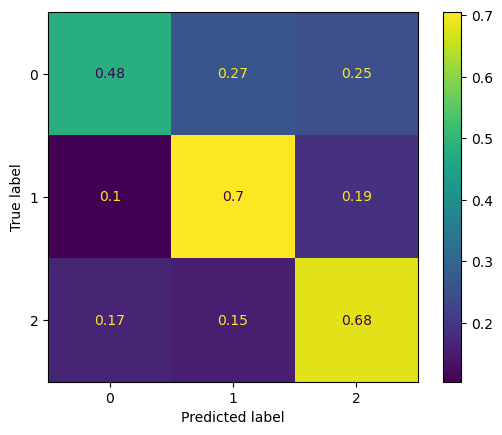

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.90it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.15246. Saving Model!
epoch 01, loss: 1.86725, acc: 0.24044, val_loss: 1.15246, val_accuracy: 0.30724


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


[INFO] val_acc has been improved from 1.15246 to 1.09052. Saving Model!
epoch 02, loss: 1.08734, acc: 0.41405, val_loss: 1.09052, val_accuracy: 0.37401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 03, loss: 1.09801, acc: 0.35020, val_loss: 1.09142, val_accuracy: 0.35774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 04, loss: 1.09836, acc: 0.34385, val_loss: 1.09154, val_accuracy: 0.35020


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.21it/s]


epoch 05, loss: 1.09876, acc: 0.33846, val_loss: 1.09151, val_accuracy: 0.34990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 06, loss: 1.09925, acc: 0.34202, val_loss: 1.09157, val_accuracy: 0.34683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 07, loss: 1.09915, acc: 0.34131, val_loss: 1.09158, val_accuracy: 0.34841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.93it/s]


epoch 08, loss: 1.09903, acc: 0.34205, val_loss: 1.09154, val_accuracy: 0.34931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 09, loss: 1.09884, acc: 0.34201, val_loss: 1.09147, val_accuracy: 0.34931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.68it/s]


epoch 10, loss: 1.09840, acc: 0.34245, val_loss: 1.09134, val_accuracy: 0.35099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 11, loss: 1.09813, acc: 0.34378, val_loss: 1.09121, val_accuracy: 0.35188


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.19it/s]


epoch 12, loss: 1.09763, acc: 0.34450, val_loss: 1.09102, val_accuracy: 0.36528


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 13, loss: 1.09709, acc: 0.34524, val_loss: 1.09079, val_accuracy: 0.36577


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]


[INFO] val_acc has been improved from 1.09052 to 1.09050. Saving Model!
epoch 14, loss: 1.09643, acc: 0.34724, val_loss: 1.09050, val_accuracy: 0.36637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.40it/s]


[INFO] val_acc has been improved from 1.09050 to 1.09020. Saving Model!
epoch 15, loss: 1.09598, acc: 0.34899, val_loss: 1.09020, val_accuracy: 0.36855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


[INFO] val_acc has been improved from 1.09020 to 1.08985. Saving Model!
epoch 16, loss: 1.09517, acc: 0.34996, val_loss: 1.08985, val_accuracy: 0.36974


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.71it/s]


[INFO] val_acc has been improved from 1.08985 to 1.08945. Saving Model!
epoch 17, loss: 1.09453, acc: 0.35644, val_loss: 1.08945, val_accuracy: 0.37202


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


[INFO] val_acc has been improved from 1.08945 to 1.08901. Saving Model!
epoch 18, loss: 1.09390, acc: 0.35914, val_loss: 1.08901, val_accuracy: 0.37282


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


[INFO] val_acc has been improved from 1.08901 to 1.08856. Saving Model!
epoch 19, loss: 1.09309, acc: 0.36130, val_loss: 1.08856, val_accuracy: 0.38621


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


[INFO] val_acc has been improved from 1.08856 to 1.08805. Saving Model!
epoch 20, loss: 1.09220, acc: 0.36569, val_loss: 1.08805, val_accuracy: 0.38482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


[INFO] val_acc has been improved from 1.08805 to 1.08750. Saving Model!
epoch 21, loss: 1.09173, acc: 0.36591, val_loss: 1.08750, val_accuracy: 0.38442


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


[INFO] val_acc has been improved from 1.08750 to 1.08694. Saving Model!
epoch 22, loss: 1.09091, acc: 0.36471, val_loss: 1.08694, val_accuracy: 0.38393


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


[INFO] val_acc has been improved from 1.08694 to 1.08633. Saving Model!
epoch 23, loss: 1.08989, acc: 0.36604, val_loss: 1.08633, val_accuracy: 0.38393


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


[INFO] val_acc has been improved from 1.08633 to 1.08574. Saving Model!
epoch 24, loss: 1.08919, acc: 0.37001, val_loss: 1.08574, val_accuracy: 0.38353


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


[INFO] val_acc has been improved from 1.08574 to 1.08514. Saving Model!
epoch 25, loss: 1.08821, acc: 0.36909, val_loss: 1.08514, val_accuracy: 0.38373


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


[INFO] val_acc has been improved from 1.08514 to 1.08452. Saving Model!
epoch 26, loss: 1.08724, acc: 0.37070, val_loss: 1.08452, val_accuracy: 0.38264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


[INFO] val_acc has been improved from 1.08452 to 1.08386. Saving Model!
epoch 27, loss: 1.08647, acc: 0.37182, val_loss: 1.08386, val_accuracy: 0.38274


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


[INFO] val_acc has been improved from 1.08386 to 1.08319. Saving Model!
epoch 28, loss: 1.08529, acc: 0.37155, val_loss: 1.08319, val_accuracy: 0.38204


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


[INFO] val_acc has been improved from 1.08319 to 1.08253. Saving Model!
epoch 29, loss: 1.08436, acc: 0.37604, val_loss: 1.08253, val_accuracy: 0.38264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


[INFO] val_acc has been improved from 1.08253 to 1.08186. Saving Model!
epoch 30, loss: 1.08340, acc: 0.37790, val_loss: 1.08186, val_accuracy: 0.38294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.10it/s]


[INFO] val_acc has been improved from 1.08186 to 1.08120. Saving Model!
epoch 31, loss: 1.08216, acc: 0.37829, val_loss: 1.08120, val_accuracy: 0.38323


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


[INFO] val_acc has been improved from 1.08120 to 1.08053. Saving Model!
epoch 32, loss: 1.08104, acc: 0.38287, val_loss: 1.08053, val_accuracy: 0.38274


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


[INFO] val_acc has been improved from 1.08053 to 1.07980. Saving Model!
epoch 33, loss: 1.07997, acc: 0.38124, val_loss: 1.07980, val_accuracy: 0.38313


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


[INFO] val_acc has been improved from 1.07980 to 1.07913. Saving Model!
epoch 34, loss: 1.07859, acc: 0.38168, val_loss: 1.07913, val_accuracy: 0.38185


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.78it/s]


[INFO] val_acc has been improved from 1.07913 to 1.07841. Saving Model!
epoch 35, loss: 1.07732, acc: 0.38103, val_loss: 1.07841, val_accuracy: 0.36865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


[INFO] val_acc has been improved from 1.07841 to 1.07779. Saving Model!
epoch 36, loss: 1.07617, acc: 0.38317, val_loss: 1.07779, val_accuracy: 0.37103


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


[INFO] val_acc has been improved from 1.07779 to 1.07736. Saving Model!
epoch 37, loss: 1.07477, acc: 0.38436, val_loss: 1.07736, val_accuracy: 0.37302


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.94it/s]


[INFO] val_acc has been improved from 1.07736 to 1.07639. Saving Model!
epoch 38, loss: 1.07576, acc: 0.38186, val_loss: 1.07639, val_accuracy: 0.37321


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


[INFO] val_acc has been improved from 1.07639 to 1.07568. Saving Model!
epoch 39, loss: 1.07218, acc: 0.38666, val_loss: 1.07568, val_accuracy: 0.37351


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


[INFO] val_acc has been improved from 1.07568 to 1.07508. Saving Model!
epoch 40, loss: 1.07104, acc: 0.38760, val_loss: 1.07508, val_accuracy: 0.37599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.08it/s]


[INFO] val_acc has been improved from 1.07508 to 1.07447. Saving Model!
epoch 41, loss: 1.06985, acc: 0.38866, val_loss: 1.07447, val_accuracy: 0.37431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


[INFO] val_acc has been improved from 1.07447 to 1.07392. Saving Model!
epoch 42, loss: 1.06878, acc: 0.38864, val_loss: 1.07392, val_accuracy: 0.37599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


[INFO] val_acc has been improved from 1.07392 to 1.07329. Saving Model!
epoch 43, loss: 1.06741, acc: 0.39239, val_loss: 1.07329, val_accuracy: 0.37798


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


[INFO] val_acc has been improved from 1.07329 to 1.07267. Saving Model!
epoch 44, loss: 1.06617, acc: 0.39383, val_loss: 1.07267, val_accuracy: 0.38085


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


[INFO] val_acc has been improved from 1.07267 to 1.07206. Saving Model!
epoch 45, loss: 1.06512, acc: 0.39393, val_loss: 1.07206, val_accuracy: 0.38016


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


[INFO] val_acc has been improved from 1.07206 to 1.07149. Saving Model!
epoch 46, loss: 1.06361, acc: 0.39795, val_loss: 1.07149, val_accuracy: 0.38075


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


[INFO] val_acc has been improved from 1.07149 to 1.07092. Saving Model!
epoch 47, loss: 1.06231, acc: 0.39904, val_loss: 1.07092, val_accuracy: 0.38165


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


[INFO] val_acc has been improved from 1.07092 to 1.07040. Saving Model!
epoch 48, loss: 1.06169, acc: 0.39893, val_loss: 1.07040, val_accuracy: 0.38155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


[INFO] val_acc has been improved from 1.07040 to 1.06969. Saving Model!
epoch 49, loss: 1.05970, acc: 0.40293, val_loss: 1.06969, val_accuracy: 0.38274


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


[INFO] val_acc has been improved from 1.06969 to 1.06905. Saving Model!
epoch 50, loss: 1.05916, acc: 0.40344, val_loss: 1.06905, val_accuracy: 0.38343


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


[INFO] val_acc has been improved from 1.06905 to 1.06836. Saving Model!
epoch 51, loss: 1.05739, acc: 0.40636, val_loss: 1.06836, val_accuracy: 0.38403


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


[INFO] val_acc has been improved from 1.06836 to 1.06771. Saving Model!
epoch 52, loss: 1.05653, acc: 0.40647, val_loss: 1.06771, val_accuracy: 0.38284


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


[INFO] val_acc has been improved from 1.06771 to 1.06713. Saving Model!
epoch 53, loss: 1.05533, acc: 0.40655, val_loss: 1.06713, val_accuracy: 0.38472


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


[INFO] val_acc has been improved from 1.06713 to 1.06646. Saving Model!
epoch 54, loss: 1.05434, acc: 0.40986, val_loss: 1.06646, val_accuracy: 0.38423


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


[INFO] val_acc has been improved from 1.06646 to 1.06578. Saving Model!
epoch 55, loss: 1.05286, acc: 0.41297, val_loss: 1.06578, val_accuracy: 0.38373


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


[INFO] val_acc has been improved from 1.06578 to 1.06549. Saving Model!
epoch 56, loss: 1.05208, acc: 0.41287, val_loss: 1.06549, val_accuracy: 0.38661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


[INFO] val_acc has been improved from 1.06549 to 1.06481. Saving Model!
epoch 57, loss: 1.05082, acc: 0.41175, val_loss: 1.06481, val_accuracy: 0.38879


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


[INFO] val_acc has been improved from 1.06481 to 1.06422. Saving Model!
epoch 58, loss: 1.04931, acc: 0.41338, val_loss: 1.06422, val_accuracy: 0.38919


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.20it/s]


[INFO] val_acc has been improved from 1.06422 to 1.06379. Saving Model!
epoch 59, loss: 1.04866, acc: 0.41348, val_loss: 1.06379, val_accuracy: 0.38968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


[INFO] val_acc has been improved from 1.06379 to 1.06310. Saving Model!
epoch 60, loss: 1.04712, acc: 0.41227, val_loss: 1.06310, val_accuracy: 0.39008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


[INFO] val_acc has been improved from 1.06310 to 1.06251. Saving Model!
epoch 61, loss: 1.04662, acc: 0.41337, val_loss: 1.06251, val_accuracy: 0.39077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


[INFO] val_acc has been improved from 1.06251 to 1.06185. Saving Model!
epoch 62, loss: 1.04487, acc: 0.41183, val_loss: 1.06185, val_accuracy: 0.39216


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


[INFO] val_acc has been improved from 1.06185 to 1.06108. Saving Model!
epoch 63, loss: 1.04392, acc: 0.41257, val_loss: 1.06108, val_accuracy: 0.39236


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.74it/s]


[INFO] val_acc has been improved from 1.06108 to 1.06069. Saving Model!
epoch 64, loss: 1.04324, acc: 0.41660, val_loss: 1.06069, val_accuracy: 0.39226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


[INFO] val_acc has been improved from 1.06069 to 1.05990. Saving Model!
epoch 65, loss: 1.04154, acc: 0.41749, val_loss: 1.05990, val_accuracy: 0.39177


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


[INFO] val_acc has been improved from 1.05990 to 1.05952. Saving Model!
epoch 66, loss: 1.04100, acc: 0.41693, val_loss: 1.05952, val_accuracy: 0.39315


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


[INFO] val_acc has been improved from 1.05952 to 1.05863. Saving Model!
epoch 67, loss: 1.03969, acc: 0.41677, val_loss: 1.05863, val_accuracy: 0.39246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


[INFO] val_acc has been improved from 1.05863 to 1.05789. Saving Model!
epoch 68, loss: 1.03872, acc: 0.41757, val_loss: 1.05789, val_accuracy: 0.39474


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


[INFO] val_acc has been improved from 1.05789 to 1.05703. Saving Model!
epoch 69, loss: 1.03750, acc: 0.41926, val_loss: 1.05703, val_accuracy: 0.39554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


[INFO] val_acc has been improved from 1.05703 to 1.05650. Saving Model!
epoch 70, loss: 1.03646, acc: 0.42008, val_loss: 1.05650, val_accuracy: 0.42183


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


[INFO] val_acc has been improved from 1.05650 to 1.05557. Saving Model!
epoch 71, loss: 1.03527, acc: 0.42087, val_loss: 1.05557, val_accuracy: 0.42202


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


[INFO] val_acc has been improved from 1.05557 to 1.05470. Saving Model!
epoch 72, loss: 1.03438, acc: 0.42841, val_loss: 1.05470, val_accuracy: 0.42173


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


[INFO] val_acc has been improved from 1.05470 to 1.05402. Saving Model!
epoch 73, loss: 1.03296, acc: 0.44440, val_loss: 1.05402, val_accuracy: 0.41944


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


[INFO] val_acc has been improved from 1.05402 to 1.05306. Saving Model!
epoch 74, loss: 1.03265, acc: 0.44583, val_loss: 1.05306, val_accuracy: 0.42103


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]


[INFO] val_acc has been improved from 1.05306 to 1.05250. Saving Model!
epoch 75, loss: 1.03100, acc: 0.44642, val_loss: 1.05250, val_accuracy: 0.41984


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


[INFO] val_acc has been improved from 1.05250 to 1.05179. Saving Model!
epoch 76, loss: 1.02992, acc: 0.44655, val_loss: 1.05179, val_accuracy: 0.42034


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


[INFO] val_acc has been improved from 1.05179 to 1.05109. Saving Model!
epoch 77, loss: 1.02880, acc: 0.44750, val_loss: 1.05109, val_accuracy: 0.43224


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


[INFO] val_acc has been improved from 1.05109 to 1.05012. Saving Model!
epoch 78, loss: 1.02780, acc: 0.45031, val_loss: 1.05012, val_accuracy: 0.43095


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


[INFO] val_acc has been improved from 1.05012 to 1.04970. Saving Model!
epoch 79, loss: 1.02690, acc: 0.44884, val_loss: 1.04970, val_accuracy: 0.43125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.22it/s]


[INFO] val_acc has been improved from 1.04970 to 1.04868. Saving Model!
epoch 80, loss: 1.02576, acc: 0.45156, val_loss: 1.04868, val_accuracy: 0.43105


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


[INFO] val_acc has been improved from 1.04868 to 1.04810. Saving Model!
epoch 81, loss: 1.02486, acc: 0.45103, val_loss: 1.04810, val_accuracy: 0.43145


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


[INFO] val_acc has been improved from 1.04810 to 1.04748. Saving Model!
epoch 82, loss: 1.02332, acc: 0.45203, val_loss: 1.04748, val_accuracy: 0.43165


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


[INFO] val_acc has been improved from 1.04748 to 1.04678. Saving Model!
epoch 83, loss: 1.02297, acc: 0.45267, val_loss: 1.04678, val_accuracy: 0.43204


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


[INFO] val_acc has been improved from 1.04678 to 1.04593. Saving Model!
epoch 84, loss: 1.02138, acc: 0.45597, val_loss: 1.04593, val_accuracy: 0.43224


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


[INFO] val_acc has been improved from 1.04593 to 1.04536. Saving Model!
epoch 85, loss: 1.02055, acc: 0.45474, val_loss: 1.04536, val_accuracy: 0.43442


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


[INFO] val_acc has been improved from 1.04536 to 1.04443. Saving Model!
epoch 86, loss: 1.01935, acc: 0.45376, val_loss: 1.04443, val_accuracy: 0.43482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.13it/s]


[INFO] val_acc has been improved from 1.04443 to 1.04416. Saving Model!
epoch 87, loss: 1.01832, acc: 0.45595, val_loss: 1.04416, val_accuracy: 0.43512


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


[INFO] val_acc has been improved from 1.04416 to 1.04308. Saving Model!
epoch 88, loss: 1.01709, acc: 0.45360, val_loss: 1.04308, val_accuracy: 0.43581


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


[INFO] val_acc has been improved from 1.04308 to 1.04261. Saving Model!
epoch 89, loss: 1.01620, acc: 0.45602, val_loss: 1.04261, val_accuracy: 0.43651


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


[INFO] val_acc has been improved from 1.04261 to 1.04208. Saving Model!
epoch 90, loss: 1.01502, acc: 0.45619, val_loss: 1.04208, val_accuracy: 0.43810


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


[INFO] val_acc has been improved from 1.04208 to 1.04102. Saving Model!
epoch 91, loss: 1.01429, acc: 0.45798, val_loss: 1.04102, val_accuracy: 0.43869


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


[INFO] val_acc has been improved from 1.04102 to 1.04084. Saving Model!
epoch 92, loss: 1.01282, acc: 0.45783, val_loss: 1.04084, val_accuracy: 0.44028


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


[INFO] val_acc has been improved from 1.04084 to 1.03957. Saving Model!
epoch 93, loss: 1.01232, acc: 0.45789, val_loss: 1.03957, val_accuracy: 0.43948


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.08it/s]


[INFO] val_acc has been improved from 1.03957 to 1.03926. Saving Model!
epoch 94, loss: 1.01130, acc: 0.45726, val_loss: 1.03926, val_accuracy: 0.44087


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


[INFO] val_acc has been improved from 1.03926 to 1.03852. Saving Model!
epoch 95, loss: 1.01012, acc: 0.45797, val_loss: 1.03852, val_accuracy: 0.44097


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


[INFO] val_acc has been improved from 1.03852 to 1.03826. Saving Model!
epoch 96, loss: 1.00886, acc: 0.45891, val_loss: 1.03826, val_accuracy: 0.44177


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


[INFO] val_acc has been improved from 1.03826 to 1.03715. Saving Model!
epoch 97, loss: 1.00853, acc: 0.45818, val_loss: 1.03715, val_accuracy: 0.44216


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


[INFO] val_acc has been improved from 1.03715 to 1.03692. Saving Model!
epoch 98, loss: 1.00689, acc: 0.46299, val_loss: 1.03692, val_accuracy: 0.44246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.91it/s]


[INFO] val_acc has been improved from 1.03692 to 1.03626. Saving Model!
epoch 99, loss: 1.00639, acc: 0.46329, val_loss: 1.03626, val_accuracy: 0.44127


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


[INFO] val_acc has been improved from 1.03626 to 1.03572. Saving Model!
epoch 100, loss: 1.00502, acc: 0.46799, val_loss: 1.03572, val_accuracy: 0.44107


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.85it/s]


[INFO] val_acc has been improved from 1.03572 to 1.03487. Saving Model!
epoch 101, loss: 1.00372, acc: 0.46785, val_loss: 1.03487, val_accuracy: 0.45248


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.11it/s]


[INFO] val_acc has been improved from 1.03487 to 1.03426. Saving Model!
epoch 102, loss: 1.00346, acc: 0.46871, val_loss: 1.03426, val_accuracy: 0.45188


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


[INFO] val_acc has been improved from 1.03426 to 1.03382. Saving Model!
epoch 103, loss: 1.00174, acc: 0.46950, val_loss: 1.03382, val_accuracy: 0.44851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


[INFO] val_acc has been improved from 1.03382 to 1.03319. Saving Model!
epoch 104, loss: 1.00107, acc: 0.47103, val_loss: 1.03319, val_accuracy: 0.44960


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


[INFO] val_acc has been improved from 1.03319 to 1.03241. Saving Model!
epoch 105, loss: 0.99998, acc: 0.47200, val_loss: 1.03241, val_accuracy: 0.45000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.47it/s]


[INFO] val_acc has been improved from 1.03241 to 1.03186. Saving Model!
epoch 106, loss: 0.99866, acc: 0.47390, val_loss: 1.03186, val_accuracy: 0.45050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


[INFO] val_acc has been improved from 1.03186 to 1.03143. Saving Model!
epoch 107, loss: 0.99830, acc: 0.47205, val_loss: 1.03143, val_accuracy: 0.45903


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.08it/s]


[INFO] val_acc has been improved from 1.03143 to 1.03003. Saving Model!
epoch 108, loss: 0.99670, acc: 0.47610, val_loss: 1.03003, val_accuracy: 0.45863


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 109, loss: 0.99540, acc: 0.47686, val_loss: 1.03020, val_accuracy: 0.46240


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.10it/s]


[INFO] val_acc has been improved from 1.03003 to 1.02864. Saving Model!
epoch 110, loss: 0.99503, acc: 0.47757, val_loss: 1.02864, val_accuracy: 0.46071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 111, loss: 0.99393, acc: 0.47888, val_loss: 1.02885, val_accuracy: 0.45258


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.11it/s]


[INFO] val_acc has been improved from 1.02864 to 1.02790. Saving Model!
epoch 112, loss: 0.99227, acc: 0.47767, val_loss: 1.02790, val_accuracy: 0.45407


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


[INFO] val_acc has been improved from 1.02790 to 1.02766. Saving Model!
epoch 113, loss: 0.99146, acc: 0.48038, val_loss: 1.02766, val_accuracy: 0.45645


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


[INFO] val_acc has been improved from 1.02766 to 1.02594. Saving Model!
epoch 114, loss: 0.99071, acc: 0.48146, val_loss: 1.02594, val_accuracy: 0.45625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.81it/s]


epoch 115, loss: 0.98933, acc: 0.48331, val_loss: 1.02621, val_accuracy: 0.45565


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


[INFO] val_acc has been improved from 1.02594 to 1.02494. Saving Model!
epoch 116, loss: 0.98829, acc: 0.48231, val_loss: 1.02494, val_accuracy: 0.47431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


[INFO] val_acc has been improved from 1.02494 to 1.02449. Saving Model!
epoch 117, loss: 0.98842, acc: 0.48220, val_loss: 1.02449, val_accuracy: 0.45655


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


[INFO] val_acc has been improved from 1.02449 to 1.02358. Saving Model!
epoch 118, loss: 0.98612, acc: 0.48670, val_loss: 1.02358, val_accuracy: 0.47341


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


[INFO] val_acc has been improved from 1.02358 to 1.02318. Saving Model!
epoch 119, loss: 0.98556, acc: 0.48836, val_loss: 1.02318, val_accuracy: 0.47242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.00it/s]


[INFO] val_acc has been improved from 1.02318 to 1.02232. Saving Model!
epoch 120, loss: 0.98416, acc: 0.48774, val_loss: 1.02232, val_accuracy: 0.47421


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 121, loss: 0.98342, acc: 0.49236, val_loss: 1.02282, val_accuracy: 0.47212


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.77it/s]


[INFO] val_acc has been improved from 1.02232 to 1.02007. Saving Model!
epoch 122, loss: 0.98288, acc: 0.48941, val_loss: 1.02007, val_accuracy: 0.47183


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


epoch 123, loss: 0.98174, acc: 0.49228, val_loss: 1.02029, val_accuracy: 0.47212


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.76it/s]


epoch 124, loss: 0.97954, acc: 0.49188, val_loss: 1.02036, val_accuracy: 0.47173


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.38it/s]


[INFO] val_acc has been improved from 1.02007 to 1.01921. Saving Model!
epoch 125, loss: 0.97969, acc: 0.49477, val_loss: 1.01921, val_accuracy: 0.47192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


[INFO] val_acc has been improved from 1.01921 to 1.01897. Saving Model!
epoch 126, loss: 0.97786, acc: 0.49470, val_loss: 1.01897, val_accuracy: 0.47222


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.74it/s]


[INFO] val_acc has been improved from 1.01897 to 1.01873. Saving Model!
epoch 127, loss: 0.97670, acc: 0.49920, val_loss: 1.01873, val_accuracy: 0.47192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


[INFO] val_acc has been improved from 1.01873 to 1.01699. Saving Model!
epoch 128, loss: 0.97704, acc: 0.49728, val_loss: 1.01699, val_accuracy: 0.47014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.64it/s]


epoch 129, loss: 0.97488, acc: 0.49816, val_loss: 1.01709, val_accuracy: 0.47093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


[INFO] val_acc has been improved from 1.01699 to 1.01626. Saving Model!
epoch 130, loss: 0.97443, acc: 0.49865, val_loss: 1.01626, val_accuracy: 0.47163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


[INFO] val_acc has been improved from 1.01626 to 1.01585. Saving Model!
epoch 131, loss: 0.97325, acc: 0.49874, val_loss: 1.01585, val_accuracy: 0.47202


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


[INFO] val_acc has been improved from 1.01585 to 1.01505. Saving Model!
epoch 132, loss: 0.97274, acc: 0.49654, val_loss: 1.01505, val_accuracy: 0.47202


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


[INFO] val_acc has been improved from 1.01505 to 1.01476. Saving Model!
epoch 133, loss: 0.97043, acc: 0.50055, val_loss: 1.01476, val_accuracy: 0.47103


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


[INFO] val_acc has been improved from 1.01476 to 1.01438. Saving Model!
epoch 134, loss: 0.97138, acc: 0.49710, val_loss: 1.01438, val_accuracy: 0.47113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


[INFO] val_acc has been improved from 1.01438 to 1.01340. Saving Model!
epoch 135, loss: 0.96890, acc: 0.50055, val_loss: 1.01340, val_accuracy: 0.47014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.85it/s]


epoch 136, loss: 0.96860, acc: 0.49716, val_loss: 1.01353, val_accuracy: 0.47163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


[INFO] val_acc has been improved from 1.01340 to 1.01261. Saving Model!
epoch 137, loss: 0.96730, acc: 0.50020, val_loss: 1.01261, val_accuracy: 0.47044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 138, loss: 0.96633, acc: 0.49850, val_loss: 1.01299, val_accuracy: 0.47183


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.10it/s]


[INFO] val_acc has been improved from 1.01261 to 1.01201. Saving Model!
epoch 139, loss: 0.96559, acc: 0.49985, val_loss: 1.01201, val_accuracy: 0.47133


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


[INFO] val_acc has been improved from 1.01201 to 1.01161. Saving Model!
epoch 140, loss: 0.96456, acc: 0.49900, val_loss: 1.01161, val_accuracy: 0.47232


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


[INFO] val_acc has been improved from 1.01161 to 1.01073. Saving Model!
epoch 141, loss: 0.96419, acc: 0.50035, val_loss: 1.01073, val_accuracy: 0.47212


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.98it/s]


epoch 142, loss: 0.96260, acc: 0.50016, val_loss: 1.01105, val_accuracy: 0.47262


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.95it/s]


[INFO] val_acc has been improved from 1.01073 to 1.00913. Saving Model!
epoch 143, loss: 0.96186, acc: 0.50104, val_loss: 1.00913, val_accuracy: 0.47192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 144, loss: 0.96057, acc: 0.50081, val_loss: 1.00960, val_accuracy: 0.47222


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 145, loss: 0.96036, acc: 0.50271, val_loss: 1.00971, val_accuracy: 0.47312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


[INFO] val_acc has been improved from 1.00913 to 1.00858. Saving Model!
epoch 146, loss: 0.95894, acc: 0.50305, val_loss: 1.00858, val_accuracy: 0.47093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 147, loss: 0.95874, acc: 0.50405, val_loss: 1.00947, val_accuracy: 0.47302


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.81it/s]


[INFO] val_acc has been improved from 1.00858 to 1.00716. Saving Model!
epoch 148, loss: 0.95758, acc: 0.50466, val_loss: 1.00716, val_accuracy: 0.47113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 149, loss: 0.95614, acc: 0.50570, val_loss: 1.00896, val_accuracy: 0.47331


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.57it/s]


[INFO] val_acc has been improved from 1.00716 to 1.00677. Saving Model!
epoch 150, loss: 0.95626, acc: 0.50562, val_loss: 1.00677, val_accuracy: 0.47024


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 151, loss: 0.95471, acc: 0.50681, val_loss: 1.00749, val_accuracy: 0.47431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.42it/s]


[INFO] val_acc has been improved from 1.00677 to 1.00639. Saving Model!
epoch 152, loss: 0.95396, acc: 0.50441, val_loss: 1.00639, val_accuracy: 0.47282


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.91it/s]


epoch 153, loss: 0.95311, acc: 0.50697, val_loss: 1.00660, val_accuracy: 0.47480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.75it/s]


[INFO] val_acc has been improved from 1.00639 to 1.00603. Saving Model!
epoch 154, loss: 0.95202, acc: 0.50951, val_loss: 1.00603, val_accuracy: 0.47520


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.71it/s]


[INFO] val_acc has been improved from 1.00603 to 1.00554. Saving Model!
epoch 155, loss: 0.95137, acc: 0.50795, val_loss: 1.00554, val_accuracy: 0.47599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


[INFO] val_acc has been improved from 1.00554 to 1.00541. Saving Model!
epoch 156, loss: 0.95045, acc: 0.51268, val_loss: 1.00541, val_accuracy: 0.47411


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.75it/s]


epoch 157, loss: 0.94987, acc: 0.50934, val_loss: 1.00555, val_accuracy: 0.47579


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


[INFO] val_acc has been improved from 1.00541 to 1.00392. Saving Model!
epoch 158, loss: 0.94884, acc: 0.51317, val_loss: 1.00392, val_accuracy: 0.48462


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 159, loss: 0.94828, acc: 0.51009, val_loss: 1.00453, val_accuracy: 0.47659


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


[INFO] val_acc has been improved from 1.00392 to 1.00385. Saving Model!
epoch 160, loss: 0.94709, acc: 0.51184, val_loss: 1.00385, val_accuracy: 0.47540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.93it/s]


epoch 161, loss: 0.94598, acc: 0.51151, val_loss: 1.00431, val_accuracy: 0.47579


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


[INFO] val_acc has been improved from 1.00385 to 1.00297. Saving Model!
epoch 162, loss: 0.94578, acc: 0.51098, val_loss: 1.00297, val_accuracy: 0.48601


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 163, loss: 0.94469, acc: 0.51294, val_loss: 1.00302, val_accuracy: 0.47500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


[INFO] val_acc has been improved from 1.00297 to 1.00152. Saving Model!
epoch 164, loss: 0.94438, acc: 0.51430, val_loss: 1.00152, val_accuracy: 0.48383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 165, loss: 0.94299, acc: 0.51463, val_loss: 1.00334, val_accuracy: 0.47579


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


[INFO] val_acc has been improved from 1.00152 to 1.00022. Saving Model!
epoch 166, loss: 0.94296, acc: 0.51397, val_loss: 1.00022, val_accuracy: 0.48175


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.11it/s]


epoch 167, loss: 0.94099, acc: 0.51738, val_loss: 1.00263, val_accuracy: 0.47560


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


epoch 168, loss: 0.94168, acc: 0.51620, val_loss: 1.00030, val_accuracy: 0.48393


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 169, loss: 0.93969, acc: 0.51657, val_loss: 1.00188, val_accuracy: 0.48591


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 170, loss: 0.93862, acc: 0.51792, val_loss: 1.00160, val_accuracy: 0.48452


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.84it/s]


epoch 171, loss: 0.93926, acc: 0.51773, val_loss: 1.00059, val_accuracy: 0.50218


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 172, loss: 0.93673, acc: 0.51869, val_loss: 1.00082, val_accuracy: 0.50079


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 173, loss: 0.93707, acc: 0.51662, val_loss: 1.00122, val_accuracy: 0.50258


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


[INFO] val_acc has been improved from 1.00022 to 0.99986. Saving Model!
epoch 174, loss: 0.93582, acc: 0.51868, val_loss: 0.99986, val_accuracy: 0.49931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 175, loss: 0.93537, acc: 0.51697, val_loss: 1.00072, val_accuracy: 0.50506


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.93it/s]


[INFO] val_acc has been improved from 0.99986 to 0.99953. Saving Model!
epoch 176, loss: 0.93424, acc: 0.51797, val_loss: 0.99953, val_accuracy: 0.50099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 177, loss: 0.93332, acc: 0.51887, val_loss: 1.00042, val_accuracy: 0.50466


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.27it/s]


[INFO] val_acc has been improved from 0.99953 to 0.99840. Saving Model!
epoch 178, loss: 0.93329, acc: 0.51783, val_loss: 0.99840, val_accuracy: 0.50159


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 179, loss: 0.93157, acc: 0.51913, val_loss: 1.00067, val_accuracy: 0.50585


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


[INFO] val_acc has been improved from 0.99840 to 0.99748. Saving Model!
epoch 180, loss: 0.93148, acc: 0.51641, val_loss: 0.99748, val_accuracy: 0.50198


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


epoch 181, loss: 0.92985, acc: 0.51974, val_loss: 0.99986, val_accuracy: 0.50595


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


[INFO] val_acc has been improved from 0.99748 to 0.99724. Saving Model!
epoch 182, loss: 0.93000, acc: 0.51908, val_loss: 0.99724, val_accuracy: 0.50317


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.53it/s]


epoch 183, loss: 0.92805, acc: 0.52126, val_loss: 0.99921, val_accuracy: 0.50585


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


[INFO] val_acc has been improved from 0.99724 to 0.99691. Saving Model!
epoch 184, loss: 0.92840, acc: 0.51988, val_loss: 0.99691, val_accuracy: 0.50427


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.69it/s]


epoch 185, loss: 0.92680, acc: 0.52159, val_loss: 0.99869, val_accuracy: 0.50675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


[INFO] val_acc has been improved from 0.99691 to 0.99684. Saving Model!
epoch 186, loss: 0.92650, acc: 0.52161, val_loss: 0.99684, val_accuracy: 0.50466


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 187, loss: 0.92497, acc: 0.52150, val_loss: 0.99801, val_accuracy: 0.50942


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


[INFO] val_acc has been improved from 0.99684 to 0.99604. Saving Model!
epoch 188, loss: 0.92567, acc: 0.52180, val_loss: 0.99604, val_accuracy: 0.50536


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 189, loss: 0.92316, acc: 0.52238, val_loss: 0.99762, val_accuracy: 0.50913


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.99604 to 0.99597. Saving Model!
epoch 190, loss: 0.92305, acc: 0.52369, val_loss: 0.99597, val_accuracy: 0.50774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 191, loss: 0.92232, acc: 0.52264, val_loss: 0.99837, val_accuracy: 0.51081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.71it/s]


[INFO] val_acc has been improved from 0.99597 to 0.99590. Saving Model!
epoch 192, loss: 0.92155, acc: 0.52319, val_loss: 0.99590, val_accuracy: 0.50605


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 193, loss: 0.92028, acc: 0.52465, val_loss: 0.99716, val_accuracy: 0.50962


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.99590 to 0.99585. Saving Model!
epoch 194, loss: 0.92030, acc: 0.52549, val_loss: 0.99585, val_accuracy: 0.50813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.99585 to 0.99547. Saving Model!
epoch 195, loss: 0.91874, acc: 0.52841, val_loss: 0.99547, val_accuracy: 0.51032


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


[INFO] val_acc has been improved from 0.99547 to 0.99528. Saving Model!
epoch 196, loss: 0.91805, acc: 0.52686, val_loss: 0.99528, val_accuracy: 0.50853


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 197, loss: 0.91726, acc: 0.52826, val_loss: 0.99628, val_accuracy: 0.51151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.99528 to 0.99421. Saving Model!
epoch 198, loss: 0.91661, acc: 0.52912, val_loss: 0.99421, val_accuracy: 0.50794


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 199, loss: 0.91551, acc: 0.53037, val_loss: 0.99557, val_accuracy: 0.51250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.99421 to 0.99373. Saving Model!
epoch 200, loss: 0.91496, acc: 0.53130, val_loss: 0.99373, val_accuracy: 0.50923


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 201, loss: 0.91363, acc: 0.53342, val_loss: 0.99437, val_accuracy: 0.51280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


[INFO] val_acc has been improved from 0.99373 to 0.99331. Saving Model!
epoch 202, loss: 0.91341, acc: 0.53342, val_loss: 0.99331, val_accuracy: 0.50962


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 203, loss: 0.91179, acc: 0.53266, val_loss: 0.99442, val_accuracy: 0.51508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.24it/s]


[INFO] val_acc has been improved from 0.99331 to 0.99247. Saving Model!
epoch 204, loss: 0.91155, acc: 0.53629, val_loss: 0.99247, val_accuracy: 0.50982


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 205, loss: 0.91082, acc: 0.53255, val_loss: 0.99283, val_accuracy: 0.51558


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.39it/s]


[INFO] val_acc has been improved from 0.99247 to 0.99230. Saving Model!
epoch 206, loss: 0.90984, acc: 0.53911, val_loss: 0.99230, val_accuracy: 0.51419


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.05it/s]


epoch 207, loss: 0.90871, acc: 0.53881, val_loss: 0.99341, val_accuracy: 0.50357


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.99230 to 0.99056. Saving Model!
epoch 208, loss: 0.90942, acc: 0.53876, val_loss: 0.99056, val_accuracy: 0.51498


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.49it/s]


epoch 209, loss: 0.90633, acc: 0.54088, val_loss: 0.99425, val_accuracy: 0.50248


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


[INFO] val_acc has been improved from 0.99056 to 0.98946. Saving Model!
epoch 210, loss: 0.90823, acc: 0.54365, val_loss: 0.98946, val_accuracy: 0.51310


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.67it/s]


epoch 211, loss: 0.90425, acc: 0.54358, val_loss: 0.99364, val_accuracy: 0.50208


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.66it/s]


[INFO] val_acc has been improved from 0.98946 to 0.98908. Saving Model!
epoch 212, loss: 0.90641, acc: 0.54625, val_loss: 0.98908, val_accuracy: 0.51270


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.97it/s]


epoch 213, loss: 0.90267, acc: 0.54321, val_loss: 0.99323, val_accuracy: 0.50238


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 214, loss: 0.90429, acc: 0.54558, val_loss: 0.98946, val_accuracy: 0.51448


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 215, loss: 0.90204, acc: 0.54985, val_loss: 0.99250, val_accuracy: 0.50298


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


epoch 216, loss: 0.90238, acc: 0.54896, val_loss: 0.98928, val_accuracy: 0.51508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


epoch 217, loss: 0.89989, acc: 0.55136, val_loss: 0.99270, val_accuracy: 0.50357


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


[INFO] val_acc has been improved from 0.98908 to 0.98798. Saving Model!
epoch 218, loss: 0.90158, acc: 0.55107, val_loss: 0.98798, val_accuracy: 0.51488


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


epoch 219, loss: 0.89769, acc: 0.55420, val_loss: 0.99359, val_accuracy: 0.50496


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.58it/s]


[INFO] val_acc has been improved from 0.98798 to 0.98764. Saving Model!
epoch 220, loss: 0.89977, acc: 0.55582, val_loss: 0.98764, val_accuracy: 0.51647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 221, loss: 0.89640, acc: 0.55382, val_loss: 0.99167, val_accuracy: 0.50575


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 222, loss: 0.89738, acc: 0.55751, val_loss: 0.98879, val_accuracy: 0.50506


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 223, loss: 0.89557, acc: 0.55760, val_loss: 0.99060, val_accuracy: 0.50625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


[INFO] val_acc has been improved from 0.98764 to 0.98711. Saving Model!
epoch 224, loss: 0.89522, acc: 0.56038, val_loss: 0.98711, val_accuracy: 0.50466


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 225, loss: 0.89352, acc: 0.55889, val_loss: 0.99028, val_accuracy: 0.50565


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


epoch 226, loss: 0.89382, acc: 0.56269, val_loss: 0.98832, val_accuracy: 0.50585


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.43it/s]


epoch 227, loss: 0.89236, acc: 0.55992, val_loss: 0.98967, val_accuracy: 0.50724


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 228, loss: 0.89192, acc: 0.56570, val_loss: 0.98845, val_accuracy: 0.50665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.21it/s]


epoch 229, loss: 0.89049, acc: 0.56374, val_loss: 0.98927, val_accuracy: 0.50794


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.98711 to 0.98657. Saving Model!
epoch 230, loss: 0.89087, acc: 0.56559, val_loss: 0.98657, val_accuracy: 0.50744


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 231, loss: 0.88895, acc: 0.56494, val_loss: 0.99002, val_accuracy: 0.50903


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.09it/s]


[INFO] val_acc has been improved from 0.98657 to 0.98572. Saving Model!
epoch 232, loss: 0.88828, acc: 0.57001, val_loss: 0.98572, val_accuracy: 0.50883


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


epoch 233, loss: 0.88732, acc: 0.56727, val_loss: 0.98940, val_accuracy: 0.50972


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.67it/s]


epoch 234, loss: 0.88743, acc: 0.57033, val_loss: 0.98646, val_accuracy: 0.50883


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.16it/s]


epoch 235, loss: 0.88558, acc: 0.56760, val_loss: 0.98946, val_accuracy: 0.51081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.98572 to 0.98520. Saving Model!
epoch 236, loss: 0.88568, acc: 0.57243, val_loss: 0.98520, val_accuracy: 0.50982


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.74it/s]


epoch 237, loss: 0.88349, acc: 0.56989, val_loss: 0.98940, val_accuracy: 0.51339


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.84it/s]


[INFO] val_acc has been improved from 0.98520 to 0.98512. Saving Model!
epoch 238, loss: 0.88350, acc: 0.57188, val_loss: 0.98512, val_accuracy: 0.51121


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.81it/s]


epoch 239, loss: 0.88257, acc: 0.57001, val_loss: 0.98834, val_accuracy: 0.51319


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


[INFO] val_acc has been improved from 0.98512 to 0.98478. Saving Model!
epoch 240, loss: 0.88176, acc: 0.57373, val_loss: 0.98478, val_accuracy: 0.51240


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.54it/s]


epoch 241, loss: 0.88009, acc: 0.57241, val_loss: 0.98769, val_accuracy: 0.51498


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


[INFO] val_acc has been improved from 0.98478 to 0.98453. Saving Model!
epoch 242, loss: 0.88053, acc: 0.57378, val_loss: 0.98453, val_accuracy: 0.51230


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.33it/s]


epoch 243, loss: 0.87875, acc: 0.57162, val_loss: 0.98704, val_accuracy: 0.51478


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


[INFO] val_acc has been improved from 0.98453 to 0.98395. Saving Model!
epoch 244, loss: 0.87907, acc: 0.57571, val_loss: 0.98395, val_accuracy: 0.51379


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 245, loss: 0.87701, acc: 0.57404, val_loss: 0.98617, val_accuracy: 0.51567


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.08it/s]


epoch 246, loss: 0.87624, acc: 0.57499, val_loss: 0.98480, val_accuracy: 0.51597


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


epoch 247, loss: 0.87598, acc: 0.57473, val_loss: 0.98681, val_accuracy: 0.51776


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.62it/s]


[INFO] val_acc has been improved from 0.98395 to 0.98301. Saving Model!
epoch 248, loss: 0.87491, acc: 0.57582, val_loss: 0.98301, val_accuracy: 0.50050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.97it/s]


epoch 249, loss: 0.87379, acc: 0.57731, val_loss: 0.98609, val_accuracy: 0.51746


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.91it/s]


[INFO] val_acc has been improved from 0.98301 to 0.98249. Saving Model!
epoch 250, loss: 0.87359, acc: 0.57506, val_loss: 0.98249, val_accuracy: 0.50159


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 251, loss: 0.87174, acc: 0.57741, val_loss: 0.98601, val_accuracy: 0.51915


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.64it/s]


epoch 252, loss: 0.87201, acc: 0.57966, val_loss: 0.98280, val_accuracy: 0.50367


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.05it/s]


epoch 253, loss: 0.86984, acc: 0.58022, val_loss: 0.98509, val_accuracy: 0.51935


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


[INFO] val_acc has been improved from 0.98249 to 0.98158. Saving Model!
epoch 254, loss: 0.87029, acc: 0.58137, val_loss: 0.98158, val_accuracy: 0.50575


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 255, loss: 0.86845, acc: 0.57959, val_loss: 0.98491, val_accuracy: 0.52044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.98158 to 0.97954. Saving Model!
epoch 256, loss: 0.86867, acc: 0.58137, val_loss: 0.97954, val_accuracy: 0.52262


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.49it/s]


epoch 257, loss: 0.86580, acc: 0.58265, val_loss: 0.98435, val_accuracy: 0.52282


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.59it/s]


epoch 258, loss: 0.86668, acc: 0.58309, val_loss: 0.97966, val_accuracy: 0.50565


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 259, loss: 0.86455, acc: 0.58361, val_loss: 0.98442, val_accuracy: 0.52480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.60it/s]


epoch 260, loss: 0.86454, acc: 0.58603, val_loss: 0.98119, val_accuracy: 0.50754


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 261, loss: 0.86386, acc: 0.58161, val_loss: 0.98313, val_accuracy: 0.52619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


epoch 262, loss: 0.86338, acc: 0.58659, val_loss: 0.98030, val_accuracy: 0.50784


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.35it/s]


epoch 263, loss: 0.86122, acc: 0.58703, val_loss: 0.98220, val_accuracy: 0.50992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 264, loss: 0.86035, acc: 0.58939, val_loss: 0.98036, val_accuracy: 0.52460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.12it/s]


epoch 265, loss: 0.86011, acc: 0.58681, val_loss: 0.98320, val_accuracy: 0.51300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.97954 to 0.97689. Saving Model!
epoch 266, loss: 0.85930, acc: 0.58777, val_loss: 0.97689, val_accuracy: 0.51081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


epoch 267, loss: 0.85710, acc: 0.58942, val_loss: 0.98237, val_accuracy: 0.51200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.93it/s]


epoch 268, loss: 0.85766, acc: 0.59159, val_loss: 0.97835, val_accuracy: 0.51190


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.67it/s]


epoch 269, loss: 0.85498, acc: 0.59467, val_loss: 0.98121, val_accuracy: 0.53065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 270, loss: 0.85618, acc: 0.59237, val_loss: 0.97718, val_accuracy: 0.51270


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 271, loss: 0.85318, acc: 0.59505, val_loss: 0.98127, val_accuracy: 0.51339


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.02it/s]


epoch 272, loss: 0.85424, acc: 0.59282, val_loss: 0.97705, val_accuracy: 0.51250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 273, loss: 0.85191, acc: 0.59368, val_loss: 0.98183, val_accuracy: 0.51538


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.97689 to 0.97648. Saving Model!
epoch 274, loss: 0.85213, acc: 0.59449, val_loss: 0.97648, val_accuracy: 0.51270


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 275, loss: 0.85021, acc: 0.59456, val_loss: 0.98027, val_accuracy: 0.53304


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.47it/s]


[INFO] val_acc has been improved from 0.97648 to 0.97593. Saving Model!
epoch 276, loss: 0.85098, acc: 0.59622, val_loss: 0.97593, val_accuracy: 0.51379


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.22it/s]


epoch 277, loss: 0.84841, acc: 0.59673, val_loss: 0.98089, val_accuracy: 0.53641


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.25it/s]


epoch 278, loss: 0.84892, acc: 0.59743, val_loss: 0.97625, val_accuracy: 0.51448


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.16it/s]


epoch 279, loss: 0.84734, acc: 0.59708, val_loss: 0.97994, val_accuracy: 0.52034


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


[INFO] val_acc has been improved from 0.97593 to 0.97589. Saving Model!
epoch 280, loss: 0.84640, acc: 0.59884, val_loss: 0.97589, val_accuracy: 0.51647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 281, loss: 0.84545, acc: 0.59985, val_loss: 0.97824, val_accuracy: 0.52173


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 282, loss: 0.84401, acc: 0.60265, val_loss: 0.97634, val_accuracy: 0.51895


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.55it/s]


epoch 283, loss: 0.84406, acc: 0.59996, val_loss: 0.97717, val_accuracy: 0.52173


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


[INFO] val_acc has been improved from 0.97589 to 0.97582. Saving Model!
epoch 284, loss: 0.84301, acc: 0.60291, val_loss: 0.97582, val_accuracy: 0.51915


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


epoch 285, loss: 0.84214, acc: 0.60271, val_loss: 0.97677, val_accuracy: 0.53899


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


[INFO] val_acc has been improved from 0.97582 to 0.97430. Saving Model!
epoch 286, loss: 0.84096, acc: 0.60398, val_loss: 0.97430, val_accuracy: 0.52004


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 287, loss: 0.84044, acc: 0.60312, val_loss: 0.97906, val_accuracy: 0.54187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.60it/s]


epoch 288, loss: 0.83995, acc: 0.60442, val_loss: 0.97468, val_accuracy: 0.52113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.13it/s]


epoch 289, loss: 0.83865, acc: 0.60433, val_loss: 0.97680, val_accuracy: 0.54216


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.74it/s]


epoch 290, loss: 0.83714, acc: 0.60674, val_loss: 0.97507, val_accuracy: 0.52401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 291, loss: 0.83725, acc: 0.60650, val_loss: 0.97509, val_accuracy: 0.52708


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.97430 to 0.97331. Saving Model!
epoch 292, loss: 0.83583, acc: 0.60691, val_loss: 0.97331, val_accuracy: 0.52589


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.54it/s]


epoch 293, loss: 0.83501, acc: 0.60700, val_loss: 0.97697, val_accuracy: 0.54405


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


[INFO] val_acc has been improved from 0.97331 to 0.97192. Saving Model!
epoch 294, loss: 0.83441, acc: 0.60748, val_loss: 0.97192, val_accuracy: 0.52510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.47it/s]


epoch 295, loss: 0.83309, acc: 0.60758, val_loss: 0.97657, val_accuracy: 0.54544


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


[INFO] val_acc has been improved from 0.97192 to 0.97156. Saving Model!
epoch 296, loss: 0.83249, acc: 0.60830, val_loss: 0.97156, val_accuracy: 0.52808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.73it/s]


epoch 297, loss: 0.83154, acc: 0.60922, val_loss: 0.97700, val_accuracy: 0.52966


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.97156 to 0.97040. Saving Model!
epoch 298, loss: 0.83083, acc: 0.61099, val_loss: 0.97040, val_accuracy: 0.52817


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 299, loss: 0.83014, acc: 0.60857, val_loss: 0.97559, val_accuracy: 0.54782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.97040 to 0.97022. Saving Model!
epoch 300, loss: 0.83005, acc: 0.61039, val_loss: 0.97022, val_accuracy: 0.52996


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.20it/s]


epoch 301, loss: 0.82774, acc: 0.61187, val_loss: 0.97510, val_accuracy: 0.55119


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


[INFO] val_acc has been improved from 0.97022 to 0.96980. Saving Model!
epoch 302, loss: 0.82784, acc: 0.61242, val_loss: 0.96980, val_accuracy: 0.53105


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.91it/s]


epoch 303, loss: 0.82603, acc: 0.61288, val_loss: 0.97406, val_accuracy: 0.53492


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.50it/s]


epoch 304, loss: 0.82565, acc: 0.61395, val_loss: 0.97017, val_accuracy: 0.53234


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 305, loss: 0.82546, acc: 0.61314, val_loss: 0.97029, val_accuracy: 0.55169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 306, loss: 0.82261, acc: 0.61770, val_loss: 0.97100, val_accuracy: 0.53393


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 307, loss: 0.82398, acc: 0.61337, val_loss: 0.97092, val_accuracy: 0.55308


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.86it/s]


epoch 308, loss: 0.82163, acc: 0.61744, val_loss: 0.96991, val_accuracy: 0.53383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.51it/s]


epoch 309, loss: 0.82151, acc: 0.61477, val_loss: 0.97160, val_accuracy: 0.53829


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


[INFO] val_acc has been improved from 0.96980 to 0.96917. Saving Model!
epoch 310, loss: 0.81974, acc: 0.61859, val_loss: 0.96917, val_accuracy: 0.53492


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 311, loss: 0.81998, acc: 0.61568, val_loss: 0.97081, val_accuracy: 0.53899


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.69it/s]


[INFO] val_acc has been improved from 0.96917 to 0.96868. Saving Model!
epoch 312, loss: 0.81839, acc: 0.61730, val_loss: 0.96868, val_accuracy: 0.53482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.76it/s]


epoch 313, loss: 0.81759, acc: 0.61668, val_loss: 0.97062, val_accuracy: 0.53889


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.96868 to 0.96753. Saving Model!
epoch 314, loss: 0.81675, acc: 0.61900, val_loss: 0.96753, val_accuracy: 0.53621


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 315, loss: 0.81594, acc: 0.61761, val_loss: 0.96862, val_accuracy: 0.55446


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.96753 to 0.96660. Saving Model!
epoch 316, loss: 0.81513, acc: 0.61853, val_loss: 0.96660, val_accuracy: 0.53819


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 317, loss: 0.81362, acc: 0.61896, val_loss: 0.96900, val_accuracy: 0.53998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.60it/s]


[INFO] val_acc has been improved from 0.96660 to 0.96419. Saving Model!
epoch 318, loss: 0.81377, acc: 0.61978, val_loss: 0.96419, val_accuracy: 0.53770


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.91it/s]


epoch 319, loss: 0.81125, acc: 0.61946, val_loss: 0.96797, val_accuracy: 0.53978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.59it/s]


epoch 320, loss: 0.81237, acc: 0.61849, val_loss: 0.96479, val_accuracy: 0.53909


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.02it/s]


epoch 321, loss: 0.80946, acc: 0.62055, val_loss: 0.96768, val_accuracy: 0.53938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 322, loss: 0.80987, acc: 0.61848, val_loss: 0.96477, val_accuracy: 0.53958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 323, loss: 0.80873, acc: 0.62081, val_loss: 0.96578, val_accuracy: 0.55655


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


[INFO] val_acc has been improved from 0.96419 to 0.96397. Saving Model!
epoch 324, loss: 0.80864, acc: 0.61879, val_loss: 0.96397, val_accuracy: 0.53968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.20it/s]


epoch 325, loss: 0.80702, acc: 0.62120, val_loss: 0.96724, val_accuracy: 0.54444


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 326, loss: 0.80650, acc: 0.62253, val_loss: 0.96617, val_accuracy: 0.54177


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 327, loss: 0.80646, acc: 0.62167, val_loss: 0.96703, val_accuracy: 0.54544


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.96397 to 0.96367. Saving Model!
epoch 328, loss: 0.80469, acc: 0.62136, val_loss: 0.96367, val_accuracy: 0.54246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 329, loss: 0.80377, acc: 0.62230, val_loss: 0.96677, val_accuracy: 0.54623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 330, loss: 0.80264, acc: 0.62472, val_loss: 0.96376, val_accuracy: 0.54395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


epoch 331, loss: 0.80212, acc: 0.62468, val_loss: 0.96621, val_accuracy: 0.54593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.39it/s]


[INFO] val_acc has been improved from 0.96367 to 0.96273. Saving Model!
epoch 332, loss: 0.80081, acc: 0.62533, val_loss: 0.96273, val_accuracy: 0.54276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 333, loss: 0.80027, acc: 0.62595, val_loss: 0.96538, val_accuracy: 0.54524


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 334, loss: 0.79933, acc: 0.62406, val_loss: 0.96391, val_accuracy: 0.54286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.33it/s]


epoch 335, loss: 0.79846, acc: 0.62683, val_loss: 0.96474, val_accuracy: 0.54692


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 336, loss: 0.79679, acc: 0.62774, val_loss: 0.96335, val_accuracy: 0.54415


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 337, loss: 0.79708, acc: 0.62692, val_loss: 0.96443, val_accuracy: 0.54772


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


[INFO] val_acc has been improved from 0.96273 to 0.96121. Saving Model!
epoch 338, loss: 0.79637, acc: 0.62680, val_loss: 0.96121, val_accuracy: 0.54504


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.48it/s]


epoch 339, loss: 0.79435, acc: 0.62885, val_loss: 0.96563, val_accuracy: 0.54871


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


epoch 340, loss: 0.79401, acc: 0.63128, val_loss: 0.96124, val_accuracy: 0.55496


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 341, loss: 0.79256, acc: 0.63063, val_loss: 0.96584, val_accuracy: 0.54911


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.96121 to 0.95985. Saving Model!
epoch 342, loss: 0.79287, acc: 0.63116, val_loss: 0.95985, val_accuracy: 0.54732


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 343, loss: 0.79008, acc: 0.63361, val_loss: 0.96415, val_accuracy: 0.54911


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.68it/s]


epoch 344, loss: 0.79094, acc: 0.63188, val_loss: 0.96090, val_accuracy: 0.54762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.11it/s]


epoch 345, loss: 0.78904, acc: 0.63560, val_loss: 0.96285, val_accuracy: 0.54911


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.97it/s]


epoch 346, loss: 0.78902, acc: 0.63484, val_loss: 0.96014, val_accuracy: 0.54821


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 347, loss: 0.78683, acc: 0.63617, val_loss: 0.96425, val_accuracy: 0.54980


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.95985 to 0.95807. Saving Model!
epoch 348, loss: 0.78832, acc: 0.63624, val_loss: 0.95807, val_accuracy: 0.54970


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.52it/s]


epoch 349, loss: 0.78449, acc: 0.63792, val_loss: 0.96204, val_accuracy: 0.55109


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 350, loss: 0.78610, acc: 0.63710, val_loss: 0.96018, val_accuracy: 0.55079


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.91it/s]


epoch 351, loss: 0.78306, acc: 0.63841, val_loss: 0.96119, val_accuracy: 0.55099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 352, loss: 0.78446, acc: 0.63688, val_loss: 0.95964, val_accuracy: 0.55139


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.64it/s]


epoch 353, loss: 0.78147, acc: 0.64019, val_loss: 0.96078, val_accuracy: 0.55089


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 354, loss: 0.78317, acc: 0.63807, val_loss: 0.96046, val_accuracy: 0.55139


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.78it/s]


epoch 355, loss: 0.77977, acc: 0.64068, val_loss: 0.96004, val_accuracy: 0.54990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 356, loss: 0.78009, acc: 0.64000, val_loss: 0.96060, val_accuracy: 0.56468


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


[INFO] val_acc has been improved from 0.95807 to 0.95489. Saving Model!
epoch 357, loss: 0.78008, acc: 0.64091, val_loss: 0.95489, val_accuracy: 0.56448


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 358, loss: 0.77711, acc: 0.64135, val_loss: 0.96379, val_accuracy: 0.53958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.33it/s]


epoch 359, loss: 0.77838, acc: 0.64140, val_loss: 0.95701, val_accuracy: 0.56587


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.92it/s]


epoch 360, loss: 0.77574, acc: 0.64262, val_loss: 0.96105, val_accuracy: 0.54206


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 361, loss: 0.77716, acc: 0.64114, val_loss: 0.95606, val_accuracy: 0.56637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.87it/s]


epoch 362, loss: 0.77323, acc: 0.64395, val_loss: 0.96214, val_accuracy: 0.54266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.96it/s]


epoch 363, loss: 0.77701, acc: 0.64154, val_loss: 0.95491, val_accuracy: 0.56597


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


epoch 364, loss: 0.77173, acc: 0.64430, val_loss: 0.96272, val_accuracy: 0.54048


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 365, loss: 0.77493, acc: 0.64332, val_loss: 0.95546, val_accuracy: 0.55427


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 366, loss: 0.77077, acc: 0.64427, val_loss: 0.95922, val_accuracy: 0.55605


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.31it/s]


epoch 367, loss: 0.77080, acc: 0.64582, val_loss: 0.95749, val_accuracy: 0.55784


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.12it/s]


epoch 368, loss: 0.77032, acc: 0.64330, val_loss: 0.95901, val_accuracy: 0.55635


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.21it/s]


epoch 369, loss: 0.76963, acc: 0.64509, val_loss: 0.95653, val_accuracy: 0.55556


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 370, loss: 0.76785, acc: 0.64511, val_loss: 0.96048, val_accuracy: 0.55804


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.72it/s]


[INFO] val_acc has been improved from 0.95489 to 0.95410. Saving Model!
epoch 371, loss: 0.76858, acc: 0.64613, val_loss: 0.95410, val_accuracy: 0.55595


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.63it/s]


epoch 372, loss: 0.76572, acc: 0.64689, val_loss: 0.95925, val_accuracy: 0.55863


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 373, loss: 0.76671, acc: 0.64632, val_loss: 0.95612, val_accuracy: 0.55794


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.33it/s]


epoch 374, loss: 0.76457, acc: 0.64806, val_loss: 0.95714, val_accuracy: 0.55942


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 375, loss: 0.76498, acc: 0.64852, val_loss: 0.95532, val_accuracy: 0.55724


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 376, loss: 0.76335, acc: 0.64820, val_loss: 0.95707, val_accuracy: 0.56042


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.76it/s]


epoch 377, loss: 0.76327, acc: 0.64977, val_loss: 0.95650, val_accuracy: 0.55883


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 378, loss: 0.76201, acc: 0.64749, val_loss: 0.95572, val_accuracy: 0.56151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.42it/s]


epoch 379, loss: 0.76066, acc: 0.64936, val_loss: 0.95686, val_accuracy: 0.55962


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.33it/s]


epoch 380, loss: 0.76065, acc: 0.64871, val_loss: 0.95485, val_accuracy: 0.56081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.87it/s]


epoch 381, loss: 0.75912, acc: 0.65111, val_loss: 0.95748, val_accuracy: 0.55873


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 382, loss: 0.75937, acc: 0.64950, val_loss: 0.95477, val_accuracy: 0.56399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 383, loss: 0.75809, acc: 0.65152, val_loss: 0.95533, val_accuracy: 0.56062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 384, loss: 0.75645, acc: 0.65068, val_loss: 0.95620, val_accuracy: 0.56429


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


[INFO] val_acc has been improved from 0.95410 to 0.95391. Saving Model!
epoch 385, loss: 0.75672, acc: 0.65142, val_loss: 0.95391, val_accuracy: 0.56022


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.25it/s]


epoch 386, loss: 0.75428, acc: 0.65137, val_loss: 0.95692, val_accuracy: 0.56607


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


[INFO] val_acc has been improved from 0.95391 to 0.95060. Saving Model!
epoch 387, loss: 0.75631, acc: 0.65077, val_loss: 0.95060, val_accuracy: 0.56081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


epoch 388, loss: 0.75263, acc: 0.65180, val_loss: 0.95750, val_accuracy: 0.56339


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 389, loss: 0.75398, acc: 0.65247, val_loss: 0.95210, val_accuracy: 0.56131


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 390, loss: 0.75161, acc: 0.65196, val_loss: 0.95948, val_accuracy: 0.56419


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 391, loss: 0.75228, acc: 0.65140, val_loss: 0.95119, val_accuracy: 0.56151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 392, loss: 0.75042, acc: 0.65176, val_loss: 0.95644, val_accuracy: 0.56726


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 393, loss: 0.75096, acc: 0.65151, val_loss: 0.95082, val_accuracy: 0.56300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 394, loss: 0.74784, acc: 0.65251, val_loss: 0.95785, val_accuracy: 0.56687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.82it/s]


epoch 395, loss: 0.74961, acc: 0.65421, val_loss: 0.95182, val_accuracy: 0.56339


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.82it/s]


epoch 396, loss: 0.74716, acc: 0.65115, val_loss: 0.95451, val_accuracy: 0.56855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.73it/s]


epoch 397, loss: 0.74819, acc: 0.65362, val_loss: 0.95233, val_accuracy: 0.56438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.80it/s]


epoch 398, loss: 0.74557, acc: 0.65177, val_loss: 0.95338, val_accuracy: 0.56786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.17it/s]


epoch 399, loss: 0.74516, acc: 0.65487, val_loss: 0.95573, val_accuracy: 0.56567


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.05it/s]


epoch 400, loss: 0.74523, acc: 0.65285, val_loss: 0.95254, val_accuracy: 0.56994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 401, loss: 0.74372, acc: 0.65537, val_loss: 0.95486, val_accuracy: 0.56498


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.38it/s]


[INFO] val_acc has been improved from 0.95060 to 0.95051. Saving Model!
epoch 402, loss: 0.74343, acc: 0.65306, val_loss: 0.95051, val_accuracy: 0.57034


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 403, loss: 0.74174, acc: 0.65651, val_loss: 0.95553, val_accuracy: 0.57847


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.01it/s]


epoch 404, loss: 0.74173, acc: 0.65571, val_loss: 0.95250, val_accuracy: 0.57083


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.50it/s]


epoch 405, loss: 0.74095, acc: 0.65411, val_loss: 0.95430, val_accuracy: 0.57956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.98it/s]


epoch 406, loss: 0.73965, acc: 0.65649, val_loss: 0.95325, val_accuracy: 0.58175


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.78it/s]


epoch 407, loss: 0.73925, acc: 0.65573, val_loss: 0.95257, val_accuracy: 0.57966


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 408, loss: 0.73733, acc: 0.65811, val_loss: 0.95476, val_accuracy: 0.58433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.80it/s]


epoch 409, loss: 0.73837, acc: 0.65659, val_loss: 0.95198, val_accuracy: 0.58075


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


epoch 410, loss: 0.73559, acc: 0.65753, val_loss: 0.95402, val_accuracy: 0.58452


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.22it/s]


epoch 411, loss: 0.73751, acc: 0.65702, val_loss: 0.95061, val_accuracy: 0.58085


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 412, loss: 0.73365, acc: 0.65927, val_loss: 0.95518, val_accuracy: 0.58512


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.20it/s]


epoch 413, loss: 0.73544, acc: 0.65844, val_loss: 0.95057, val_accuracy: 0.58294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.75it/s]


epoch 414, loss: 0.73311, acc: 0.65772, val_loss: 0.95644, val_accuracy: 0.58542


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 415, loss: 0.73393, acc: 0.65993, val_loss: 0.95121, val_accuracy: 0.58175


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.57it/s]


epoch 416, loss: 0.73174, acc: 0.66122, val_loss: 0.95465, val_accuracy: 0.58681


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 417, loss: 0.73137, acc: 0.66192, val_loss: 0.95211, val_accuracy: 0.58244


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 418, loss: 0.73021, acc: 0.66419, val_loss: 0.95558, val_accuracy: 0.58611


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.88it/s]


epoch 419, loss: 0.73031, acc: 0.66233, val_loss: 0.95122, val_accuracy: 0.58403


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.92it/s]


epoch 420, loss: 0.72809, acc: 0.66680, val_loss: 0.95628, val_accuracy: 0.58780


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.06it/s]


[INFO] val_acc has been improved from 0.95051 to 0.94934. Saving Model!
epoch 421, loss: 0.73013, acc: 0.66162, val_loss: 0.94934, val_accuracy: 0.58601


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 422, loss: 0.72601, acc: 0.66763, val_loss: 0.95789, val_accuracy: 0.58730


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.74it/s]


epoch 423, loss: 0.72836, acc: 0.66367, val_loss: 0.95143, val_accuracy: 0.58591


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 424, loss: 0.72472, acc: 0.66973, val_loss: 0.95736, val_accuracy: 0.58750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 425, loss: 0.72671, acc: 0.66454, val_loss: 0.95210, val_accuracy: 0.58621


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 426, loss: 0.72317, acc: 0.66729, val_loss: 0.95571, val_accuracy: 0.58790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.10it/s]


epoch 427, loss: 0.72483, acc: 0.66852, val_loss: 0.95346, val_accuracy: 0.58770


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.27it/s]


epoch 428, loss: 0.72238, acc: 0.66828, val_loss: 0.95565, val_accuracy: 0.58829


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


epoch 429, loss: 0.72249, acc: 0.67213, val_loss: 0.95514, val_accuracy: 0.58740


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.74it/s]


epoch 430, loss: 0.72186, acc: 0.66954, val_loss: 0.95413, val_accuracy: 0.58819


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.98it/s]


epoch 431, loss: 0.72043, acc: 0.67427, val_loss: 0.95524, val_accuracy: 0.58681


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.94it/s]


epoch 432, loss: 0.72041, acc: 0.67111, val_loss: 0.95343, val_accuracy: 0.58750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.46it/s]


epoch 433, loss: 0.71803, acc: 0.67449, val_loss: 0.95508, val_accuracy: 0.58690


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


epoch 434, loss: 0.71917, acc: 0.67328, val_loss: 0.95489, val_accuracy: 0.58800


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.09it/s]


epoch 435, loss: 0.71683, acc: 0.67449, val_loss: 0.95664, val_accuracy: 0.58681


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


epoch 436, loss: 0.71674, acc: 0.67474, val_loss: 0.95638, val_accuracy: 0.58780


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.74it/s]


epoch 437, loss: 0.71731, acc: 0.67032, val_loss: 0.95448, val_accuracy: 0.58601


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 438, loss: 0.71412, acc: 0.67535, val_loss: 0.95516, val_accuracy: 0.58929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


epoch 439, loss: 0.71517, acc: 0.67574, val_loss: 0.95408, val_accuracy: 0.58700


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


epoch 440, loss: 0.71296, acc: 0.67458, val_loss: 0.95668, val_accuracy: 0.58790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 441, loss: 0.71440, acc: 0.67534, val_loss: 0.95101, val_accuracy: 0.58631


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 442, loss: 0.71146, acc: 0.67557, val_loss: 0.95796, val_accuracy: 0.58889


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


epoch 443, loss: 0.71219, acc: 0.67566, val_loss: 0.95223, val_accuracy: 0.58740


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.45it/s]


epoch 444, loss: 0.70999, acc: 0.67820, val_loss: 0.95822, val_accuracy: 0.58938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.96it/s]


epoch 445, loss: 0.71111, acc: 0.67622, val_loss: 0.95238, val_accuracy: 0.58710


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 446, loss: 0.70832, acc: 0.67937, val_loss: 0.95761, val_accuracy: 0.58988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 447, loss: 0.70929, acc: 0.67967, val_loss: 0.95454, val_accuracy: 0.58621


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 448, loss: 0.70623, acc: 0.68178, val_loss: 0.95943, val_accuracy: 0.58919


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 449, loss: 0.70867, acc: 0.67860, val_loss: 0.95242, val_accuracy: 0.58651


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 450, loss: 0.70476, acc: 0.67973, val_loss: 0.95947, val_accuracy: 0.58998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


epoch 451, loss: 0.70707, acc: 0.68159, val_loss: 0.95138, val_accuracy: 0.58661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 452, loss: 0.70313, acc: 0.68374, val_loss: 0.96188, val_accuracy: 0.59008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 453, loss: 0.70571, acc: 0.68000, val_loss: 0.95364, val_accuracy: 0.58879


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 454, loss: 0.70181, acc: 0.67980, val_loss: 0.95940, val_accuracy: 0.59058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 455, loss: 0.70264, acc: 0.68059, val_loss: 0.95381, val_accuracy: 0.58859


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 456, loss: 0.70145, acc: 0.68357, val_loss: 0.95803, val_accuracy: 0.59008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]


epoch 457, loss: 0.70171, acc: 0.68188, val_loss: 0.95363, val_accuracy: 0.59157


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 458, loss: 0.69911, acc: 0.68096, val_loss: 0.95978, val_accuracy: 0.59087


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 459, loss: 0.70058, acc: 0.68143, val_loss: 0.95331, val_accuracy: 0.59177


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.19it/s]


epoch 460, loss: 0.69736, acc: 0.68521, val_loss: 0.96101, val_accuracy: 0.59246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 461, loss: 0.69815, acc: 0.68449, val_loss: 0.95595, val_accuracy: 0.59018


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 462, loss: 0.69628, acc: 0.68614, val_loss: 0.96157, val_accuracy: 0.59167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.13it/s]


epoch 463, loss: 0.69671, acc: 0.68670, val_loss: 0.95583, val_accuracy: 0.59147


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 464, loss: 0.69481, acc: 0.68557, val_loss: 0.96049, val_accuracy: 0.59355


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 465, loss: 0.69554, acc: 0.68698, val_loss: 0.95639, val_accuracy: 0.59196


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 466, loss: 0.69358, acc: 0.68575, val_loss: 0.96067, val_accuracy: 0.59196


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 467, loss: 0.69358, acc: 0.68962, val_loss: 0.95734, val_accuracy: 0.59077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]


epoch 468, loss: 0.69248, acc: 0.68982, val_loss: 0.95990, val_accuracy: 0.59177


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.70it/s]


epoch 469, loss: 0.69210, acc: 0.68847, val_loss: 0.95994, val_accuracy: 0.59216


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 470, loss: 0.69099, acc: 0.68962, val_loss: 0.96111, val_accuracy: 0.59306


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 471, loss: 0.69036, acc: 0.68943, val_loss: 0.95862, val_accuracy: 0.59157


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 472, loss: 0.68990, acc: 0.68955, val_loss: 0.96188, val_accuracy: 0.59276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 473, loss: 0.68911, acc: 0.69227, val_loss: 0.95781, val_accuracy: 0.59286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


epoch 474, loss: 0.68747, acc: 0.69100, val_loss: 0.96288, val_accuracy: 0.59365


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.39it/s]


epoch 475, loss: 0.68773, acc: 0.69202, val_loss: 0.95926, val_accuracy: 0.59167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 476, loss: 0.68591, acc: 0.69313, val_loss: 0.96443, val_accuracy: 0.59534


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 477, loss: 0.68734, acc: 0.69150, val_loss: 0.95893, val_accuracy: 0.59226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 478, loss: 0.68363, acc: 0.69607, val_loss: 0.96619, val_accuracy: 0.58502


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 479, loss: 0.68650, acc: 0.69188, val_loss: 0.95968, val_accuracy: 0.59296


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 480, loss: 0.68210, acc: 0.69528, val_loss: 0.96625, val_accuracy: 0.60446


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.72it/s]


epoch 481, loss: 0.68375, acc: 0.69249, val_loss: 0.95795, val_accuracy: 0.59514


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 482, loss: 0.68097, acc: 0.69452, val_loss: 0.96617, val_accuracy: 0.60397


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 483, loss: 0.68300, acc: 0.69190, val_loss: 0.95852, val_accuracy: 0.59454


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.50it/s]


epoch 484, loss: 0.67950, acc: 0.69432, val_loss: 0.96377, val_accuracy: 0.60367


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 485, loss: 0.68012, acc: 0.69224, val_loss: 0.96441, val_accuracy: 0.59554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 486, loss: 0.67979, acc: 0.69436, val_loss: 0.96156, val_accuracy: 0.60476


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 487, loss: 0.67779, acc: 0.69275, val_loss: 0.96456, val_accuracy: 0.59593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 488, loss: 0.67799, acc: 0.69628, val_loss: 0.96315, val_accuracy: 0.60516


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 489, loss: 0.67687, acc: 0.69417, val_loss: 0.96498, val_accuracy: 0.59613


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 490, loss: 0.67656, acc: 0.69704, val_loss: 0.96240, val_accuracy: 0.59077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 491, loss: 0.67464, acc: 0.69737, val_loss: 0.96605, val_accuracy: 0.59742


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 492, loss: 0.67524, acc: 0.69696, val_loss: 0.96524, val_accuracy: 0.59058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.86it/s]


epoch 493, loss: 0.67393, acc: 0.69504, val_loss: 0.96705, val_accuracy: 0.59831


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 494, loss: 0.67332, acc: 0.69981, val_loss: 0.96493, val_accuracy: 0.58938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 495, loss: 0.67275, acc: 0.69714, val_loss: 0.96612, val_accuracy: 0.59841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 496, loss: 0.67133, acc: 0.70210, val_loss: 0.96880, val_accuracy: 0.59038


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 497, loss: 0.67296, acc: 0.69900, val_loss: 0.96508, val_accuracy: 0.59851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 498, loss: 0.66925, acc: 0.70393, val_loss: 0.97195, val_accuracy: 0.59206


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 499, loss: 0.67129, acc: 0.70120, val_loss: 0.96418, val_accuracy: 0.59772


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 500, loss: 0.66839, acc: 0.70480, val_loss: 0.97213, val_accuracy: 0.60893
4번째 교차검증
evaluation loss: 0.94934, evaluation accuracy: 0.58601
(5, 10080)
(10080, 5)
Learning rate set to 0.10399
0:	learn: 1.0432904	total: 9.03ms	remaining: 9.02s
1:	learn: 0.9994183	total: 15.6ms	remaining: 7.79s
2:	learn: 0.9602471	total: 23.4ms	remaining: 7.76s
3:	learn: 0.9304173	total: 30.1ms	remaining: 7.49s
4:	learn: 0.9030952	total: 36.6ms	remaining: 7.29s
5:	learn: 0.8800856	total: 45.2ms	remaining: 7.48s
6:	learn: 0.8578420	total: 52.2ms	remaining: 7.4s
7:	learn: 0.8412389	total: 60.6ms	remaining: 7.51s
8:	learn: 0.8251467	total: 67.5ms	remaining: 7.43s
9:	learn: 0.8130973	total: 75.8ms	remaining: 7.5s
10:	learn: 0.8010961	total: 82.8ms	remaining: 7.45s
11:	learn: 0.7910870	total: 90.9ms	remaining: 7.48s
12:	learn: 0.7839904	total: 97.7ms	remaining: 7.41s
13:	learn: 0.7767495	total: 105ms	remaining: 7.41s
14:	learn: 0.7699386	total: 112ms	remaining: 7.39s
15:	learn: 0.7643519	total: 120ms	rema

181:	learn: 0.6997622	total: 1.24s	remaining: 5.56s
182:	learn: 0.6997487	total: 1.24s	remaining: 5.55s
183:	learn: 0.6997319	total: 1.25s	remaining: 5.55s
184:	learn: 0.6997164	total: 1.26s	remaining: 5.54s
185:	learn: 0.6997012	total: 1.27s	remaining: 5.55s
186:	learn: 0.6996777	total: 1.27s	remaining: 5.54s
187:	learn: 0.6996597	total: 1.28s	remaining: 5.54s
188:	learn: 0.6996397	total: 1.29s	remaining: 5.53s
189:	learn: 0.6996256	total: 1.3s	remaining: 5.53s
190:	learn: 0.6996121	total: 1.3s	remaining: 5.53s
191:	learn: 0.6995894	total: 1.31s	remaining: 5.52s
192:	learn: 0.6995761	total: 1.32s	remaining: 5.52s
193:	learn: 0.6995598	total: 1.33s	remaining: 5.51s
194:	learn: 0.6995443	total: 1.33s	remaining: 5.51s
195:	learn: 0.6995319	total: 1.34s	remaining: 5.51s
196:	learn: 0.6995186	total: 1.35s	remaining: 5.51s
197:	learn: 0.6994913	total: 1.36s	remaining: 5.5s
198:	learn: 0.6994769	total: 1.36s	remaining: 5.5s
199:	learn: 0.6994393	total: 1.37s	remaining: 5.49s
200:	learn: 0.69

346:	learn: 0.6982268	total: 2.48s	remaining: 4.66s
347:	learn: 0.6982211	total: 2.48s	remaining: 4.66s
348:	learn: 0.6982180	total: 2.49s	remaining: 4.65s
349:	learn: 0.6982163	total: 2.5s	remaining: 4.64s
350:	learn: 0.6982131	total: 2.51s	remaining: 4.63s
351:	learn: 0.6982092	total: 2.51s	remaining: 4.63s
352:	learn: 0.6982033	total: 2.52s	remaining: 4.62s
353:	learn: 0.6981962	total: 2.53s	remaining: 4.62s
354:	learn: 0.6981890	total: 2.54s	remaining: 4.61s
355:	learn: 0.6981859	total: 2.54s	remaining: 4.6s
356:	learn: 0.6981848	total: 2.55s	remaining: 4.6s
357:	learn: 0.6981792	total: 2.56s	remaining: 4.59s
358:	learn: 0.6981735	total: 2.57s	remaining: 4.59s
359:	learn: 0.6981696	total: 2.58s	remaining: 4.58s
360:	learn: 0.6981631	total: 2.58s	remaining: 4.57s
361:	learn: 0.6981576	total: 2.59s	remaining: 4.56s
362:	learn: 0.6981539	total: 2.6s	remaining: 4.56s
363:	learn: 0.6981488	total: 2.6s	remaining: 4.55s
364:	learn: 0.6981439	total: 2.61s	remaining: 4.54s
365:	learn: 0.698

523:	learn: 0.6977241	total: 3.92s	remaining: 3.56s
524:	learn: 0.6977228	total: 3.93s	remaining: 3.56s
525:	learn: 0.6977216	total: 3.94s	remaining: 3.55s
526:	learn: 0.6977197	total: 3.95s	remaining: 3.54s
527:	learn: 0.6977190	total: 3.95s	remaining: 3.53s
528:	learn: 0.6977171	total: 3.96s	remaining: 3.53s
529:	learn: 0.6977153	total: 3.97s	remaining: 3.52s
530:	learn: 0.6977142	total: 3.98s	remaining: 3.52s
531:	learn: 0.6977126	total: 3.99s	remaining: 3.51s
532:	learn: 0.6977110	total: 4s	remaining: 3.5s
533:	learn: 0.6977105	total: 4.01s	remaining: 3.5s
534:	learn: 0.6977096	total: 4.01s	remaining: 3.49s
535:	learn: 0.6977058	total: 4.02s	remaining: 3.48s
536:	learn: 0.6977044	total: 4.03s	remaining: 3.48s
537:	learn: 0.6977030	total: 4.04s	remaining: 3.47s
538:	learn: 0.6977023	total: 4.05s	remaining: 3.46s
539:	learn: 0.6977015	total: 4.06s	remaining: 3.46s
540:	learn: 0.6976991	total: 4.07s	remaining: 3.45s
541:	learn: 0.6976984	total: 4.08s	remaining: 3.44s
542:	learn: 0.697

693:	learn: 0.6974962	total: 5.37s	remaining: 2.37s
694:	learn: 0.6974955	total: 5.38s	remaining: 2.36s
695:	learn: 0.6974940	total: 5.39s	remaining: 2.35s
696:	learn: 0.6974932	total: 5.4s	remaining: 2.35s
697:	learn: 0.6974928	total: 5.41s	remaining: 2.34s
698:	learn: 0.6974926	total: 5.41s	remaining: 2.33s
699:	learn: 0.6974918	total: 5.42s	remaining: 2.32s
700:	learn: 0.6974915	total: 5.43s	remaining: 2.32s
701:	learn: 0.6974902	total: 5.44s	remaining: 2.31s
702:	learn: 0.6974892	total: 5.45s	remaining: 2.3s
703:	learn: 0.6974880	total: 5.46s	remaining: 2.29s
704:	learn: 0.6974866	total: 5.46s	remaining: 2.29s
705:	learn: 0.6974859	total: 5.47s	remaining: 2.28s
706:	learn: 0.6974845	total: 5.48s	remaining: 2.27s
707:	learn: 0.6974842	total: 5.49s	remaining: 2.26s
708:	learn: 0.6974834	total: 5.5s	remaining: 2.25s
709:	learn: 0.6974831	total: 5.5s	remaining: 2.25s
710:	learn: 0.6974808	total: 5.51s	remaining: 2.24s
711:	learn: 0.6974803	total: 5.52s	remaining: 2.23s
712:	learn: 0.69

859:	learn: 0.6973549	total: 6.81s	remaining: 1.11s
860:	learn: 0.6973540	total: 6.82s	remaining: 1.1s
861:	learn: 0.6973533	total: 6.83s	remaining: 1.09s
862:	learn: 0.6973520	total: 6.83s	remaining: 1.08s
863:	learn: 0.6973518	total: 6.84s	remaining: 1.08s
864:	learn: 0.6973512	total: 6.85s	remaining: 1.07s
865:	learn: 0.6973509	total: 6.86s	remaining: 1.06s
866:	learn: 0.6973493	total: 6.87s	remaining: 1.05s
867:	learn: 0.6973491	total: 6.88s	remaining: 1.05s
868:	learn: 0.6973479	total: 6.89s	remaining: 1.04s
869:	learn: 0.6973478	total: 6.9s	remaining: 1.03s
870:	learn: 0.6973475	total: 6.91s	remaining: 1.02s
871:	learn: 0.6973462	total: 6.92s	remaining: 1.01s
872:	learn: 0.6973460	total: 6.92s	remaining: 1.01s
873:	learn: 0.6973457	total: 6.93s	remaining: 1000ms
874:	learn: 0.6973456	total: 6.94s	remaining: 992ms
875:	learn: 0.6973451	total: 6.95s	remaining: 984ms
876:	learn: 0.6973447	total: 6.96s	remaining: 976ms
877:	learn: 0.6973447	total: 6.97s	remaining: 968ms
878:	learn: 0

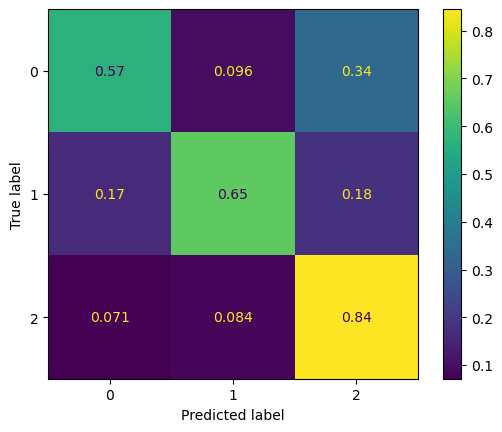

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.68380. Saving Model!
epoch 01, loss: 0.75662, acc: 0.65593, val_loss: 0.68380, val_accuracy: 0.67133


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 02, loss: 0.75413, acc: 0.65896, val_loss: 0.70083, val_accuracy: 0.65615


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 03, loss: 0.74601, acc: 0.66591, val_loss: 0.71430, val_accuracy: 0.65496


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 04, loss: 0.74495, acc: 0.66739, val_loss: 0.72524, val_accuracy: 0.65486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 05, loss: 0.74055, acc: 0.67347, val_loss: 0.73452, val_accuracy: 0.65675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 06, loss: 0.74128, acc: 0.66775, val_loss: 0.73988, val_accuracy: 0.65565


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 07, loss: 0.73774, acc: 0.67277, val_loss: 0.74790, val_accuracy: 0.65694


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 08, loss: 0.73696, acc: 0.67041, val_loss: 0.75390, val_accuracy: 0.63909


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]


epoch 09, loss: 0.73515, acc: 0.67287, val_loss: 0.75984, val_accuracy: 0.63839


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.33it/s]


epoch 10, loss: 0.73444, acc: 0.67454, val_loss: 0.76555, val_accuracy: 0.63899


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]


epoch 11, loss: 0.73194, acc: 0.67504, val_loss: 0.77141, val_accuracy: 0.62867


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]


epoch 12, loss: 0.73185, acc: 0.67745, val_loss: 0.77501, val_accuracy: 0.62937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 13, loss: 0.73033, acc: 0.67513, val_loss: 0.78220, val_accuracy: 0.62956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 14, loss: 0.72952, acc: 0.67876, val_loss: 0.78347, val_accuracy: 0.62758


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 15, loss: 0.72761, acc: 0.67770, val_loss: 0.79128, val_accuracy: 0.63026


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.84it/s]


epoch 16, loss: 0.72806, acc: 0.67608, val_loss: 0.79323, val_accuracy: 0.62778


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 17, loss: 0.72631, acc: 0.67585, val_loss: 0.80170, val_accuracy: 0.62946


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 18, loss: 0.72463, acc: 0.67912, val_loss: 0.80175, val_accuracy: 0.62688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 19, loss: 0.72426, acc: 0.67876, val_loss: 0.81123, val_accuracy: 0.62837


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.00it/s]


epoch 20, loss: 0.72382, acc: 0.67848, val_loss: 0.80940, val_accuracy: 0.62619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 21, loss: 0.72233, acc: 0.67959, val_loss: 0.81891, val_accuracy: 0.62827


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]


epoch 22, loss: 0.72227, acc: 0.67849, val_loss: 0.81867, val_accuracy: 0.62460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.94it/s]


epoch 23, loss: 0.71915, acc: 0.68078, val_loss: 0.82434, val_accuracy: 0.62688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 24, loss: 0.72030, acc: 0.68069, val_loss: 0.82630, val_accuracy: 0.62440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.78it/s]


epoch 25, loss: 0.71818, acc: 0.68084, val_loss: 0.83154, val_accuracy: 0.62718


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66it/s]


epoch 26, loss: 0.71775, acc: 0.68181, val_loss: 0.83114, val_accuracy: 0.62540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


epoch 27, loss: 0.71605, acc: 0.68137, val_loss: 0.84119, val_accuracy: 0.62639


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 28, loss: 0.71695, acc: 0.68079, val_loss: 0.83823, val_accuracy: 0.62480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 29, loss: 0.71421, acc: 0.68072, val_loss: 0.84563, val_accuracy: 0.62718


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 30, loss: 0.71487, acc: 0.68257, val_loss: 0.84536, val_accuracy: 0.62550


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 31, loss: 0.71231, acc: 0.68375, val_loss: 0.85043, val_accuracy: 0.62669


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 32, loss: 0.71240, acc: 0.68211, val_loss: 0.85114, val_accuracy: 0.62460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 33, loss: 0.71108, acc: 0.68419, val_loss: 0.85762, val_accuracy: 0.61062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 34, loss: 0.71150, acc: 0.68177, val_loss: 0.85871, val_accuracy: 0.60784


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 35, loss: 0.70894, acc: 0.68457, val_loss: 0.86466, val_accuracy: 0.61032


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 36, loss: 0.70951, acc: 0.68413, val_loss: 0.86151, val_accuracy: 0.60863


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 37, loss: 0.70873, acc: 0.68283, val_loss: 0.87111, val_accuracy: 0.61131


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 38, loss: 0.70696, acc: 0.68602, val_loss: 0.86924, val_accuracy: 0.60724


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 39, loss: 0.70625, acc: 0.68516, val_loss: 0.87819, val_accuracy: 0.59425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 40, loss: 0.70619, acc: 0.68460, val_loss: 0.87281, val_accuracy: 0.59157


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


epoch 41, loss: 0.70462, acc: 0.68760, val_loss: 0.88591, val_accuracy: 0.59444


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]


epoch 42, loss: 0.70407, acc: 0.68672, val_loss: 0.88427, val_accuracy: 0.59256


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 43, loss: 0.70292, acc: 0.68631, val_loss: 0.89107, val_accuracy: 0.59524


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]


epoch 44, loss: 0.70264, acc: 0.68966, val_loss: 0.88950, val_accuracy: 0.59405


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 45, loss: 0.70226, acc: 0.68686, val_loss: 0.89592, val_accuracy: 0.59385


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 46, loss: 0.69961, acc: 0.69049, val_loss: 0.90014, val_accuracy: 0.59474


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.13it/s]


epoch 47, loss: 0.70092, acc: 0.68770, val_loss: 0.89886, val_accuracy: 0.59673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 48, loss: 0.69861, acc: 0.68900, val_loss: 0.90274, val_accuracy: 0.59524


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 49, loss: 0.69870, acc: 0.68874, val_loss: 0.91030, val_accuracy: 0.59752


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 50, loss: 0.69716, acc: 0.68926, val_loss: 0.90902, val_accuracy: 0.59484


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 51, loss: 0.69652, acc: 0.69090, val_loss: 0.91670, val_accuracy: 0.59623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 52, loss: 0.69758, acc: 0.68905, val_loss: 0.91386, val_accuracy: 0.59702


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 53, loss: 0.69464, acc: 0.68987, val_loss: 0.92303, val_accuracy: 0.59891


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 54, loss: 0.69506, acc: 0.69063, val_loss: 0.92179, val_accuracy: 0.59762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.01it/s]


epoch 55, loss: 0.69277, acc: 0.69048, val_loss: 0.93042, val_accuracy: 0.59851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 56, loss: 0.69472, acc: 0.68985, val_loss: 0.92453, val_accuracy: 0.59841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 57, loss: 0.69095, acc: 0.69106, val_loss: 0.93472, val_accuracy: 0.59603


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 58, loss: 0.69259, acc: 0.69112, val_loss: 0.93601, val_accuracy: 0.59752


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 59, loss: 0.69027, acc: 0.69102, val_loss: 0.94515, val_accuracy: 0.59623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 60, loss: 0.69073, acc: 0.69123, val_loss: 0.93874, val_accuracy: 0.59931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.92it/s]


epoch 61, loss: 0.68947, acc: 0.69048, val_loss: 0.94458, val_accuracy: 0.59712


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.07it/s]


epoch 62, loss: 0.68923, acc: 0.69166, val_loss: 0.94925, val_accuracy: 0.59692


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 63, loss: 0.68757, acc: 0.69123, val_loss: 0.95456, val_accuracy: 0.59792


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 64, loss: 0.68694, acc: 0.69264, val_loss: 0.95454, val_accuracy: 0.59692


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 65, loss: 0.68659, acc: 0.69198, val_loss: 0.95675, val_accuracy: 0.59762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 66, loss: 0.68567, acc: 0.69319, val_loss: 0.96223, val_accuracy: 0.58700


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 67, loss: 0.68554, acc: 0.69297, val_loss: 0.96500, val_accuracy: 0.58879


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 68, loss: 0.68472, acc: 0.69376, val_loss: 0.96735, val_accuracy: 0.58790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 69, loss: 0.68466, acc: 0.69258, val_loss: 0.97312, val_accuracy: 0.58869


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 70, loss: 0.68331, acc: 0.69300, val_loss: 0.97016, val_accuracy: 0.58849


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 71, loss: 0.68217, acc: 0.69392, val_loss: 0.98016, val_accuracy: 0.58839


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20it/s]


epoch 72, loss: 0.68279, acc: 0.69531, val_loss: 0.97969, val_accuracy: 0.58978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.39it/s]


epoch 73, loss: 0.68027, acc: 0.69248, val_loss: 0.98312, val_accuracy: 0.58968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]


epoch 74, loss: 0.68145, acc: 0.69488, val_loss: 0.98377, val_accuracy: 0.59008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 75, loss: 0.67969, acc: 0.69181, val_loss: 0.99315, val_accuracy: 0.59018


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


epoch 76, loss: 0.67860, acc: 0.69716, val_loss: 0.98641, val_accuracy: 0.58978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 77, loss: 0.67828, acc: 0.69185, val_loss: 0.99375, val_accuracy: 0.58998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 78, loss: 0.67714, acc: 0.69836, val_loss: 0.99410, val_accuracy: 0.58958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 79, loss: 0.67628, acc: 0.69442, val_loss: 0.99844, val_accuracy: 0.58909


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.13it/s]


epoch 80, loss: 0.67552, acc: 0.69857, val_loss: 1.00358, val_accuracy: 0.59018


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.94it/s]


epoch 81, loss: 0.67537, acc: 0.69592, val_loss: 1.00354, val_accuracy: 0.59067


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


epoch 82, loss: 0.67304, acc: 0.69705, val_loss: 1.00630, val_accuracy: 0.58998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 83, loss: 0.67480, acc: 0.69794, val_loss: 1.00500, val_accuracy: 0.58948


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 84, loss: 0.67246, acc: 0.69876, val_loss: 1.01690, val_accuracy: 0.58988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 85, loss: 0.67302, acc: 0.69728, val_loss: 1.01521, val_accuracy: 0.58948


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 86, loss: 0.67066, acc: 0.69796, val_loss: 1.01557, val_accuracy: 0.59137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 87, loss: 0.67108, acc: 0.69728, val_loss: 1.02239, val_accuracy: 0.59127


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 88, loss: 0.67075, acc: 0.69727, val_loss: 1.02034, val_accuracy: 0.59107


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.25it/s]


epoch 89, loss: 0.66802, acc: 0.69833, val_loss: 1.03140, val_accuracy: 0.57391


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 90, loss: 0.67032, acc: 0.69736, val_loss: 1.02698, val_accuracy: 0.59077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 91, loss: 0.66631, acc: 0.69865, val_loss: 1.03050, val_accuracy: 0.59167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 92, loss: 0.66918, acc: 0.69779, val_loss: 1.03542, val_accuracy: 0.57421


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 93, loss: 0.66511, acc: 0.69899, val_loss: 1.03492, val_accuracy: 0.57450


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.26it/s]


epoch 94, loss: 0.66695, acc: 0.69942, val_loss: 1.04537, val_accuracy: 0.57510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 95, loss: 0.66540, acc: 0.69898, val_loss: 1.03485, val_accuracy: 0.59107


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 96, loss: 0.66347, acc: 0.70313, val_loss: 1.05025, val_accuracy: 0.57540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 97, loss: 0.66681, acc: 0.69916, val_loss: 1.04298, val_accuracy: 0.57431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 98, loss: 0.66163, acc: 0.70157, val_loss: 1.04854, val_accuracy: 0.59435


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 99, loss: 0.66381, acc: 0.69947, val_loss: 1.05634, val_accuracy: 0.57500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 100, loss: 0.66176, acc: 0.70129, val_loss: 1.05460, val_accuracy: 0.57728


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 101, loss: 0.66248, acc: 0.70071, val_loss: 1.05617, val_accuracy: 0.57480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.74it/s]


epoch 102, loss: 0.66104, acc: 0.70253, val_loss: 1.06395, val_accuracy: 0.57748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 103, loss: 0.66035, acc: 0.70250, val_loss: 1.05913, val_accuracy: 0.57440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 104, loss: 0.66106, acc: 0.70336, val_loss: 1.07278, val_accuracy: 0.57500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 105, loss: 0.65844, acc: 0.70382, val_loss: 1.06694, val_accuracy: 0.59157


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 106, loss: 0.65995, acc: 0.70444, val_loss: 1.06932, val_accuracy: 0.57679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 107, loss: 0.65811, acc: 0.70290, val_loss: 1.06965, val_accuracy: 0.59067


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.91it/s]


epoch 108, loss: 0.65756, acc: 0.70627, val_loss: 1.08049, val_accuracy: 0.57560


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 109, loss: 0.65650, acc: 0.70474, val_loss: 1.07479, val_accuracy: 0.59137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 110, loss: 0.65555, acc: 0.70784, val_loss: 1.07941, val_accuracy: 0.57738


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 111, loss: 0.65474, acc: 0.70572, val_loss: 1.08478, val_accuracy: 0.57500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 112, loss: 0.65403, acc: 0.70838, val_loss: 1.08258, val_accuracy: 0.57798


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 113, loss: 0.65327, acc: 0.70582, val_loss: 1.08873, val_accuracy: 0.56260


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 114, loss: 0.65308, acc: 0.70842, val_loss: 1.09677, val_accuracy: 0.56478


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]


epoch 115, loss: 0.65203, acc: 0.70699, val_loss: 1.08945, val_accuracy: 0.56310


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 116, loss: 0.65231, acc: 0.70958, val_loss: 1.10124, val_accuracy: 0.56538


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.17it/s]


epoch 117, loss: 0.65235, acc: 0.70645, val_loss: 1.09357, val_accuracy: 0.56260


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 118, loss: 0.65030, acc: 0.70685, val_loss: 1.10636, val_accuracy: 0.56409


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 119, loss: 0.65000, acc: 0.71083, val_loss: 1.09956, val_accuracy: 0.56369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 120, loss: 0.64991, acc: 0.70700, val_loss: 1.11148, val_accuracy: 0.56687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 121, loss: 0.64750, acc: 0.70965, val_loss: 1.10465, val_accuracy: 0.56468


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 122, loss: 0.64854, acc: 0.70778, val_loss: 1.11055, val_accuracy: 0.56607


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 123, loss: 0.64616, acc: 0.71160, val_loss: 1.11305, val_accuracy: 0.56389


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 124, loss: 0.64612, acc: 0.71141, val_loss: 1.11242, val_accuracy: 0.56786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 125, loss: 0.64461, acc: 0.71020, val_loss: 1.11570, val_accuracy: 0.56597


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 126, loss: 0.64536, acc: 0.71497, val_loss: 1.11295, val_accuracy: 0.56637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 127, loss: 0.64346, acc: 0.71154, val_loss: 1.11761, val_accuracy: 0.56607


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 128, loss: 0.64238, acc: 0.71612, val_loss: 1.11696, val_accuracy: 0.56637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 129, loss: 0.64280, acc: 0.71373, val_loss: 1.12486, val_accuracy: 0.56677


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 130, loss: 0.64123, acc: 0.71323, val_loss: 1.13071, val_accuracy: 0.56716


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 131, loss: 0.64126, acc: 0.71440, val_loss: 1.12583, val_accuracy: 0.56667


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


epoch 132, loss: 0.64004, acc: 0.71355, val_loss: 1.13517, val_accuracy: 0.56647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 133, loss: 0.63994, acc: 0.71794, val_loss: 1.12795, val_accuracy: 0.56915


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 134, loss: 0.63831, acc: 0.71367, val_loss: 1.13673, val_accuracy: 0.56786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 135, loss: 0.63994, acc: 0.71669, val_loss: 1.14393, val_accuracy: 0.56855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 136, loss: 0.63695, acc: 0.71428, val_loss: 1.14101, val_accuracy: 0.56925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 137, loss: 0.63830, acc: 0.71519, val_loss: 1.14432, val_accuracy: 0.56825


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 138, loss: 0.63772, acc: 0.71601, val_loss: 1.14102, val_accuracy: 0.56925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 139, loss: 0.63657, acc: 0.71731, val_loss: 1.15018, val_accuracy: 0.56855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


epoch 140, loss: 0.63621, acc: 0.71777, val_loss: 1.14468, val_accuracy: 0.56687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 141, loss: 0.63501, acc: 0.71969, val_loss: 1.15736, val_accuracy: 0.57073


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 142, loss: 0.63508, acc: 0.71562, val_loss: 1.15019, val_accuracy: 0.56925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 143, loss: 0.63369, acc: 0.71761, val_loss: 1.16433, val_accuracy: 0.56558


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]


epoch 144, loss: 0.63405, acc: 0.71542, val_loss: 1.15362, val_accuracy: 0.56994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 145, loss: 0.63247, acc: 0.71727, val_loss: 1.16072, val_accuracy: 0.56815


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 146, loss: 0.63179, acc: 0.72039, val_loss: 1.16281, val_accuracy: 0.56329


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 147, loss: 0.63166, acc: 0.72108, val_loss: 1.16645, val_accuracy: 0.56905


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 148, loss: 0.62927, acc: 0.72068, val_loss: 1.17260, val_accuracy: 0.56478


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]


epoch 149, loss: 0.63219, acc: 0.71962, val_loss: 1.17126, val_accuracy: 0.57133


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 150, loss: 0.62895, acc: 0.72373, val_loss: 1.17540, val_accuracy: 0.56508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 151, loss: 0.63072, acc: 0.72080, val_loss: 1.16562, val_accuracy: 0.57054


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 152, loss: 0.62703, acc: 0.72532, val_loss: 1.17534, val_accuracy: 0.56448


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 153, loss: 0.62926, acc: 0.72074, val_loss: 1.17870, val_accuracy: 0.56835


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 154, loss: 0.62514, acc: 0.72691, val_loss: 1.18295, val_accuracy: 0.56498


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.33it/s]


epoch 155, loss: 0.62798, acc: 0.72114, val_loss: 1.17782, val_accuracy: 0.56786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 156, loss: 0.62412, acc: 0.72559, val_loss: 1.18313, val_accuracy: 0.56617


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 157, loss: 0.62726, acc: 0.72233, val_loss: 1.18132, val_accuracy: 0.57163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 158, loss: 0.62287, acc: 0.72614, val_loss: 1.19031, val_accuracy: 0.56696


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 159, loss: 0.62677, acc: 0.71870, val_loss: 1.19210, val_accuracy: 0.56835


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 160, loss: 0.62522, acc: 0.72575, val_loss: 1.18938, val_accuracy: 0.56558


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 161, loss: 0.62221, acc: 0.72684, val_loss: 1.20130, val_accuracy: 0.56964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 162, loss: 0.62319, acc: 0.72520, val_loss: 1.19311, val_accuracy: 0.56597


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.72it/s]


epoch 163, loss: 0.62185, acc: 0.72626, val_loss: 1.20381, val_accuracy: 0.57024


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 164, loss: 0.62108, acc: 0.72641, val_loss: 1.19671, val_accuracy: 0.56667


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 165, loss: 0.62126, acc: 0.72550, val_loss: 1.20787, val_accuracy: 0.57073


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 166, loss: 0.61910, acc: 0.72646, val_loss: 1.19625, val_accuracy: 0.56647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 167, loss: 0.61992, acc: 0.72651, val_loss: 1.22209, val_accuracy: 0.57183


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 168, loss: 0.61827, acc: 0.72709, val_loss: 1.19999, val_accuracy: 0.56587


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 169, loss: 0.61899, acc: 0.72928, val_loss: 1.21954, val_accuracy: 0.57093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 170, loss: 0.61729, acc: 0.72790, val_loss: 1.21026, val_accuracy: 0.56776


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 171, loss: 0.61693, acc: 0.72715, val_loss: 1.21766, val_accuracy: 0.57113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 172, loss: 0.61573, acc: 0.72682, val_loss: 1.21934, val_accuracy: 0.56716


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 173, loss: 0.61619, acc: 0.73043, val_loss: 1.21924, val_accuracy: 0.57242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 174, loss: 0.61357, acc: 0.72854, val_loss: 1.22649, val_accuracy: 0.56964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 175, loss: 0.61529, acc: 0.72790, val_loss: 1.22046, val_accuracy: 0.57272


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 176, loss: 0.61287, acc: 0.73014, val_loss: 1.21989, val_accuracy: 0.57063


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 177, loss: 0.61300, acc: 0.72806, val_loss: 1.23442, val_accuracy: 0.57292


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.01it/s]


epoch 178, loss: 0.61293, acc: 0.72917, val_loss: 1.22653, val_accuracy: 0.57093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 179, loss: 0.61297, acc: 0.72646, val_loss: 1.23560, val_accuracy: 0.57351


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 180, loss: 0.61123, acc: 0.73185, val_loss: 1.22586, val_accuracy: 0.57034


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 181, loss: 0.61304, acc: 0.72743, val_loss: 1.24507, val_accuracy: 0.57351


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 182, loss: 0.60919, acc: 0.73067, val_loss: 1.23436, val_accuracy: 0.57163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


epoch 183, loss: 0.61024, acc: 0.72865, val_loss: 1.24375, val_accuracy: 0.57440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 184, loss: 0.60860, acc: 0.73202, val_loss: 1.22642, val_accuracy: 0.57123


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 185, loss: 0.60921, acc: 0.72929, val_loss: 1.25850, val_accuracy: 0.57579


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]


epoch 186, loss: 0.60962, acc: 0.72880, val_loss: 1.23961, val_accuracy: 0.56944


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 187, loss: 0.60756, acc: 0.73525, val_loss: 1.25698, val_accuracy: 0.57272


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 188, loss: 0.60794, acc: 0.73093, val_loss: 1.23869, val_accuracy: 0.57044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 189, loss: 0.60626, acc: 0.73787, val_loss: 1.24544, val_accuracy: 0.57431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 190, loss: 0.60599, acc: 0.73288, val_loss: 1.25090, val_accuracy: 0.57173


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 191, loss: 0.60535, acc: 0.73509, val_loss: 1.25984, val_accuracy: 0.57550


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 192, loss: 0.60543, acc: 0.73180, val_loss: 1.26086, val_accuracy: 0.57381


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 193, loss: 0.60483, acc: 0.73342, val_loss: 1.25218, val_accuracy: 0.57500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 194, loss: 0.60344, acc: 0.73490, val_loss: 1.25542, val_accuracy: 0.57302


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


epoch 195, loss: 0.60359, acc: 0.73695, val_loss: 1.26935, val_accuracy: 0.57609


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 196, loss: 0.60116, acc: 0.73584, val_loss: 1.26465, val_accuracy: 0.57480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 197, loss: 0.60267, acc: 0.73417, val_loss: 1.27416, val_accuracy: 0.57629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]


epoch 198, loss: 0.59946, acc: 0.73629, val_loss: 1.25943, val_accuracy: 0.57361


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66it/s]


epoch 199, loss: 0.60372, acc: 0.73255, val_loss: 1.28064, val_accuracy: 0.57540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.03it/s]


epoch 200, loss: 0.60043, acc: 0.73636, val_loss: 1.27419, val_accuracy: 0.57381


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 201, loss: 0.60177, acc: 0.73588, val_loss: 1.26606, val_accuracy: 0.57272


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.39it/s]


epoch 202, loss: 0.59756, acc: 0.73774, val_loss: 1.29103, val_accuracy: 0.57421


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 203, loss: 0.60048, acc: 0.73897, val_loss: 1.27095, val_accuracy: 0.57589


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 204, loss: 0.59602, acc: 0.73757, val_loss: 1.28870, val_accuracy: 0.57629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 205, loss: 0.60014, acc: 0.73653, val_loss: 1.28109, val_accuracy: 0.57659


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 206, loss: 0.59649, acc: 0.73827, val_loss: 1.27681, val_accuracy: 0.57460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 207, loss: 0.59769, acc: 0.73756, val_loss: 1.29808, val_accuracy: 0.57738


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.70it/s]


epoch 208, loss: 0.59593, acc: 0.73876, val_loss: 1.27479, val_accuracy: 0.57460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 209, loss: 0.59497, acc: 0.73918, val_loss: 1.29852, val_accuracy: 0.57738


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 210, loss: 0.59485, acc: 0.74105, val_loss: 1.28408, val_accuracy: 0.57470


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.53it/s]


epoch 211, loss: 0.59359, acc: 0.74078, val_loss: 1.29545, val_accuracy: 0.57698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 212, loss: 0.59412, acc: 0.73731, val_loss: 1.28832, val_accuracy: 0.57560


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 213, loss: 0.59383, acc: 0.73943, val_loss: 1.29841, val_accuracy: 0.57629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 214, loss: 0.59121, acc: 0.74015, val_loss: 1.29250, val_accuracy: 0.57619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 215, loss: 0.59289, acc: 0.74265, val_loss: 1.28865, val_accuracy: 0.57808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.02it/s]


epoch 216, loss: 0.59078, acc: 0.73813, val_loss: 1.28877, val_accuracy: 0.57550


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 217, loss: 0.59163, acc: 0.74133, val_loss: 1.31742, val_accuracy: 0.57847


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 218, loss: 0.59441, acc: 0.73696, val_loss: 1.28528, val_accuracy: 0.57431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.05it/s]


epoch 219, loss: 0.58900, acc: 0.74274, val_loss: 1.32402, val_accuracy: 0.57778


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 220, loss: 0.59054, acc: 0.74134, val_loss: 1.28896, val_accuracy: 0.57579


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 221, loss: 0.58969, acc: 0.74224, val_loss: 1.31930, val_accuracy: 0.57897


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 222, loss: 0.58836, acc: 0.73917, val_loss: 1.29371, val_accuracy: 0.57758


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.68it/s]


epoch 223, loss: 0.58771, acc: 0.74258, val_loss: 1.31720, val_accuracy: 0.57778


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.78it/s]


epoch 224, loss: 0.58649, acc: 0.74318, val_loss: 1.31169, val_accuracy: 0.57887


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.76it/s]


epoch 225, loss: 0.58605, acc: 0.74307, val_loss: 1.30787, val_accuracy: 0.57976


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.85it/s]


epoch 226, loss: 0.58605, acc: 0.74108, val_loss: 1.32582, val_accuracy: 0.57907


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.76it/s]


epoch 227, loss: 0.58454, acc: 0.74274, val_loss: 1.29369, val_accuracy: 0.57946


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]


epoch 228, loss: 0.58517, acc: 0.74190, val_loss: 1.32186, val_accuracy: 0.57887


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 229, loss: 0.58472, acc: 0.74360, val_loss: 1.31689, val_accuracy: 0.57867


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 230, loss: 0.58441, acc: 0.74591, val_loss: 1.31308, val_accuracy: 0.58026


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 231, loss: 0.58448, acc: 0.74005, val_loss: 1.33477, val_accuracy: 0.58006


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.88it/s]


epoch 232, loss: 0.58273, acc: 0.74563, val_loss: 1.32235, val_accuracy: 0.58006


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.92it/s]


epoch 233, loss: 0.58565, acc: 0.74132, val_loss: 1.33746, val_accuracy: 0.57956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 234, loss: 0.58217, acc: 0.74382, val_loss: 1.31708, val_accuracy: 0.57927


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 235, loss: 0.58257, acc: 0.74407, val_loss: 1.33541, val_accuracy: 0.58026


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 236, loss: 0.58128, acc: 0.74764, val_loss: 1.33500, val_accuracy: 0.57907


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 237, loss: 0.58147, acc: 0.74635, val_loss: 1.33915, val_accuracy: 0.58046


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 238, loss: 0.57881, acc: 0.74357, val_loss: 1.33868, val_accuracy: 0.58075


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 239, loss: 0.58032, acc: 0.74598, val_loss: 1.34084, val_accuracy: 0.58145


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 240, loss: 0.57906, acc: 0.74935, val_loss: 1.33334, val_accuracy: 0.58006


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.00it/s]


epoch 241, loss: 0.57732, acc: 0.74691, val_loss: 1.35543, val_accuracy: 0.58234


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]


epoch 242, loss: 0.57851, acc: 0.74570, val_loss: 1.32037, val_accuracy: 0.58016


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.98it/s]


epoch 243, loss: 0.57725, acc: 0.74980, val_loss: 1.35141, val_accuracy: 0.58194


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


epoch 244, loss: 0.57900, acc: 0.74433, val_loss: 1.33831, val_accuracy: 0.58075


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 245, loss: 0.57497, acc: 0.74741, val_loss: 1.35052, val_accuracy: 0.58145


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 246, loss: 0.57671, acc: 0.74692, val_loss: 1.34720, val_accuracy: 0.58165


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 247, loss: 0.57430, acc: 0.74741, val_loss: 1.35520, val_accuracy: 0.58373


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.82it/s]


epoch 248, loss: 0.57461, acc: 0.74915, val_loss: 1.35742, val_accuracy: 0.58194


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 249, loss: 0.57458, acc: 0.74721, val_loss: 1.35668, val_accuracy: 0.58393


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 250, loss: 0.57272, acc: 0.74836, val_loss: 1.34735, val_accuracy: 0.58105


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 251, loss: 0.57482, acc: 0.74814, val_loss: 1.37484, val_accuracy: 0.58204


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 252, loss: 0.57414, acc: 0.74947, val_loss: 1.34693, val_accuracy: 0.58115


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 253, loss: 0.57167, acc: 0.74828, val_loss: 1.36985, val_accuracy: 0.58155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 254, loss: 0.57194, acc: 0.74997, val_loss: 1.35765, val_accuracy: 0.58204


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.11it/s]


epoch 255, loss: 0.57096, acc: 0.74838, val_loss: 1.36841, val_accuracy: 0.58542


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 256, loss: 0.57140, acc: 0.74791, val_loss: 1.36964, val_accuracy: 0.58254


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 257, loss: 0.56941, acc: 0.75064, val_loss: 1.36500, val_accuracy: 0.58363


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 258, loss: 0.57072, acc: 0.74785, val_loss: 1.36911, val_accuracy: 0.58373


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 259, loss: 0.56911, acc: 0.74971, val_loss: 1.37005, val_accuracy: 0.58383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 260, loss: 0.56842, acc: 0.75073, val_loss: 1.37942, val_accuracy: 0.58353


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 261, loss: 0.56787, acc: 0.75108, val_loss: 1.36974, val_accuracy: 0.58413


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 262, loss: 0.56809, acc: 0.75161, val_loss: 1.37058, val_accuracy: 0.58552


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 263, loss: 0.56591, acc: 0.75107, val_loss: 1.38812, val_accuracy: 0.58204


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]


epoch 264, loss: 0.56917, acc: 0.75011, val_loss: 1.36474, val_accuracy: 0.58214


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 265, loss: 0.56613, acc: 0.75375, val_loss: 1.38382, val_accuracy: 0.58333


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 266, loss: 0.56679, acc: 0.75535, val_loss: 1.37406, val_accuracy: 0.58512


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.11it/s]


epoch 267, loss: 0.56574, acc: 0.75269, val_loss: 1.37988, val_accuracy: 0.58185


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


epoch 268, loss: 0.56433, acc: 0.75484, val_loss: 1.39015, val_accuracy: 0.58532


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 269, loss: 0.56496, acc: 0.75363, val_loss: 1.38719, val_accuracy: 0.58383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.92it/s]


epoch 270, loss: 0.56313, acc: 0.75425, val_loss: 1.38764, val_accuracy: 0.58482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 271, loss: 0.56416, acc: 0.75176, val_loss: 1.39517, val_accuracy: 0.58125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 272, loss: 0.56307, acc: 0.75556, val_loss: 1.37910, val_accuracy: 0.58552


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 273, loss: 0.56331, acc: 0.75442, val_loss: 1.40550, val_accuracy: 0.58512


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 274, loss: 0.56197, acc: 0.75688, val_loss: 1.39341, val_accuracy: 0.58562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.00it/s]


epoch 275, loss: 0.56124, acc: 0.75479, val_loss: 1.39113, val_accuracy: 0.58462


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.78it/s]


epoch 276, loss: 0.55971, acc: 0.75805, val_loss: 1.41468, val_accuracy: 0.58581


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 277, loss: 0.56117, acc: 0.75527, val_loss: 1.38718, val_accuracy: 0.58383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.72it/s]


epoch 278, loss: 0.55863, acc: 0.75729, val_loss: 1.41084, val_accuracy: 0.58502


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 279, loss: 0.56016, acc: 0.75878, val_loss: 1.39689, val_accuracy: 0.58641


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


epoch 280, loss: 0.56032, acc: 0.75417, val_loss: 1.40623, val_accuracy: 0.58562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 281, loss: 0.55840, acc: 0.75624, val_loss: 1.40148, val_accuracy: 0.58591


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.91it/s]


epoch 282, loss: 0.55830, acc: 0.75933, val_loss: 1.40496, val_accuracy: 0.58482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 283, loss: 0.55817, acc: 0.75605, val_loss: 1.41043, val_accuracy: 0.58611


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]


epoch 284, loss: 0.55758, acc: 0.75565, val_loss: 1.41261, val_accuracy: 0.58710


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.20it/s]


epoch 285, loss: 0.55720, acc: 0.75763, val_loss: 1.40958, val_accuracy: 0.58571


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 286, loss: 0.55546, acc: 0.76071, val_loss: 1.42010, val_accuracy: 0.58621


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 287, loss: 0.55701, acc: 0.75628, val_loss: 1.40692, val_accuracy: 0.58264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 288, loss: 0.55474, acc: 0.76267, val_loss: 1.40992, val_accuracy: 0.58661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 289, loss: 0.55525, acc: 0.75730, val_loss: 1.41635, val_accuracy: 0.58760


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 290, loss: 0.55334, acc: 0.76233, val_loss: 1.41544, val_accuracy: 0.58681


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 291, loss: 0.55414, acc: 0.75848, val_loss: 1.41794, val_accuracy: 0.58651


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 292, loss: 0.55373, acc: 0.76162, val_loss: 1.41451, val_accuracy: 0.58730


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.66it/s]


epoch 293, loss: 0.55232, acc: 0.75932, val_loss: 1.41486, val_accuracy: 0.58462


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 294, loss: 0.55278, acc: 0.75939, val_loss: 1.44614, val_accuracy: 0.58710


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.77it/s]


epoch 295, loss: 0.55414, acc: 0.75665, val_loss: 1.40854, val_accuracy: 0.58472


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]


epoch 296, loss: 0.55001, acc: 0.76604, val_loss: 1.41073, val_accuracy: 0.58671


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 297, loss: 0.55404, acc: 0.75795, val_loss: 1.42808, val_accuracy: 0.58681


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 298, loss: 0.55112, acc: 0.75873, val_loss: 1.42533, val_accuracy: 0.58750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 299, loss: 0.55091, acc: 0.75878, val_loss: 1.43696, val_accuracy: 0.58641


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 300, loss: 0.54805, acc: 0.76451, val_loss: 1.43139, val_accuracy: 0.58869


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.91it/s]


epoch 301, loss: 0.54984, acc: 0.76052, val_loss: 1.43586, val_accuracy: 0.58978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 302, loss: 0.54873, acc: 0.76377, val_loss: 1.43838, val_accuracy: 0.58859


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 303, loss: 0.54850, acc: 0.76040, val_loss: 1.43626, val_accuracy: 0.58661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 304, loss: 0.54785, acc: 0.76715, val_loss: 1.44160, val_accuracy: 0.58849


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 305, loss: 0.54872, acc: 0.75968, val_loss: 1.45235, val_accuracy: 0.58889


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 306, loss: 0.54817, acc: 0.76402, val_loss: 1.43430, val_accuracy: 0.58760


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 307, loss: 0.54719, acc: 0.76161, val_loss: 1.44041, val_accuracy: 0.58512


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]


epoch 308, loss: 0.54630, acc: 0.76754, val_loss: 1.45198, val_accuracy: 0.58671


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20it/s]


epoch 309, loss: 0.54685, acc: 0.76125, val_loss: 1.45636, val_accuracy: 0.58571


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 310, loss: 0.54527, acc: 0.76688, val_loss: 1.43811, val_accuracy: 0.58998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 311, loss: 0.54429, acc: 0.76237, val_loss: 1.45687, val_accuracy: 0.58800


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 312, loss: 0.54550, acc: 0.76433, val_loss: 1.43820, val_accuracy: 0.58958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 313, loss: 0.54326, acc: 0.76249, val_loss: 1.45332, val_accuracy: 0.58760


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 314, loss: 0.54618, acc: 0.76362, val_loss: 1.45885, val_accuracy: 0.58869


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 315, loss: 0.54308, acc: 0.76496, val_loss: 1.43282, val_accuracy: 0.58492


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 316, loss: 0.54260, acc: 0.76907, val_loss: 1.44946, val_accuracy: 0.58681


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 317, loss: 0.54276, acc: 0.76660, val_loss: 1.44477, val_accuracy: 0.59038


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 318, loss: 0.54092, acc: 0.76844, val_loss: 1.46009, val_accuracy: 0.59067


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 319, loss: 0.54147, acc: 0.76355, val_loss: 1.46919, val_accuracy: 0.58998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 320, loss: 0.54073, acc: 0.77011, val_loss: 1.46353, val_accuracy: 0.58790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.06it/s]


epoch 321, loss: 0.53964, acc: 0.76524, val_loss: 1.45525, val_accuracy: 0.58810


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 322, loss: 0.53901, acc: 0.77020, val_loss: 1.46353, val_accuracy: 0.59286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 323, loss: 0.53994, acc: 0.76591, val_loss: 1.45926, val_accuracy: 0.59226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 324, loss: 0.53872, acc: 0.77034, val_loss: 1.46988, val_accuracy: 0.57540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 325, loss: 0.53940, acc: 0.76811, val_loss: 1.45251, val_accuracy: 0.59315


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 326, loss: 0.53607, acc: 0.76969, val_loss: 1.45234, val_accuracy: 0.59306


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 327, loss: 0.53879, acc: 0.76730, val_loss: 1.46508, val_accuracy: 0.59345


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 328, loss: 0.53567, acc: 0.77252, val_loss: 1.47116, val_accuracy: 0.59296


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 329, loss: 0.53769, acc: 0.76686, val_loss: 1.47100, val_accuracy: 0.58889


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 330, loss: 0.53557, acc: 0.76968, val_loss: 1.48169, val_accuracy: 0.59226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 331, loss: 0.53623, acc: 0.76777, val_loss: 1.46485, val_accuracy: 0.59147


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 332, loss: 0.53459, acc: 0.77277, val_loss: 1.46124, val_accuracy: 0.59335


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 333, loss: 0.53603, acc: 0.77148, val_loss: 1.49040, val_accuracy: 0.57520


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 334, loss: 0.53481, acc: 0.77255, val_loss: 1.44501, val_accuracy: 0.59335


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 335, loss: 0.53403, acc: 0.76839, val_loss: 1.50002, val_accuracy: 0.57629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 336, loss: 0.53411, acc: 0.77016, val_loss: 1.44073, val_accuracy: 0.59375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 337, loss: 0.53390, acc: 0.76871, val_loss: 1.47092, val_accuracy: 0.59127


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 338, loss: 0.53255, acc: 0.77130, val_loss: 1.48477, val_accuracy: 0.59504


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 339, loss: 0.53326, acc: 0.77022, val_loss: 1.48350, val_accuracy: 0.57966


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 340, loss: 0.53243, acc: 0.77323, val_loss: 1.48202, val_accuracy: 0.57817


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 341, loss: 0.53110, acc: 0.77379, val_loss: 1.49652, val_accuracy: 0.57956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 342, loss: 0.53327, acc: 0.77176, val_loss: 1.47555, val_accuracy: 0.57738


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.03it/s]


epoch 343, loss: 0.52832, acc: 0.77489, val_loss: 1.50237, val_accuracy: 0.58095


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 344, loss: 0.53106, acc: 0.77238, val_loss: 1.47163, val_accuracy: 0.57897


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 345, loss: 0.52901, acc: 0.77090, val_loss: 1.51097, val_accuracy: 0.57530


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.33it/s]


epoch 346, loss: 0.53235, acc: 0.76977, val_loss: 1.48864, val_accuracy: 0.57917


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 347, loss: 0.52908, acc: 0.77530, val_loss: 1.48072, val_accuracy: 0.57450


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 348, loss: 0.52995, acc: 0.77261, val_loss: 1.50825, val_accuracy: 0.57986


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


epoch 349, loss: 0.53055, acc: 0.76902, val_loss: 1.49719, val_accuracy: 0.57431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 350, loss: 0.53347, acc: 0.77196, val_loss: 1.48882, val_accuracy: 0.57569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 351, loss: 0.53045, acc: 0.77201, val_loss: 1.52257, val_accuracy: 0.57827


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 352, loss: 0.53060, acc: 0.76778, val_loss: 1.48957, val_accuracy: 0.57698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 353, loss: 0.52741, acc: 0.77465, val_loss: 1.51938, val_accuracy: 0.57540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 354, loss: 0.52508, acc: 0.77759, val_loss: 1.50281, val_accuracy: 0.57798


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 355, loss: 0.52811, acc: 0.77154, val_loss: 1.47153, val_accuracy: 0.57907


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 356, loss: 0.52302, acc: 0.77875, val_loss: 1.51869, val_accuracy: 0.58075


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 357, loss: 0.52520, acc: 0.77432, val_loss: 1.48792, val_accuracy: 0.58026


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 358, loss: 0.52469, acc: 0.77839, val_loss: 1.50022, val_accuracy: 0.57937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.76it/s]


epoch 359, loss: 0.52235, acc: 0.77913, val_loss: 1.51467, val_accuracy: 0.58185


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 360, loss: 0.52662, acc: 0.77271, val_loss: 1.49809, val_accuracy: 0.57659


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 361, loss: 0.52085, acc: 0.77754, val_loss: 1.52587, val_accuracy: 0.57976


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 362, loss: 0.52326, acc: 0.77445, val_loss: 1.51948, val_accuracy: 0.57857


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


epoch 363, loss: 0.52109, acc: 0.77541, val_loss: 1.53183, val_accuracy: 0.58065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 364, loss: 0.52282, acc: 0.77692, val_loss: 1.52596, val_accuracy: 0.57887


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 365, loss: 0.52175, acc: 0.77625, val_loss: 1.49990, val_accuracy: 0.57867


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 366, loss: 0.52041, acc: 0.77762, val_loss: 1.53899, val_accuracy: 0.58085


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 367, loss: 0.52124, acc: 0.77497, val_loss: 1.50831, val_accuracy: 0.58522


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 368, loss: 0.52098, acc: 0.77634, val_loss: 1.52341, val_accuracy: 0.57976


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 369, loss: 0.52250, acc: 0.77365, val_loss: 1.54148, val_accuracy: 0.58294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


epoch 370, loss: 0.52030, acc: 0.77669, val_loss: 1.54037, val_accuracy: 0.58065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 371, loss: 0.51981, acc: 0.77917, val_loss: 1.53529, val_accuracy: 0.58155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


epoch 372, loss: 0.51824, acc: 0.78044, val_loss: 1.54947, val_accuracy: 0.58323


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


epoch 373, loss: 0.51888, acc: 0.77539, val_loss: 1.51591, val_accuracy: 0.58175


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 374, loss: 0.51719, acc: 0.78130, val_loss: 1.57073, val_accuracy: 0.58105


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 375, loss: 0.51893, acc: 0.77795, val_loss: 1.53900, val_accuracy: 0.58105


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 376, loss: 0.51639, acc: 0.77894, val_loss: 1.55636, val_accuracy: 0.57867


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.78it/s]


epoch 377, loss: 0.51698, acc: 0.78049, val_loss: 1.54468, val_accuracy: 0.58284


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 378, loss: 0.51693, acc: 0.77816, val_loss: 1.56112, val_accuracy: 0.57937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.96it/s]


epoch 379, loss: 0.51578, acc: 0.78226, val_loss: 1.54351, val_accuracy: 0.58214


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 380, loss: 0.51652, acc: 0.78023, val_loss: 1.56639, val_accuracy: 0.58274


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 381, loss: 0.51424, acc: 0.78229, val_loss: 1.52846, val_accuracy: 0.58452


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 382, loss: 0.51535, acc: 0.77926, val_loss: 1.56620, val_accuracy: 0.58065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 383, loss: 0.51616, acc: 0.77672, val_loss: 1.55520, val_accuracy: 0.58413


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 384, loss: 0.51238, acc: 0.78024, val_loss: 1.56225, val_accuracy: 0.58433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 385, loss: 0.51434, acc: 0.77688, val_loss: 1.56446, val_accuracy: 0.58482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 386, loss: 0.51239, acc: 0.78196, val_loss: 1.56582, val_accuracy: 0.58294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 387, loss: 0.51330, acc: 0.77923, val_loss: 1.56865, val_accuracy: 0.58393


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 388, loss: 0.51266, acc: 0.78025, val_loss: 1.57272, val_accuracy: 0.58046


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 389, loss: 0.51507, acc: 0.77795, val_loss: 1.55203, val_accuracy: 0.58284


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 390, loss: 0.51146, acc: 0.78273, val_loss: 1.59588, val_accuracy: 0.58194


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 391, loss: 0.51332, acc: 0.78107, val_loss: 1.55803, val_accuracy: 0.58165


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 392, loss: 0.51079, acc: 0.78247, val_loss: 1.58791, val_accuracy: 0.58452


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 393, loss: 0.51214, acc: 0.77932, val_loss: 1.58266, val_accuracy: 0.58552


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 394, loss: 0.51104, acc: 0.78063, val_loss: 1.58153, val_accuracy: 0.58294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.05it/s]


epoch 395, loss: 0.50927, acc: 0.78509, val_loss: 1.58457, val_accuracy: 0.58274


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 396, loss: 0.51055, acc: 0.78319, val_loss: 1.59370, val_accuracy: 0.58343


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 397, loss: 0.50892, acc: 0.78443, val_loss: 1.59007, val_accuracy: 0.58542


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 398, loss: 0.50822, acc: 0.78252, val_loss: 1.58415, val_accuracy: 0.58383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 399, loss: 0.50753, acc: 0.78452, val_loss: 1.58069, val_accuracy: 0.58353


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 400, loss: 0.50745, acc: 0.78284, val_loss: 1.59351, val_accuracy: 0.58433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 401, loss: 0.50742, acc: 0.78153, val_loss: 1.58314, val_accuracy: 0.58750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.05it/s]


epoch 402, loss: 0.50714, acc: 0.78269, val_loss: 1.60333, val_accuracy: 0.58661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 403, loss: 0.50773, acc: 0.78243, val_loss: 1.55809, val_accuracy: 0.58591


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 404, loss: 0.50572, acc: 0.78625, val_loss: 1.61127, val_accuracy: 0.58839


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


epoch 405, loss: 0.50768, acc: 0.77876, val_loss: 1.58561, val_accuracy: 0.58591


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 406, loss: 0.50519, acc: 0.78695, val_loss: 1.62191, val_accuracy: 0.58462


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 407, loss: 0.50695, acc: 0.78015, val_loss: 1.59205, val_accuracy: 0.58760


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 408, loss: 0.50568, acc: 0.78489, val_loss: 1.61487, val_accuracy: 0.58433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 409, loss: 0.50754, acc: 0.78244, val_loss: 1.60176, val_accuracy: 0.58452


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 410, loss: 0.50368, acc: 0.78699, val_loss: 1.63788, val_accuracy: 0.58730


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 411, loss: 0.50680, acc: 0.78009, val_loss: 1.58808, val_accuracy: 0.58601


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 412, loss: 0.50294, acc: 0.78453, val_loss: 1.64231, val_accuracy: 0.58800


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 413, loss: 0.50650, acc: 0.78242, val_loss: 1.59617, val_accuracy: 0.58760


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.19it/s]


epoch 414, loss: 0.50155, acc: 0.78535, val_loss: 1.63593, val_accuracy: 0.58353


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 415, loss: 0.50326, acc: 0.78343, val_loss: 1.62112, val_accuracy: 0.58591


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.22it/s]


epoch 416, loss: 0.50367, acc: 0.78352, val_loss: 1.63436, val_accuracy: 0.58601


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 417, loss: 0.50004, acc: 0.78623, val_loss: 1.62919, val_accuracy: 0.58552


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.02it/s]


epoch 418, loss: 0.50268, acc: 0.78419, val_loss: 1.65636, val_accuracy: 0.58562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 419, loss: 0.49958, acc: 0.78900, val_loss: 1.61201, val_accuracy: 0.58611


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


epoch 420, loss: 0.50104, acc: 0.78473, val_loss: 1.66268, val_accuracy: 0.58720


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 421, loss: 0.50050, acc: 0.78378, val_loss: 1.62744, val_accuracy: 0.58899


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 422, loss: 0.50012, acc: 0.78559, val_loss: 1.63534, val_accuracy: 0.58889


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 423, loss: 0.49813, acc: 0.78763, val_loss: 1.64962, val_accuracy: 0.58948


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 424, loss: 0.49966, acc: 0.78623, val_loss: 1.66426, val_accuracy: 0.58591


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 425, loss: 0.49954, acc: 0.78837, val_loss: 1.63989, val_accuracy: 0.58740


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 426, loss: 0.49767, acc: 0.78653, val_loss: 1.68734, val_accuracy: 0.58780


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 427, loss: 0.49921, acc: 0.78639, val_loss: 1.65643, val_accuracy: 0.58948


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 428, loss: 0.49722, acc: 0.78710, val_loss: 1.65602, val_accuracy: 0.58720


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 429, loss: 0.49835, acc: 0.78402, val_loss: 1.69889, val_accuracy: 0.58720


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 430, loss: 0.50070, acc: 0.78509, val_loss: 1.61974, val_accuracy: 0.58690


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 431, loss: 0.50044, acc: 0.78520, val_loss: 1.63348, val_accuracy: 0.58978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 432, loss: 0.49852, acc: 0.78691, val_loss: 1.65188, val_accuracy: 0.58631


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


epoch 433, loss: 0.50059, acc: 0.78897, val_loss: 1.66541, val_accuracy: 0.58532


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 434, loss: 0.49632, acc: 0.78609, val_loss: 1.68647, val_accuracy: 0.58780


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 435, loss: 0.49687, acc: 0.78666, val_loss: 1.69009, val_accuracy: 0.58909


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 436, loss: 0.49476, acc: 0.78919, val_loss: 1.67652, val_accuracy: 0.58849


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.49it/s]


epoch 437, loss: 0.49489, acc: 0.79089, val_loss: 1.71760, val_accuracy: 0.59117


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 438, loss: 0.49532, acc: 0.78766, val_loss: 1.67449, val_accuracy: 0.58938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 439, loss: 0.49297, acc: 0.79140, val_loss: 1.69917, val_accuracy: 0.59048


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 440, loss: 0.49415, acc: 0.79038, val_loss: 1.71341, val_accuracy: 0.58929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 441, loss: 0.49239, acc: 0.78990, val_loss: 1.68091, val_accuracy: 0.58988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 442, loss: 0.49389, acc: 0.78736, val_loss: 1.72119, val_accuracy: 0.58919


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 443, loss: 0.49147, acc: 0.79105, val_loss: 1.68999, val_accuracy: 0.59058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 444, loss: 0.49411, acc: 0.78998, val_loss: 1.72146, val_accuracy: 0.59107


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 445, loss: 0.48941, acc: 0.79407, val_loss: 1.72753, val_accuracy: 0.59435


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 446, loss: 0.49292, acc: 0.79171, val_loss: 1.71251, val_accuracy: 0.59286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 447, loss: 0.48992, acc: 0.78993, val_loss: 1.71956, val_accuracy: 0.59137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 448, loss: 0.49105, acc: 0.79011, val_loss: 1.74146, val_accuracy: 0.59246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]


epoch 449, loss: 0.49284, acc: 0.78964, val_loss: 1.70582, val_accuracy: 0.58889


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 450, loss: 0.49194, acc: 0.78872, val_loss: 1.73694, val_accuracy: 0.59147


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.92it/s]


epoch 451, loss: 0.49136, acc: 0.79350, val_loss: 1.71549, val_accuracy: 0.58889


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 452, loss: 0.49227, acc: 0.79004, val_loss: 1.71946, val_accuracy: 0.58919


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 453, loss: 0.48864, acc: 0.79201, val_loss: 1.75180, val_accuracy: 0.58899


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.10it/s]


epoch 454, loss: 0.49137, acc: 0.79152, val_loss: 1.72768, val_accuracy: 0.59018


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 455, loss: 0.48775, acc: 0.79232, val_loss: 1.75652, val_accuracy: 0.58958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 456, loss: 0.48914, acc: 0.79338, val_loss: 1.72967, val_accuracy: 0.59454


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 457, loss: 0.48824, acc: 0.79023, val_loss: 1.76155, val_accuracy: 0.59444


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]


epoch 458, loss: 0.48737, acc: 0.79459, val_loss: 1.74613, val_accuracy: 0.59554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 459, loss: 0.48835, acc: 0.79091, val_loss: 1.75738, val_accuracy: 0.59296


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 460, loss: 0.48516, acc: 0.79719, val_loss: 1.74315, val_accuracy: 0.59435


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


epoch 461, loss: 0.48654, acc: 0.79177, val_loss: 1.79243, val_accuracy: 0.59415


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 462, loss: 0.48577, acc: 0.79641, val_loss: 1.74149, val_accuracy: 0.59276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


epoch 463, loss: 0.48576, acc: 0.79195, val_loss: 1.77618, val_accuracy: 0.59306


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 464, loss: 0.48364, acc: 0.79659, val_loss: 1.74197, val_accuracy: 0.59335


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 465, loss: 0.48715, acc: 0.79145, val_loss: 1.76898, val_accuracy: 0.59395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 466, loss: 0.48373, acc: 0.79672, val_loss: 1.76727, val_accuracy: 0.59038


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 467, loss: 0.48502, acc: 0.79130, val_loss: 1.78431, val_accuracy: 0.59534


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 468, loss: 0.48556, acc: 0.79331, val_loss: 1.79332, val_accuracy: 0.59256


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 469, loss: 0.48757, acc: 0.79458, val_loss: 1.76024, val_accuracy: 0.59454


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 470, loss: 0.48379, acc: 0.79136, val_loss: 1.79512, val_accuracy: 0.59345


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 471, loss: 0.48431, acc: 0.79705, val_loss: 1.77537, val_accuracy: 0.59673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 472, loss: 0.48406, acc: 0.79385, val_loss: 1.79159, val_accuracy: 0.59266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 473, loss: 0.48119, acc: 0.79683, val_loss: 1.78806, val_accuracy: 0.59722


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 474, loss: 0.48402, acc: 0.79522, val_loss: 1.80080, val_accuracy: 0.59375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 475, loss: 0.48295, acc: 0.79488, val_loss: 1.75467, val_accuracy: 0.59683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 476, loss: 0.48028, acc: 0.79545, val_loss: 1.82853, val_accuracy: 0.59603


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 477, loss: 0.48266, acc: 0.79407, val_loss: 1.75734, val_accuracy: 0.59454


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 478, loss: 0.47960, acc: 0.79557, val_loss: 1.79892, val_accuracy: 0.59405


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 479, loss: 0.48048, acc: 0.79634, val_loss: 1.79769, val_accuracy: 0.59464


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 480, loss: 0.47969, acc: 0.79814, val_loss: 1.82162, val_accuracy: 0.59385


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 481, loss: 0.48049, acc: 0.79948, val_loss: 1.80330, val_accuracy: 0.59226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 482, loss: 0.47919, acc: 0.79868, val_loss: 1.80813, val_accuracy: 0.59573


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 483, loss: 0.48116, acc: 0.79568, val_loss: 1.81839, val_accuracy: 0.59573


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]


epoch 484, loss: 0.47759, acc: 0.79927, val_loss: 1.80394, val_accuracy: 0.59315


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.98it/s]


epoch 485, loss: 0.47992, acc: 0.79884, val_loss: 1.81498, val_accuracy: 0.59692


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 486, loss: 0.47764, acc: 0.79691, val_loss: 1.82908, val_accuracy: 0.59355


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 487, loss: 0.48040, acc: 0.79502, val_loss: 1.79501, val_accuracy: 0.59623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 488, loss: 0.47650, acc: 0.80139, val_loss: 1.84648, val_accuracy: 0.59365


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.70it/s]


epoch 489, loss: 0.47977, acc: 0.79952, val_loss: 1.83449, val_accuracy: 0.59306


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 490, loss: 0.47696, acc: 0.79633, val_loss: 1.84381, val_accuracy: 0.59286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.16it/s]


epoch 491, loss: 0.47700, acc: 0.80244, val_loss: 1.82381, val_accuracy: 0.59474


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 492, loss: 0.47590, acc: 0.79772, val_loss: 1.84782, val_accuracy: 0.59901


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 493, loss: 0.47813, acc: 0.79879, val_loss: 1.82788, val_accuracy: 0.59861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 494, loss: 0.47610, acc: 0.79879, val_loss: 1.87392, val_accuracy: 0.59841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 495, loss: 0.47479, acc: 0.80113, val_loss: 1.84104, val_accuracy: 0.59673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 496, loss: 0.47595, acc: 0.79728, val_loss: 1.89754, val_accuracy: 0.59841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 497, loss: 0.47576, acc: 0.80185, val_loss: 1.83142, val_accuracy: 0.59554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 498, loss: 0.47306, acc: 0.80048, val_loss: 1.86767, val_accuracy: 0.59722


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 499, loss: 0.47477, acc: 0.79954, val_loss: 1.83077, val_accuracy: 0.59534


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 500, loss: 0.47530, acc: 0.79887, val_loss: 1.84876, val_accuracy: 0.59821
5번째 교차검증
evaluation loss: 0.68380, evaluation accuracy: 0.67133
(5, 10080)
(10080, 5)
Learning rate set to 0.10399
0:	learn: 1.0278336	total: 9.69ms	remaining: 9.68s
1:	learn: 0.9732008	total: 16.7ms	remaining: 8.32s
2:	learn: 0.9299813	total: 23.3ms	remaining: 7.75s
3:	learn: 0.8951579	total: 31.4ms	remaining: 7.82s
4:	learn: 0.8644286	total: 38.4ms	remaining: 7.64s
5:	learn: 0.8404067	total: 45.9ms	remaining: 7.6s
6:	learn: 0.8190811	total: 52.7ms	remaining: 7.48s
7:	learn: 0.8008912	total: 59.9ms	remaining: 7.43s
8:	learn: 0.7854257	total: 66.6ms	remaining: 7.33s
9:	learn: 0.7721894	total: 72.9ms	remaining: 7.22s
10:	learn: 0.7608630	total: 80.6ms	remaining: 7.24s
11:	learn: 0.7515099	total: 87ms	remaining: 7.17s
12:	learn: 0.7432059	total: 97.4ms	remaining: 7.39s
13:	learn: 0.7354768	total: 104ms	remaining: 7.31s
14:	learn: 0.7293165	total: 112ms	remaining: 7.36s
15:	learn: 0.7235366	total: 119ms	remai

180:	learn: 0.6567116	total: 1.23s	remaining: 5.57s
181:	learn: 0.6566893	total: 1.24s	remaining: 5.56s
182:	learn: 0.6566644	total: 1.24s	remaining: 5.55s
183:	learn: 0.6566236	total: 1.25s	remaining: 5.55s
184:	learn: 0.6565971	total: 1.26s	remaining: 5.56s
185:	learn: 0.6565697	total: 1.27s	remaining: 5.56s
186:	learn: 0.6565536	total: 1.28s	remaining: 5.56s
187:	learn: 0.6565327	total: 1.29s	remaining: 5.56s
188:	learn: 0.6565129	total: 1.29s	remaining: 5.56s
189:	learn: 0.6564861	total: 1.3s	remaining: 5.56s
190:	learn: 0.6564719	total: 1.31s	remaining: 5.55s
191:	learn: 0.6564526	total: 1.32s	remaining: 5.55s
192:	learn: 0.6564393	total: 1.32s	remaining: 5.54s
193:	learn: 0.6564082	total: 1.33s	remaining: 5.54s
194:	learn: 0.6563955	total: 1.34s	remaining: 5.53s
195:	learn: 0.6563727	total: 1.35s	remaining: 5.53s
196:	learn: 0.6563346	total: 1.36s	remaining: 5.53s
197:	learn: 0.6562988	total: 1.36s	remaining: 5.52s
198:	learn: 0.6562873	total: 1.37s	remaining: 5.52s
199:	learn: 0

366:	learn: 0.6543249	total: 2.68s	remaining: 4.62s
367:	learn: 0.6543155	total: 2.69s	remaining: 4.61s
368:	learn: 0.6543100	total: 2.69s	remaining: 4.6s
369:	learn: 0.6543023	total: 2.7s	remaining: 4.6s
370:	learn: 0.6542928	total: 2.71s	remaining: 4.59s
371:	learn: 0.6542845	total: 2.72s	remaining: 4.58s
372:	learn: 0.6542793	total: 2.72s	remaining: 4.58s
373:	learn: 0.6542741	total: 2.73s	remaining: 4.57s
374:	learn: 0.6542695	total: 2.74s	remaining: 4.56s
375:	learn: 0.6542671	total: 2.75s	remaining: 4.56s
376:	learn: 0.6542607	total: 2.75s	remaining: 4.55s
377:	learn: 0.6542544	total: 2.76s	remaining: 4.54s
378:	learn: 0.6542487	total: 2.77s	remaining: 4.54s
379:	learn: 0.6542432	total: 2.77s	remaining: 4.53s
380:	learn: 0.6542381	total: 2.78s	remaining: 4.52s
381:	learn: 0.6542342	total: 2.79s	remaining: 4.51s
382:	learn: 0.6542271	total: 2.79s	remaining: 4.5s
383:	learn: 0.6542205	total: 2.8s	remaining: 4.5s
384:	learn: 0.6542163	total: 2.81s	remaining: 4.49s
385:	learn: 0.6542

535:	learn: 0.6536766	total: 3.92s	remaining: 3.39s
536:	learn: 0.6536732	total: 3.93s	remaining: 3.38s
537:	learn: 0.6536726	total: 3.93s	remaining: 3.38s
538:	learn: 0.6536703	total: 3.94s	remaining: 3.37s
539:	learn: 0.6536683	total: 3.95s	remaining: 3.36s
540:	learn: 0.6536668	total: 3.96s	remaining: 3.35s
541:	learn: 0.6536648	total: 3.96s	remaining: 3.35s
542:	learn: 0.6536630	total: 3.97s	remaining: 3.34s
543:	learn: 0.6536607	total: 3.98s	remaining: 3.33s
544:	learn: 0.6536577	total: 3.98s	remaining: 3.33s
545:	learn: 0.6536546	total: 3.99s	remaining: 3.32s
546:	learn: 0.6536528	total: 4s	remaining: 3.31s
547:	learn: 0.6536486	total: 4.01s	remaining: 3.31s
548:	learn: 0.6536451	total: 4.01s	remaining: 3.3s
549:	learn: 0.6536431	total: 4.02s	remaining: 3.29s
550:	learn: 0.6536414	total: 4.03s	remaining: 3.28s
551:	learn: 0.6536395	total: 4.04s	remaining: 3.28s
552:	learn: 0.6536375	total: 4.04s	remaining: 3.27s
553:	learn: 0.6536360	total: 4.05s	remaining: 3.26s
554:	learn: 0.65

698:	learn: 0.6533890	total: 5.15s	remaining: 2.22s
699:	learn: 0.6533881	total: 5.16s	remaining: 2.21s
700:	learn: 0.6533875	total: 5.17s	remaining: 2.2s
701:	learn: 0.6533865	total: 5.17s	remaining: 2.2s
702:	learn: 0.6533857	total: 5.18s	remaining: 2.19s
703:	learn: 0.6533839	total: 5.19s	remaining: 2.18s
704:	learn: 0.6533833	total: 5.2s	remaining: 2.17s
705:	learn: 0.6533820	total: 5.21s	remaining: 2.17s
706:	learn: 0.6533797	total: 5.21s	remaining: 2.16s
707:	learn: 0.6533776	total: 5.22s	remaining: 2.15s
708:	learn: 0.6533770	total: 5.23s	remaining: 2.15s
709:	learn: 0.6533767	total: 5.24s	remaining: 2.14s
710:	learn: 0.6533752	total: 5.24s	remaining: 2.13s
711:	learn: 0.6533746	total: 5.25s	remaining: 2.12s
712:	learn: 0.6533741	total: 5.26s	remaining: 2.12s
713:	learn: 0.6533724	total: 5.27s	remaining: 2.11s
714:	learn: 0.6533717	total: 5.28s	remaining: 2.1s
715:	learn: 0.6533706	total: 5.28s	remaining: 2.1s
716:	learn: 0.6533688	total: 5.29s	remaining: 2.09s
717:	learn: 0.653

870:	learn: 0.6532106	total: 6.6s	remaining: 977ms
871:	learn: 0.6532094	total: 6.61s	remaining: 970ms
872:	learn: 0.6532092	total: 6.62s	remaining: 963ms
873:	learn: 0.6532088	total: 6.63s	remaining: 955ms
874:	learn: 0.6532081	total: 6.63s	remaining: 948ms
875:	learn: 0.6532074	total: 6.64s	remaining: 941ms
876:	learn: 0.6532069	total: 6.65s	remaining: 933ms
877:	learn: 0.6532064	total: 6.66s	remaining: 926ms
878:	learn: 0.6532056	total: 6.67s	remaining: 918ms
879:	learn: 0.6532040	total: 6.68s	remaining: 911ms
880:	learn: 0.6532029	total: 6.69s	remaining: 903ms
881:	learn: 0.6532018	total: 6.7s	remaining: 896ms
882:	learn: 0.6532007	total: 6.7s	remaining: 888ms
883:	learn: 0.6532002	total: 6.71s	remaining: 881ms
884:	learn: 0.6531985	total: 6.72s	remaining: 873ms
885:	learn: 0.6531979	total: 6.73s	remaining: 866ms
886:	learn: 0.6531973	total: 6.74s	remaining: 858ms
887:	learn: 0.6531964	total: 6.75s	remaining: 851ms
888:	learn: 0.6531960	total: 6.75s	remaining: 843ms
889:	learn: 0.6

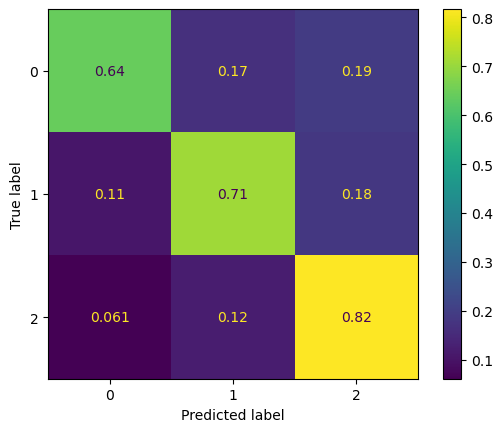

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.73886. Saving Model!
epoch 01, loss: 0.75364, acc: 0.65698, val_loss: 0.73886, val_accuracy: 0.67619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 02, loss: 0.74301, acc: 0.66671, val_loss: 0.74364, val_accuracy: 0.67619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 03, loss: 0.75330, acc: 0.65518, val_loss: 0.75165, val_accuracy: 0.67262


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 04, loss: 0.74054, acc: 0.66208, val_loss: 0.75464, val_accuracy: 0.67331


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 05, loss: 0.73896, acc: 0.66782, val_loss: 0.75480, val_accuracy: 0.66954


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 06, loss: 0.73491, acc: 0.66893, val_loss: 0.75734, val_accuracy: 0.66895


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 07, loss: 0.73435, acc: 0.66882, val_loss: 0.76031, val_accuracy: 0.66488


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.76it/s]


epoch 08, loss: 0.73273, acc: 0.67200, val_loss: 0.76251, val_accuracy: 0.66855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 09, loss: 0.73057, acc: 0.67283, val_loss: 0.76305, val_accuracy: 0.66538


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 10, loss: 0.72981, acc: 0.67243, val_loss: 0.76553, val_accuracy: 0.66766


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.80it/s]


epoch 11, loss: 0.72810, acc: 0.67237, val_loss: 0.76772, val_accuracy: 0.66746


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 12, loss: 0.72749, acc: 0.67181, val_loss: 0.76816, val_accuracy: 0.66776


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.16it/s]


epoch 13, loss: 0.72541, acc: 0.67235, val_loss: 0.77109, val_accuracy: 0.64901


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 14, loss: 0.72470, acc: 0.67188, val_loss: 0.77225, val_accuracy: 0.64841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 15, loss: 0.72465, acc: 0.67163, val_loss: 0.77365, val_accuracy: 0.64891


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 16, loss: 0.72202, acc: 0.67170, val_loss: 0.77527, val_accuracy: 0.64901


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 17, loss: 0.72259, acc: 0.67113, val_loss: 0.77510, val_accuracy: 0.64990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 18, loss: 0.72039, acc: 0.67242, val_loss: 0.77835, val_accuracy: 0.64990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 19, loss: 0.71956, acc: 0.67206, val_loss: 0.77903, val_accuracy: 0.65228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 20, loss: 0.72040, acc: 0.67047, val_loss: 0.77928, val_accuracy: 0.64871


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 21, loss: 0.71688, acc: 0.67184, val_loss: 0.78208, val_accuracy: 0.65129


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 22, loss: 0.71762, acc: 0.67114, val_loss: 0.78150, val_accuracy: 0.65079


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 23, loss: 0.71604, acc: 0.67114, val_loss: 0.78396, val_accuracy: 0.65228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 24, loss: 0.71593, acc: 0.67086, val_loss: 0.78433, val_accuracy: 0.65109


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 25, loss: 0.71397, acc: 0.67417, val_loss: 0.78610, val_accuracy: 0.65208


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 26, loss: 0.71459, acc: 0.67334, val_loss: 0.78591, val_accuracy: 0.65069


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 27, loss: 0.71222, acc: 0.67432, val_loss: 0.78842, val_accuracy: 0.65139


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 28, loss: 0.71277, acc: 0.67426, val_loss: 0.78838, val_accuracy: 0.65188


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 29, loss: 0.71031, acc: 0.67638, val_loss: 0.79087, val_accuracy: 0.65169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 30, loss: 0.71109, acc: 0.67441, val_loss: 0.79061, val_accuracy: 0.64990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 31, loss: 0.70887, acc: 0.67952, val_loss: 0.79272, val_accuracy: 0.65099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 32, loss: 0.70939, acc: 0.67592, val_loss: 0.79285, val_accuracy: 0.65179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 33, loss: 0.70826, acc: 0.67849, val_loss: 0.79270, val_accuracy: 0.65258


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 34, loss: 0.70704, acc: 0.67912, val_loss: 0.79469, val_accuracy: 0.65218


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66it/s]


epoch 35, loss: 0.70712, acc: 0.68048, val_loss: 0.79465, val_accuracy: 0.65000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 36, loss: 0.70549, acc: 0.68146, val_loss: 0.79657, val_accuracy: 0.63849


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 37, loss: 0.70494, acc: 0.68220, val_loss: 0.79682, val_accuracy: 0.63621


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 38, loss: 0.70369, acc: 0.68105, val_loss: 0.79785, val_accuracy: 0.63968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 39, loss: 0.70418, acc: 0.68132, val_loss: 0.79967, val_accuracy: 0.63651


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 40, loss: 0.70238, acc: 0.68113, val_loss: 0.80032, val_accuracy: 0.63948


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 41, loss: 0.70227, acc: 0.68457, val_loss: 0.79934, val_accuracy: 0.63780


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 42, loss: 0.70003, acc: 0.68441, val_loss: 0.80314, val_accuracy: 0.63879


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 43, loss: 0.70141, acc: 0.68344, val_loss: 0.80102, val_accuracy: 0.63671


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 44, loss: 0.69930, acc: 0.68682, val_loss: 0.80474, val_accuracy: 0.63859


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 45, loss: 0.69854, acc: 0.68545, val_loss: 0.80251, val_accuracy: 0.63958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.90it/s]


epoch 46, loss: 0.69828, acc: 0.68409, val_loss: 0.80529, val_accuracy: 0.63919


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]


epoch 47, loss: 0.69854, acc: 0.68358, val_loss: 0.80569, val_accuracy: 0.63651


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 48, loss: 0.69604, acc: 0.68741, val_loss: 0.80735, val_accuracy: 0.63671


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


epoch 49, loss: 0.69624, acc: 0.68875, val_loss: 0.80720, val_accuracy: 0.63760


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 50, loss: 0.69632, acc: 0.68483, val_loss: 0.80853, val_accuracy: 0.63819


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]


epoch 51, loss: 0.69449, acc: 0.68871, val_loss: 0.80870, val_accuracy: 0.63581


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.16it/s]


epoch 52, loss: 0.69391, acc: 0.68772, val_loss: 0.80971, val_accuracy: 0.63264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 53, loss: 0.69358, acc: 0.68909, val_loss: 0.81031, val_accuracy: 0.63889


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 54, loss: 0.69310, acc: 0.68672, val_loss: 0.81155, val_accuracy: 0.63155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 55, loss: 0.69176, acc: 0.68742, val_loss: 0.81223, val_accuracy: 0.63899


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 56, loss: 0.69131, acc: 0.68692, val_loss: 0.81284, val_accuracy: 0.62163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 57, loss: 0.69052, acc: 0.68734, val_loss: 0.81431, val_accuracy: 0.63869


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.87it/s]


epoch 58, loss: 0.68981, acc: 0.68939, val_loss: 0.81432, val_accuracy: 0.62173


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 59, loss: 0.68921, acc: 0.68991, val_loss: 0.81469, val_accuracy: 0.62837


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 60, loss: 0.68891, acc: 0.68811, val_loss: 0.81609, val_accuracy: 0.62103


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]


epoch 61, loss: 0.68787, acc: 0.69198, val_loss: 0.81464, val_accuracy: 0.62153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 62, loss: 0.68671, acc: 0.69077, val_loss: 0.81733, val_accuracy: 0.62341


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 63, loss: 0.68835, acc: 0.68823, val_loss: 0.81680, val_accuracy: 0.62133


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 64, loss: 0.68447, acc: 0.69178, val_loss: 0.81958, val_accuracy: 0.62242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 65, loss: 0.68609, acc: 0.69354, val_loss: 0.81704, val_accuracy: 0.62083


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 66, loss: 0.68369, acc: 0.69221, val_loss: 0.82064, val_accuracy: 0.62252


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 67, loss: 0.68547, acc: 0.69200, val_loss: 0.81874, val_accuracy: 0.62133


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 68, loss: 0.68290, acc: 0.69248, val_loss: 0.82121, val_accuracy: 0.62351


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 69, loss: 0.68340, acc: 0.69340, val_loss: 0.82076, val_accuracy: 0.60804


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 70, loss: 0.68194, acc: 0.69022, val_loss: 0.82220, val_accuracy: 0.60754


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 71, loss: 0.68253, acc: 0.69591, val_loss: 0.82112, val_accuracy: 0.60903


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 72, loss: 0.68038, acc: 0.69077, val_loss: 0.82397, val_accuracy: 0.60843


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 73, loss: 0.67979, acc: 0.69603, val_loss: 0.82378, val_accuracy: 0.60724


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.78it/s]


epoch 74, loss: 0.68049, acc: 0.69524, val_loss: 0.82342, val_accuracy: 0.60853


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 75, loss: 0.67818, acc: 0.69851, val_loss: 0.82570, val_accuracy: 0.60685


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 76, loss: 0.67940, acc: 0.69574, val_loss: 0.82564, val_accuracy: 0.60804


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 77, loss: 0.67639, acc: 0.69989, val_loss: 0.82621, val_accuracy: 0.60734


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 78, loss: 0.67786, acc: 0.69891, val_loss: 0.82571, val_accuracy: 0.60992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]


epoch 79, loss: 0.67567, acc: 0.69996, val_loss: 0.82632, val_accuracy: 0.60992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.78it/s]


epoch 80, loss: 0.67578, acc: 0.69610, val_loss: 0.82934, val_accuracy: 0.60992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 81, loss: 0.67600, acc: 0.69876, val_loss: 0.82728, val_accuracy: 0.61071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 82, loss: 0.67398, acc: 0.69672, val_loss: 0.82872, val_accuracy: 0.61042


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 83, loss: 0.67437, acc: 0.69986, val_loss: 0.83067, val_accuracy: 0.60942


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]


epoch 84, loss: 0.67324, acc: 0.69866, val_loss: 0.83026, val_accuracy: 0.61081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 85, loss: 0.67250, acc: 0.69992, val_loss: 0.83055, val_accuracy: 0.61131


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 86, loss: 0.67149, acc: 0.70082, val_loss: 0.83241, val_accuracy: 0.61101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.05it/s]


epoch 87, loss: 0.67106, acc: 0.70061, val_loss: 0.83268, val_accuracy: 0.61389


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 88, loss: 0.67106, acc: 0.69928, val_loss: 0.83353, val_accuracy: 0.61012


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 89, loss: 0.66906, acc: 0.70116, val_loss: 0.83253, val_accuracy: 0.61319


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 90, loss: 0.67030, acc: 0.70075, val_loss: 0.83514, val_accuracy: 0.61151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 91, loss: 0.66860, acc: 0.70242, val_loss: 0.83378, val_accuracy: 0.61260


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 92, loss: 0.66740, acc: 0.70164, val_loss: 0.83553, val_accuracy: 0.61270


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 93, loss: 0.66755, acc: 0.70268, val_loss: 0.83547, val_accuracy: 0.61458


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 94, loss: 0.66674, acc: 0.69842, val_loss: 0.83563, val_accuracy: 0.61508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 95, loss: 0.66690, acc: 0.70046, val_loss: 0.83784, val_accuracy: 0.61300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 96, loss: 0.66479, acc: 0.70293, val_loss: 0.83752, val_accuracy: 0.61528


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 97, loss: 0.66444, acc: 0.70122, val_loss: 0.83829, val_accuracy: 0.61399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 98, loss: 0.66497, acc: 0.70127, val_loss: 0.83818, val_accuracy: 0.61558


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 99, loss: 0.66331, acc: 0.70131, val_loss: 0.84024, val_accuracy: 0.61399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 100, loss: 0.66371, acc: 0.70476, val_loss: 0.84032, val_accuracy: 0.61587


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 101, loss: 0.66244, acc: 0.70120, val_loss: 0.84065, val_accuracy: 0.61518


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 102, loss: 0.66134, acc: 0.70576, val_loss: 0.84189, val_accuracy: 0.61597


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 103, loss: 0.66225, acc: 0.70130, val_loss: 0.84054, val_accuracy: 0.61796


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 104, loss: 0.65989, acc: 0.70213, val_loss: 0.84191, val_accuracy: 0.61766


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.08it/s]


epoch 105, loss: 0.66054, acc: 0.70363, val_loss: 0.84268, val_accuracy: 0.61647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 106, loss: 0.65971, acc: 0.70212, val_loss: 0.84470, val_accuracy: 0.61657


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 107, loss: 0.65813, acc: 0.70603, val_loss: 0.84382, val_accuracy: 0.61855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.96it/s]


epoch 108, loss: 0.65788, acc: 0.70266, val_loss: 0.84645, val_accuracy: 0.61905


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.90it/s]


epoch 109, loss: 0.65816, acc: 0.70398, val_loss: 0.84454, val_accuracy: 0.61587


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 110, loss: 0.65629, acc: 0.70474, val_loss: 0.84565, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 111, loss: 0.65585, acc: 0.70331, val_loss: 0.84848, val_accuracy: 0.61766


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 112, loss: 0.65606, acc: 0.70110, val_loss: 0.84782, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 113, loss: 0.65342, acc: 0.70314, val_loss: 0.84766, val_accuracy: 0.61885


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 114, loss: 0.65469, acc: 0.70196, val_loss: 0.84885, val_accuracy: 0.62083


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 115, loss: 0.65235, acc: 0.70340, val_loss: 0.85104, val_accuracy: 0.61865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 116, loss: 0.65255, acc: 0.70279, val_loss: 0.84966, val_accuracy: 0.62192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.96it/s]


epoch 117, loss: 0.65232, acc: 0.70297, val_loss: 0.85126, val_accuracy: 0.61954


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 118, loss: 0.65079, acc: 0.70391, val_loss: 0.85067, val_accuracy: 0.62083


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 119, loss: 0.65105, acc: 0.70453, val_loss: 0.85404, val_accuracy: 0.62202


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 120, loss: 0.65066, acc: 0.70568, val_loss: 0.84995, val_accuracy: 0.62123


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 121, loss: 0.64970, acc: 0.70568, val_loss: 0.85345, val_accuracy: 0.62312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 122, loss: 0.64924, acc: 0.70537, val_loss: 0.85488, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.88it/s]


epoch 123, loss: 0.64926, acc: 0.70807, val_loss: 0.85407, val_accuracy: 0.62560


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 124, loss: 0.64791, acc: 0.70453, val_loss: 0.85352, val_accuracy: 0.62113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 125, loss: 0.64774, acc: 0.70620, val_loss: 0.85634, val_accuracy: 0.62411


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 126, loss: 0.64507, acc: 0.70761, val_loss: 0.85728, val_accuracy: 0.62312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.99it/s]


epoch 127, loss: 0.64650, acc: 0.70811, val_loss: 0.85755, val_accuracy: 0.62440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.33it/s]


epoch 128, loss: 0.64462, acc: 0.70967, val_loss: 0.85816, val_accuracy: 0.62510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 129, loss: 0.64480, acc: 0.70835, val_loss: 0.85710, val_accuracy: 0.62103


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 130, loss: 0.64559, acc: 0.70713, val_loss: 0.85891, val_accuracy: 0.62460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 131, loss: 0.64260, acc: 0.70783, val_loss: 0.86128, val_accuracy: 0.62381


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 132, loss: 0.64385, acc: 0.70756, val_loss: 0.85726, val_accuracy: 0.62440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


epoch 133, loss: 0.64108, acc: 0.70836, val_loss: 0.86319, val_accuracy: 0.62351


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 134, loss: 0.64201, acc: 0.71046, val_loss: 0.85909, val_accuracy: 0.62262


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 135, loss: 0.64024, acc: 0.71059, val_loss: 0.86385, val_accuracy: 0.62520


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


epoch 136, loss: 0.64020, acc: 0.71156, val_loss: 0.86190, val_accuracy: 0.62232


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 137, loss: 0.63952, acc: 0.71018, val_loss: 0.86403, val_accuracy: 0.62530


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 138, loss: 0.63724, acc: 0.71176, val_loss: 0.86468, val_accuracy: 0.62341


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 139, loss: 0.63964, acc: 0.70973, val_loss: 0.86359, val_accuracy: 0.62619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 140, loss: 0.63496, acc: 0.71196, val_loss: 0.86654, val_accuracy: 0.62351


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 141, loss: 0.63834, acc: 0.71136, val_loss: 0.86363, val_accuracy: 0.62619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.95it/s]


epoch 142, loss: 0.63417, acc: 0.71061, val_loss: 0.86829, val_accuracy: 0.62440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 143, loss: 0.63789, acc: 0.71102, val_loss: 0.86622, val_accuracy: 0.62569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 144, loss: 0.63242, acc: 0.71183, val_loss: 0.87080, val_accuracy: 0.62500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.10it/s]


epoch 145, loss: 0.63510, acc: 0.71231, val_loss: 0.86812, val_accuracy: 0.62540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 146, loss: 0.63167, acc: 0.71352, val_loss: 0.87228, val_accuracy: 0.62599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 147, loss: 0.63407, acc: 0.71123, val_loss: 0.86684, val_accuracy: 0.62560


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 148, loss: 0.63179, acc: 0.71357, val_loss: 0.87155, val_accuracy: 0.62679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.98it/s]


epoch 149, loss: 0.63250, acc: 0.71476, val_loss: 0.87010, val_accuracy: 0.61131


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 150, loss: 0.63202, acc: 0.71632, val_loss: 0.87347, val_accuracy: 0.62659


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 151, loss: 0.63008, acc: 0.71203, val_loss: 0.87156, val_accuracy: 0.62431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 152, loss: 0.62995, acc: 0.71597, val_loss: 0.87480, val_accuracy: 0.62778


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 153, loss: 0.62887, acc: 0.71451, val_loss: 0.87368, val_accuracy: 0.61409


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 154, loss: 0.62916, acc: 0.71479, val_loss: 0.87594, val_accuracy: 0.61637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.12it/s]


epoch 155, loss: 0.62846, acc: 0.71470, val_loss: 0.87628, val_accuracy: 0.61369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 156, loss: 0.62784, acc: 0.71806, val_loss: 0.87598, val_accuracy: 0.62897


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.84it/s]


epoch 157, loss: 0.62663, acc: 0.71587, val_loss: 0.87685, val_accuracy: 0.61677


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]


epoch 158, loss: 0.62509, acc: 0.71890, val_loss: 0.88007, val_accuracy: 0.61687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 159, loss: 0.62605, acc: 0.71537, val_loss: 0.87711, val_accuracy: 0.61865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 160, loss: 0.62409, acc: 0.71673, val_loss: 0.87978, val_accuracy: 0.61687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 161, loss: 0.62478, acc: 0.71851, val_loss: 0.87781, val_accuracy: 0.61468


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 162, loss: 0.62344, acc: 0.71839, val_loss: 0.88152, val_accuracy: 0.61647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]


epoch 163, loss: 0.62347, acc: 0.71988, val_loss: 0.87666, val_accuracy: 0.61835


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 164, loss: 0.62296, acc: 0.71961, val_loss: 0.88404, val_accuracy: 0.61885


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 165, loss: 0.62222, acc: 0.72021, val_loss: 0.87694, val_accuracy: 0.61845


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 166, loss: 0.62400, acc: 0.71852, val_loss: 0.88515, val_accuracy: 0.61726


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.88it/s]


epoch 167, loss: 0.62348, acc: 0.72154, val_loss: 0.88174, val_accuracy: 0.61369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 168, loss: 0.62146, acc: 0.72422, val_loss: 0.88422, val_accuracy: 0.61974


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 169, loss: 0.61858, acc: 0.72055, val_loss: 0.88328, val_accuracy: 0.61637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


epoch 170, loss: 0.62111, acc: 0.72070, val_loss: 0.88340, val_accuracy: 0.62063


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 171, loss: 0.61744, acc: 0.72200, val_loss: 0.88853, val_accuracy: 0.61766


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 172, loss: 0.62057, acc: 0.72076, val_loss: 0.88267, val_accuracy: 0.61786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


epoch 173, loss: 0.61560, acc: 0.72436, val_loss: 0.88870, val_accuracy: 0.62014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.07it/s]


epoch 174, loss: 0.61813, acc: 0.72246, val_loss: 0.88757, val_accuracy: 0.61915


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.85it/s]


epoch 175, loss: 0.61435, acc: 0.72475, val_loss: 0.88856, val_accuracy: 0.61994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 176, loss: 0.61665, acc: 0.72642, val_loss: 0.88750, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


epoch 177, loss: 0.61347, acc: 0.72387, val_loss: 0.89034, val_accuracy: 0.61954


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 178, loss: 0.61476, acc: 0.72538, val_loss: 0.89133, val_accuracy: 0.62054


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]


epoch 179, loss: 0.61487, acc: 0.72469, val_loss: 0.88997, val_accuracy: 0.61835


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 180, loss: 0.61269, acc: 0.72792, val_loss: 0.89334, val_accuracy: 0.62153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 181, loss: 0.61461, acc: 0.72479, val_loss: 0.88975, val_accuracy: 0.61796


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 182, loss: 0.61191, acc: 0.72685, val_loss: 0.89455, val_accuracy: 0.62004


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.78it/s]


epoch 183, loss: 0.61442, acc: 0.72498, val_loss: 0.89068, val_accuracy: 0.61905


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 184, loss: 0.61085, acc: 0.73040, val_loss: 0.89817, val_accuracy: 0.62073


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


epoch 185, loss: 0.61293, acc: 0.72698, val_loss: 0.89225, val_accuracy: 0.61736


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 186, loss: 0.61066, acc: 0.73066, val_loss: 0.89783, val_accuracy: 0.62252


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 187, loss: 0.61067, acc: 0.72652, val_loss: 0.89297, val_accuracy: 0.62004


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


epoch 188, loss: 0.60964, acc: 0.72793, val_loss: 0.89871, val_accuracy: 0.62252


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 189, loss: 0.60603, acc: 0.72897, val_loss: 0.89744, val_accuracy: 0.62093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


epoch 190, loss: 0.60999, acc: 0.72757, val_loss: 0.89867, val_accuracy: 0.62282


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 191, loss: 0.60519, acc: 0.72793, val_loss: 0.89905, val_accuracy: 0.61994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.89it/s]


epoch 192, loss: 0.60935, acc: 0.73061, val_loss: 0.89847, val_accuracy: 0.62044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 193, loss: 0.60364, acc: 0.73123, val_loss: 0.90163, val_accuracy: 0.62063


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 194, loss: 0.60689, acc: 0.73024, val_loss: 0.89921, val_accuracy: 0.62123


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 195, loss: 0.60410, acc: 0.73208, val_loss: 0.90423, val_accuracy: 0.62401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 196, loss: 0.60412, acc: 0.72974, val_loss: 0.89975, val_accuracy: 0.62063


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 197, loss: 0.60506, acc: 0.73116, val_loss: 0.90546, val_accuracy: 0.62202


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 198, loss: 0.60490, acc: 0.72935, val_loss: 0.90242, val_accuracy: 0.61825


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 199, loss: 0.60382, acc: 0.73393, val_loss: 0.90586, val_accuracy: 0.62371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 200, loss: 0.60186, acc: 0.72994, val_loss: 0.90379, val_accuracy: 0.61925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.01it/s]


epoch 201, loss: 0.60208, acc: 0.73531, val_loss: 0.90580, val_accuracy: 0.62440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 202, loss: 0.59980, acc: 0.73188, val_loss: 0.90846, val_accuracy: 0.62282


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 203, loss: 0.60110, acc: 0.73049, val_loss: 0.90699, val_accuracy: 0.62044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 204, loss: 0.59972, acc: 0.73668, val_loss: 0.90721, val_accuracy: 0.62044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 205, loss: 0.59860, acc: 0.73514, val_loss: 0.91127, val_accuracy: 0.62113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.01it/s]


epoch 206, loss: 0.59826, acc: 0.73513, val_loss: 0.90835, val_accuracy: 0.62153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.72it/s]


epoch 207, loss: 0.59682, acc: 0.73444, val_loss: 0.91365, val_accuracy: 0.62321


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 208, loss: 0.59728, acc: 0.73477, val_loss: 0.90826, val_accuracy: 0.62093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 209, loss: 0.59715, acc: 0.73740, val_loss: 0.91402, val_accuracy: 0.62163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 210, loss: 0.59671, acc: 0.73784, val_loss: 0.91067, val_accuracy: 0.62440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 211, loss: 0.59753, acc: 0.73305, val_loss: 0.90958, val_accuracy: 0.62460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 212, loss: 0.59445, acc: 0.73685, val_loss: 0.91676, val_accuracy: 0.62321


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 213, loss: 0.59891, acc: 0.73259, val_loss: 0.91186, val_accuracy: 0.62153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 214, loss: 0.59289, acc: 0.74014, val_loss: 0.91900, val_accuracy: 0.62252


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 215, loss: 0.59652, acc: 0.73435, val_loss: 0.90995, val_accuracy: 0.62232


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 216, loss: 0.59196, acc: 0.73817, val_loss: 0.91595, val_accuracy: 0.62629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 217, loss: 0.59225, acc: 0.73650, val_loss: 0.91718, val_accuracy: 0.62609


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 218, loss: 0.59183, acc: 0.73680, val_loss: 0.91873, val_accuracy: 0.62431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 219, loss: 0.59113, acc: 0.73914, val_loss: 0.91800, val_accuracy: 0.62183


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.76it/s]


epoch 220, loss: 0.59140, acc: 0.74111, val_loss: 0.91734, val_accuracy: 0.62371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 221, loss: 0.58887, acc: 0.74040, val_loss: 0.91872, val_accuracy: 0.62302


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 222, loss: 0.58984, acc: 0.74253, val_loss: 0.92249, val_accuracy: 0.62411


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 223, loss: 0.59075, acc: 0.73941, val_loss: 0.91506, val_accuracy: 0.62431


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 224, loss: 0.58659, acc: 0.74057, val_loss: 0.92406, val_accuracy: 0.62321


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 225, loss: 0.59154, acc: 0.74111, val_loss: 0.92035, val_accuracy: 0.62371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 226, loss: 0.58760, acc: 0.74170, val_loss: 0.92495, val_accuracy: 0.62589


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 227, loss: 0.58707, acc: 0.73883, val_loss: 0.92245, val_accuracy: 0.62312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.95it/s]


epoch 228, loss: 0.58751, acc: 0.74161, val_loss: 0.92496, val_accuracy: 0.62609


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 229, loss: 0.58481, acc: 0.74234, val_loss: 0.92080, val_accuracy: 0.62460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 230, loss: 0.58541, acc: 0.74277, val_loss: 0.92721, val_accuracy: 0.62698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 231, loss: 0.58487, acc: 0.74271, val_loss: 0.92517, val_accuracy: 0.62242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 232, loss: 0.58451, acc: 0.74391, val_loss: 0.92845, val_accuracy: 0.62579


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.21it/s]


epoch 233, loss: 0.58332, acc: 0.74299, val_loss: 0.92688, val_accuracy: 0.62292


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 234, loss: 0.58289, acc: 0.74618, val_loss: 0.92690, val_accuracy: 0.62688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 235, loss: 0.58272, acc: 0.74269, val_loss: 0.92895, val_accuracy: 0.62331


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 236, loss: 0.58202, acc: 0.74392, val_loss: 0.93003, val_accuracy: 0.62530


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 237, loss: 0.58809, acc: 0.73875, val_loss: 0.92724, val_accuracy: 0.62252


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.84it/s]


epoch 238, loss: 0.57923, acc: 0.74681, val_loss: 0.93044, val_accuracy: 0.62808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 239, loss: 0.58127, acc: 0.74253, val_loss: 0.92900, val_accuracy: 0.62560


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 240, loss: 0.58009, acc: 0.74424, val_loss: 0.93267, val_accuracy: 0.62659


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.33it/s]


epoch 241, loss: 0.57852, acc: 0.74772, val_loss: 0.93208, val_accuracy: 0.62470


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 242, loss: 0.57973, acc: 0.74525, val_loss: 0.93276, val_accuracy: 0.62659


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 243, loss: 0.57778, acc: 0.74594, val_loss: 0.93436, val_accuracy: 0.62292


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 244, loss: 0.57959, acc: 0.74648, val_loss: 0.93512, val_accuracy: 0.62669


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 245, loss: 0.57839, acc: 0.74381, val_loss: 0.93345, val_accuracy: 0.62560


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 246, loss: 0.57628, acc: 0.74458, val_loss: 0.93580, val_accuracy: 0.62798


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 247, loss: 0.57743, acc: 0.74558, val_loss: 0.93763, val_accuracy: 0.62579


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.17it/s]


epoch 248, loss: 0.57485, acc: 0.74851, val_loss: 0.93733, val_accuracy: 0.62500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 249, loss: 0.57708, acc: 0.74504, val_loss: 0.93807, val_accuracy: 0.62440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 250, loss: 0.57507, acc: 0.74797, val_loss: 0.93990, val_accuracy: 0.62937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 251, loss: 0.57501, acc: 0.74455, val_loss: 0.93672, val_accuracy: 0.62569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 252, loss: 0.57342, acc: 0.74891, val_loss: 0.93964, val_accuracy: 0.62877


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.95it/s]


epoch 253, loss: 0.57344, acc: 0.74868, val_loss: 0.93787, val_accuracy: 0.62510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.91it/s]


epoch 254, loss: 0.57203, acc: 0.75017, val_loss: 0.94344, val_accuracy: 0.63065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]


epoch 255, loss: 0.57342, acc: 0.74472, val_loss: 0.93707, val_accuracy: 0.62500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 256, loss: 0.57272, acc: 0.74915, val_loss: 0.94412, val_accuracy: 0.62619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.89it/s]


epoch 257, loss: 0.56823, acc: 0.75286, val_loss: 0.94486, val_accuracy: 0.62679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 258, loss: 0.57291, acc: 0.74995, val_loss: 0.94154, val_accuracy: 0.61815


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 259, loss: 0.56827, acc: 0.74768, val_loss: 0.94290, val_accuracy: 0.62619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 260, loss: 0.56979, acc: 0.75155, val_loss: 0.94508, val_accuracy: 0.61716


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 261, loss: 0.56881, acc: 0.74900, val_loss: 0.94394, val_accuracy: 0.62768


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 262, loss: 0.56853, acc: 0.75133, val_loss: 0.94762, val_accuracy: 0.62956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 263, loss: 0.56741, acc: 0.75060, val_loss: 0.94738, val_accuracy: 0.63085


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 264, loss: 0.56770, acc: 0.74986, val_loss: 0.94801, val_accuracy: 0.61637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 265, loss: 0.56873, acc: 0.74710, val_loss: 0.94298, val_accuracy: 0.62976


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 266, loss: 0.56574, acc: 0.75406, val_loss: 0.95327, val_accuracy: 0.61726


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 267, loss: 0.56786, acc: 0.74769, val_loss: 0.94485, val_accuracy: 0.62827


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 268, loss: 0.56505, acc: 0.75213, val_loss: 0.95475, val_accuracy: 0.61915


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.65it/s]


epoch 269, loss: 0.56504, acc: 0.74857, val_loss: 0.94554, val_accuracy: 0.62996


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 270, loss: 0.56535, acc: 0.75282, val_loss: 0.95270, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.39it/s]


epoch 271, loss: 0.56452, acc: 0.75049, val_loss: 0.94984, val_accuracy: 0.61587


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 272, loss: 0.56401, acc: 0.75341, val_loss: 0.95502, val_accuracy: 0.61617


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 273, loss: 0.56303, acc: 0.75471, val_loss: 0.95106, val_accuracy: 0.62996


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 274, loss: 0.56237, acc: 0.75286, val_loss: 0.95651, val_accuracy: 0.61895


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 275, loss: 0.56365, acc: 0.74945, val_loss: 0.94780, val_accuracy: 0.61558


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.52it/s]


epoch 276, loss: 0.56128, acc: 0.75547, val_loss: 0.96002, val_accuracy: 0.62153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 277, loss: 0.56443, acc: 0.75021, val_loss: 0.95037, val_accuracy: 0.61647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 278, loss: 0.56073, acc: 0.75310, val_loss: 0.95800, val_accuracy: 0.61617


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 279, loss: 0.56210, acc: 0.75639, val_loss: 0.95276, val_accuracy: 0.61716


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 280, loss: 0.55923, acc: 0.75793, val_loss: 0.95866, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 281, loss: 0.55822, acc: 0.75709, val_loss: 0.95498, val_accuracy: 0.61776


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 282, loss: 0.55937, acc: 0.75790, val_loss: 0.96079, val_accuracy: 0.61736


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 283, loss: 0.55661, acc: 0.75939, val_loss: 0.96008, val_accuracy: 0.61915


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]


epoch 284, loss: 0.55760, acc: 0.75610, val_loss: 0.96384, val_accuracy: 0.61935


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.92it/s]


epoch 285, loss: 0.55721, acc: 0.75650, val_loss: 0.95877, val_accuracy: 0.62143


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 286, loss: 0.55881, acc: 0.75344, val_loss: 0.96315, val_accuracy: 0.61855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 287, loss: 0.55602, acc: 0.75776, val_loss: 0.96098, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.84it/s]


epoch 288, loss: 0.55647, acc: 0.75770, val_loss: 0.96289, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]


epoch 289, loss: 0.55382, acc: 0.76176, val_loss: 0.96171, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 290, loss: 0.55467, acc: 0.75739, val_loss: 0.96239, val_accuracy: 0.61825


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.80it/s]


epoch 291, loss: 0.55281, acc: 0.76205, val_loss: 0.96744, val_accuracy: 0.62113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 292, loss: 0.55648, acc: 0.75488, val_loss: 0.96319, val_accuracy: 0.61736


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 293, loss: 0.55203, acc: 0.75989, val_loss: 0.96717, val_accuracy: 0.61726


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 294, loss: 0.55658, acc: 0.75756, val_loss: 0.96841, val_accuracy: 0.61736


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 295, loss: 0.55220, acc: 0.76090, val_loss: 0.96891, val_accuracy: 0.61974


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 296, loss: 0.55451, acc: 0.75512, val_loss: 0.96110, val_accuracy: 0.61677


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 297, loss: 0.54969, acc: 0.76269, val_loss: 0.96985, val_accuracy: 0.62014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.87it/s]


epoch 298, loss: 0.55078, acc: 0.76207, val_loss: 0.96762, val_accuracy: 0.61885


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.84it/s]


epoch 299, loss: 0.54960, acc: 0.76138, val_loss: 0.97199, val_accuracy: 0.62232


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 300, loss: 0.54969, acc: 0.76196, val_loss: 0.96956, val_accuracy: 0.61865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 301, loss: 0.54948, acc: 0.76115, val_loss: 0.97370, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 302, loss: 0.54747, acc: 0.76513, val_loss: 0.97309, val_accuracy: 0.61766


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 303, loss: 0.54809, acc: 0.76364, val_loss: 0.97295, val_accuracy: 0.62123


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.22it/s]


epoch 304, loss: 0.54971, acc: 0.75829, val_loss: 0.97176, val_accuracy: 0.61845


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 305, loss: 0.54569, acc: 0.76383, val_loss: 0.97631, val_accuracy: 0.61865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]


epoch 306, loss: 0.54899, acc: 0.76120, val_loss: 0.97512, val_accuracy: 0.61796


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]


epoch 307, loss: 0.54631, acc: 0.76255, val_loss: 0.97909, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]


epoch 308, loss: 0.54826, acc: 0.75715, val_loss: 0.96944, val_accuracy: 0.61696


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 309, loss: 0.54495, acc: 0.76379, val_loss: 0.97730, val_accuracy: 0.62163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 310, loss: 0.54748, acc: 0.75978, val_loss: 0.97626, val_accuracy: 0.61786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 311, loss: 0.54386, acc: 0.76541, val_loss: 0.97808, val_accuracy: 0.62054


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 312, loss: 0.54509, acc: 0.76289, val_loss: 0.97831, val_accuracy: 0.61925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 313, loss: 0.54497, acc: 0.76314, val_loss: 0.98050, val_accuracy: 0.62014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 314, loss: 0.54104, acc: 0.76814, val_loss: 0.98392, val_accuracy: 0.61994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 315, loss: 0.54377, acc: 0.76473, val_loss: 0.97823, val_accuracy: 0.61925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 316, loss: 0.54079, acc: 0.76981, val_loss: 0.98641, val_accuracy: 0.62004


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 317, loss: 0.54141, acc: 0.76590, val_loss: 0.97911, val_accuracy: 0.61984


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 318, loss: 0.54048, acc: 0.76598, val_loss: 0.98447, val_accuracy: 0.61885


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 319, loss: 0.54147, acc: 0.76453, val_loss: 0.98291, val_accuracy: 0.62073


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 320, loss: 0.54307, acc: 0.76071, val_loss: 0.98469, val_accuracy: 0.61835


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 321, loss: 0.53961, acc: 0.76643, val_loss: 0.98815, val_accuracy: 0.60397


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 322, loss: 0.54136, acc: 0.76052, val_loss: 0.98496, val_accuracy: 0.61915


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 323, loss: 0.53752, acc: 0.76828, val_loss: 0.98756, val_accuracy: 0.60337


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 324, loss: 0.53831, acc: 0.76730, val_loss: 0.98852, val_accuracy: 0.61944


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 325, loss: 0.53899, acc: 0.76548, val_loss: 0.98810, val_accuracy: 0.61845


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]


epoch 326, loss: 0.54010, acc: 0.76641, val_loss: 0.98150, val_accuracy: 0.61845


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 327, loss: 0.53555, acc: 0.76800, val_loss: 0.99019, val_accuracy: 0.60377


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 328, loss: 0.53762, acc: 0.76541, val_loss: 0.98871, val_accuracy: 0.61935


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 329, loss: 0.53522, acc: 0.76709, val_loss: 0.98974, val_accuracy: 0.62044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 330, loss: 0.53641, acc: 0.76643, val_loss: 0.99143, val_accuracy: 0.61915


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 331, loss: 0.53518, acc: 0.76637, val_loss: 0.99476, val_accuracy: 0.60367


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 332, loss: 0.53704, acc: 0.76587, val_loss: 0.98855, val_accuracy: 0.61935


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.11it/s]


epoch 333, loss: 0.53367, acc: 0.76614, val_loss: 0.98954, val_accuracy: 0.60317


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.74it/s]


epoch 334, loss: 0.53359, acc: 0.76833, val_loss: 0.99547, val_accuracy: 0.62183


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 335, loss: 0.53404, acc: 0.76873, val_loss: 0.99139, val_accuracy: 0.62163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 336, loss: 0.53219, acc: 0.77084, val_loss: 0.99874, val_accuracy: 0.62192


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 337, loss: 0.53334, acc: 0.76819, val_loss: 0.99412, val_accuracy: 0.62371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 338, loss: 0.53778, acc: 0.76176, val_loss: 0.99155, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 339, loss: 0.52989, acc: 0.77175, val_loss: 0.99582, val_accuracy: 0.60476


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 340, loss: 0.53217, acc: 0.76902, val_loss: 0.99381, val_accuracy: 0.62054


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 341, loss: 0.53105, acc: 0.76982, val_loss: 0.99976, val_accuracy: 0.60446


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 342, loss: 0.52960, acc: 0.77149, val_loss: 0.99621, val_accuracy: 0.62262


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 343, loss: 0.53048, acc: 0.76798, val_loss: 0.99913, val_accuracy: 0.60308


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 344, loss: 0.53014, acc: 0.77113, val_loss: 1.00072, val_accuracy: 0.60357


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 345, loss: 0.52964, acc: 0.77010, val_loss: 0.99935, val_accuracy: 0.60655


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 346, loss: 0.53257, acc: 0.76584, val_loss: 0.99284, val_accuracy: 0.62183


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 347, loss: 0.52788, acc: 0.77380, val_loss: 1.00038, val_accuracy: 0.60595


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 348, loss: 0.52741, acc: 0.77218, val_loss: 1.00368, val_accuracy: 0.60357


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 349, loss: 0.52805, acc: 0.76980, val_loss: 1.00304, val_accuracy: 0.60665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 350, loss: 0.52633, acc: 0.77205, val_loss: 1.00076, val_accuracy: 0.60615


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 351, loss: 0.52647, acc: 0.77068, val_loss: 1.00854, val_accuracy: 0.60913


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 352, loss: 0.52585, acc: 0.77076, val_loss: 0.99621, val_accuracy: 0.62272


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 353, loss: 0.52618, acc: 0.77119, val_loss: 1.00255, val_accuracy: 0.60754


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 354, loss: 0.52592, acc: 0.77275, val_loss: 1.00140, val_accuracy: 0.62232


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 355, loss: 0.52665, acc: 0.77053, val_loss: 1.00939, val_accuracy: 0.60456


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]


epoch 356, loss: 0.52609, acc: 0.77008, val_loss: 1.00409, val_accuracy: 0.60327


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.17it/s]


epoch 357, loss: 0.52324, acc: 0.77259, val_loss: 1.00773, val_accuracy: 0.60685


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 358, loss: 0.52471, acc: 0.77300, val_loss: 1.00087, val_accuracy: 0.60347


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]


epoch 359, loss: 0.52203, acc: 0.77481, val_loss: 1.01060, val_accuracy: 0.60694


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.14it/s]


epoch 360, loss: 0.52253, acc: 0.77528, val_loss: 1.00745, val_accuracy: 0.60565


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]


epoch 361, loss: 0.52097, acc: 0.77377, val_loss: 1.01254, val_accuracy: 0.60685


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]


epoch 362, loss: 0.52168, acc: 0.77424, val_loss: 1.00674, val_accuracy: 0.60704


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 363, loss: 0.52150, acc: 0.77325, val_loss: 1.01240, val_accuracy: 0.60516


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.39it/s]


epoch 364, loss: 0.52044, acc: 0.77501, val_loss: 1.01486, val_accuracy: 0.60665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 365, loss: 0.52115, acc: 0.77375, val_loss: 1.00690, val_accuracy: 0.60754


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 366, loss: 0.51997, acc: 0.77350, val_loss: 1.01457, val_accuracy: 0.60685


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 367, loss: 0.52111, acc: 0.77194, val_loss: 1.01213, val_accuracy: 0.60675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 368, loss: 0.52334, acc: 0.77163, val_loss: 1.01074, val_accuracy: 0.60437


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 369, loss: 0.51803, acc: 0.77708, val_loss: 1.01812, val_accuracy: 0.61101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 370, loss: 0.52091, acc: 0.77166, val_loss: 1.00678, val_accuracy: 0.60456


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]


epoch 371, loss: 0.51899, acc: 0.77406, val_loss: 1.01492, val_accuracy: 0.61002


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 372, loss: 0.51684, acc: 0.77603, val_loss: 1.01202, val_accuracy: 0.60367


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.05it/s]


epoch 373, loss: 0.51768, acc: 0.77606, val_loss: 1.01755, val_accuracy: 0.60962


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


epoch 374, loss: 0.51779, acc: 0.77335, val_loss: 1.01219, val_accuracy: 0.60516


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 375, loss: 0.51755, acc: 0.77676, val_loss: 1.02147, val_accuracy: 0.60863


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]


epoch 376, loss: 0.51590, acc: 0.77609, val_loss: 1.01308, val_accuracy: 0.60734


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 377, loss: 0.51485, acc: 0.77768, val_loss: 1.02312, val_accuracy: 0.60833


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 378, loss: 0.51516, acc: 0.77886, val_loss: 1.01688, val_accuracy: 0.60774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 379, loss: 0.51276, acc: 0.77901, val_loss: 1.02252, val_accuracy: 0.60813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 380, loss: 0.51524, acc: 0.77709, val_loss: 1.01756, val_accuracy: 0.60893


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 381, loss: 0.51384, acc: 0.77769, val_loss: 1.02413, val_accuracy: 0.60675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


epoch 382, loss: 0.51273, acc: 0.77732, val_loss: 1.01774, val_accuracy: 0.60764


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 383, loss: 0.51392, acc: 0.77608, val_loss: 1.02365, val_accuracy: 0.60774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 384, loss: 0.51295, acc: 0.77799, val_loss: 1.02029, val_accuracy: 0.60823


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


epoch 385, loss: 0.51162, acc: 0.77790, val_loss: 1.02734, val_accuracy: 0.60893


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 386, loss: 0.51240, acc: 0.77648, val_loss: 1.01841, val_accuracy: 0.60992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 387, loss: 0.51095, acc: 0.77882, val_loss: 1.02675, val_accuracy: 0.60823


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 388, loss: 0.51023, acc: 0.77640, val_loss: 1.02230, val_accuracy: 0.61022


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 389, loss: 0.51167, acc: 0.77761, val_loss: 1.02664, val_accuracy: 0.60883


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 390, loss: 0.50955, acc: 0.77985, val_loss: 1.02724, val_accuracy: 0.61042


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 391, loss: 0.50961, acc: 0.77978, val_loss: 1.03082, val_accuracy: 0.61062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]


epoch 392, loss: 0.51019, acc: 0.77520, val_loss: 1.02705, val_accuracy: 0.60933


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.93it/s]


epoch 393, loss: 0.50902, acc: 0.77977, val_loss: 1.02696, val_accuracy: 0.60853


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 394, loss: 0.51184, acc: 0.77303, val_loss: 1.03132, val_accuracy: 0.61022


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 395, loss: 0.51236, acc: 0.77430, val_loss: 1.02805, val_accuracy: 0.60675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 396, loss: 0.50878, acc: 0.77871, val_loss: 1.03374, val_accuracy: 0.61200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 397, loss: 0.51134, acc: 0.77404, val_loss: 1.02395, val_accuracy: 0.60675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.08it/s]


epoch 398, loss: 0.50788, acc: 0.77865, val_loss: 1.03306, val_accuracy: 0.61042


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 399, loss: 0.50656, acc: 0.78114, val_loss: 1.03839, val_accuracy: 0.61151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


epoch 400, loss: 0.50896, acc: 0.77575, val_loss: 1.03293, val_accuracy: 0.61012


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 401, loss: 0.50460, acc: 0.78115, val_loss: 1.03928, val_accuracy: 0.61161


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 402, loss: 0.50673, acc: 0.77859, val_loss: 1.03617, val_accuracy: 0.61151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 403, loss: 0.50424, acc: 0.78095, val_loss: 1.04149, val_accuracy: 0.61161


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 404, loss: 0.50517, acc: 0.77913, val_loss: 1.03631, val_accuracy: 0.60972


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 405, loss: 0.50461, acc: 0.78260, val_loss: 1.04432, val_accuracy: 0.61081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 406, loss: 0.50446, acc: 0.77821, val_loss: 1.03566, val_accuracy: 0.61141


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 407, loss: 0.50407, acc: 0.78111, val_loss: 1.04225, val_accuracy: 0.61230


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 408, loss: 0.50435, acc: 0.77895, val_loss: 1.03983, val_accuracy: 0.61171


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.11it/s]


epoch 409, loss: 0.50765, acc: 0.78196, val_loss: 1.04007, val_accuracy: 0.61002


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 410, loss: 0.50274, acc: 0.78164, val_loss: 1.04332, val_accuracy: 0.61429


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 411, loss: 0.50518, acc: 0.77941, val_loss: 1.03735, val_accuracy: 0.61111


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 412, loss: 0.50104, acc: 0.78164, val_loss: 1.04473, val_accuracy: 0.61250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 413, loss: 0.50090, acc: 0.78347, val_loss: 1.04524, val_accuracy: 0.61220


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 414, loss: 0.50001, acc: 0.78304, val_loss: 1.04863, val_accuracy: 0.61349


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 415, loss: 0.50068, acc: 0.78036, val_loss: 1.04407, val_accuracy: 0.61071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 416, loss: 0.50164, acc: 0.78361, val_loss: 1.05069, val_accuracy: 0.61210


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 417, loss: 0.49964, acc: 0.78249, val_loss: 1.04607, val_accuracy: 0.61280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 418, loss: 0.50003, acc: 0.78326, val_loss: 1.05003, val_accuracy: 0.60119


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 419, loss: 0.49830, acc: 0.78329, val_loss: 1.05162, val_accuracy: 0.61310


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 420, loss: 0.49958, acc: 0.77918, val_loss: 1.05068, val_accuracy: 0.61270


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 421, loss: 0.49694, acc: 0.78510, val_loss: 1.06132, val_accuracy: 0.61508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 422, loss: 0.49980, acc: 0.78238, val_loss: 1.04776, val_accuracy: 0.61081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]


epoch 423, loss: 0.49669, acc: 0.78376, val_loss: 1.05800, val_accuracy: 0.61349


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.81it/s]


epoch 424, loss: 0.49916, acc: 0.78390, val_loss: 1.05119, val_accuracy: 0.61220


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 425, loss: 0.49688, acc: 0.78464, val_loss: 1.05708, val_accuracy: 0.61438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 426, loss: 0.49649, acc: 0.78328, val_loss: 1.05536, val_accuracy: 0.61250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 427, loss: 0.49508, acc: 0.78561, val_loss: 1.05924, val_accuracy: 0.61280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 428, loss: 0.49524, acc: 0.78645, val_loss: 1.05945, val_accuracy: 0.60218


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 429, loss: 0.49405, acc: 0.78682, val_loss: 1.05787, val_accuracy: 0.61538


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 430, loss: 0.49539, acc: 0.78531, val_loss: 1.05987, val_accuracy: 0.61379


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 431, loss: 0.49358, acc: 0.78852, val_loss: 1.06530, val_accuracy: 0.61667


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 432, loss: 0.49493, acc: 0.78532, val_loss: 1.05635, val_accuracy: 0.61300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.89it/s]


epoch 433, loss: 0.49146, acc: 0.78868, val_loss: 1.06607, val_accuracy: 0.61696


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 434, loss: 0.49411, acc: 0.78638, val_loss: 1.06172, val_accuracy: 0.61567


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.10it/s]


epoch 435, loss: 0.49209, acc: 0.78576, val_loss: 1.06716, val_accuracy: 0.61478


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


epoch 436, loss: 0.49632, acc: 0.78661, val_loss: 1.06094, val_accuracy: 0.61448


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 437, loss: 0.49276, acc: 0.78552, val_loss: 1.06484, val_accuracy: 0.61756


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 438, loss: 0.49613, acc: 0.78379, val_loss: 1.06223, val_accuracy: 0.60288


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 439, loss: 0.49155, acc: 0.78843, val_loss: 1.06646, val_accuracy: 0.61587


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 440, loss: 0.49176, acc: 0.78610, val_loss: 1.06529, val_accuracy: 0.61726


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 441, loss: 0.49124, acc: 0.78868, val_loss: 1.07316, val_accuracy: 0.61696


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]


epoch 442, loss: 0.49016, acc: 0.78893, val_loss: 1.06524, val_accuracy: 0.61647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 443, loss: 0.49004, acc: 0.79012, val_loss: 1.07092, val_accuracy: 0.61627


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.20it/s]


epoch 444, loss: 0.48956, acc: 0.78972, val_loss: 1.06692, val_accuracy: 0.61806


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 445, loss: 0.48866, acc: 0.78736, val_loss: 1.07203, val_accuracy: 0.61756


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 446, loss: 0.48911, acc: 0.78963, val_loss: 1.06845, val_accuracy: 0.61915


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 447, loss: 0.48942, acc: 0.78666, val_loss: 1.07510, val_accuracy: 0.61706


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


epoch 448, loss: 0.49054, acc: 0.79230, val_loss: 1.07009, val_accuracy: 0.61647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 449, loss: 0.48669, acc: 0.79212, val_loss: 1.08085, val_accuracy: 0.61855


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 450, loss: 0.48939, acc: 0.78849, val_loss: 1.06762, val_accuracy: 0.61726


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 451, loss: 0.48659, acc: 0.78836, val_loss: 1.07728, val_accuracy: 0.61796


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 452, loss: 0.48649, acc: 0.79086, val_loss: 1.07911, val_accuracy: 0.61726


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 453, loss: 0.48799, acc: 0.78817, val_loss: 1.07953, val_accuracy: 0.60526


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]


epoch 454, loss: 0.48535, acc: 0.79157, val_loss: 1.07778, val_accuracy: 0.61776


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 455, loss: 0.48808, acc: 0.78843, val_loss: 1.07767, val_accuracy: 0.60526


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 456, loss: 0.48564, acc: 0.79059, val_loss: 1.08057, val_accuracy: 0.61667


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 457, loss: 0.49103, acc: 0.78953, val_loss: 1.07899, val_accuracy: 0.61687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 458, loss: 0.48518, acc: 0.79111, val_loss: 1.07945, val_accuracy: 0.62044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 459, loss: 0.48709, acc: 0.78675, val_loss: 1.08119, val_accuracy: 0.61905


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 460, loss: 0.48368, acc: 0.79394, val_loss: 1.07964, val_accuracy: 0.61895


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.91it/s]


epoch 461, loss: 0.48543, acc: 0.79256, val_loss: 1.08298, val_accuracy: 0.61925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 462, loss: 0.48409, acc: 0.79166, val_loss: 1.07972, val_accuracy: 0.60774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.82it/s]


epoch 463, loss: 0.48235, acc: 0.79262, val_loss: 1.08816, val_accuracy: 0.61776


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 464, loss: 0.48393, acc: 0.79360, val_loss: 1.08161, val_accuracy: 0.60823


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.68it/s]


epoch 465, loss: 0.48129, acc: 0.79574, val_loss: 1.08832, val_accuracy: 0.61825


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]


epoch 466, loss: 0.48271, acc: 0.79238, val_loss: 1.08414, val_accuracy: 0.60952


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.02it/s]


epoch 467, loss: 0.48071, acc: 0.79340, val_loss: 1.09261, val_accuracy: 0.61696


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 468, loss: 0.48298, acc: 0.79295, val_loss: 1.08756, val_accuracy: 0.60694


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 469, loss: 0.48231, acc: 0.79429, val_loss: 1.09440, val_accuracy: 0.61806


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 470, loss: 0.48344, acc: 0.78957, val_loss: 1.08293, val_accuracy: 0.60913


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


epoch 471, loss: 0.48199, acc: 0.79368, val_loss: 1.09085, val_accuracy: 0.61696


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 472, loss: 0.48135, acc: 0.79575, val_loss: 1.09036, val_accuracy: 0.61954


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.88it/s]


epoch 473, loss: 0.48084, acc: 0.79465, val_loss: 1.09004, val_accuracy: 0.61736


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.25it/s]


epoch 474, loss: 0.47863, acc: 0.79496, val_loss: 1.08794, val_accuracy: 0.60833


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 475, loss: 0.47835, acc: 0.79644, val_loss: 1.09553, val_accuracy: 0.61835


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 476, loss: 0.47839, acc: 0.79585, val_loss: 1.09090, val_accuracy: 0.60873


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 477, loss: 0.47726, acc: 0.79928, val_loss: 1.09465, val_accuracy: 0.61944


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.77it/s]


epoch 478, loss: 0.47972, acc: 0.79378, val_loss: 1.09234, val_accuracy: 0.60863


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 479, loss: 0.47741, acc: 0.79660, val_loss: 1.09591, val_accuracy: 0.60714


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 480, loss: 0.47886, acc: 0.79711, val_loss: 1.09822, val_accuracy: 0.61885


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


epoch 481, loss: 0.47812, acc: 0.79707, val_loss: 1.09302, val_accuracy: 0.61954


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 482, loss: 0.47732, acc: 0.79778, val_loss: 1.09728, val_accuracy: 0.61994


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 483, loss: 0.47740, acc: 0.79730, val_loss: 1.09397, val_accuracy: 0.62004


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 484, loss: 0.47490, acc: 0.79576, val_loss: 1.10438, val_accuracy: 0.61032


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 485, loss: 0.47819, acc: 0.79987, val_loss: 1.09137, val_accuracy: 0.61954


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 486, loss: 0.47454, acc: 0.79631, val_loss: 1.10253, val_accuracy: 0.60992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 487, loss: 0.47850, acc: 0.79686, val_loss: 1.09705, val_accuracy: 0.62113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 488, loss: 0.47871, acc: 0.79725, val_loss: 1.10223, val_accuracy: 0.60675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 489, loss: 0.47436, acc: 0.79966, val_loss: 1.09740, val_accuracy: 0.62242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 490, loss: 0.47620, acc: 0.79449, val_loss: 1.09866, val_accuracy: 0.60992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


epoch 491, loss: 0.47237, acc: 0.80223, val_loss: 1.10472, val_accuracy: 0.62073


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.29it/s]


epoch 492, loss: 0.47395, acc: 0.79742, val_loss: 1.10249, val_accuracy: 0.62014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.52it/s]


epoch 493, loss: 0.47101, acc: 0.80198, val_loss: 1.10705, val_accuracy: 0.61062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


epoch 494, loss: 0.47206, acc: 0.79985, val_loss: 1.10355, val_accuracy: 0.61071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 495, loss: 0.47144, acc: 0.80221, val_loss: 1.10421, val_accuracy: 0.61964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 496, loss: 0.47240, acc: 0.80102, val_loss: 1.10575, val_accuracy: 0.61905


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 497, loss: 0.47218, acc: 0.80142, val_loss: 1.10288, val_accuracy: 0.62202


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


epoch 498, loss: 0.47167, acc: 0.79940, val_loss: 1.11161, val_accuracy: 0.61121


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]


epoch 499, loss: 0.47085, acc: 0.80261, val_loss: 1.10590, val_accuracy: 0.62123


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 500, loss: 0.47141, acc: 0.80084, val_loss: 1.11236, val_accuracy: 0.60903
6번째 교차검증
evaluation loss: 0.73886, evaluation accuracy: 0.67619
(5, 10080)
(10080, 5)
Learning rate set to 0.10399
0:	learn: 1.0269703	total: 9.31ms	remaining: 9.3s
1:	learn: 0.9719230	total: 15.8ms	remaining: 7.87s
2:	learn: 0.9284171	total: 22ms	remaining: 7.32s
3:	learn: 0.8935343	total: 28.8ms	remaining: 7.18s
4:	learn: 0.8644214	total: 35.1ms	remaining: 6.99s
5:	learn: 0.8398792	total: 41.7ms	remaining: 6.91s
6:	learn: 0.8195600	total: 48ms	remaining: 6.81s
7:	learn: 0.8026693	total: 54.3ms	remaining: 6.74s
8:	learn: 0.7879159	total: 60.6ms	remaining: 6.67s
9:	learn: 0.7761875	total: 66.9ms	remaining: 6.63s
10:	learn: 0.7654255	total: 73.4ms	remaining: 6.6s
11:	learn: 0.7561331	total: 79.9ms	remaining: 6.58s
12:	learn: 0.7479379	total: 88.2ms	remaining: 6.7s
13:	learn: 0.7406262	total: 95.2ms	remaining: 6.7s
14:	learn: 0.7351430	total: 102ms	remaining: 6.68s
15:	learn: 0.7292595	total: 108ms	remaining

162:	learn: 0.6605796	total: 1.03s	remaining: 5.28s
163:	learn: 0.6605387	total: 1.03s	remaining: 5.28s
164:	learn: 0.6605090	total: 1.04s	remaining: 5.28s
165:	learn: 0.6604768	total: 1.05s	remaining: 5.28s
166:	learn: 0.6604478	total: 1.06s	remaining: 5.27s
167:	learn: 0.6604116	total: 1.06s	remaining: 5.27s
168:	learn: 0.6603892	total: 1.07s	remaining: 5.26s
169:	learn: 0.6603637	total: 1.08s	remaining: 5.25s
170:	learn: 0.6603294	total: 1.08s	remaining: 5.25s
171:	learn: 0.6602973	total: 1.09s	remaining: 5.25s
172:	learn: 0.6602772	total: 1.1s	remaining: 5.24s
173:	learn: 0.6602517	total: 1.1s	remaining: 5.24s
174:	learn: 0.6602232	total: 1.11s	remaining: 5.23s
175:	learn: 0.6602039	total: 1.12s	remaining: 5.23s
176:	learn: 0.6601833	total: 1.12s	remaining: 5.23s
177:	learn: 0.6601594	total: 1.13s	remaining: 5.22s
178:	learn: 0.6601300	total: 1.14s	remaining: 5.22s
179:	learn: 0.6601108	total: 1.14s	remaining: 5.21s
180:	learn: 0.6600868	total: 1.15s	remaining: 5.21s
181:	learn: 0.

345:	learn: 0.6584841	total: 2.27s	remaining: 4.3s
346:	learn: 0.6584810	total: 2.28s	remaining: 4.29s
347:	learn: 0.6584801	total: 2.29s	remaining: 4.29s
348:	learn: 0.6584764	total: 2.29s	remaining: 4.28s
349:	learn: 0.6584747	total: 2.3s	remaining: 4.28s
350:	learn: 0.6584704	total: 2.31s	remaining: 4.27s
351:	learn: 0.6584620	total: 2.31s	remaining: 4.26s
352:	learn: 0.6584534	total: 2.32s	remaining: 4.25s
353:	learn: 0.6584460	total: 2.33s	remaining: 4.25s
354:	learn: 0.6584399	total: 2.33s	remaining: 4.24s
355:	learn: 0.6584329	total: 2.34s	remaining: 4.24s
356:	learn: 0.6584271	total: 2.35s	remaining: 4.23s
357:	learn: 0.6584223	total: 2.35s	remaining: 4.22s
358:	learn: 0.6584182	total: 2.36s	remaining: 4.22s
359:	learn: 0.6584135	total: 2.37s	remaining: 4.21s
360:	learn: 0.6584116	total: 2.38s	remaining: 4.21s
361:	learn: 0.6584069	total: 2.38s	remaining: 4.2s
362:	learn: 0.6584034	total: 2.39s	remaining: 4.19s
363:	learn: 0.6584019	total: 2.4s	remaining: 4.19s
364:	learn: 0.65

525:	learn: 0.6580066	total: 3.52s	remaining: 3.17s
526:	learn: 0.6580051	total: 3.52s	remaining: 3.16s
527:	learn: 0.6580025	total: 3.53s	remaining: 3.16s
528:	learn: 0.6579999	total: 3.54s	remaining: 3.15s
529:	learn: 0.6579991	total: 3.55s	remaining: 3.15s
530:	learn: 0.6579968	total: 3.55s	remaining: 3.14s
531:	learn: 0.6579948	total: 3.56s	remaining: 3.13s
532:	learn: 0.6579924	total: 3.57s	remaining: 3.13s
533:	learn: 0.6579909	total: 3.58s	remaining: 3.12s
534:	learn: 0.6579903	total: 3.58s	remaining: 3.12s
535:	learn: 0.6579894	total: 3.59s	remaining: 3.11s
536:	learn: 0.6579885	total: 3.6s	remaining: 3.1s
537:	learn: 0.6579879	total: 3.61s	remaining: 3.1s
538:	learn: 0.6579868	total: 3.61s	remaining: 3.09s
539:	learn: 0.6579860	total: 3.62s	remaining: 3.08s
540:	learn: 0.6579849	total: 3.63s	remaining: 3.08s
541:	learn: 0.6579827	total: 3.64s	remaining: 3.07s
542:	learn: 0.6579819	total: 3.64s	remaining: 3.07s
543:	learn: 0.6579792	total: 3.65s	remaining: 3.06s
544:	learn: 0.6

705:	learn: 0.6577834	total: 4.96s	remaining: 2.07s
706:	learn: 0.6577822	total: 4.97s	remaining: 2.06s
707:	learn: 0.6577816	total: 4.98s	remaining: 2.05s
708:	learn: 0.6577805	total: 4.99s	remaining: 2.05s
709:	learn: 0.6577799	total: 5s	remaining: 2.04s
710:	learn: 0.6577794	total: 5.01s	remaining: 2.04s
711:	learn: 0.6577789	total: 5.02s	remaining: 2.03s
712:	learn: 0.6577784	total: 5.03s	remaining: 2.02s
713:	learn: 0.6577773	total: 5.04s	remaining: 2.02s
714:	learn: 0.6577760	total: 5.05s	remaining: 2.01s
715:	learn: 0.6577753	total: 5.06s	remaining: 2s
716:	learn: 0.6577743	total: 5.07s	remaining: 2s
717:	learn: 0.6577734	total: 5.07s	remaining: 1.99s
718:	learn: 0.6577729	total: 5.08s	remaining: 1.99s
719:	learn: 0.6577723	total: 5.09s	remaining: 1.98s
720:	learn: 0.6577699	total: 5.1s	remaining: 1.97s
721:	learn: 0.6577682	total: 5.11s	remaining: 1.97s
722:	learn: 0.6577667	total: 5.11s	remaining: 1.96s
723:	learn: 0.6577655	total: 5.12s	remaining: 1.95s
724:	learn: 0.6577628	

875:	learn: 0.6576622	total: 6.41s	remaining: 908ms
876:	learn: 0.6576618	total: 6.42s	remaining: 901ms
877:	learn: 0.6576613	total: 6.43s	remaining: 893ms
878:	learn: 0.6576606	total: 6.44s	remaining: 886ms
879:	learn: 0.6576599	total: 6.45s	remaining: 879ms
880:	learn: 0.6576591	total: 6.45s	remaining: 872ms
881:	learn: 0.6576587	total: 6.46s	remaining: 864ms
882:	learn: 0.6576581	total: 6.47s	remaining: 857ms
883:	learn: 0.6576579	total: 6.48s	remaining: 850ms
884:	learn: 0.6576573	total: 6.49s	remaining: 843ms
885:	learn: 0.6576568	total: 6.5s	remaining: 836ms
886:	learn: 0.6576567	total: 6.5s	remaining: 829ms
887:	learn: 0.6576558	total: 6.51s	remaining: 821ms
888:	learn: 0.6576552	total: 6.52s	remaining: 814ms
889:	learn: 0.6576551	total: 6.53s	remaining: 807ms
890:	learn: 0.6576535	total: 6.54s	remaining: 800ms
891:	learn: 0.6576528	total: 6.54s	remaining: 792ms
892:	learn: 0.6576525	total: 6.55s	remaining: 785ms
893:	learn: 0.6576522	total: 6.56s	remaining: 778ms
894:	learn: 0.

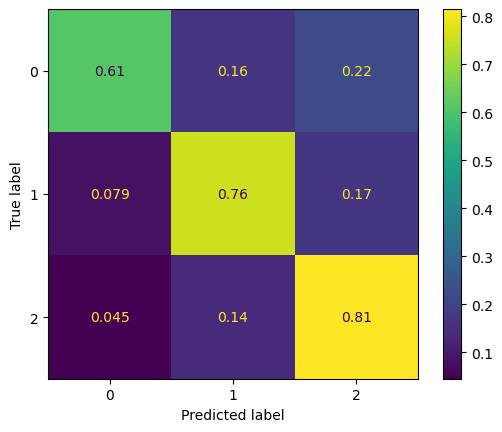

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.78338. Saving Model!
epoch 01, loss: 0.74608, acc: 0.66731, val_loss: 0.78338, val_accuracy: 0.64689


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]


epoch 02, loss: 0.73865, acc: 0.66508, val_loss: 0.79574, val_accuracy: 0.64421


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.68it/s]


epoch 03, loss: 0.73890, acc: 0.66423, val_loss: 0.79497, val_accuracy: 0.64133


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 04, loss: 0.73642, acc: 0.66447, val_loss: 0.80049, val_accuracy: 0.64153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 05, loss: 0.73132, acc: 0.66699, val_loss: 0.80010, val_accuracy: 0.63647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 06, loss: 0.73070, acc: 0.66899, val_loss: 0.80689, val_accuracy: 0.63528


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]


epoch 07, loss: 0.72745, acc: 0.67053, val_loss: 0.80530, val_accuracy: 0.63369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 08, loss: 0.72708, acc: 0.67179, val_loss: 0.81120, val_accuracy: 0.63022


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 09, loss: 0.72508, acc: 0.67365, val_loss: 0.81250, val_accuracy: 0.62824


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 10, loss: 0.72406, acc: 0.67587, val_loss: 0.81669, val_accuracy: 0.62923


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 11, loss: 0.72262, acc: 0.67420, val_loss: 0.81650, val_accuracy: 0.62705


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]


epoch 12, loss: 0.72152, acc: 0.67647, val_loss: 0.82111, val_accuracy: 0.61167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 13, loss: 0.72012, acc: 0.67780, val_loss: 0.82183, val_accuracy: 0.60998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.70it/s]


epoch 14, loss: 0.71895, acc: 0.67915, val_loss: 0.82568, val_accuracy: 0.61077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 15, loss: 0.71830, acc: 0.67839, val_loss: 0.82495, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.81it/s]


epoch 16, loss: 0.71697, acc: 0.67758, val_loss: 0.82902, val_accuracy: 0.61008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 17, loss: 0.71588, acc: 0.68313, val_loss: 0.83175, val_accuracy: 0.60988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 18, loss: 0.71479, acc: 0.68077, val_loss: 0.83388, val_accuracy: 0.61087


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 19, loss: 0.71411, acc: 0.68368, val_loss: 0.83472, val_accuracy: 0.60998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]


epoch 20, loss: 0.71369, acc: 0.68336, val_loss: 0.83527, val_accuracy: 0.61107


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 21, loss: 0.71124, acc: 0.68627, val_loss: 0.84321, val_accuracy: 0.61038


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]


epoch 22, loss: 0.71189, acc: 0.68543, val_loss: 0.83969, val_accuracy: 0.60929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 23, loss: 0.71004, acc: 0.68360, val_loss: 0.84702, val_accuracy: 0.61028


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 24, loss: 0.70997, acc: 0.68543, val_loss: 0.84520, val_accuracy: 0.60929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 25, loss: 0.70760, acc: 0.68680, val_loss: 0.85101, val_accuracy: 0.61038


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 26, loss: 0.70780, acc: 0.68565, val_loss: 0.84759, val_accuracy: 0.61008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


epoch 27, loss: 0.70643, acc: 0.68516, val_loss: 0.85576, val_accuracy: 0.61018


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 28, loss: 0.70707, acc: 0.68594, val_loss: 0.84795, val_accuracy: 0.61147


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 29, loss: 0.70376, acc: 0.68587, val_loss: 0.85677, val_accuracy: 0.61097


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 30, loss: 0.70477, acc: 0.68811, val_loss: 0.85567, val_accuracy: 0.61137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 31, loss: 0.70285, acc: 0.68720, val_loss: 0.86397, val_accuracy: 0.61038


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 32, loss: 0.70328, acc: 0.68910, val_loss: 0.85482, val_accuracy: 0.61187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 33, loss: 0.70199, acc: 0.68724, val_loss: 0.86203, val_accuracy: 0.61147


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]


epoch 34, loss: 0.69978, acc: 0.69039, val_loss: 0.86525, val_accuracy: 0.61077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 35, loss: 0.70086, acc: 0.69017, val_loss: 0.86430, val_accuracy: 0.61137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 36, loss: 0.69859, acc: 0.68922, val_loss: 0.86728, val_accuracy: 0.61018


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 37, loss: 0.69907, acc: 0.69126, val_loss: 0.86714, val_accuracy: 0.61236


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.34it/s]


epoch 38, loss: 0.69753, acc: 0.69111, val_loss: 0.87232, val_accuracy: 0.61097


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 39, loss: 0.69749, acc: 0.69237, val_loss: 0.86658, val_accuracy: 0.61286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 40, loss: 0.69661, acc: 0.69036, val_loss: 0.87437, val_accuracy: 0.61127


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 41, loss: 0.69590, acc: 0.69316, val_loss: 0.87422, val_accuracy: 0.61266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 42, loss: 0.69496, acc: 0.69354, val_loss: 0.87923, val_accuracy: 0.59768


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 43, loss: 0.69399, acc: 0.69339, val_loss: 0.87665, val_accuracy: 0.61286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 44, loss: 0.69463, acc: 0.69016, val_loss: 0.87973, val_accuracy: 0.59758


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 45, loss: 0.69174, acc: 0.69470, val_loss: 0.88054, val_accuracy: 0.61246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 46, loss: 0.69316, acc: 0.69126, val_loss: 0.88040, val_accuracy: 0.59371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.55it/s]


epoch 47, loss: 0.69075, acc: 0.69474, val_loss: 0.88087, val_accuracy: 0.60899


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 48, loss: 0.69109, acc: 0.69108, val_loss: 0.88904, val_accuracy: 0.59460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 49, loss: 0.68997, acc: 0.69466, val_loss: 0.88418, val_accuracy: 0.59401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 50, loss: 0.68897, acc: 0.69414, val_loss: 0.88895, val_accuracy: 0.59450


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]


epoch 51, loss: 0.68846, acc: 0.69506, val_loss: 0.88607, val_accuracy: 0.59480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 52, loss: 0.68761, acc: 0.69470, val_loss: 0.88924, val_accuracy: 0.59460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 53, loss: 0.68624, acc: 0.69501, val_loss: 0.89172, val_accuracy: 0.59430


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 54, loss: 0.68696, acc: 0.69454, val_loss: 0.89340, val_accuracy: 0.59619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 55, loss: 0.68507, acc: 0.69556, val_loss: 0.89046, val_accuracy: 0.59401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 56, loss: 0.68529, acc: 0.69498, val_loss: 0.89299, val_accuracy: 0.59629


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 57, loss: 0.68351, acc: 0.69518, val_loss: 0.89680, val_accuracy: 0.59480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 58, loss: 0.68505, acc: 0.69561, val_loss: 0.89511, val_accuracy: 0.59639


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


epoch 59, loss: 0.68199, acc: 0.69971, val_loss: 0.89970, val_accuracy: 0.59619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 60, loss: 0.68268, acc: 0.69709, val_loss: 0.89816, val_accuracy: 0.59708


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 61, loss: 0.68225, acc: 0.70065, val_loss: 0.89996, val_accuracy: 0.59708


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 62, loss: 0.68023, acc: 0.70125, val_loss: 0.90085, val_accuracy: 0.59788


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 63, loss: 0.68123, acc: 0.69844, val_loss: 0.90160, val_accuracy: 0.59639


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]


epoch 64, loss: 0.67829, acc: 0.70406, val_loss: 0.90463, val_accuracy: 0.59609


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 65, loss: 0.68016, acc: 0.70011, val_loss: 0.90383, val_accuracy: 0.59788


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 66, loss: 0.67672, acc: 0.70393, val_loss: 0.90746, val_accuracy: 0.59768


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 67, loss: 0.67929, acc: 0.70190, val_loss: 0.90446, val_accuracy: 0.59679


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 68, loss: 0.67623, acc: 0.70288, val_loss: 0.90742, val_accuracy: 0.59808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


epoch 69, loss: 0.67632, acc: 0.70297, val_loss: 0.91171, val_accuracy: 0.59708


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 70, loss: 0.67527, acc: 0.70288, val_loss: 0.90711, val_accuracy: 0.59817


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


epoch 71, loss: 0.67567, acc: 0.70117, val_loss: 0.91504, val_accuracy: 0.60046


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 72, loss: 0.67432, acc: 0.70214, val_loss: 0.90810, val_accuracy: 0.59877


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 73, loss: 0.67444, acc: 0.70070, val_loss: 0.91515, val_accuracy: 0.59937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 74, loss: 0.67250, acc: 0.70398, val_loss: 0.91215, val_accuracy: 0.59758


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 75, loss: 0.67258, acc: 0.70364, val_loss: 0.91600, val_accuracy: 0.60065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 76, loss: 0.67102, acc: 0.70428, val_loss: 0.91369, val_accuracy: 0.59917


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 77, loss: 0.67215, acc: 0.70433, val_loss: 0.91873, val_accuracy: 0.59996


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 78, loss: 0.66940, acc: 0.70474, val_loss: 0.91365, val_accuracy: 0.59986


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 79, loss: 0.67040, acc: 0.70282, val_loss: 0.92137, val_accuracy: 0.60155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.79it/s]


epoch 80, loss: 0.66907, acc: 0.70484, val_loss: 0.91501, val_accuracy: 0.59956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 81, loss: 0.66842, acc: 0.70575, val_loss: 0.92274, val_accuracy: 0.60135


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 82, loss: 0.66803, acc: 0.70428, val_loss: 0.91743, val_accuracy: 0.60145


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 83, loss: 0.66671, acc: 0.70608, val_loss: 0.92359, val_accuracy: 0.60105


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 84, loss: 0.66696, acc: 0.70526, val_loss: 0.92323, val_accuracy: 0.60125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 85, loss: 0.66520, acc: 0.70733, val_loss: 0.92379, val_accuracy: 0.60125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 86, loss: 0.66612, acc: 0.70528, val_loss: 0.92575, val_accuracy: 0.60343


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.88it/s]


epoch 87, loss: 0.66409, acc: 0.70634, val_loss: 0.92833, val_accuracy: 0.60105


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 88, loss: 0.66501, acc: 0.70668, val_loss: 0.92572, val_accuracy: 0.59857


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 89, loss: 0.66273, acc: 0.70670, val_loss: 0.92979, val_accuracy: 0.60264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 90, loss: 0.66388, acc: 0.70596, val_loss: 0.92699, val_accuracy: 0.60403


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 91, loss: 0.66172, acc: 0.70670, val_loss: 0.93187, val_accuracy: 0.60274


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 92, loss: 0.66196, acc: 0.70676, val_loss: 0.93013, val_accuracy: 0.60304


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.27it/s]


epoch 93, loss: 0.66061, acc: 0.70740, val_loss: 0.93187, val_accuracy: 0.60452


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 94, loss: 0.66106, acc: 0.70767, val_loss: 0.93085, val_accuracy: 0.60423


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 95, loss: 0.65907, acc: 0.70785, val_loss: 0.93553, val_accuracy: 0.60323


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 96, loss: 0.65889, acc: 0.71047, val_loss: 0.93641, val_accuracy: 0.60145


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 97, loss: 0.65874, acc: 0.71032, val_loss: 0.93528, val_accuracy: 0.60353


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 98, loss: 0.65778, acc: 0.71062, val_loss: 0.93576, val_accuracy: 0.60135


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 99, loss: 0.65714, acc: 0.71107, val_loss: 0.93972, val_accuracy: 0.60304


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 100, loss: 0.65590, acc: 0.71231, val_loss: 0.93930, val_accuracy: 0.60244


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 101, loss: 0.65810, acc: 0.71049, val_loss: 0.94073, val_accuracy: 0.60135


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 102, loss: 0.65398, acc: 0.71327, val_loss: 0.94244, val_accuracy: 0.60165


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 103, loss: 0.65601, acc: 0.71181, val_loss: 0.93973, val_accuracy: 0.60016


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 104, loss: 0.65390, acc: 0.71300, val_loss: 0.94314, val_accuracy: 0.60145


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 105, loss: 0.65396, acc: 0.71343, val_loss: 0.94533, val_accuracy: 0.60194


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 106, loss: 0.65320, acc: 0.71293, val_loss: 0.94528, val_accuracy: 0.60175


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.97it/s]


epoch 107, loss: 0.65210, acc: 0.71420, val_loss: 0.94764, val_accuracy: 0.60135


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 108, loss: 0.65195, acc: 0.71368, val_loss: 0.94714, val_accuracy: 0.60254


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 109, loss: 0.65142, acc: 0.71439, val_loss: 0.94735, val_accuracy: 0.60145


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 110, loss: 0.65032, acc: 0.71435, val_loss: 0.94680, val_accuracy: 0.60135


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.68it/s]


epoch 111, loss: 0.64966, acc: 0.71505, val_loss: 0.95196, val_accuracy: 0.60135


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 112, loss: 0.65021, acc: 0.71495, val_loss: 0.95099, val_accuracy: 0.60175


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 113, loss: 0.64827, acc: 0.71516, val_loss: 0.95394, val_accuracy: 0.60343


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 114, loss: 0.64912, acc: 0.71551, val_loss: 0.94943, val_accuracy: 0.60353


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 115, loss: 0.64753, acc: 0.71493, val_loss: 0.95785, val_accuracy: 0.60294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 116, loss: 0.64830, acc: 0.71604, val_loss: 0.94678, val_accuracy: 0.60224


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.25it/s]


epoch 117, loss: 0.64630, acc: 0.71612, val_loss: 0.96067, val_accuracy: 0.60264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 118, loss: 0.64694, acc: 0.71566, val_loss: 0.95379, val_accuracy: 0.60294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 119, loss: 0.64536, acc: 0.71662, val_loss: 0.96145, val_accuracy: 0.60145


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 120, loss: 0.64433, acc: 0.71841, val_loss: 0.95662, val_accuracy: 0.60482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 121, loss: 0.64647, acc: 0.71353, val_loss: 0.96759, val_accuracy: 0.59768


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.88it/s]


epoch 122, loss: 0.64490, acc: 0.71594, val_loss: 0.94985, val_accuracy: 0.60353


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 123, loss: 0.64352, acc: 0.71685, val_loss: 0.96261, val_accuracy: 0.59996


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 124, loss: 0.64259, acc: 0.71796, val_loss: 0.95909, val_accuracy: 0.60482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 125, loss: 0.64259, acc: 0.72006, val_loss: 0.96397, val_accuracy: 0.60155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 126, loss: 0.64214, acc: 0.72012, val_loss: 0.96216, val_accuracy: 0.60462


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 127, loss: 0.64075, acc: 0.72023, val_loss: 0.96897, val_accuracy: 0.60085


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]


epoch 128, loss: 0.64163, acc: 0.71989, val_loss: 0.96758, val_accuracy: 0.60393


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 129, loss: 0.64055, acc: 0.71907, val_loss: 0.96538, val_accuracy: 0.60155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 130, loss: 0.63795, acc: 0.72289, val_loss: 0.97025, val_accuracy: 0.60046


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 131, loss: 0.63974, acc: 0.72013, val_loss: 0.96861, val_accuracy: 0.60224


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 132, loss: 0.63719, acc: 0.72259, val_loss: 0.97141, val_accuracy: 0.60155


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 133, loss: 0.63793, acc: 0.72087, val_loss: 0.97376, val_accuracy: 0.60165


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 134, loss: 0.63674, acc: 0.72265, val_loss: 0.97461, val_accuracy: 0.60046


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 135, loss: 0.63636, acc: 0.72223, val_loss: 0.97734, val_accuracy: 0.60274


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 136, loss: 0.63544, acc: 0.72252, val_loss: 0.97609, val_accuracy: 0.60343


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.78it/s]


epoch 137, loss: 0.63596, acc: 0.72221, val_loss: 0.97772, val_accuracy: 0.60314


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 138, loss: 0.63347, acc: 0.72351, val_loss: 0.98369, val_accuracy: 0.60204


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 139, loss: 0.63484, acc: 0.72367, val_loss: 0.97971, val_accuracy: 0.60185


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 140, loss: 0.63239, acc: 0.72308, val_loss: 0.98099, val_accuracy: 0.60433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 141, loss: 0.63313, acc: 0.72446, val_loss: 0.98102, val_accuracy: 0.60323


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 142, loss: 0.63240, acc: 0.72259, val_loss: 0.98172, val_accuracy: 0.60363


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 143, loss: 0.63150, acc: 0.72482, val_loss: 0.98556, val_accuracy: 0.60383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]


epoch 144, loss: 0.63219, acc: 0.72268, val_loss: 0.99472, val_accuracy: 0.60433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.77it/s]


epoch 145, loss: 0.63048, acc: 0.72507, val_loss: 0.98510, val_accuracy: 0.60413


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 146, loss: 0.63120, acc: 0.72324, val_loss: 0.98953, val_accuracy: 0.60552


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 147, loss: 0.62842, acc: 0.72460, val_loss: 0.98804, val_accuracy: 0.60452


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]


epoch 148, loss: 0.62908, acc: 0.72517, val_loss: 0.99700, val_accuracy: 0.60621


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 149, loss: 0.62829, acc: 0.72672, val_loss: 0.99221, val_accuracy: 0.60492


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 150, loss: 0.62767, acc: 0.72496, val_loss: 0.99741, val_accuracy: 0.60700


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 151, loss: 0.62701, acc: 0.72510, val_loss: 0.99698, val_accuracy: 0.60691


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 152, loss: 0.62715, acc: 0.72510, val_loss: 0.99794, val_accuracy: 0.60800


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.60it/s]


epoch 153, loss: 0.62649, acc: 0.72653, val_loss: 0.99434, val_accuracy: 0.60601


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 154, loss: 0.62534, acc: 0.72621, val_loss: 1.00885, val_accuracy: 0.60968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.89it/s]


epoch 155, loss: 0.62564, acc: 0.72535, val_loss: 0.98831, val_accuracy: 0.60671


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 156, loss: 0.62521, acc: 0.72637, val_loss: 1.00573, val_accuracy: 0.60800


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 157, loss: 0.62342, acc: 0.72525, val_loss: 1.00337, val_accuracy: 0.60839


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 158, loss: 0.62389, acc: 0.72747, val_loss: 1.00513, val_accuracy: 0.60929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 159, loss: 0.62198, acc: 0.72520, val_loss: 1.00604, val_accuracy: 0.60879


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 160, loss: 0.62187, acc: 0.72743, val_loss: 1.01014, val_accuracy: 0.61058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 161, loss: 0.62148, acc: 0.72549, val_loss: 1.00606, val_accuracy: 0.60839


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]


epoch 162, loss: 0.62126, acc: 0.72739, val_loss: 1.01633, val_accuracy: 0.61127


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.46it/s]


epoch 163, loss: 0.61988, acc: 0.72509, val_loss: 1.00597, val_accuracy: 0.60988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 164, loss: 0.62018, acc: 0.72806, val_loss: 1.01540, val_accuracy: 0.61296


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 165, loss: 0.61925, acc: 0.72516, val_loss: 1.01339, val_accuracy: 0.60939


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.70it/s]


epoch 166, loss: 0.61886, acc: 0.72742, val_loss: 1.01829, val_accuracy: 0.61236


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 167, loss: 0.61830, acc: 0.72675, val_loss: 1.01196, val_accuracy: 0.61157


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 168, loss: 0.61841, acc: 0.72375, val_loss: 1.02833, val_accuracy: 0.61008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 169, loss: 0.61751, acc: 0.72707, val_loss: 1.01039, val_accuracy: 0.61187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 170, loss: 0.61785, acc: 0.72677, val_loss: 1.02108, val_accuracy: 0.61355


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 171, loss: 0.61500, acc: 0.72751, val_loss: 1.02070, val_accuracy: 0.61147


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 172, loss: 0.61657, acc: 0.72575, val_loss: 1.02940, val_accuracy: 0.61653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 173, loss: 0.61386, acc: 0.72814, val_loss: 1.01985, val_accuracy: 0.61326


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 174, loss: 0.61489, acc: 0.72726, val_loss: 1.02739, val_accuracy: 0.61335


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 175, loss: 0.61189, acc: 0.72933, val_loss: 1.02927, val_accuracy: 0.61544


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 176, loss: 0.61439, acc: 0.72687, val_loss: 1.02936, val_accuracy: 0.61484


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


epoch 177, loss: 0.61221, acc: 0.72674, val_loss: 1.03011, val_accuracy: 0.61524


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 178, loss: 0.61240, acc: 0.72767, val_loss: 1.02323, val_accuracy: 0.61435


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 179, loss: 0.61003, acc: 0.72707, val_loss: 1.04151, val_accuracy: 0.61683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 180, loss: 0.61090, acc: 0.72808, val_loss: 1.03118, val_accuracy: 0.61623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 181, loss: 0.61067, acc: 0.73070, val_loss: 1.03715, val_accuracy: 0.61564


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 182, loss: 0.60926, acc: 0.72850, val_loss: 1.03802, val_accuracy: 0.61623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 183, loss: 0.61038, acc: 0.73068, val_loss: 1.04073, val_accuracy: 0.61663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.87it/s]


epoch 184, loss: 0.60837, acc: 0.72762, val_loss: 1.03449, val_accuracy: 0.61663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 185, loss: 0.60860, acc: 0.73216, val_loss: 1.04651, val_accuracy: 0.61772


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 186, loss: 0.60773, acc: 0.73209, val_loss: 1.03720, val_accuracy: 0.61643


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.56it/s]


epoch 187, loss: 0.60656, acc: 0.73144, val_loss: 1.04901, val_accuracy: 0.61425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.27it/s]


epoch 188, loss: 0.60703, acc: 0.73177, val_loss: 1.03930, val_accuracy: 0.61752


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 189, loss: 0.60534, acc: 0.73306, val_loss: 1.05229, val_accuracy: 0.61782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 190, loss: 0.60548, acc: 0.73264, val_loss: 1.04103, val_accuracy: 0.61782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.85it/s]


epoch 191, loss: 0.60469, acc: 0.73399, val_loss: 1.05128, val_accuracy: 0.61911


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]


epoch 192, loss: 0.60338, acc: 0.73607, val_loss: 1.04699, val_accuracy: 0.61841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.05it/s]


epoch 193, loss: 0.60379, acc: 0.73281, val_loss: 1.05764, val_accuracy: 0.61851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 194, loss: 0.60307, acc: 0.73531, val_loss: 1.04019, val_accuracy: 0.61673


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


epoch 195, loss: 0.60268, acc: 0.73549, val_loss: 1.05764, val_accuracy: 0.61762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.27it/s]


epoch 196, loss: 0.60133, acc: 0.73776, val_loss: 1.04998, val_accuracy: 0.61881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.60it/s]


epoch 197, loss: 0.60192, acc: 0.73539, val_loss: 1.05748, val_accuracy: 0.61891


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20it/s]


epoch 198, loss: 0.59993, acc: 0.73746, val_loss: 1.05137, val_accuracy: 0.61970


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 199, loss: 0.59998, acc: 0.73828, val_loss: 1.05903, val_accuracy: 0.61891


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.47it/s]


epoch 200, loss: 0.59930, acc: 0.73710, val_loss: 1.05533, val_accuracy: 0.61990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.65it/s]


epoch 201, loss: 0.59923, acc: 0.73734, val_loss: 1.06763, val_accuracy: 0.61901


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 202, loss: 0.59913, acc: 0.73642, val_loss: 1.04866, val_accuracy: 0.62060


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 203, loss: 0.59808, acc: 0.73796, val_loss: 1.07288, val_accuracy: 0.61891


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 204, loss: 0.59893, acc: 0.73762, val_loss: 1.05332, val_accuracy: 0.61970


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.00it/s]


epoch 205, loss: 0.59849, acc: 0.73510, val_loss: 1.07688, val_accuracy: 0.61772


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 206, loss: 0.59566, acc: 0.74082, val_loss: 1.05435, val_accuracy: 0.62109


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.25it/s]


epoch 207, loss: 0.59694, acc: 0.73754, val_loss: 1.07272, val_accuracy: 0.62199


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]


epoch 208, loss: 0.59513, acc: 0.74114, val_loss: 1.06115, val_accuracy: 0.62109


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.00it/s]


epoch 209, loss: 0.59520, acc: 0.73864, val_loss: 1.07352, val_accuracy: 0.62228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 210, loss: 0.59295, acc: 0.74112, val_loss: 1.07146, val_accuracy: 0.62288


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 211, loss: 0.59540, acc: 0.73805, val_loss: 1.06642, val_accuracy: 0.62218


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 212, loss: 0.59188, acc: 0.73996, val_loss: 1.07381, val_accuracy: 0.62129


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 213, loss: 0.59300, acc: 0.74189, val_loss: 1.07413, val_accuracy: 0.62387


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 214, loss: 0.59248, acc: 0.73920, val_loss: 1.07743, val_accuracy: 0.62189


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 215, loss: 0.59064, acc: 0.74085, val_loss: 1.07463, val_accuracy: 0.62496


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 216, loss: 0.59155, acc: 0.73959, val_loss: 1.07563, val_accuracy: 0.62278


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]


epoch 217, loss: 0.59107, acc: 0.74038, val_loss: 1.08093, val_accuracy: 0.62496


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 218, loss: 0.58975, acc: 0.74102, val_loss: 1.07364, val_accuracy: 0.62159


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.10it/s]


epoch 219, loss: 0.59073, acc: 0.74015, val_loss: 1.08636, val_accuracy: 0.61593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 220, loss: 0.58768, acc: 0.74128, val_loss: 1.07958, val_accuracy: 0.62298


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 221, loss: 0.59180, acc: 0.74139, val_loss: 1.08050, val_accuracy: 0.62179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 222, loss: 0.58622, acc: 0.74363, val_loss: 1.07847, val_accuracy: 0.62298


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 223, loss: 0.58919, acc: 0.74197, val_loss: 1.09879, val_accuracy: 0.62169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


epoch 224, loss: 0.58665, acc: 0.74524, val_loss: 1.07738, val_accuracy: 0.62159


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 225, loss: 0.58775, acc: 0.74426, val_loss: 1.09410, val_accuracy: 0.62149


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.71it/s]


epoch 226, loss: 0.58523, acc: 0.74353, val_loss: 1.08043, val_accuracy: 0.61395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.73it/s]


epoch 227, loss: 0.58546, acc: 0.74306, val_loss: 1.09712, val_accuracy: 0.61633


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.54it/s]


epoch 228, loss: 0.58501, acc: 0.74400, val_loss: 1.08477, val_accuracy: 0.62288


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 229, loss: 0.58445, acc: 0.74586, val_loss: 1.09745, val_accuracy: 0.61613


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 230, loss: 0.58348, acc: 0.74474, val_loss: 1.08357, val_accuracy: 0.61564


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.81it/s]


epoch 231, loss: 0.58295, acc: 0.74510, val_loss: 1.10061, val_accuracy: 0.61802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 232, loss: 0.58178, acc: 0.74633, val_loss: 1.08764, val_accuracy: 0.62496


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 233, loss: 0.58328, acc: 0.74550, val_loss: 1.09986, val_accuracy: 0.61653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 234, loss: 0.58001, acc: 0.74502, val_loss: 1.09587, val_accuracy: 0.61732


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 235, loss: 0.58157, acc: 0.74613, val_loss: 1.10133, val_accuracy: 0.61693


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 236, loss: 0.57878, acc: 0.74602, val_loss: 1.10159, val_accuracy: 0.61633


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 237, loss: 0.58137, acc: 0.74672, val_loss: 1.09810, val_accuracy: 0.61703


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 238, loss: 0.57854, acc: 0.74570, val_loss: 1.09506, val_accuracy: 0.61574


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 239, loss: 0.57988, acc: 0.74743, val_loss: 1.10871, val_accuracy: 0.61762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 240, loss: 0.57938, acc: 0.74556, val_loss: 1.09689, val_accuracy: 0.62338


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.68it/s]


epoch 241, loss: 0.57803, acc: 0.74586, val_loss: 1.11066, val_accuracy: 0.61464


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 242, loss: 0.57827, acc: 0.74747, val_loss: 1.09262, val_accuracy: 0.61693


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 243, loss: 0.57719, acc: 0.74788, val_loss: 1.11835, val_accuracy: 0.61514


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.89it/s]


epoch 244, loss: 0.57712, acc: 0.74782, val_loss: 1.09375, val_accuracy: 0.61583


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.59it/s]


epoch 245, loss: 0.57643, acc: 0.75020, val_loss: 1.11658, val_accuracy: 0.61802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.84it/s]


epoch 246, loss: 0.57406, acc: 0.74899, val_loss: 1.10060, val_accuracy: 0.61792


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.94it/s]


epoch 247, loss: 0.57592, acc: 0.74995, val_loss: 1.11359, val_accuracy: 0.61881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.39it/s]


epoch 248, loss: 0.57342, acc: 0.74928, val_loss: 1.10906, val_accuracy: 0.61822


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]


epoch 249, loss: 0.57445, acc: 0.74929, val_loss: 1.12188, val_accuracy: 0.61851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 250, loss: 0.57460, acc: 0.74735, val_loss: 1.10138, val_accuracy: 0.61693


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


epoch 251, loss: 0.57215, acc: 0.74988, val_loss: 1.11242, val_accuracy: 0.61901


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.95it/s]


epoch 252, loss: 0.57207, acc: 0.75062, val_loss: 1.11204, val_accuracy: 0.61812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]


epoch 253, loss: 0.57222, acc: 0.75001, val_loss: 1.11678, val_accuracy: 0.61911


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.01it/s]


epoch 254, loss: 0.57138, acc: 0.75133, val_loss: 1.11821, val_accuracy: 0.61841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.52it/s]


epoch 255, loss: 0.57109, acc: 0.75017, val_loss: 1.11760, val_accuracy: 0.61851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.98it/s]


epoch 256, loss: 0.56972, acc: 0.75371, val_loss: 1.11760, val_accuracy: 0.61841


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 257, loss: 0.56977, acc: 0.75221, val_loss: 1.12069, val_accuracy: 0.61861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]


epoch 258, loss: 0.56866, acc: 0.75056, val_loss: 1.12400, val_accuracy: 0.61881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.87it/s]


epoch 259, loss: 0.56913, acc: 0.75070, val_loss: 1.11921, val_accuracy: 0.61762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.79it/s]


epoch 260, loss: 0.56754, acc: 0.75245, val_loss: 1.13118, val_accuracy: 0.61603


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


epoch 261, loss: 0.56998, acc: 0.75341, val_loss: 1.11817, val_accuracy: 0.61871


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.90it/s]


epoch 262, loss: 0.56538, acc: 0.75383, val_loss: 1.13885, val_accuracy: 0.61772


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.14it/s]


epoch 263, loss: 0.56722, acc: 0.75428, val_loss: 1.11716, val_accuracy: 0.61941


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 264, loss: 0.56731, acc: 0.75386, val_loss: 1.13953, val_accuracy: 0.62010


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 265, loss: 0.56558, acc: 0.75219, val_loss: 1.11725, val_accuracy: 0.61921


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 266, loss: 0.56614, acc: 0.75354, val_loss: 1.14577, val_accuracy: 0.61802


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.34it/s]


epoch 267, loss: 0.56589, acc: 0.75476, val_loss: 1.11550, val_accuracy: 0.61871


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.08it/s]


epoch 268, loss: 0.56564, acc: 0.75418, val_loss: 1.13722, val_accuracy: 0.61752


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.92it/s]


epoch 269, loss: 0.56422, acc: 0.75508, val_loss: 1.12658, val_accuracy: 0.61931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.49it/s]


epoch 270, loss: 0.56530, acc: 0.75405, val_loss: 1.14224, val_accuracy: 0.62060


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]


epoch 271, loss: 0.56314, acc: 0.75462, val_loss: 1.12621, val_accuracy: 0.61961


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 272, loss: 0.56370, acc: 0.75410, val_loss: 1.13560, val_accuracy: 0.61256


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


epoch 273, loss: 0.56184, acc: 0.75534, val_loss: 1.13360, val_accuracy: 0.61980


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.83it/s]


epoch 274, loss: 0.56157, acc: 0.75727, val_loss: 1.14534, val_accuracy: 0.61316


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.90it/s]


epoch 275, loss: 0.55964, acc: 0.75701, val_loss: 1.13371, val_accuracy: 0.62000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 276, loss: 0.56136, acc: 0.75783, val_loss: 1.13945, val_accuracy: 0.61643


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


epoch 277, loss: 0.55757, acc: 0.75860, val_loss: 1.14266, val_accuracy: 0.62050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.84it/s]


epoch 278, loss: 0.56002, acc: 0.75802, val_loss: 1.14071, val_accuracy: 0.60929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.94it/s]


epoch 279, loss: 0.55707, acc: 0.75716, val_loss: 1.14399, val_accuracy: 0.62080


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 280, loss: 0.55884, acc: 0.75831, val_loss: 1.14444, val_accuracy: 0.60929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 281, loss: 0.55665, acc: 0.75583, val_loss: 1.14910, val_accuracy: 0.61881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.01it/s]


epoch 282, loss: 0.57328, acc: 0.74896, val_loss: 1.14573, val_accuracy: 0.60720


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.92it/s]


epoch 283, loss: 0.55229, acc: 0.75961, val_loss: 1.15107, val_accuracy: 0.60879


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.46it/s]


epoch 284, loss: 0.55761, acc: 0.75935, val_loss: 1.14060, val_accuracy: 0.60710


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 285, loss: 0.55536, acc: 0.75770, val_loss: 1.14734, val_accuracy: 0.60790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 286, loss: 0.55454, acc: 0.76031, val_loss: 1.15026, val_accuracy: 0.60939


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 287, loss: 0.55593, acc: 0.75751, val_loss: 1.14768, val_accuracy: 0.60760


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 288, loss: 0.55336, acc: 0.76141, val_loss: 1.15732, val_accuracy: 0.60859


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


epoch 289, loss: 0.55504, acc: 0.76431, val_loss: 1.14139, val_accuracy: 0.60740


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 290, loss: 0.55420, acc: 0.76114, val_loss: 1.16626, val_accuracy: 0.60740


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 291, loss: 0.55425, acc: 0.76273, val_loss: 1.13717, val_accuracy: 0.60740


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.87it/s]


epoch 292, loss: 0.55455, acc: 0.75737, val_loss: 1.16885, val_accuracy: 0.60988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.82it/s]


epoch 293, loss: 0.55078, acc: 0.76396, val_loss: 1.14543, val_accuracy: 0.60720


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 294, loss: 0.55370, acc: 0.76253, val_loss: 1.16302, val_accuracy: 0.61008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.96it/s]


epoch 295, loss: 0.55001, acc: 0.76558, val_loss: 1.15087, val_accuracy: 0.60810


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


epoch 296, loss: 0.55156, acc: 0.76301, val_loss: 1.16143, val_accuracy: 0.61048


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 297, loss: 0.54925, acc: 0.76396, val_loss: 1.15345, val_accuracy: 0.60810


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 298, loss: 0.54968, acc: 0.76346, val_loss: 1.16233, val_accuracy: 0.60968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.83it/s]


epoch 299, loss: 0.54818, acc: 0.76542, val_loss: 1.15933, val_accuracy: 0.60829


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.43it/s]


epoch 300, loss: 0.54822, acc: 0.76436, val_loss: 1.16604, val_accuracy: 0.60949


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 301, loss: 0.54672, acc: 0.76554, val_loss: 1.16123, val_accuracy: 0.60988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 302, loss: 0.54718, acc: 0.76484, val_loss: 1.15819, val_accuracy: 0.60859


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


epoch 303, loss: 0.54509, acc: 0.76705, val_loss: 1.17634, val_accuracy: 0.60889


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.10it/s]


epoch 304, loss: 0.54802, acc: 0.76620, val_loss: 1.15363, val_accuracy: 0.61008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


epoch 305, loss: 0.54438, acc: 0.76588, val_loss: 1.17607, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.83it/s]


epoch 306, loss: 0.54638, acc: 0.76695, val_loss: 1.15708, val_accuracy: 0.60790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 307, loss: 0.54471, acc: 0.76552, val_loss: 1.17515, val_accuracy: 0.60958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 308, loss: 0.54679, acc: 0.76497, val_loss: 1.16448, val_accuracy: 0.60949


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 309, loss: 0.54442, acc: 0.76706, val_loss: 1.17403, val_accuracy: 0.61058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.80it/s]


epoch 310, loss: 0.54539, acc: 0.76590, val_loss: 1.15530, val_accuracy: 0.60820


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 311, loss: 0.54408, acc: 0.76520, val_loss: 1.17437, val_accuracy: 0.61206


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.03it/s]


epoch 312, loss: 0.54097, acc: 0.76889, val_loss: 1.16076, val_accuracy: 0.61028


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 313, loss: 0.54399, acc: 0.76391, val_loss: 1.18686, val_accuracy: 0.60909


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 314, loss: 0.54165, acc: 0.76807, val_loss: 1.16623, val_accuracy: 0.60829


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 315, loss: 0.54151, acc: 0.76600, val_loss: 1.17644, val_accuracy: 0.61097


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 316, loss: 0.53963, acc: 0.76955, val_loss: 1.17720, val_accuracy: 0.61048


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]


epoch 317, loss: 0.54094, acc: 0.76785, val_loss: 1.18581, val_accuracy: 0.61405


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


epoch 318, loss: 0.54026, acc: 0.76899, val_loss: 1.16927, val_accuracy: 0.61058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 319, loss: 0.53937, acc: 0.76693, val_loss: 1.18148, val_accuracy: 0.61127


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 320, loss: 0.53782, acc: 0.76976, val_loss: 1.17562, val_accuracy: 0.60988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 321, loss: 0.53923, acc: 0.76743, val_loss: 1.19826, val_accuracy: 0.61474


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 322, loss: 0.53845, acc: 0.76845, val_loss: 1.17068, val_accuracy: 0.61197


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 323, loss: 0.53835, acc: 0.76623, val_loss: 1.18665, val_accuracy: 0.61167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.04it/s]


epoch 324, loss: 0.53585, acc: 0.77027, val_loss: 1.18515, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 325, loss: 0.53619, acc: 0.76922, val_loss: 1.18676, val_accuracy: 0.61286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.62it/s]


epoch 326, loss: 0.53645, acc: 0.76848, val_loss: 1.17406, val_accuracy: 0.60899


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


epoch 327, loss: 0.53497, acc: 0.76892, val_loss: 1.19193, val_accuracy: 0.61326


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 328, loss: 0.53543, acc: 0.76715, val_loss: 1.18608, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.65it/s]


epoch 329, loss: 0.53515, acc: 0.76836, val_loss: 1.19331, val_accuracy: 0.61355


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.91it/s]


epoch 330, loss: 0.53360, acc: 0.76949, val_loss: 1.18305, val_accuracy: 0.61197


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.10it/s]


epoch 331, loss: 0.53556, acc: 0.76656, val_loss: 1.20697, val_accuracy: 0.61117


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 332, loss: 0.53274, acc: 0.77281, val_loss: 1.17339, val_accuracy: 0.61137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


epoch 333, loss: 0.53377, acc: 0.76495, val_loss: 1.20207, val_accuracy: 0.61127


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 334, loss: 0.53159, acc: 0.77023, val_loss: 1.18464, val_accuracy: 0.61266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 335, loss: 0.53337, acc: 0.76835, val_loss: 1.20478, val_accuracy: 0.61276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]


epoch 336, loss: 0.53064, acc: 0.77296, val_loss: 1.18297, val_accuracy: 0.61365


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 337, loss: 0.53197, acc: 0.76926, val_loss: 1.20211, val_accuracy: 0.61395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.01it/s]


epoch 338, loss: 0.52927, acc: 0.77094, val_loss: 1.19303, val_accuracy: 0.61306


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 339, loss: 0.53116, acc: 0.77214, val_loss: 1.20098, val_accuracy: 0.61246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 340, loss: 0.52851, acc: 0.77249, val_loss: 1.19786, val_accuracy: 0.61544


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 341, loss: 0.53059, acc: 0.77056, val_loss: 1.19701, val_accuracy: 0.61246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.94it/s]


epoch 342, loss: 0.52788, acc: 0.77258, val_loss: 1.19703, val_accuracy: 0.61445


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.94it/s]


epoch 343, loss: 0.52912, acc: 0.77005, val_loss: 1.20895, val_accuracy: 0.61246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.62it/s]


epoch 344, loss: 0.52773, acc: 0.77347, val_loss: 1.19274, val_accuracy: 0.61415


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.85it/s]


epoch 345, loss: 0.52897, acc: 0.77264, val_loss: 1.21464, val_accuracy: 0.61286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.11it/s]


epoch 346, loss: 0.52674, acc: 0.77411, val_loss: 1.18950, val_accuracy: 0.61385


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 347, loss: 0.52656, acc: 0.77086, val_loss: 1.21202, val_accuracy: 0.61395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 348, loss: 0.52544, acc: 0.77416, val_loss: 1.20493, val_accuracy: 0.61484


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 349, loss: 0.52684, acc: 0.77250, val_loss: 1.21215, val_accuracy: 0.61425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.95it/s]


epoch 350, loss: 0.52453, acc: 0.77472, val_loss: 1.19912, val_accuracy: 0.61712


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.66it/s]


epoch 351, loss: 0.52543, acc: 0.77070, val_loss: 1.21992, val_accuracy: 0.61583


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.14it/s]


epoch 352, loss: 0.52374, acc: 0.77512, val_loss: 1.20314, val_accuracy: 0.61732


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 353, loss: 0.52366, acc: 0.77323, val_loss: 1.21784, val_accuracy: 0.61574


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.81it/s]


epoch 354, loss: 0.52240, acc: 0.77506, val_loss: 1.21181, val_accuracy: 0.61762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 355, loss: 0.52332, acc: 0.77501, val_loss: 1.20817, val_accuracy: 0.61643


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.84it/s]


epoch 356, loss: 0.52115, acc: 0.77565, val_loss: 1.21094, val_accuracy: 0.61633


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 357, loss: 0.52337, acc: 0.77512, val_loss: 1.21415, val_accuracy: 0.61663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


epoch 358, loss: 0.52122, acc: 0.77570, val_loss: 1.21266, val_accuracy: 0.61663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 359, loss: 0.52062, acc: 0.77595, val_loss: 1.22060, val_accuracy: 0.61851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 360, loss: 0.52207, acc: 0.77149, val_loss: 1.20330, val_accuracy: 0.61603


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 361, loss: 0.52033, acc: 0.77567, val_loss: 1.22780, val_accuracy: 0.61911


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 362, loss: 0.51949, acc: 0.77519, val_loss: 1.21372, val_accuracy: 0.61851


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.69it/s]


epoch 363, loss: 0.52162, acc: 0.77374, val_loss: 1.22620, val_accuracy: 0.61583


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.79it/s]


epoch 364, loss: 0.51838, acc: 0.77522, val_loss: 1.21952, val_accuracy: 0.61712


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]


epoch 365, loss: 0.52012, acc: 0.77517, val_loss: 1.22660, val_accuracy: 0.61822


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 366, loss: 0.51885, acc: 0.77502, val_loss: 1.21279, val_accuracy: 0.61970


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 367, loss: 0.51845, acc: 0.77401, val_loss: 1.23245, val_accuracy: 0.61931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.82it/s]


epoch 368, loss: 0.51764, acc: 0.77415, val_loss: 1.21734, val_accuracy: 0.61663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


epoch 369, loss: 0.51887, acc: 0.77608, val_loss: 1.24349, val_accuracy: 0.61792


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 370, loss: 0.51788, acc: 0.77757, val_loss: 1.20768, val_accuracy: 0.61762


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]


epoch 371, loss: 0.51587, acc: 0.77684, val_loss: 1.24052, val_accuracy: 0.61961


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 372, loss: 0.51594, acc: 0.77770, val_loss: 1.21614, val_accuracy: 0.61941


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 373, loss: 0.51741, acc: 0.77318, val_loss: 1.23663, val_accuracy: 0.61732


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.84it/s]


epoch 374, loss: 0.51565, acc: 0.77938, val_loss: 1.21460, val_accuracy: 0.61752


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 375, loss: 0.51450, acc: 0.77744, val_loss: 1.24515, val_accuracy: 0.61990


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 376, loss: 0.51462, acc: 0.77847, val_loss: 1.22158, val_accuracy: 0.61881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.39it/s]


epoch 377, loss: 0.51620, acc: 0.77472, val_loss: 1.24730, val_accuracy: 0.61861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 378, loss: 0.51319, acc: 0.77861, val_loss: 1.21535, val_accuracy: 0.62080


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.95it/s]


epoch 379, loss: 0.51596, acc: 0.77860, val_loss: 1.24234, val_accuracy: 0.61822


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.49it/s]


epoch 380, loss: 0.51335, acc: 0.77876, val_loss: 1.22799, val_accuracy: 0.61871


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 381, loss: 0.51453, acc: 0.77511, val_loss: 1.24714, val_accuracy: 0.61951


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.03it/s]


epoch 382, loss: 0.51231, acc: 0.78126, val_loss: 1.22586, val_accuracy: 0.62129


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 383, loss: 0.51216, acc: 0.77916, val_loss: 1.24905, val_accuracy: 0.62218


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.88it/s]


epoch 384, loss: 0.51278, acc: 0.77425, val_loss: 1.22199, val_accuracy: 0.61901


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.60it/s]


epoch 385, loss: 0.51114, acc: 0.78032, val_loss: 1.24827, val_accuracy: 0.62070


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 386, loss: 0.51038, acc: 0.77899, val_loss: 1.22988, val_accuracy: 0.61951


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 387, loss: 0.51025, acc: 0.77923, val_loss: 1.24906, val_accuracy: 0.62218


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.61it/s]


epoch 388, loss: 0.50818, acc: 0.78110, val_loss: 1.22921, val_accuracy: 0.62089


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.90it/s]


epoch 389, loss: 0.50994, acc: 0.77792, val_loss: 1.24130, val_accuracy: 0.62367


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 390, loss: 0.50684, acc: 0.78236, val_loss: 1.24183, val_accuracy: 0.62228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 391, loss: 0.50899, acc: 0.78063, val_loss: 1.25102, val_accuracy: 0.62308


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


epoch 392, loss: 0.50833, acc: 0.77900, val_loss: 1.22918, val_accuracy: 0.62169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]


epoch 393, loss: 0.50657, acc: 0.78261, val_loss: 1.24532, val_accuracy: 0.62089


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 394, loss: 0.50673, acc: 0.78283, val_loss: 1.23517, val_accuracy: 0.62099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.85it/s]


epoch 395, loss: 0.50732, acc: 0.78071, val_loss: 1.25829, val_accuracy: 0.62228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


epoch 396, loss: 0.50560, acc: 0.78311, val_loss: 1.23216, val_accuracy: 0.62328


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 397, loss: 0.50763, acc: 0.77992, val_loss: 1.25263, val_accuracy: 0.62318


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 398, loss: 0.50753, acc: 0.77932, val_loss: 1.23102, val_accuracy: 0.62050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.85it/s]


epoch 399, loss: 0.50458, acc: 0.78248, val_loss: 1.26339, val_accuracy: 0.62397


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.92it/s]


epoch 400, loss: 0.50638, acc: 0.77899, val_loss: 1.23465, val_accuracy: 0.62129


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.98it/s]


epoch 401, loss: 0.50396, acc: 0.78234, val_loss: 1.26475, val_accuracy: 0.62238


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.90it/s]


epoch 402, loss: 0.50462, acc: 0.78219, val_loss: 1.23856, val_accuracy: 0.62427


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.37it/s]


epoch 403, loss: 0.50329, acc: 0.78503, val_loss: 1.25296, val_accuracy: 0.62595


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 404, loss: 0.50277, acc: 0.78306, val_loss: 1.24772, val_accuracy: 0.62566


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 405, loss: 0.50244, acc: 0.78144, val_loss: 1.26051, val_accuracy: 0.62774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 406, loss: 0.50165, acc: 0.78147, val_loss: 1.24384, val_accuracy: 0.62595


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.33it/s]


epoch 407, loss: 0.50237, acc: 0.78374, val_loss: 1.26492, val_accuracy: 0.62685


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


epoch 408, loss: 0.50257, acc: 0.78248, val_loss: 1.25035, val_accuracy: 0.62457


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]


epoch 409, loss: 0.50045, acc: 0.78596, val_loss: 1.26039, val_accuracy: 0.62595


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.00it/s]


epoch 410, loss: 0.50084, acc: 0.78676, val_loss: 1.25208, val_accuracy: 0.62457


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.32it/s]


epoch 411, loss: 0.50020, acc: 0.78737, val_loss: 1.26824, val_accuracy: 0.62496


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 412, loss: 0.50025, acc: 0.78676, val_loss: 1.25484, val_accuracy: 0.62645


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 413, loss: 0.50015, acc: 0.78599, val_loss: 1.27557, val_accuracy: 0.62794


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 414, loss: 0.50002, acc: 0.78412, val_loss: 1.24902, val_accuracy: 0.62635


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 415, loss: 0.49859, acc: 0.78713, val_loss: 1.27099, val_accuracy: 0.62734


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.60it/s]


epoch 416, loss: 0.49876, acc: 0.78412, val_loss: 1.25690, val_accuracy: 0.62655


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 417, loss: 0.49953, acc: 0.78618, val_loss: 1.27178, val_accuracy: 0.62506


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 418, loss: 0.49924, acc: 0.78236, val_loss: 1.24863, val_accuracy: 0.62625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 419, loss: 0.49606, acc: 0.78701, val_loss: 1.28739, val_accuracy: 0.62754


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 420, loss: 0.49761, acc: 0.78538, val_loss: 1.25928, val_accuracy: 0.62328


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 421, loss: 0.49599, acc: 0.78777, val_loss: 1.28387, val_accuracy: 0.62923


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 422, loss: 0.49672, acc: 0.78816, val_loss: 1.26421, val_accuracy: 0.62685


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


epoch 423, loss: 0.49503, acc: 0.78959, val_loss: 1.28006, val_accuracy: 0.62963


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 424, loss: 0.49600, acc: 0.78548, val_loss: 1.26560, val_accuracy: 0.62784


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 425, loss: 0.49457, acc: 0.79090, val_loss: 1.27722, val_accuracy: 0.62715


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 426, loss: 0.49637, acc: 0.78907, val_loss: 1.26539, val_accuracy: 0.62665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 427, loss: 0.49250, acc: 0.79231, val_loss: 1.29050, val_accuracy: 0.63032


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 428, loss: 0.49437, acc: 0.78724, val_loss: 1.26556, val_accuracy: 0.62863


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 429, loss: 0.49251, acc: 0.79138, val_loss: 1.28813, val_accuracy: 0.62933


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 430, loss: 0.49334, acc: 0.79110, val_loss: 1.27548, val_accuracy: 0.62834


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 431, loss: 0.49235, acc: 0.79222, val_loss: 1.28698, val_accuracy: 0.62933


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 432, loss: 0.49328, acc: 0.78651, val_loss: 1.27229, val_accuracy: 0.61623


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 433, loss: 0.49093, acc: 0.79239, val_loss: 1.28873, val_accuracy: 0.63042


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 434, loss: 0.49233, acc: 0.78991, val_loss: 1.28011, val_accuracy: 0.62834


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 435, loss: 0.49103, acc: 0.79307, val_loss: 1.29538, val_accuracy: 0.63022


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 436, loss: 0.49117, acc: 0.79037, val_loss: 1.27176, val_accuracy: 0.62873


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 437, loss: 0.49157, acc: 0.79263, val_loss: 1.29673, val_accuracy: 0.62903


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 438, loss: 0.49122, acc: 0.79144, val_loss: 1.28042, val_accuracy: 0.62973


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 439, loss: 0.48973, acc: 0.79089, val_loss: 1.29707, val_accuracy: 0.62070


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]


epoch 440, loss: 0.49079, acc: 0.78711, val_loss: 1.27221, val_accuracy: 0.62903


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.59it/s]


epoch 441, loss: 0.48878, acc: 0.79269, val_loss: 1.29709, val_accuracy: 0.63032


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.68it/s]


epoch 442, loss: 0.49011, acc: 0.79026, val_loss: 1.28232, val_accuracy: 0.61822


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.98it/s]


epoch 443, loss: 0.48807, acc: 0.79203, val_loss: 1.31273, val_accuracy: 0.62982


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 444, loss: 0.48910, acc: 0.78988, val_loss: 1.28364, val_accuracy: 0.63062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 445, loss: 0.48707, acc: 0.79391, val_loss: 1.30100, val_accuracy: 0.61980


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]


epoch 446, loss: 0.48814, acc: 0.79292, val_loss: 1.28938, val_accuracy: 0.63072


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 447, loss: 0.48613, acc: 0.79455, val_loss: 1.30773, val_accuracy: 0.61961


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 448, loss: 0.48685, acc: 0.79338, val_loss: 1.29690, val_accuracy: 0.63181


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 449, loss: 0.48440, acc: 0.79488, val_loss: 1.31250, val_accuracy: 0.62099


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 450, loss: 0.48632, acc: 0.79084, val_loss: 1.28457, val_accuracy: 0.62913


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.66it/s]


epoch 451, loss: 0.48569, acc: 0.79236, val_loss: 1.30879, val_accuracy: 0.62080


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.53it/s]


epoch 452, loss: 0.48623, acc: 0.79204, val_loss: 1.29199, val_accuracy: 0.63300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]


epoch 453, loss: 0.48431, acc: 0.79370, val_loss: 1.31432, val_accuracy: 0.63151


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 454, loss: 0.48485, acc: 0.79531, val_loss: 1.30213, val_accuracy: 0.63280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 455, loss: 0.48470, acc: 0.79559, val_loss: 1.30049, val_accuracy: 0.61921


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 456, loss: 0.48236, acc: 0.79556, val_loss: 1.30276, val_accuracy: 0.63230


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 457, loss: 0.48336, acc: 0.79635, val_loss: 1.31729, val_accuracy: 0.62119


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 458, loss: 0.48326, acc: 0.79623, val_loss: 1.30061, val_accuracy: 0.63221


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 459, loss: 0.48294, acc: 0.79361, val_loss: 1.31992, val_accuracy: 0.62357


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 460, loss: 0.48129, acc: 0.79477, val_loss: 1.30725, val_accuracy: 0.62298


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 461, loss: 0.48255, acc: 0.79680, val_loss: 1.31586, val_accuracy: 0.62218


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 462, loss: 0.48026, acc: 0.79926, val_loss: 1.31067, val_accuracy: 0.62387


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 463, loss: 0.48100, acc: 0.79626, val_loss: 1.32612, val_accuracy: 0.62328


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 464, loss: 0.48122, acc: 0.79521, val_loss: 1.29941, val_accuracy: 0.63369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 465, loss: 0.48106, acc: 0.79502, val_loss: 1.32668, val_accuracy: 0.61038


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 466, loss: 0.48196, acc: 0.79466, val_loss: 1.30339, val_accuracy: 0.63429


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 467, loss: 0.48022, acc: 0.79438, val_loss: 1.34165, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.25it/s]


epoch 468, loss: 0.48058, acc: 0.79591, val_loss: 1.30018, val_accuracy: 0.63330


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.08it/s]


epoch 469, loss: 0.48186, acc: 0.79360, val_loss: 1.34669, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.78it/s]


epoch 470, loss: 0.48233, acc: 0.79394, val_loss: 1.28685, val_accuracy: 0.63260


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]


epoch 471, loss: 0.47866, acc: 0.79789, val_loss: 1.33534, val_accuracy: 0.61107


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 472, loss: 0.47928, acc: 0.79500, val_loss: 1.30407, val_accuracy: 0.62556


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 473, loss: 0.47934, acc: 0.79649, val_loss: 1.33444, val_accuracy: 0.60978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 474, loss: 0.47732, acc: 0.79674, val_loss: 1.32174, val_accuracy: 0.63528


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.15it/s]


epoch 475, loss: 0.47719, acc: 0.80151, val_loss: 1.33220, val_accuracy: 0.61167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


epoch 476, loss: 0.47747, acc: 0.79565, val_loss: 1.31607, val_accuracy: 0.63469


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.42it/s]


epoch 477, loss: 0.47517, acc: 0.80077, val_loss: 1.34330, val_accuracy: 0.61326


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 478, loss: 0.47702, acc: 0.79742, val_loss: 1.32246, val_accuracy: 0.62357


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 479, loss: 0.47593, acc: 0.79926, val_loss: 1.34613, val_accuracy: 0.61236


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 480, loss: 0.47718, acc: 0.79835, val_loss: 1.32554, val_accuracy: 0.62427


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.46it/s]


epoch 481, loss: 0.47478, acc: 0.79770, val_loss: 1.34298, val_accuracy: 0.62645


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 482, loss: 0.47633, acc: 0.79585, val_loss: 1.31309, val_accuracy: 0.62209


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]


epoch 483, loss: 0.47472, acc: 0.80108, val_loss: 1.33957, val_accuracy: 0.62407


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 484, loss: 0.47450, acc: 0.79850, val_loss: 1.33198, val_accuracy: 0.62377


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 485, loss: 0.47494, acc: 0.80155, val_loss: 1.34437, val_accuracy: 0.62397


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.61it/s]


epoch 486, loss: 0.47410, acc: 0.80011, val_loss: 1.34023, val_accuracy: 0.62347


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 487, loss: 0.47272, acc: 0.80261, val_loss: 1.35445, val_accuracy: 0.61455


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 488, loss: 0.47359, acc: 0.79860, val_loss: 1.34025, val_accuracy: 0.62377


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.30it/s]


epoch 489, loss: 0.47319, acc: 0.80280, val_loss: 1.34946, val_accuracy: 0.62427


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.35it/s]


epoch 490, loss: 0.47337, acc: 0.80017, val_loss: 1.33767, val_accuracy: 0.62437


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 491, loss: 0.47118, acc: 0.80108, val_loss: 1.34069, val_accuracy: 0.62486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 492, loss: 0.47260, acc: 0.80034, val_loss: 1.32856, val_accuracy: 0.62278


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 493, loss: 0.46922, acc: 0.80526, val_loss: 1.36218, val_accuracy: 0.61316


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 494, loss: 0.47223, acc: 0.79868, val_loss: 1.33705, val_accuracy: 0.62258


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 495, loss: 0.47069, acc: 0.80459, val_loss: 1.35258, val_accuracy: 0.62605


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 496, loss: 0.47149, acc: 0.80158, val_loss: 1.32152, val_accuracy: 0.62258


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 497, loss: 0.46871, acc: 0.80243, val_loss: 1.36616, val_accuracy: 0.61554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 498, loss: 0.47105, acc: 0.80187, val_loss: 1.33125, val_accuracy: 0.63697


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 499, loss: 0.46789, acc: 0.80489, val_loss: 1.36928, val_accuracy: 0.61425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.06it/s]


epoch 500, loss: 0.46981, acc: 0.80080, val_loss: 1.34395, val_accuracy: 0.63796
7번째 교차검증
evaluation loss: 0.78338, evaluation accuracy: 0.64689
(5, 10079)
(10079, 5)
Learning rate set to 0.103987
0:	learn: 1.0366372	total: 9.23ms	remaining: 9.22s
1:	learn: 0.9885305	total: 17.4ms	remaining: 8.66s
2:	learn: 0.9502594	total: 23.8ms	remaining: 7.91s
3:	learn: 0.9191801	total: 29.9ms	remaining: 7.45s
4:	learn: 0.8932530	total: 37.2ms	remaining: 7.41s
5:	learn: 0.8720927	total: 43.3ms	remaining: 7.18s
6:	learn: 0.8542047	total: 50.3ms	remaining: 7.14s
7:	learn: 0.8384574	total: 57.2ms	remaining: 7.09s
8:	learn: 0.8250479	total: 64.4ms	remaining: 7.09s
9:	learn: 0.8136970	total: 72.1ms	remaining: 7.14s
10:	learn: 0.8038925	total: 79.2ms	remaining: 7.12s
11:	learn: 0.7962106	total: 86.2ms	remaining: 7.1s
12:	learn: 0.7887675	total: 92.6ms	remaining: 7.03s
13:	learn: 0.7826772	total: 99.8ms	remaining: 7.03s
14:	learn: 0.7772519	total: 106ms	remaining: 6.99s
15:	learn: 0.7726842	total: 114ms	r

163:	learn: 0.7188637	total: 1.03s	remaining: 5.26s
164:	learn: 0.7188455	total: 1.04s	remaining: 5.26s
165:	learn: 0.7188097	total: 1.05s	remaining: 5.26s
166:	learn: 0.7187796	total: 1.05s	remaining: 5.25s
167:	learn: 0.7187577	total: 1.06s	remaining: 5.24s
168:	learn: 0.7187434	total: 1.06s	remaining: 5.24s
169:	learn: 0.7187316	total: 1.07s	remaining: 5.23s
170:	learn: 0.7187022	total: 1.08s	remaining: 5.23s
171:	learn: 0.7186786	total: 1.08s	remaining: 5.22s
172:	learn: 0.7186574	total: 1.09s	remaining: 5.22s
173:	learn: 0.7186382	total: 1.1s	remaining: 5.21s
174:	learn: 0.7186140	total: 1.1s	remaining: 5.21s
175:	learn: 0.7185761	total: 1.11s	remaining: 5.2s
176:	learn: 0.7185495	total: 1.12s	remaining: 5.2s
177:	learn: 0.7185123	total: 1.12s	remaining: 5.19s
178:	learn: 0.7184773	total: 1.13s	remaining: 5.19s
179:	learn: 0.7184502	total: 1.14s	remaining: 5.18s
180:	learn: 0.7184274	total: 1.14s	remaining: 5.18s
181:	learn: 0.7183992	total: 1.15s	remaining: 5.17s
182:	learn: 0.71

339:	learn: 0.7169208	total: 2.27s	remaining: 4.42s
340:	learn: 0.7169145	total: 2.28s	remaining: 4.41s
341:	learn: 0.7169093	total: 2.29s	remaining: 4.41s
342:	learn: 0.7169063	total: 2.3s	remaining: 4.4s
343:	learn: 0.7168985	total: 2.3s	remaining: 4.39s
344:	learn: 0.7168966	total: 2.31s	remaining: 4.39s
345:	learn: 0.7168933	total: 2.32s	remaining: 4.38s
346:	learn: 0.7168887	total: 2.33s	remaining: 4.38s
347:	learn: 0.7168837	total: 2.33s	remaining: 4.37s
348:	learn: 0.7168810	total: 2.34s	remaining: 4.37s
349:	learn: 0.7168757	total: 2.35s	remaining: 4.36s
350:	learn: 0.7168676	total: 2.36s	remaining: 4.36s
351:	learn: 0.7168648	total: 2.36s	remaining: 4.35s
352:	learn: 0.7168633	total: 2.37s	remaining: 4.35s
353:	learn: 0.7168600	total: 2.38s	remaining: 4.34s
354:	learn: 0.7168579	total: 2.39s	remaining: 4.34s
355:	learn: 0.7168550	total: 2.39s	remaining: 4.33s
356:	learn: 0.7168454	total: 2.4s	remaining: 4.33s
357:	learn: 0.7168416	total: 2.41s	remaining: 4.32s
358:	learn: 0.71

502:	learn: 0.7164494	total: 3.52s	remaining: 3.48s
503:	learn: 0.7164466	total: 3.53s	remaining: 3.48s
504:	learn: 0.7164453	total: 3.54s	remaining: 3.47s
505:	learn: 0.7164443	total: 3.55s	remaining: 3.46s
506:	learn: 0.7164436	total: 3.56s	remaining: 3.46s
507:	learn: 0.7164428	total: 3.56s	remaining: 3.45s
508:	learn: 0.7164404	total: 3.57s	remaining: 3.44s
509:	learn: 0.7164378	total: 3.58s	remaining: 3.44s
510:	learn: 0.7164354	total: 3.59s	remaining: 3.43s
511:	learn: 0.7164340	total: 3.6s	remaining: 3.43s
512:	learn: 0.7164308	total: 3.6s	remaining: 3.42s
513:	learn: 0.7164285	total: 3.61s	remaining: 3.41s
514:	learn: 0.7164260	total: 3.62s	remaining: 3.41s
515:	learn: 0.7164251	total: 3.63s	remaining: 3.4s
516:	learn: 0.7164244	total: 3.63s	remaining: 3.4s
517:	learn: 0.7164206	total: 3.64s	remaining: 3.39s
518:	learn: 0.7164200	total: 3.65s	remaining: 3.38s
519:	learn: 0.7164192	total: 3.66s	remaining: 3.38s
520:	learn: 0.7164169	total: 3.67s	remaining: 3.37s
521:	learn: 0.71

679:	learn: 0.7161823	total: 4.98s	remaining: 2.34s
680:	learn: 0.7161819	total: 4.99s	remaining: 2.34s
681:	learn: 0.7161815	total: 5s	remaining: 2.33s
682:	learn: 0.7161793	total: 5.01s	remaining: 2.32s
683:	learn: 0.7161785	total: 5.02s	remaining: 2.32s
684:	learn: 0.7161771	total: 5.02s	remaining: 2.31s
685:	learn: 0.7161762	total: 5.03s	remaining: 2.3s
686:	learn: 0.7161757	total: 5.04s	remaining: 2.3s
687:	learn: 0.7161744	total: 5.05s	remaining: 2.29s
688:	learn: 0.7161732	total: 5.06s	remaining: 2.28s
689:	learn: 0.7161714	total: 5.07s	remaining: 2.28s
690:	learn: 0.7161711	total: 5.07s	remaining: 2.27s
691:	learn: 0.7161706	total: 5.08s	remaining: 2.26s
692:	learn: 0.7161693	total: 5.09s	remaining: 2.25s
693:	learn: 0.7161674	total: 5.1s	remaining: 2.25s
694:	learn: 0.7161673	total: 5.11s	remaining: 2.24s
695:	learn: 0.7161652	total: 5.12s	remaining: 2.23s
696:	learn: 0.7161642	total: 5.13s	remaining: 2.23s
697:	learn: 0.7161638	total: 5.14s	remaining: 2.22s
698:	learn: 0.7161

848:	learn: 0.7160467	total: 6.44s	remaining: 1.15s
849:	learn: 0.7160466	total: 6.45s	remaining: 1.14s
850:	learn: 0.7160451	total: 6.46s	remaining: 1.13s
851:	learn: 0.7160446	total: 6.46s	remaining: 1.12s
852:	learn: 0.7160440	total: 6.47s	remaining: 1.11s
853:	learn: 0.7160436	total: 6.48s	remaining: 1.11s
854:	learn: 0.7160428	total: 6.49s	remaining: 1.1s
855:	learn: 0.7160414	total: 6.5s	remaining: 1.09s
856:	learn: 0.7160411	total: 6.51s	remaining: 1.09s
857:	learn: 0.7160404	total: 6.52s	remaining: 1.08s
858:	learn: 0.7160395	total: 6.53s	remaining: 1.07s
859:	learn: 0.7160385	total: 6.54s	remaining: 1.06s
860:	learn: 0.7160380	total: 6.54s	remaining: 1.06s
861:	learn: 0.7160368	total: 6.55s	remaining: 1.05s
862:	learn: 0.7160365	total: 6.56s	remaining: 1.04s
863:	learn: 0.7160361	total: 6.57s	remaining: 1.03s
864:	learn: 0.7160360	total: 6.58s	remaining: 1.03s
865:	learn: 0.7160346	total: 6.59s	remaining: 1.02s
866:	learn: 0.7160345	total: 6.6s	remaining: 1.01s
867:	learn: 0.7

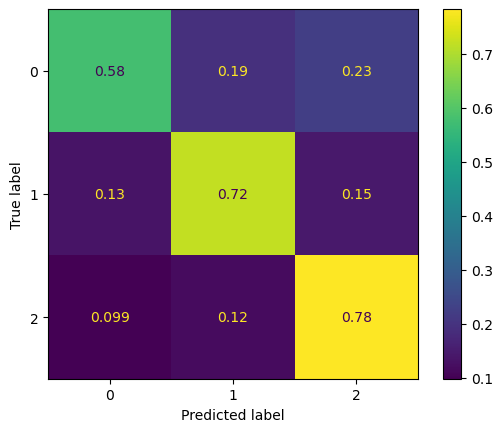

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.69453. Saving Model!
epoch 01, loss: 0.75939, acc: 0.65179, val_loss: 0.69453, val_accuracy: 0.72358


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]


epoch 02, loss: 0.74816, acc: 0.65935, val_loss: 0.70018, val_accuracy: 0.71713


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 03, loss: 0.74761, acc: 0.65698, val_loss: 0.70402, val_accuracy: 0.71852


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 04, loss: 0.74584, acc: 0.65478, val_loss: 0.70585, val_accuracy: 0.71912


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 05, loss: 0.74068, acc: 0.66070, val_loss: 0.70997, val_accuracy: 0.70453


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 06, loss: 0.73920, acc: 0.66410, val_loss: 0.71374, val_accuracy: 0.70711


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 07, loss: 0.73735, acc: 0.66583, val_loss: 0.71557, val_accuracy: 0.70910


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 08, loss: 0.73542, acc: 0.66560, val_loss: 0.71766, val_accuracy: 0.69342


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 09, loss: 0.73364, acc: 0.66727, val_loss: 0.72043, val_accuracy: 0.69382


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 10, loss: 0.73206, acc: 0.66700, val_loss: 0.72199, val_accuracy: 0.68479


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 11, loss: 0.73156, acc: 0.66742, val_loss: 0.72489, val_accuracy: 0.68271


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 12, loss: 0.72989, acc: 0.66966, val_loss: 0.72636, val_accuracy: 0.68291


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.93it/s]


epoch 13, loss: 0.72981, acc: 0.67090, val_loss: 0.72972, val_accuracy: 0.66554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 14, loss: 0.72696, acc: 0.67535, val_loss: 0.73135, val_accuracy: 0.66544


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 15, loss: 0.72749, acc: 0.67492, val_loss: 0.73203, val_accuracy: 0.66703


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 16, loss: 0.72613, acc: 0.67144, val_loss: 0.73457, val_accuracy: 0.66574


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 17, loss: 0.72465, acc: 0.67508, val_loss: 0.73662, val_accuracy: 0.66663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 18, loss: 0.72419, acc: 0.67417, val_loss: 0.73701, val_accuracy: 0.66524


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 19, loss: 0.72248, acc: 0.67618, val_loss: 0.73994, val_accuracy: 0.66683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 20, loss: 0.72275, acc: 0.67434, val_loss: 0.73988, val_accuracy: 0.66753


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 21, loss: 0.72088, acc: 0.67438, val_loss: 0.74213, val_accuracy: 0.66266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.08it/s]


epoch 22, loss: 0.72135, acc: 0.67479, val_loss: 0.74349, val_accuracy: 0.66634


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 23, loss: 0.71900, acc: 0.67526, val_loss: 0.74392, val_accuracy: 0.66326


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


epoch 24, loss: 0.71944, acc: 0.67387, val_loss: 0.74670, val_accuracy: 0.66237


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.95it/s]


epoch 25, loss: 0.71770, acc: 0.67347, val_loss: 0.74678, val_accuracy: 0.66217


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 26, loss: 0.71786, acc: 0.67572, val_loss: 0.74875, val_accuracy: 0.65959


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 27, loss: 0.71554, acc: 0.68025, val_loss: 0.75070, val_accuracy: 0.66266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 28, loss: 0.71648, acc: 0.67598, val_loss: 0.74923, val_accuracy: 0.66038


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 29, loss: 0.71416, acc: 0.67908, val_loss: 0.75308, val_accuracy: 0.66346


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 30, loss: 0.71476, acc: 0.67693, val_loss: 0.75305, val_accuracy: 0.65969


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 31, loss: 0.71271, acc: 0.68013, val_loss: 0.75595, val_accuracy: 0.66376


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 32, loss: 0.71284, acc: 0.67806, val_loss: 0.75574, val_accuracy: 0.66257


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 33, loss: 0.71246, acc: 0.67667, val_loss: 0.75714, val_accuracy: 0.66266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 34, loss: 0.71092, acc: 0.67950, val_loss: 0.75622, val_accuracy: 0.66108


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 35, loss: 0.70997, acc: 0.68153, val_loss: 0.75929, val_accuracy: 0.66167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 36, loss: 0.70987, acc: 0.68069, val_loss: 0.76089, val_accuracy: 0.66177


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 37, loss: 0.70884, acc: 0.68187, val_loss: 0.75973, val_accuracy: 0.66247


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 38, loss: 0.70793, acc: 0.68222, val_loss: 0.76477, val_accuracy: 0.66098


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]


epoch 39, loss: 0.70801, acc: 0.68243, val_loss: 0.76086, val_accuracy: 0.66356


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.06it/s]


epoch 40, loss: 0.70695, acc: 0.68324, val_loss: 0.76559, val_accuracy: 0.66128


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 41, loss: 0.70563, acc: 0.68390, val_loss: 0.76308, val_accuracy: 0.66376


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 42, loss: 0.70569, acc: 0.68208, val_loss: 0.76585, val_accuracy: 0.66286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 43, loss: 0.70470, acc: 0.68273, val_loss: 0.76501, val_accuracy: 0.66128


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 44, loss: 0.70411, acc: 0.68646, val_loss: 0.76775, val_accuracy: 0.66187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 45, loss: 0.70289, acc: 0.68467, val_loss: 0.76846, val_accuracy: 0.66276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 46, loss: 0.70322, acc: 0.68517, val_loss: 0.76782, val_accuracy: 0.66088


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 47, loss: 0.70082, acc: 0.68889, val_loss: 0.77093, val_accuracy: 0.66276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 48, loss: 0.70165, acc: 0.68449, val_loss: 0.77034, val_accuracy: 0.66257


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 49, loss: 0.69952, acc: 0.68790, val_loss: 0.77172, val_accuracy: 0.66187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 50, loss: 0.70010, acc: 0.68926, val_loss: 0.77190, val_accuracy: 0.66247


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


epoch 51, loss: 0.69813, acc: 0.69035, val_loss: 0.77251, val_accuracy: 0.66286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]


epoch 52, loss: 0.69949, acc: 0.68645, val_loss: 0.77342, val_accuracy: 0.66306


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.60it/s]


epoch 53, loss: 0.69696, acc: 0.68884, val_loss: 0.77483, val_accuracy: 0.66395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66it/s]


epoch 54, loss: 0.69707, acc: 0.69034, val_loss: 0.77607, val_accuracy: 0.66425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 55, loss: 0.69561, acc: 0.68974, val_loss: 0.77407, val_accuracy: 0.66475


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 56, loss: 0.69684, acc: 0.69109, val_loss: 0.77800, val_accuracy: 0.66376


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 57, loss: 0.69422, acc: 0.68950, val_loss: 0.77624, val_accuracy: 0.66435


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 58, loss: 0.69493, acc: 0.69126, val_loss: 0.78038, val_accuracy: 0.65592


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


epoch 59, loss: 0.69315, acc: 0.69200, val_loss: 0.77781, val_accuracy: 0.66534


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.75it/s]


epoch 60, loss: 0.69288, acc: 0.69151, val_loss: 0.78077, val_accuracy: 0.65641


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 61, loss: 0.69245, acc: 0.69291, val_loss: 0.77956, val_accuracy: 0.66366


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 62, loss: 0.69083, acc: 0.69364, val_loss: 0.78166, val_accuracy: 0.65760


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 63, loss: 0.69137, acc: 0.69347, val_loss: 0.78264, val_accuracy: 0.65701


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 64, loss: 0.68993, acc: 0.69234, val_loss: 0.78105, val_accuracy: 0.65671


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 65, loss: 0.68993, acc: 0.69428, val_loss: 0.78476, val_accuracy: 0.65721


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.38it/s]


epoch 66, loss: 0.68909, acc: 0.69357, val_loss: 0.78127, val_accuracy: 0.66386


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 67, loss: 0.68837, acc: 0.69426, val_loss: 0.78658, val_accuracy: 0.65691


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 68, loss: 0.68844, acc: 0.69532, val_loss: 0.78370, val_accuracy: 0.65364


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 69, loss: 0.68635, acc: 0.69263, val_loss: 0.78755, val_accuracy: 0.65820


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 70, loss: 0.68735, acc: 0.69374, val_loss: 0.78559, val_accuracy: 0.65711


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 71, loss: 0.68540, acc: 0.69664, val_loss: 0.78839, val_accuracy: 0.64768


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 72, loss: 0.68543, acc: 0.69534, val_loss: 0.78877, val_accuracy: 0.64858


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


epoch 73, loss: 0.68492, acc: 0.69610, val_loss: 0.78784, val_accuracy: 0.64610


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 74, loss: 0.68398, acc: 0.69765, val_loss: 0.78976, val_accuracy: 0.64877


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 75, loss: 0.68349, acc: 0.69659, val_loss: 0.78948, val_accuracy: 0.64818


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 76, loss: 0.68250, acc: 0.69737, val_loss: 0.79184, val_accuracy: 0.64887


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 77, loss: 0.68281, acc: 0.69522, val_loss: 0.79109, val_accuracy: 0.64620


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 78, loss: 0.68060, acc: 0.69817, val_loss: 0.79290, val_accuracy: 0.63667


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 79, loss: 0.68212, acc: 0.69573, val_loss: 0.79012, val_accuracy: 0.64848


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


epoch 80, loss: 0.67943, acc: 0.69619, val_loss: 0.79508, val_accuracy: 0.63806


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 81, loss: 0.68212, acc: 0.69455, val_loss: 0.79069, val_accuracy: 0.64808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 82, loss: 0.67813, acc: 0.69546, val_loss: 0.79356, val_accuracy: 0.63786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 83, loss: 0.67953, acc: 0.69780, val_loss: 0.79554, val_accuracy: 0.63637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 84, loss: 0.67735, acc: 0.69823, val_loss: 0.79566, val_accuracy: 0.62814


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 85, loss: 0.67735, acc: 0.69761, val_loss: 0.79689, val_accuracy: 0.63766


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 86, loss: 0.67674, acc: 0.69599, val_loss: 0.79597, val_accuracy: 0.62893


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 87, loss: 0.67502, acc: 0.69972, val_loss: 0.79761, val_accuracy: 0.62853


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 88, loss: 0.67623, acc: 0.69647, val_loss: 0.79936, val_accuracy: 0.62774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 89, loss: 0.67441, acc: 0.69844, val_loss: 0.79959, val_accuracy: 0.62467


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 90, loss: 0.67463, acc: 0.69715, val_loss: 0.79935, val_accuracy: 0.62814


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 91, loss: 0.67316, acc: 0.69830, val_loss: 0.80259, val_accuracy: 0.62734


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 92, loss: 0.67318, acc: 0.69551, val_loss: 0.80244, val_accuracy: 0.63032


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 93, loss: 0.67387, acc: 0.69474, val_loss: 0.80371, val_accuracy: 0.62526


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 94, loss: 0.67125, acc: 0.69937, val_loss: 0.80469, val_accuracy: 0.62774


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 95, loss: 0.67087, acc: 0.69798, val_loss: 0.80431, val_accuracy: 0.62695


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 96, loss: 0.67086, acc: 0.69830, val_loss: 0.80704, val_accuracy: 0.62933


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.22it/s]


epoch 97, loss: 0.66967, acc: 0.69682, val_loss: 0.80676, val_accuracy: 0.62794


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 98, loss: 0.67056, acc: 0.69951, val_loss: 0.80730, val_accuracy: 0.62655


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 99, loss: 0.66830, acc: 0.70035, val_loss: 0.80493, val_accuracy: 0.62992


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 100, loss: 0.66811, acc: 0.69696, val_loss: 0.81140, val_accuracy: 0.63032


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 101, loss: 0.66931, acc: 0.69808, val_loss: 0.80684, val_accuracy: 0.62576


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 102, loss: 0.66686, acc: 0.70219, val_loss: 0.81074, val_accuracy: 0.63012


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 103, loss: 0.66773, acc: 0.69968, val_loss: 0.80877, val_accuracy: 0.62645


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 104, loss: 0.66639, acc: 0.70209, val_loss: 0.81281, val_accuracy: 0.62933


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.89it/s]


epoch 105, loss: 0.66509, acc: 0.70059, val_loss: 0.81042, val_accuracy: 0.62824


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.72it/s]


epoch 106, loss: 0.66524, acc: 0.69825, val_loss: 0.81300, val_accuracy: 0.63181


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 107, loss: 0.66501, acc: 0.69935, val_loss: 0.81293, val_accuracy: 0.62744


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 108, loss: 0.66321, acc: 0.70426, val_loss: 0.81106, val_accuracy: 0.63101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.74it/s]


epoch 109, loss: 0.66387, acc: 0.70057, val_loss: 0.81592, val_accuracy: 0.62923


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.47it/s]


epoch 110, loss: 0.66257, acc: 0.70013, val_loss: 0.81248, val_accuracy: 0.61445


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


epoch 111, loss: 0.66365, acc: 0.69734, val_loss: 0.81609, val_accuracy: 0.62844


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.78it/s]


epoch 112, loss: 0.66098, acc: 0.70714, val_loss: 0.81558, val_accuracy: 0.61455


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 113, loss: 0.66071, acc: 0.70091, val_loss: 0.81551, val_accuracy: 0.61375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 114, loss: 0.66089, acc: 0.70272, val_loss: 0.81908, val_accuracy: 0.61226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 115, loss: 0.65917, acc: 0.70727, val_loss: 0.81577, val_accuracy: 0.61425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 116, loss: 0.65948, acc: 0.70434, val_loss: 0.82018, val_accuracy: 0.61514


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.87it/s]


epoch 117, loss: 0.65912, acc: 0.70379, val_loss: 0.81643, val_accuracy: 0.61137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 118, loss: 0.65703, acc: 0.70947, val_loss: 0.82258, val_accuracy: 0.61345


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 119, loss: 0.65803, acc: 0.70791, val_loss: 0.81872, val_accuracy: 0.61246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 120, loss: 0.65621, acc: 0.70589, val_loss: 0.82454, val_accuracy: 0.61345


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 121, loss: 0.65566, acc: 0.71136, val_loss: 0.81903, val_accuracy: 0.61296


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 122, loss: 0.65674, acc: 0.70686, val_loss: 0.82391, val_accuracy: 0.61326


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


epoch 123, loss: 0.65461, acc: 0.70774, val_loss: 0.82314, val_accuracy: 0.61345


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 124, loss: 0.65547, acc: 0.70731, val_loss: 0.82570, val_accuracy: 0.61335


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 125, loss: 0.65381, acc: 0.70940, val_loss: 0.82471, val_accuracy: 0.61375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 126, loss: 0.65462, acc: 0.70516, val_loss: 0.82373, val_accuracy: 0.61405


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 127, loss: 0.65191, acc: 0.71214, val_loss: 0.82810, val_accuracy: 0.61484


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 128, loss: 0.65409, acc: 0.70860, val_loss: 0.82255, val_accuracy: 0.61405


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 129, loss: 0.65054, acc: 0.70972, val_loss: 0.83373, val_accuracy: 0.61494


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.00it/s]


epoch 130, loss: 0.65186, acc: 0.71267, val_loss: 0.82380, val_accuracy: 0.61554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 131, loss: 0.65045, acc: 0.71026, val_loss: 0.83158, val_accuracy: 0.61921


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 132, loss: 0.65259, acc: 0.70618, val_loss: 0.82576, val_accuracy: 0.61683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 133, loss: 0.64895, acc: 0.71037, val_loss: 0.82962, val_accuracy: 0.61633


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.11it/s]


epoch 134, loss: 0.64958, acc: 0.71336, val_loss: 0.82981, val_accuracy: 0.61405


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.61it/s]


epoch 135, loss: 0.64877, acc: 0.71146, val_loss: 0.82929, val_accuracy: 0.61732


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 136, loss: 0.64753, acc: 0.71193, val_loss: 0.83529, val_accuracy: 0.61455


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 137, loss: 0.64686, acc: 0.71438, val_loss: 0.82888, val_accuracy: 0.61812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]


epoch 138, loss: 0.64691, acc: 0.71039, val_loss: 0.83343, val_accuracy: 0.61782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.95it/s]


epoch 139, loss: 0.64695, acc: 0.71168, val_loss: 0.83077, val_accuracy: 0.61474


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.86it/s]


epoch 140, loss: 0.64432, acc: 0.71473, val_loss: 0.83538, val_accuracy: 0.61822


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.93it/s]


epoch 141, loss: 0.64527, acc: 0.71556, val_loss: 0.83535, val_accuracy: 0.61593


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


epoch 142, loss: 0.64548, acc: 0.71323, val_loss: 0.83278, val_accuracy: 0.61822


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.55it/s]


epoch 143, loss: 0.64176, acc: 0.71764, val_loss: 0.83901, val_accuracy: 0.61216


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 144, loss: 0.64478, acc: 0.71557, val_loss: 0.83074, val_accuracy: 0.61921


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 145, loss: 0.64208, acc: 0.71399, val_loss: 0.83687, val_accuracy: 0.61961


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 146, loss: 0.64228, acc: 0.71557, val_loss: 0.83619, val_accuracy: 0.61941


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.37it/s]


epoch 147, loss: 0.64152, acc: 0.71728, val_loss: 0.83820, val_accuracy: 0.61881


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 148, loss: 0.64124, acc: 0.71949, val_loss: 0.83644, val_accuracy: 0.61901


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 149, loss: 0.63903, acc: 0.71888, val_loss: 0.84020, val_accuracy: 0.61326


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 150, loss: 0.64085, acc: 0.71966, val_loss: 0.83699, val_accuracy: 0.62050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.86it/s]


epoch 151, loss: 0.63984, acc: 0.71627, val_loss: 0.84015, val_accuracy: 0.61653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.57it/s]


epoch 152, loss: 0.63696, acc: 0.72195, val_loss: 0.84318, val_accuracy: 0.61455


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


epoch 153, loss: 0.63972, acc: 0.71737, val_loss: 0.83887, val_accuracy: 0.61861


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 154, loss: 0.63625, acc: 0.72017, val_loss: 0.84493, val_accuracy: 0.62089


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 155, loss: 0.63807, acc: 0.71657, val_loss: 0.84119, val_accuracy: 0.61266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


epoch 156, loss: 0.63639, acc: 0.72347, val_loss: 0.84330, val_accuracy: 0.62268


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 157, loss: 0.63681, acc: 0.71748, val_loss: 0.84507, val_accuracy: 0.61226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.55it/s]


epoch 158, loss: 0.63560, acc: 0.72239, val_loss: 0.84199, val_accuracy: 0.62228


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 159, loss: 0.63479, acc: 0.71952, val_loss: 0.84639, val_accuracy: 0.62070


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 160, loss: 0.63429, acc: 0.72319, val_loss: 0.84484, val_accuracy: 0.60452


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 161, loss: 0.63387, acc: 0.71855, val_loss: 0.84728, val_accuracy: 0.61554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 162, loss: 0.63330, acc: 0.72050, val_loss: 0.84769, val_accuracy: 0.62278


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 163, loss: 0.63210, acc: 0.72050, val_loss: 0.84837, val_accuracy: 0.60353


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.72it/s]


epoch 164, loss: 0.63289, acc: 0.72175, val_loss: 0.84764, val_accuracy: 0.62486


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 165, loss: 0.63051, acc: 0.71997, val_loss: 0.85200, val_accuracy: 0.60065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 166, loss: 0.63067, acc: 0.72313, val_loss: 0.85037, val_accuracy: 0.60800


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.71it/s]


epoch 167, loss: 0.63202, acc: 0.71808, val_loss: 0.85063, val_accuracy: 0.60651


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.46it/s]


epoch 168, loss: 0.62872, acc: 0.72451, val_loss: 0.84999, val_accuracy: 0.59907


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


epoch 169, loss: 0.63076, acc: 0.72097, val_loss: 0.85177, val_accuracy: 0.60006


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 170, loss: 0.62800, acc: 0.72636, val_loss: 0.85425, val_accuracy: 0.59837


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 171, loss: 0.62995, acc: 0.72221, val_loss: 0.85123, val_accuracy: 0.60036


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.54it/s]


epoch 172, loss: 0.62693, acc: 0.72568, val_loss: 0.85797, val_accuracy: 0.60085


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.28it/s]


epoch 173, loss: 0.62803, acc: 0.72158, val_loss: 0.85379, val_accuracy: 0.59698


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.03it/s]


epoch 174, loss: 0.62802, acc: 0.72333, val_loss: 0.85820, val_accuracy: 0.59927


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 175, loss: 0.62501, acc: 0.72647, val_loss: 0.85907, val_accuracy: 0.59173


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.69it/s]


epoch 176, loss: 0.62603, acc: 0.72384, val_loss: 0.85988, val_accuracy: 0.60006


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.35it/s]


epoch 177, loss: 0.62512, acc: 0.72505, val_loss: 0.85967, val_accuracy: 0.59103


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 178, loss: 0.62514, acc: 0.72437, val_loss: 0.86009, val_accuracy: 0.59371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 179, loss: 0.62227, acc: 0.72480, val_loss: 0.86361, val_accuracy: 0.59143


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 180, loss: 0.62493, acc: 0.72838, val_loss: 0.85951, val_accuracy: 0.59391


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 181, loss: 0.62098, acc: 0.72574, val_loss: 0.86373, val_accuracy: 0.59252


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 182, loss: 0.62274, acc: 0.72808, val_loss: 0.86214, val_accuracy: 0.60194


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 183, loss: 0.62186, acc: 0.72471, val_loss: 0.86313, val_accuracy: 0.59738


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 184, loss: 0.62190, acc: 0.72897, val_loss: 0.86692, val_accuracy: 0.59182


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]


epoch 185, loss: 0.61986, acc: 0.72848, val_loss: 0.86712, val_accuracy: 0.59361


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.72it/s]


epoch 186, loss: 0.61921, acc: 0.73128, val_loss: 0.86974, val_accuracy: 0.60065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.34it/s]


epoch 187, loss: 0.62141, acc: 0.72783, val_loss: 0.86569, val_accuracy: 0.59123


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.71it/s]


epoch 188, loss: 0.61594, acc: 0.73156, val_loss: 0.87086, val_accuracy: 0.59351


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 189, loss: 0.62118, acc: 0.72974, val_loss: 0.86753, val_accuracy: 0.60085


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 190, loss: 0.61708, acc: 0.72940, val_loss: 0.86794, val_accuracy: 0.59331


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 191, loss: 0.61763, acc: 0.73184, val_loss: 0.87098, val_accuracy: 0.60204


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 192, loss: 0.61628, acc: 0.73109, val_loss: 0.87145, val_accuracy: 0.59976


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 193, loss: 0.61661, acc: 0.73106, val_loss: 0.87190, val_accuracy: 0.60294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 194, loss: 0.61634, acc: 0.72935, val_loss: 0.87303, val_accuracy: 0.59123


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 195, loss: 0.61410, acc: 0.73360, val_loss: 0.87389, val_accuracy: 0.60363


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 196, loss: 0.61716, acc: 0.72570, val_loss: 0.87160, val_accuracy: 0.59857


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 197, loss: 0.61345, acc: 0.73282, val_loss: 0.87468, val_accuracy: 0.60175


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.05it/s]


epoch 198, loss: 0.61492, acc: 0.73091, val_loss: 0.87564, val_accuracy: 0.59272


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 199, loss: 0.61133, acc: 0.73466, val_loss: 0.88022, val_accuracy: 0.60244


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 200, loss: 0.61530, acc: 0.72788, val_loss: 0.87478, val_accuracy: 0.57406


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 201, loss: 0.61011, acc: 0.73322, val_loss: 0.87803, val_accuracy: 0.57952


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 202, loss: 0.61331, acc: 0.73271, val_loss: 0.87701, val_accuracy: 0.58528


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 203, loss: 0.60959, acc: 0.73425, val_loss: 0.88155, val_accuracy: 0.58458


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


epoch 204, loss: 0.61304, acc: 0.73120, val_loss: 0.87536, val_accuracy: 0.57575


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 205, loss: 0.60881, acc: 0.73390, val_loss: 0.88469, val_accuracy: 0.57863


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 206, loss: 0.61010, acc: 0.73382, val_loss: 0.88031, val_accuracy: 0.58647


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.78it/s]


epoch 207, loss: 0.61059, acc: 0.73003, val_loss: 0.88724, val_accuracy: 0.58339


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 208, loss: 0.60843, acc: 0.73714, val_loss: 0.88067, val_accuracy: 0.58617


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 209, loss: 0.60913, acc: 0.73205, val_loss: 0.88524, val_accuracy: 0.58676


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.87it/s]


epoch 210, loss: 0.60636, acc: 0.73545, val_loss: 0.88504, val_accuracy: 0.58676


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]


epoch 211, loss: 0.60809, acc: 0.73193, val_loss: 0.88838, val_accuracy: 0.58518


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 212, loss: 0.60734, acc: 0.73536, val_loss: 0.88472, val_accuracy: 0.58448


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 213, loss: 0.60630, acc: 0.73356, val_loss: 0.88646, val_accuracy: 0.57883


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 214, loss: 0.60340, acc: 0.73764, val_loss: 0.88911, val_accuracy: 0.57843


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 215, loss: 0.60672, acc: 0.73351, val_loss: 0.88846, val_accuracy: 0.58508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


epoch 216, loss: 0.60473, acc: 0.73638, val_loss: 0.88811, val_accuracy: 0.57932


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 217, loss: 0.60253, acc: 0.73843, val_loss: 0.89517, val_accuracy: 0.58002


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 218, loss: 0.60298, acc: 0.73704, val_loss: 0.88860, val_accuracy: 0.58805


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 219, loss: 0.60180, acc: 0.73771, val_loss: 0.89995, val_accuracy: 0.58061


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]


epoch 220, loss: 0.60257, acc: 0.73509, val_loss: 0.88654, val_accuracy: 0.58875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 221, loss: 0.60130, acc: 0.73570, val_loss: 0.90243, val_accuracy: 0.58061


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 222, loss: 0.59973, acc: 0.73996, val_loss: 0.88901, val_accuracy: 0.58746


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20it/s]


epoch 223, loss: 0.60116, acc: 0.73882, val_loss: 0.89976, val_accuracy: 0.58141


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 224, loss: 0.59747, acc: 0.74318, val_loss: 0.89563, val_accuracy: 0.58924


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 225, loss: 0.60048, acc: 0.73754, val_loss: 0.90051, val_accuracy: 0.58141


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.48it/s]


epoch 226, loss: 0.59771, acc: 0.74116, val_loss: 0.89508, val_accuracy: 0.59053


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 227, loss: 0.59831, acc: 0.74070, val_loss: 0.89814, val_accuracy: 0.58230


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 228, loss: 0.59584, acc: 0.74057, val_loss: 0.90148, val_accuracy: 0.58309


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 229, loss: 0.59927, acc: 0.74012, val_loss: 0.89802, val_accuracy: 0.58141


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 230, loss: 0.59497, acc: 0.74283, val_loss: 0.90282, val_accuracy: 0.59113


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 231, loss: 0.59603, acc: 0.74113, val_loss: 0.90090, val_accuracy: 0.58895


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 232, loss: 0.59607, acc: 0.74070, val_loss: 0.90784, val_accuracy: 0.58290


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.73it/s]


epoch 233, loss: 0.59351, acc: 0.74210, val_loss: 0.89898, val_accuracy: 0.59143


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 234, loss: 0.59692, acc: 0.74139, val_loss: 0.91382, val_accuracy: 0.58359


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 235, loss: 0.59349, acc: 0.74342, val_loss: 0.90014, val_accuracy: 0.59093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 236, loss: 0.59458, acc: 0.74175, val_loss: 0.91225, val_accuracy: 0.58637


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 237, loss: 0.59116, acc: 0.74369, val_loss: 0.90191, val_accuracy: 0.59093


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 238, loss: 0.59462, acc: 0.73985, val_loss: 0.91053, val_accuracy: 0.58309


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.22it/s]


epoch 239, loss: 0.58961, acc: 0.74430, val_loss: 0.91143, val_accuracy: 0.59222


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 240, loss: 0.59165, acc: 0.74166, val_loss: 0.91257, val_accuracy: 0.58101


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 241, loss: 0.59056, acc: 0.74302, val_loss: 0.91373, val_accuracy: 0.58974


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 242, loss: 0.58972, acc: 0.74378, val_loss: 0.91192, val_accuracy: 0.59053


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 243, loss: 0.58880, acc: 0.74416, val_loss: 0.91675, val_accuracy: 0.58250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 244, loss: 0.58952, acc: 0.74427, val_loss: 0.91430, val_accuracy: 0.58299


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 245, loss: 0.58798, acc: 0.74497, val_loss: 0.91747, val_accuracy: 0.59311


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


epoch 246, loss: 0.58700, acc: 0.74435, val_loss: 0.92139, val_accuracy: 0.58468


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


epoch 247, loss: 0.58786, acc: 0.74505, val_loss: 0.91280, val_accuracy: 0.59311


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 248, loss: 0.58644, acc: 0.74632, val_loss: 0.92465, val_accuracy: 0.58280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]


epoch 249, loss: 0.58808, acc: 0.74528, val_loss: 0.92064, val_accuracy: 0.59182


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 250, loss: 0.58610, acc: 0.74413, val_loss: 0.92365, val_accuracy: 0.58776


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.86it/s]


epoch 251, loss: 0.58688, acc: 0.74611, val_loss: 0.91918, val_accuracy: 0.58488


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.01it/s]


epoch 252, loss: 0.58538, acc: 0.74442, val_loss: 0.92611, val_accuracy: 0.58260


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97it/s]


epoch 253, loss: 0.58341, acc: 0.74738, val_loss: 0.92373, val_accuracy: 0.59252


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.40it/s]


epoch 254, loss: 0.58554, acc: 0.74522, val_loss: 0.93055, val_accuracy: 0.58567


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 255, loss: 0.58281, acc: 0.74692, val_loss: 0.91851, val_accuracy: 0.59222


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 256, loss: 0.58317, acc: 0.75040, val_loss: 0.93860, val_accuracy: 0.58786


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 257, loss: 0.58248, acc: 0.74809, val_loss: 0.92211, val_accuracy: 0.58885


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 258, loss: 0.58254, acc: 0.74714, val_loss: 0.93417, val_accuracy: 0.58597


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 259, loss: 0.58071, acc: 0.74801, val_loss: 0.92509, val_accuracy: 0.59242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 260, loss: 0.58191, acc: 0.75005, val_loss: 0.93792, val_accuracy: 0.58230


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 261, loss: 0.57855, acc: 0.74880, val_loss: 0.92832, val_accuracy: 0.59311


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 262, loss: 0.58148, acc: 0.74687, val_loss: 0.93663, val_accuracy: 0.58111


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


epoch 263, loss: 0.57949, acc: 0.74848, val_loss: 0.93388, val_accuracy: 0.59292


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.48it/s]


epoch 264, loss: 0.57941, acc: 0.75177, val_loss: 0.93561, val_accuracy: 0.58250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 265, loss: 0.57681, acc: 0.75239, val_loss: 0.93623, val_accuracy: 0.59321


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 266, loss: 0.57814, acc: 0.75192, val_loss: 0.93897, val_accuracy: 0.58746


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.80it/s]


epoch 267, loss: 0.57545, acc: 0.75379, val_loss: 0.93440, val_accuracy: 0.59619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]


epoch 268, loss: 0.57637, acc: 0.75265, val_loss: 0.94224, val_accuracy: 0.58895


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.21it/s]


epoch 269, loss: 0.57683, acc: 0.75217, val_loss: 0.93289, val_accuracy: 0.59490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 270, loss: 0.57462, acc: 0.75490, val_loss: 0.94752, val_accuracy: 0.58964


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 271, loss: 0.57573, acc: 0.75277, val_loss: 0.93849, val_accuracy: 0.59014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 272, loss: 0.57376, acc: 0.75421, val_loss: 0.95056, val_accuracy: 0.58845


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.10it/s]


epoch 273, loss: 0.57363, acc: 0.75502, val_loss: 0.94434, val_accuracy: 0.59421


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 274, loss: 0.57299, acc: 0.75446, val_loss: 0.94869, val_accuracy: 0.58458


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 275, loss: 0.57326, acc: 0.75445, val_loss: 0.94271, val_accuracy: 0.59450


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.35it/s]


epoch 276, loss: 0.57138, acc: 0.75538, val_loss: 0.95323, val_accuracy: 0.58597


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.13it/s]


epoch 277, loss: 0.57177, acc: 0.75623, val_loss: 0.94880, val_accuracy: 0.59510


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


epoch 278, loss: 0.57126, acc: 0.75422, val_loss: 0.94914, val_accuracy: 0.58587


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.84it/s]


epoch 279, loss: 0.57067, acc: 0.75606, val_loss: 0.94616, val_accuracy: 0.59788


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 280, loss: 0.57090, acc: 0.75520, val_loss: 0.95528, val_accuracy: 0.58627


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 281, loss: 0.57014, acc: 0.75530, val_loss: 0.94126, val_accuracy: 0.59808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 282, loss: 0.57022, acc: 0.75371, val_loss: 0.95625, val_accuracy: 0.58885


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 283, loss: 0.56770, acc: 0.75762, val_loss: 0.95193, val_accuracy: 0.59758


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 284, loss: 0.56827, acc: 0.75651, val_loss: 0.96094, val_accuracy: 0.58815


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 285, loss: 0.56856, acc: 0.75562, val_loss: 0.95201, val_accuracy: 0.59748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 286, loss: 0.56703, acc: 0.75521, val_loss: 0.95503, val_accuracy: 0.58577


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 287, loss: 0.56621, acc: 0.75713, val_loss: 0.96220, val_accuracy: 0.59053


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 288, loss: 0.56671, acc: 0.75738, val_loss: 0.95954, val_accuracy: 0.58706


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.17it/s]


epoch 289, loss: 0.56582, acc: 0.75622, val_loss: 0.96250, val_accuracy: 0.59103


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.30it/s]


epoch 290, loss: 0.56658, acc: 0.75589, val_loss: 0.96200, val_accuracy: 0.58766


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.81it/s]


epoch 291, loss: 0.56307, acc: 0.75886, val_loss: 0.96579, val_accuracy: 0.58865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93it/s]


epoch 292, loss: 0.56584, acc: 0.75822, val_loss: 0.96393, val_accuracy: 0.58835


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


epoch 293, loss: 0.56277, acc: 0.75683, val_loss: 0.96168, val_accuracy: 0.59530


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 294, loss: 0.56476, acc: 0.75850, val_loss: 0.96539, val_accuracy: 0.58865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.31it/s]


epoch 295, loss: 0.56182, acc: 0.76038, val_loss: 0.96844, val_accuracy: 0.58835


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 296, loss: 0.56214, acc: 0.75920, val_loss: 0.96884, val_accuracy: 0.59311


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 297, loss: 0.56250, acc: 0.75870, val_loss: 0.96930, val_accuracy: 0.59163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 298, loss: 0.56265, acc: 0.75861, val_loss: 0.95937, val_accuracy: 0.59808


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 299, loss: 0.56061, acc: 0.76091, val_loss: 0.97768, val_accuracy: 0.59500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 300, loss: 0.56169, acc: 0.76041, val_loss: 0.96679, val_accuracy: 0.59907


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.04it/s]


epoch 301, loss: 0.56085, acc: 0.75795, val_loss: 0.97570, val_accuracy: 0.59480


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


epoch 302, loss: 0.55989, acc: 0.76095, val_loss: 0.96913, val_accuracy: 0.59133


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 303, loss: 0.55841, acc: 0.75936, val_loss: 0.97899, val_accuracy: 0.59550


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 304, loss: 0.55874, acc: 0.76132, val_loss: 0.96706, val_accuracy: 0.60095


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 305, loss: 0.55900, acc: 0.76093, val_loss: 0.97683, val_accuracy: 0.60314


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 306, loss: 0.55643, acc: 0.76232, val_loss: 0.97412, val_accuracy: 0.59827


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 307, loss: 0.55721, acc: 0.76188, val_loss: 0.98246, val_accuracy: 0.59470


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.78it/s]


epoch 308, loss: 0.55564, acc: 0.76165, val_loss: 0.97177, val_accuracy: 0.59579


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 309, loss: 0.55608, acc: 0.76362, val_loss: 0.98222, val_accuracy: 0.59688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 310, loss: 0.55552, acc: 0.76176, val_loss: 0.97359, val_accuracy: 0.60373


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.01it/s]


epoch 311, loss: 0.55421, acc: 0.76148, val_loss: 0.98351, val_accuracy: 0.59708


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]


epoch 312, loss: 0.55441, acc: 0.76272, val_loss: 0.98144, val_accuracy: 0.59778


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.67it/s]


epoch 313, loss: 0.55347, acc: 0.76414, val_loss: 0.98696, val_accuracy: 0.59669


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.37it/s]


epoch 314, loss: 0.55446, acc: 0.75974, val_loss: 0.97769, val_accuracy: 0.59599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 315, loss: 0.55507, acc: 0.76169, val_loss: 0.98396, val_accuracy: 0.59748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 316, loss: 0.55146, acc: 0.76151, val_loss: 0.98554, val_accuracy: 0.59292


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 317, loss: 0.55419, acc: 0.76308, val_loss: 0.98613, val_accuracy: 0.59708


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]


epoch 318, loss: 0.54980, acc: 0.76418, val_loss: 0.98651, val_accuracy: 0.59619


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 319, loss: 0.55308, acc: 0.76365, val_loss: 0.98391, val_accuracy: 0.59540


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.22it/s]


epoch 320, loss: 0.54946, acc: 0.76489, val_loss: 0.99313, val_accuracy: 0.59917


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 321, loss: 0.55115, acc: 0.76479, val_loss: 0.98950, val_accuracy: 0.59669


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.91it/s]


epoch 322, loss: 0.54989, acc: 0.76477, val_loss: 0.98539, val_accuracy: 0.59837


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 323, loss: 0.54949, acc: 0.76393, val_loss: 0.99108, val_accuracy: 0.60730


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.01it/s]


epoch 324, loss: 0.54769, acc: 0.76649, val_loss: 0.99207, val_accuracy: 0.60016


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 325, loss: 0.54979, acc: 0.76397, val_loss: 0.98572, val_accuracy: 0.59837


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.98it/s]


epoch 326, loss: 0.54770, acc: 0.76399, val_loss: 0.99712, val_accuracy: 0.59857


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 327, loss: 0.54696, acc: 0.76669, val_loss: 0.98907, val_accuracy: 0.59956


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


epoch 328, loss: 0.54782, acc: 0.76415, val_loss: 0.99988, val_accuracy: 0.59946


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.78it/s]


epoch 329, loss: 0.54640, acc: 0.76662, val_loss: 0.99006, val_accuracy: 0.60562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 330, loss: 0.54653, acc: 0.76434, val_loss: 1.00425, val_accuracy: 0.59917


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 331, loss: 0.54537, acc: 0.76723, val_loss: 0.99605, val_accuracy: 0.59976


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 332, loss: 0.54706, acc: 0.76480, val_loss: 0.99487, val_accuracy: 0.60006


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 333, loss: 0.54393, acc: 0.76557, val_loss: 0.99819, val_accuracy: 0.60730


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 334, loss: 0.54485, acc: 0.76599, val_loss: 1.00393, val_accuracy: 0.58905


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.91it/s]


epoch 335, loss: 0.54479, acc: 0.76615, val_loss: 1.00345, val_accuracy: 0.60760


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 336, loss: 0.54636, acc: 0.76324, val_loss: 0.99559, val_accuracy: 0.60175


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


epoch 337, loss: 0.54314, acc: 0.76504, val_loss: 1.00078, val_accuracy: 0.60065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 338, loss: 0.54228, acc: 0.76803, val_loss: 1.00372, val_accuracy: 0.60294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.63it/s]


epoch 339, loss: 0.54279, acc: 0.76590, val_loss: 1.00792, val_accuracy: 0.60165


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 340, loss: 0.54039, acc: 0.76771, val_loss: 1.00432, val_accuracy: 0.60958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.44it/s]


epoch 341, loss: 0.54203, acc: 0.76456, val_loss: 1.00842, val_accuracy: 0.60294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 342, loss: 0.54204, acc: 0.76580, val_loss: 0.99741, val_accuracy: 0.60065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 343, loss: 0.54013, acc: 0.76791, val_loss: 1.01367, val_accuracy: 0.60433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 344, loss: 0.53902, acc: 0.76886, val_loss: 1.00414, val_accuracy: 0.61028


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


epoch 345, loss: 0.54059, acc: 0.76366, val_loss: 1.01198, val_accuracy: 0.60333


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.72it/s]


epoch 346, loss: 0.53932, acc: 0.76714, val_loss: 1.00276, val_accuracy: 0.61028


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 347, loss: 0.53886, acc: 0.76817, val_loss: 1.01693, val_accuracy: 0.59996


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


epoch 348, loss: 0.53753, acc: 0.76809, val_loss: 1.01011, val_accuracy: 0.60482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 349, loss: 0.54008, acc: 0.76378, val_loss: 1.01873, val_accuracy: 0.60294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 350, loss: 0.53682, acc: 0.76919, val_loss: 1.00240, val_accuracy: 0.61107


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.89it/s]


epoch 351, loss: 0.54056, acc: 0.76606, val_loss: 1.02772, val_accuracy: 0.60978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.86it/s]


epoch 352, loss: 0.53610, acc: 0.76953, val_loss: 1.00680, val_accuracy: 0.61177


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.88it/s]


epoch 353, loss: 0.53852, acc: 0.76490, val_loss: 1.02391, val_accuracy: 0.60968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 354, loss: 0.53604, acc: 0.77072, val_loss: 1.00226, val_accuracy: 0.61236


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 355, loss: 0.53716, acc: 0.76773, val_loss: 1.02325, val_accuracy: 0.60532


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 356, loss: 0.53345, acc: 0.76996, val_loss: 1.00711, val_accuracy: 0.61276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.02it/s]


epoch 357, loss: 0.53616, acc: 0.76789, val_loss: 1.02450, val_accuracy: 0.60383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.31it/s]


epoch 358, loss: 0.53128, acc: 0.77248, val_loss: 1.01422, val_accuracy: 0.61375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]


epoch 359, loss: 0.53574, acc: 0.76837, val_loss: 1.02960, val_accuracy: 0.60443


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 360, loss: 0.53032, acc: 0.76979, val_loss: 1.01254, val_accuracy: 0.60780


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 361, loss: 0.53543, acc: 0.77053, val_loss: 1.02497, val_accuracy: 0.60413


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 362, loss: 0.53060, acc: 0.77195, val_loss: 1.01691, val_accuracy: 0.60988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


epoch 363, loss: 0.53145, acc: 0.76997, val_loss: 1.03291, val_accuracy: 0.60482


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.93it/s]


epoch 364, loss: 0.53032, acc: 0.77113, val_loss: 1.01965, val_accuracy: 0.60393


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20it/s]


epoch 365, loss: 0.53052, acc: 0.77121, val_loss: 1.03309, val_accuracy: 0.60512


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.87it/s]


epoch 366, loss: 0.52941, acc: 0.77286, val_loss: 1.02530, val_accuracy: 0.60145


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.59it/s]


epoch 367, loss: 0.52990, acc: 0.77007, val_loss: 1.03104, val_accuracy: 0.60571


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]


epoch 368, loss: 0.53047, acc: 0.77080, val_loss: 1.02176, val_accuracy: 0.59966


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 369, loss: 0.52984, acc: 0.77283, val_loss: 1.03107, val_accuracy: 0.60433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]


epoch 370, loss: 0.52751, acc: 0.77234, val_loss: 1.02847, val_accuracy: 0.61316


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 371, loss: 0.52787, acc: 0.77285, val_loss: 1.03836, val_accuracy: 0.60562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]


epoch 372, loss: 0.52731, acc: 0.77368, val_loss: 1.03405, val_accuracy: 0.60571


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.61it/s]


epoch 373, loss: 0.52675, acc: 0.77308, val_loss: 1.03786, val_accuracy: 0.60661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]


epoch 374, loss: 0.52743, acc: 0.77206, val_loss: 1.02956, val_accuracy: 0.60472


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 375, loss: 0.52705, acc: 0.77444, val_loss: 1.03689, val_accuracy: 0.60502


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 376, loss: 0.52486, acc: 0.77405, val_loss: 1.03581, val_accuracy: 0.60661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 377, loss: 0.52507, acc: 0.77300, val_loss: 1.04698, val_accuracy: 0.60780


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 378, loss: 0.52454, acc: 0.77319, val_loss: 1.03638, val_accuracy: 0.60790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 379, loss: 0.52372, acc: 0.77536, val_loss: 1.04910, val_accuracy: 0.60581


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 380, loss: 0.52469, acc: 0.77342, val_loss: 1.03030, val_accuracy: 0.60264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 381, loss: 0.52489, acc: 0.77475, val_loss: 1.04822, val_accuracy: 0.60502


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 382, loss: 0.52267, acc: 0.77925, val_loss: 1.03184, val_accuracy: 0.60274


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 383, loss: 0.52406, acc: 0.77343, val_loss: 1.05779, val_accuracy: 0.60552


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 384, loss: 0.52086, acc: 0.77921, val_loss: 1.03944, val_accuracy: 0.61544


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 385, loss: 0.52470, acc: 0.77329, val_loss: 1.04743, val_accuracy: 0.60621


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 386, loss: 0.52151, acc: 0.77806, val_loss: 1.04517, val_accuracy: 0.60740


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 387, loss: 0.52266, acc: 0.77313, val_loss: 1.05037, val_accuracy: 0.60294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.63it/s]


epoch 388, loss: 0.51969, acc: 0.77999, val_loss: 1.04601, val_accuracy: 0.60373


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 389, loss: 0.52192, acc: 0.77417, val_loss: 1.05068, val_accuracy: 0.59460


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 390, loss: 0.52051, acc: 0.77911, val_loss: 1.04654, val_accuracy: 0.61058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 391, loss: 0.52169, acc: 0.77666, val_loss: 1.05355, val_accuracy: 0.59728


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]


epoch 392, loss: 0.52215, acc: 0.77762, val_loss: 1.05126, val_accuracy: 0.61137


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 393, loss: 0.52288, acc: 0.77576, val_loss: 1.05379, val_accuracy: 0.59044


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 394, loss: 0.51892, acc: 0.77698, val_loss: 1.05262, val_accuracy: 0.60998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 395, loss: 0.52002, acc: 0.77921, val_loss: 1.04875, val_accuracy: 0.60661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 396, loss: 0.51785, acc: 0.78011, val_loss: 1.05479, val_accuracy: 0.61276


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 397, loss: 0.51870, acc: 0.77929, val_loss: 1.05298, val_accuracy: 0.60839


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 398, loss: 0.51850, acc: 0.77816, val_loss: 1.05664, val_accuracy: 0.60403


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 399, loss: 0.51726, acc: 0.78015, val_loss: 1.04710, val_accuracy: 0.60363


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 400, loss: 0.51669, acc: 0.78055, val_loss: 1.06718, val_accuracy: 0.60502


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 401, loss: 0.51566, acc: 0.78392, val_loss: 1.05358, val_accuracy: 0.61335


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 402, loss: 0.51577, acc: 0.77836, val_loss: 1.06348, val_accuracy: 0.60373


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 403, loss: 0.51641, acc: 0.78233, val_loss: 1.05395, val_accuracy: 0.60958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 404, loss: 0.51416, acc: 0.78197, val_loss: 1.06360, val_accuracy: 0.60740


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 405, loss: 0.51365, acc: 0.78384, val_loss: 1.06114, val_accuracy: 0.61058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


epoch 406, loss: 0.51454, acc: 0.78014, val_loss: 1.06990, val_accuracy: 0.60492


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.10it/s]


epoch 407, loss: 0.51522, acc: 0.78196, val_loss: 1.05260, val_accuracy: 0.60869


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 408, loss: 0.51215, acc: 0.78315, val_loss: 1.07075, val_accuracy: 0.60760


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 409, loss: 0.51284, acc: 0.78545, val_loss: 1.06274, val_accuracy: 0.59391


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 410, loss: 0.51300, acc: 0.78046, val_loss: 1.07126, val_accuracy: 0.60661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 411, loss: 0.51219, acc: 0.78540, val_loss: 1.05714, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 412, loss: 0.51174, acc: 0.78346, val_loss: 1.07680, val_accuracy: 0.61008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 413, loss: 0.51048, acc: 0.78613, val_loss: 1.06009, val_accuracy: 0.59599


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 414, loss: 0.51213, acc: 0.77999, val_loss: 1.07560, val_accuracy: 0.60700


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 415, loss: 0.51121, acc: 0.78504, val_loss: 1.05804, val_accuracy: 0.60532


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 416, loss: 0.51015, acc: 0.78385, val_loss: 1.08554, val_accuracy: 0.61058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 417, loss: 0.50967, acc: 0.78713, val_loss: 1.06839, val_accuracy: 0.59718


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 418, loss: 0.51177, acc: 0.78357, val_loss: 1.08005, val_accuracy: 0.61425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


epoch 419, loss: 0.50862, acc: 0.78456, val_loss: 1.06783, val_accuracy: 0.60304


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 420, loss: 0.51091, acc: 0.78443, val_loss: 1.08554, val_accuracy: 0.61157


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 421, loss: 0.50792, acc: 0.78467, val_loss: 1.06401, val_accuracy: 0.60790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 422, loss: 0.51029, acc: 0.78137, val_loss: 1.08472, val_accuracy: 0.61048


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.86it/s]


epoch 423, loss: 0.50838, acc: 0.78579, val_loss: 1.06309, val_accuracy: 0.61871


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 424, loss: 0.50721, acc: 0.78474, val_loss: 1.09141, val_accuracy: 0.60958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 425, loss: 0.50634, acc: 0.78863, val_loss: 1.06768, val_accuracy: 0.61752


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


epoch 426, loss: 0.50773, acc: 0.78367, val_loss: 1.08723, val_accuracy: 0.60671


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.01it/s]


epoch 427, loss: 0.50629, acc: 0.78698, val_loss: 1.07014, val_accuracy: 0.61961


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 428, loss: 0.50565, acc: 0.78435, val_loss: 1.08678, val_accuracy: 0.60879


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 429, loss: 0.50385, acc: 0.78915, val_loss: 1.07424, val_accuracy: 0.61226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.73it/s]


epoch 430, loss: 0.50697, acc: 0.78388, val_loss: 1.08323, val_accuracy: 0.60820


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.98it/s]


epoch 431, loss: 0.50342, acc: 0.78831, val_loss: 1.07089, val_accuracy: 0.60859


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.98it/s]


epoch 432, loss: 0.50486, acc: 0.78611, val_loss: 1.08540, val_accuracy: 0.60929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


epoch 433, loss: 0.50258, acc: 0.78917, val_loss: 1.08143, val_accuracy: 0.60978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 434, loss: 0.50418, acc: 0.78810, val_loss: 1.09493, val_accuracy: 0.60909


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 435, loss: 0.50312, acc: 0.78757, val_loss: 1.07037, val_accuracy: 0.61583


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 436, loss: 0.50230, acc: 0.78843, val_loss: 1.09627, val_accuracy: 0.60929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 437, loss: 0.50203, acc: 0.78887, val_loss: 1.08062, val_accuracy: 0.60978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 438, loss: 0.50337, acc: 0.78584, val_loss: 1.09999, val_accuracy: 0.60839


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 439, loss: 0.50232, acc: 0.78713, val_loss: 1.07125, val_accuracy: 0.60512


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 440, loss: 0.50303, acc: 0.78710, val_loss: 1.10414, val_accuracy: 0.60978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 441, loss: 0.50095, acc: 0.78856, val_loss: 1.08155, val_accuracy: 0.60522


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 442, loss: 0.50316, acc: 0.78801, val_loss: 1.09975, val_accuracy: 0.61534


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 443, loss: 0.50094, acc: 0.78996, val_loss: 1.08106, val_accuracy: 0.60333


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 444, loss: 0.50122, acc: 0.78787, val_loss: 1.11110, val_accuracy: 0.60849


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]


epoch 445, loss: 0.49996, acc: 0.79056, val_loss: 1.08536, val_accuracy: 0.60462


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 446, loss: 0.50126, acc: 0.78836, val_loss: 1.10590, val_accuracy: 0.60810


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 447, loss: 0.49932, acc: 0.79278, val_loss: 1.08385, val_accuracy: 0.60849


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 448, loss: 0.49863, acc: 0.78923, val_loss: 1.10702, val_accuracy: 0.61226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.98it/s]


epoch 449, loss: 0.49759, acc: 0.78890, val_loss: 1.08528, val_accuracy: 0.60968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.92it/s]


epoch 450, loss: 0.49822, acc: 0.78852, val_loss: 1.10837, val_accuracy: 0.60929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 451, loss: 0.49781, acc: 0.79081, val_loss: 1.08261, val_accuracy: 0.61693


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 452, loss: 0.49622, acc: 0.79114, val_loss: 1.10543, val_accuracy: 0.60929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 453, loss: 0.49515, acc: 0.79177, val_loss: 1.09032, val_accuracy: 0.61792


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.01it/s]


epoch 454, loss: 0.49785, acc: 0.78913, val_loss: 1.10879, val_accuracy: 0.61058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.05it/s]


epoch 455, loss: 0.49637, acc: 0.78953, val_loss: 1.09042, val_accuracy: 0.62218


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 456, loss: 0.49541, acc: 0.79052, val_loss: 1.11516, val_accuracy: 0.61117


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 457, loss: 0.49447, acc: 0.79257, val_loss: 1.09827, val_accuracy: 0.60978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 458, loss: 0.49690, acc: 0.78920, val_loss: 1.11046, val_accuracy: 0.60859


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.29it/s]


epoch 459, loss: 0.49459, acc: 0.79181, val_loss: 1.09660, val_accuracy: 0.61425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.88it/s]


epoch 460, loss: 0.49384, acc: 0.78888, val_loss: 1.10915, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.94it/s]


epoch 461, loss: 0.49242, acc: 0.79315, val_loss: 1.09708, val_accuracy: 0.59748


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.79it/s]


epoch 462, loss: 0.49433, acc: 0.79045, val_loss: 1.11376, val_accuracy: 0.60968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 463, loss: 0.49323, acc: 0.79093, val_loss: 1.09191, val_accuracy: 0.61792


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 464, loss: 0.49223, acc: 0.79189, val_loss: 1.11436, val_accuracy: 0.61038


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.98it/s]


epoch 465, loss: 0.49167, acc: 0.79307, val_loss: 1.10156, val_accuracy: 0.61077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.85it/s]


epoch 466, loss: 0.49243, acc: 0.79171, val_loss: 1.11615, val_accuracy: 0.60998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 467, loss: 0.49133, acc: 0.79218, val_loss: 1.10364, val_accuracy: 0.60929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


epoch 468, loss: 0.49017, acc: 0.79376, val_loss: 1.12357, val_accuracy: 0.61058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 469, loss: 0.48958, acc: 0.79421, val_loss: 1.10214, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 470, loss: 0.49163, acc: 0.78990, val_loss: 1.12620, val_accuracy: 0.60998


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 471, loss: 0.48993, acc: 0.79408, val_loss: 1.09729, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.54it/s]


epoch 472, loss: 0.49067, acc: 0.79239, val_loss: 1.13204, val_accuracy: 0.61167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


epoch 473, loss: 0.48826, acc: 0.79518, val_loss: 1.10539, val_accuracy: 0.61117


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 474, loss: 0.48935, acc: 0.79313, val_loss: 1.12697, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.94it/s]


epoch 475, loss: 0.48785, acc: 0.79453, val_loss: 1.10904, val_accuracy: 0.60968


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 476, loss: 0.48787, acc: 0.79324, val_loss: 1.13005, val_accuracy: 0.61127


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.78it/s]


epoch 477, loss: 0.48654, acc: 0.79685, val_loss: 1.10947, val_accuracy: 0.60978


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 478, loss: 0.48891, acc: 0.79157, val_loss: 1.12883, val_accuracy: 0.61028


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.91it/s]


epoch 479, loss: 0.48806, acc: 0.79366, val_loss: 1.10397, val_accuracy: 0.60621


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.10it/s]


epoch 480, loss: 0.48645, acc: 0.79074, val_loss: 1.13227, val_accuracy: 0.61147


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.87it/s]


epoch 481, loss: 0.48616, acc: 0.79624, val_loss: 1.11411, val_accuracy: 0.61058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


epoch 482, loss: 0.48799, acc: 0.79231, val_loss: 1.14216, val_accuracy: 0.61097


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]


epoch 483, loss: 0.48552, acc: 0.79294, val_loss: 1.10739, val_accuracy: 0.61028


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 484, loss: 0.48508, acc: 0.79233, val_loss: 1.13727, val_accuracy: 0.61028


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 485, loss: 0.48318, acc: 0.79792, val_loss: 1.11704, val_accuracy: 0.61087


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 486, loss: 0.48592, acc: 0.79328, val_loss: 1.13768, val_accuracy: 0.61018


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.84it/s]


epoch 487, loss: 0.48381, acc: 0.79629, val_loss: 1.11919, val_accuracy: 0.61068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]


epoch 488, loss: 0.48318, acc: 0.79404, val_loss: 1.14350, val_accuracy: 0.61087


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 489, loss: 0.48344, acc: 0.79634, val_loss: 1.11952, val_accuracy: 0.61117


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 490, loss: 0.48459, acc: 0.79224, val_loss: 1.13816, val_accuracy: 0.60958


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.86it/s]


epoch 491, loss: 0.48343, acc: 0.79512, val_loss: 1.11423, val_accuracy: 0.61157


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.34it/s]


epoch 492, loss: 0.48302, acc: 0.79375, val_loss: 1.14233, val_accuracy: 0.61226


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 493, loss: 0.48128, acc: 0.79815, val_loss: 1.12163, val_accuracy: 0.61246


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.50it/s]


epoch 494, loss: 0.48259, acc: 0.79456, val_loss: 1.14764, val_accuracy: 0.61097


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 495, loss: 0.48165, acc: 0.79636, val_loss: 1.12059, val_accuracy: 0.60988


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 496, loss: 0.48141, acc: 0.79410, val_loss: 1.14881, val_accuracy: 0.61127


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.26it/s]


epoch 497, loss: 0.47947, acc: 0.79713, val_loss: 1.13100, val_accuracy: 0.61077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.06it/s]


epoch 498, loss: 0.48078, acc: 0.79343, val_loss: 1.14861, val_accuracy: 0.61038


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


epoch 499, loss: 0.48087, acc: 0.79602, val_loss: 1.12838, val_accuracy: 0.61097


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 500, loss: 0.48007, acc: 0.79508, val_loss: 1.15219, val_accuracy: 0.61216
8번째 교차검증
evaluation loss: 0.69453, evaluation accuracy: 0.72358
(5, 10079)
(10079, 5)
Learning rate set to 0.103987
0:	learn: 1.0171445	total: 7.58ms	remaining: 7.58s
1:	learn: 0.9546375	total: 15.4ms	remaining: 7.66s
2:	learn: 0.9053903	total: 22.3ms	remaining: 7.42s
3:	learn: 0.8654141	total: 29.1ms	remaining: 7.24s
4:	learn: 0.8328453	total: 35.6ms	remaining: 7.09s
5:	learn: 0.8059600	total: 42.1ms	remaining: 6.97s
6:	learn: 0.7837878	total: 49ms	remaining: 6.96s
7:	learn: 0.7647432	total: 55.7ms	remaining: 6.9s
8:	learn: 0.7487989	total: 62.3ms	remaining: 6.86s
9:	learn: 0.7353640	total: 69ms	remaining: 6.83s
10:	learn: 0.7233704	total: 75.4ms	remaining: 6.78s
11:	learn: 0.7137876	total: 82.4ms	remaining: 6.79s
12:	learn: 0.7053128	total: 88.8ms	remaining: 6.74s
13:	learn: 0.6981880	total: 95ms	remaining: 6.69s
14:	learn: 0.6920933	total: 102ms	remaining: 6.71s
15:	learn: 0.6866487	total: 109ms	remaini

170:	learn: 0.6326127	total: 1.03s	remaining: 5.02s
171:	learn: 0.6325900	total: 1.04s	remaining: 5.01s
172:	learn: 0.6325599	total: 1.05s	remaining: 5.01s
173:	learn: 0.6325279	total: 1.05s	remaining: 5s
174:	learn: 0.6325043	total: 1.06s	remaining: 5s
175:	learn: 0.6324689	total: 1.07s	remaining: 4.99s
176:	learn: 0.6324431	total: 1.07s	remaining: 4.99s
177:	learn: 0.6324188	total: 1.08s	remaining: 4.98s
178:	learn: 0.6324045	total: 1.08s	remaining: 4.98s
179:	learn: 0.6323817	total: 1.09s	remaining: 4.98s
180:	learn: 0.6323642	total: 1.1s	remaining: 4.97s
181:	learn: 0.6323317	total: 1.1s	remaining: 4.97s
182:	learn: 0.6323025	total: 1.11s	remaining: 4.96s
183:	learn: 0.6322619	total: 1.12s	remaining: 4.96s
184:	learn: 0.6322474	total: 1.13s	remaining: 4.96s
185:	learn: 0.6322357	total: 1.13s	remaining: 4.95s
186:	learn: 0.6322092	total: 1.14s	remaining: 4.95s
187:	learn: 0.6321822	total: 1.15s	remaining: 4.95s
188:	learn: 0.6321527	total: 1.15s	remaining: 4.94s
189:	learn: 0.632130

358:	learn: 0.6303569	total: 2.27s	remaining: 4.05s
359:	learn: 0.6303527	total: 2.28s	remaining: 4.05s
360:	learn: 0.6303475	total: 2.28s	remaining: 4.04s
361:	learn: 0.6303452	total: 2.29s	remaining: 4.03s
362:	learn: 0.6303402	total: 2.29s	remaining: 4.03s
363:	learn: 0.6303344	total: 2.3s	remaining: 4.02s
364:	learn: 0.6303291	total: 2.31s	remaining: 4.01s
365:	learn: 0.6303271	total: 2.31s	remaining: 4.01s
366:	learn: 0.6303224	total: 2.32s	remaining: 4s
367:	learn: 0.6303174	total: 2.33s	remaining: 4s
368:	learn: 0.6303134	total: 2.33s	remaining: 3.99s
369:	learn: 0.6303099	total: 2.34s	remaining: 3.98s
370:	learn: 0.6303064	total: 2.35s	remaining: 3.98s
371:	learn: 0.6302997	total: 2.35s	remaining: 3.97s
372:	learn: 0.6302953	total: 2.36s	remaining: 3.97s
373:	learn: 0.6302912	total: 2.37s	remaining: 3.96s
374:	learn: 0.6302888	total: 2.37s	remaining: 3.96s
375:	learn: 0.6302862	total: 2.38s	remaining: 3.95s
376:	learn: 0.6302817	total: 2.39s	remaining: 3.94s
377:	learn: 0.63027

517:	learn: 0.6298833	total: 3.31s	remaining: 3.08s
518:	learn: 0.6298810	total: 3.32s	remaining: 3.08s
519:	learn: 0.6298780	total: 3.32s	remaining: 3.07s
520:	learn: 0.6298760	total: 3.33s	remaining: 3.06s
521:	learn: 0.6298737	total: 3.34s	remaining: 3.06s
522:	learn: 0.6298717	total: 3.34s	remaining: 3.05s
523:	learn: 0.6298705	total: 3.35s	remaining: 3.04s
524:	learn: 0.6298691	total: 3.36s	remaining: 3.04s
525:	learn: 0.6298680	total: 3.36s	remaining: 3.03s
526:	learn: 0.6298655	total: 3.37s	remaining: 3.02s
527:	learn: 0.6298645	total: 3.38s	remaining: 3.02s
528:	learn: 0.6298629	total: 3.38s	remaining: 3.01s
529:	learn: 0.6298609	total: 3.39s	remaining: 3s
530:	learn: 0.6298600	total: 3.4s	remaining: 3s
531:	learn: 0.6298585	total: 3.4s	remaining: 2.99s
532:	learn: 0.6298575	total: 3.41s	remaining: 2.99s
533:	learn: 0.6298560	total: 3.42s	remaining: 2.98s
534:	learn: 0.6298551	total: 3.42s	remaining: 2.97s
535:	learn: 0.6298507	total: 3.43s	remaining: 2.97s
536:	learn: 0.629848

699:	learn: 0.6296330	total: 4.76s	remaining: 2.04s
700:	learn: 0.6296318	total: 4.77s	remaining: 2.03s
701:	learn: 0.6296315	total: 4.78s	remaining: 2.03s
702:	learn: 0.6296303	total: 4.79s	remaining: 2.02s
703:	learn: 0.6296291	total: 4.79s	remaining: 2.02s
704:	learn: 0.6296279	total: 4.8s	remaining: 2.01s
705:	learn: 0.6296269	total: 4.81s	remaining: 2s
706:	learn: 0.6296262	total: 4.82s	remaining: 2s
707:	learn: 0.6296258	total: 4.83s	remaining: 1.99s
708:	learn: 0.6296252	total: 4.84s	remaining: 1.99s
709:	learn: 0.6296245	total: 4.85s	remaining: 1.98s
710:	learn: 0.6296237	total: 4.86s	remaining: 1.97s
711:	learn: 0.6296229	total: 4.87s	remaining: 1.97s
712:	learn: 0.6296224	total: 4.87s	remaining: 1.96s
713:	learn: 0.6296208	total: 4.88s	remaining: 1.96s
714:	learn: 0.6296202	total: 4.89s	remaining: 1.95s
715:	learn: 0.6296195	total: 4.9s	remaining: 1.94s
716:	learn: 0.6296184	total: 4.91s	remaining: 1.94s
717:	learn: 0.6296177	total: 4.92s	remaining: 1.93s
718:	learn: 0.629616

868:	learn: 0.6295088	total: 6.22s	remaining: 937ms
869:	learn: 0.6295086	total: 6.22s	remaining: 930ms
870:	learn: 0.6295075	total: 6.23s	remaining: 923ms
871:	learn: 0.6295070	total: 6.24s	remaining: 916ms
872:	learn: 0.6295067	total: 6.25s	remaining: 909ms
873:	learn: 0.6295064	total: 6.26s	remaining: 903ms
874:	learn: 0.6295061	total: 6.27s	remaining: 895ms
875:	learn: 0.6295056	total: 6.28s	remaining: 888ms
876:	learn: 0.6295053	total: 6.28s	remaining: 881ms
877:	learn: 0.6295046	total: 6.29s	remaining: 874ms
878:	learn: 0.6295042	total: 6.3s	remaining: 867ms
879:	learn: 0.6295036	total: 6.31s	remaining: 860ms
880:	learn: 0.6295029	total: 6.32s	remaining: 853ms
881:	learn: 0.6295014	total: 6.33s	remaining: 846ms
882:	learn: 0.6295008	total: 6.33s	remaining: 839ms
883:	learn: 0.6295006	total: 6.34s	remaining: 833ms
884:	learn: 0.6294999	total: 6.35s	remaining: 825ms
885:	learn: 0.6294991	total: 6.36s	remaining: 818ms
886:	learn: 0.6294988	total: 6.37s	remaining: 811ms
887:	learn: 0

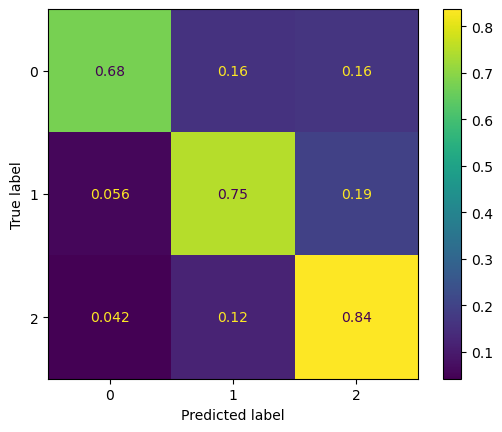

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.59472. Saving Model!
epoch 01, loss: 0.77340, acc: 0.64499, val_loss: 0.59472, val_accuracy: 0.77865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 02, loss: 0.76244, acc: 0.65188, val_loss: 0.62223, val_accuracy: 0.72458


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.33it/s]


epoch 03, loss: 0.76810, acc: 0.64890, val_loss: 0.61051, val_accuracy: 0.74353


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 04, loss: 0.75831, acc: 0.65235, val_loss: 0.62497, val_accuracy: 0.74283


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.25it/s]


epoch 05, loss: 0.75334, acc: 0.66132, val_loss: 0.62713, val_accuracy: 0.74234


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.12it/s]


epoch 06, loss: 0.75088, acc: 0.66184, val_loss: 0.63194, val_accuracy: 0.74273


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


epoch 07, loss: 0.74831, acc: 0.66045, val_loss: 0.63191, val_accuracy: 0.74214


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]


epoch 08, loss: 0.74707, acc: 0.65951, val_loss: 0.63799, val_accuracy: 0.74174


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 09, loss: 0.74468, acc: 0.66246, val_loss: 0.63904, val_accuracy: 0.74303


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]


epoch 10, loss: 0.74424, acc: 0.66245, val_loss: 0.64425, val_accuracy: 0.74204


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


epoch 11, loss: 0.74202, acc: 0.66261, val_loss: 0.64315, val_accuracy: 0.74204


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.48it/s]


epoch 12, loss: 0.74216, acc: 0.66207, val_loss: 0.64821, val_accuracy: 0.74313


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


epoch 13, loss: 0.73911, acc: 0.66398, val_loss: 0.64690, val_accuracy: 0.74313


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 14, loss: 0.73997, acc: 0.66361, val_loss: 0.65308, val_accuracy: 0.74184


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.25it/s]


epoch 15, loss: 0.73855, acc: 0.66545, val_loss: 0.65272, val_accuracy: 0.74382


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 16, loss: 0.73741, acc: 0.66666, val_loss: 0.65389, val_accuracy: 0.74214


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 17, loss: 0.73529, acc: 0.66681, val_loss: 0.65549, val_accuracy: 0.74283


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 18, loss: 0.73595, acc: 0.66356, val_loss: 0.66055, val_accuracy: 0.72527


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 19, loss: 0.73375, acc: 0.66774, val_loss: 0.65801, val_accuracy: 0.72348


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 20, loss: 0.73401, acc: 0.66882, val_loss: 0.66074, val_accuracy: 0.72527


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 21, loss: 0.73210, acc: 0.66962, val_loss: 0.66286, val_accuracy: 0.72507


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


epoch 22, loss: 0.73140, acc: 0.67251, val_loss: 0.66435, val_accuracy: 0.72487


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.34it/s]


epoch 23, loss: 0.73136, acc: 0.66868, val_loss: 0.66615, val_accuracy: 0.72606


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 24, loss: 0.73004, acc: 0.67138, val_loss: 0.66794, val_accuracy: 0.72587


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 25, loss: 0.72924, acc: 0.66947, val_loss: 0.66837, val_accuracy: 0.72477


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 26, loss: 0.72784, acc: 0.67258, val_loss: 0.67215, val_accuracy: 0.72587


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 27, loss: 0.72837, acc: 0.67016, val_loss: 0.67097, val_accuracy: 0.72468


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 28, loss: 0.72711, acc: 0.67007, val_loss: 0.67594, val_accuracy: 0.72696


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 29, loss: 0.72554, acc: 0.67306, val_loss: 0.67350, val_accuracy: 0.72577


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 30, loss: 0.72524, acc: 0.67259, val_loss: 0.67675, val_accuracy: 0.72279


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.06it/s]


epoch 31, loss: 0.72479, acc: 0.67367, val_loss: 0.67788, val_accuracy: 0.72180


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 32, loss: 0.72350, acc: 0.67400, val_loss: 0.67832, val_accuracy: 0.72339


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.21it/s]


epoch 33, loss: 0.72375, acc: 0.67422, val_loss: 0.68027, val_accuracy: 0.72200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.70it/s]


epoch 34, loss: 0.72254, acc: 0.67268, val_loss: 0.68137, val_accuracy: 0.72239


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 35, loss: 0.72182, acc: 0.67231, val_loss: 0.68331, val_accuracy: 0.72071


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 36, loss: 0.72050, acc: 0.67584, val_loss: 0.68673, val_accuracy: 0.72219


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 37, loss: 0.72084, acc: 0.67617, val_loss: 0.68571, val_accuracy: 0.72170


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 38, loss: 0.71951, acc: 0.67354, val_loss: 0.68900, val_accuracy: 0.72090


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 39, loss: 0.71872, acc: 0.67956, val_loss: 0.68777, val_accuracy: 0.72140


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 40, loss: 0.71819, acc: 0.67325, val_loss: 0.69199, val_accuracy: 0.72299


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 41, loss: 0.71732, acc: 0.67716, val_loss: 0.68768, val_accuracy: 0.72140


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 42, loss: 0.71667, acc: 0.67692, val_loss: 0.69826, val_accuracy: 0.72001


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 43, loss: 0.71586, acc: 0.67705, val_loss: 0.69093, val_accuracy: 0.72249


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.31it/s]


epoch 44, loss: 0.71528, acc: 0.67463, val_loss: 0.69931, val_accuracy: 0.72031


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.26it/s]


epoch 45, loss: 0.71384, acc: 0.67764, val_loss: 0.69360, val_accuracy: 0.72200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.26it/s]


epoch 46, loss: 0.71357, acc: 0.67563, val_loss: 0.70058, val_accuracy: 0.72140


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 47, loss: 0.71385, acc: 0.67735, val_loss: 0.69686, val_accuracy: 0.72100


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 48, loss: 0.71206, acc: 0.67615, val_loss: 0.70303, val_accuracy: 0.71763


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 49, loss: 0.71060, acc: 0.67898, val_loss: 0.69811, val_accuracy: 0.71971


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 50, loss: 0.71170, acc: 0.67823, val_loss: 0.70396, val_accuracy: 0.70245


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 51, loss: 0.70951, acc: 0.67928, val_loss: 0.70184, val_accuracy: 0.70374


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 52, loss: 0.70964, acc: 0.68209, val_loss: 0.70764, val_accuracy: 0.70434


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 53, loss: 0.70855, acc: 0.68197, val_loss: 0.70555, val_accuracy: 0.70404


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 54, loss: 0.70886, acc: 0.67854, val_loss: 0.70829, val_accuracy: 0.70414


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


epoch 55, loss: 0.70795, acc: 0.68161, val_loss: 0.70639, val_accuracy: 0.70275


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 56, loss: 0.70682, acc: 0.67903, val_loss: 0.71101, val_accuracy: 0.70195


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 57, loss: 0.70675, acc: 0.68384, val_loss: 0.71030, val_accuracy: 0.70066


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 58, loss: 0.70584, acc: 0.67908, val_loss: 0.71275, val_accuracy: 0.70414


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 59, loss: 0.70458, acc: 0.68387, val_loss: 0.71052, val_accuracy: 0.70096


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 60, loss: 0.70542, acc: 0.67876, val_loss: 0.71964, val_accuracy: 0.69937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 61, loss: 0.70313, acc: 0.68431, val_loss: 0.71044, val_accuracy: 0.70106


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 62, loss: 0.70410, acc: 0.67924, val_loss: 0.72177, val_accuracy: 0.70037


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 63, loss: 0.70147, acc: 0.68483, val_loss: 0.71104, val_accuracy: 0.70176


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 64, loss: 0.70276, acc: 0.68362, val_loss: 0.72308, val_accuracy: 0.69947


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 65, loss: 0.70058, acc: 0.68655, val_loss: 0.71464, val_accuracy: 0.69957


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 66, loss: 0.70081, acc: 0.68314, val_loss: 0.72762, val_accuracy: 0.69213


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 67, loss: 0.69927, acc: 0.68616, val_loss: 0.71558, val_accuracy: 0.69977


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 68, loss: 0.69965, acc: 0.68357, val_loss: 0.72921, val_accuracy: 0.70057


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 69, loss: 0.69844, acc: 0.68627, val_loss: 0.71669, val_accuracy: 0.70106


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 70, loss: 0.69917, acc: 0.68315, val_loss: 0.73121, val_accuracy: 0.70017


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


epoch 71, loss: 0.69735, acc: 0.68650, val_loss: 0.71883, val_accuracy: 0.70176


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 72, loss: 0.69716, acc: 0.68211, val_loss: 0.73380, val_accuracy: 0.69402


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 73, loss: 0.69654, acc: 0.68658, val_loss: 0.72198, val_accuracy: 0.70106


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 74, loss: 0.69589, acc: 0.68254, val_loss: 0.73236, val_accuracy: 0.70195


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 75, loss: 0.69490, acc: 0.68765, val_loss: 0.72333, val_accuracy: 0.70205


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 76, loss: 0.69437, acc: 0.68495, val_loss: 0.73602, val_accuracy: 0.69342


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 77, loss: 0.69352, acc: 0.68812, val_loss: 0.72533, val_accuracy: 0.70215


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 78, loss: 0.69288, acc: 0.68725, val_loss: 0.73672, val_accuracy: 0.69640


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 79, loss: 0.69235, acc: 0.68890, val_loss: 0.72986, val_accuracy: 0.70225


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 80, loss: 0.69189, acc: 0.68643, val_loss: 0.74014, val_accuracy: 0.67963


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


epoch 81, loss: 0.69188, acc: 0.68856, val_loss: 0.73096, val_accuracy: 0.70066


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 82, loss: 0.69005, acc: 0.68639, val_loss: 0.74122, val_accuracy: 0.68231


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 83, loss: 0.68942, acc: 0.68975, val_loss: 0.73201, val_accuracy: 0.68658


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 84, loss: 0.68956, acc: 0.68920, val_loss: 0.74260, val_accuracy: 0.68181


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 85, loss: 0.68810, acc: 0.69237, val_loss: 0.73358, val_accuracy: 0.68638


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 86, loss: 0.68820, acc: 0.68904, val_loss: 0.74724, val_accuracy: 0.68052


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 87, loss: 0.68695, acc: 0.69132, val_loss: 0.73571, val_accuracy: 0.68876


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 88, loss: 0.68647, acc: 0.69069, val_loss: 0.74452, val_accuracy: 0.68191


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 89, loss: 0.68675, acc: 0.69061, val_loss: 0.74072, val_accuracy: 0.69045


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 90, loss: 0.68522, acc: 0.68799, val_loss: 0.74713, val_accuracy: 0.68003


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 91, loss: 0.68470, acc: 0.69352, val_loss: 0.74152, val_accuracy: 0.68985


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 92, loss: 0.68497, acc: 0.69153, val_loss: 0.75113, val_accuracy: 0.68291


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 93, loss: 0.68346, acc: 0.69587, val_loss: 0.74137, val_accuracy: 0.68350


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 94, loss: 0.68396, acc: 0.68939, val_loss: 0.75248, val_accuracy: 0.68300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


epoch 95, loss: 0.68330, acc: 0.69191, val_loss: 0.74539, val_accuracy: 0.68291


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 96, loss: 0.68216, acc: 0.68925, val_loss: 0.75240, val_accuracy: 0.66693


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.50it/s]


epoch 97, loss: 0.68098, acc: 0.69374, val_loss: 0.74730, val_accuracy: 0.69035


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


epoch 98, loss: 0.68118, acc: 0.69074, val_loss: 0.75602, val_accuracy: 0.68310


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 99, loss: 0.68006, acc: 0.69649, val_loss: 0.74998, val_accuracy: 0.68350


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.85it/s]


epoch 100, loss: 0.67932, acc: 0.69616, val_loss: 0.75663, val_accuracy: 0.66683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 101, loss: 0.67843, acc: 0.69816, val_loss: 0.75344, val_accuracy: 0.68370


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


epoch 102, loss: 0.67798, acc: 0.69697, val_loss: 0.75743, val_accuracy: 0.66772


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 103, loss: 0.67759, acc: 0.69717, val_loss: 0.75614, val_accuracy: 0.68539


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]


epoch 104, loss: 0.67649, acc: 0.69722, val_loss: 0.75815, val_accuracy: 0.66574


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]


epoch 105, loss: 0.67743, acc: 0.69709, val_loss: 0.75826, val_accuracy: 0.66683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 106, loss: 0.67473, acc: 0.69674, val_loss: 0.75718, val_accuracy: 0.65889


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 107, loss: 0.67713, acc: 0.69718, val_loss: 0.76638, val_accuracy: 0.66653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]


epoch 108, loss: 0.67408, acc: 0.69857, val_loss: 0.75770, val_accuracy: 0.65939


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 109, loss: 0.67578, acc: 0.69798, val_loss: 0.76470, val_accuracy: 0.66832


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


epoch 110, loss: 0.67482, acc: 0.69578, val_loss: 0.76257, val_accuracy: 0.65969


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.79it/s]


epoch 111, loss: 0.67330, acc: 0.69976, val_loss: 0.76248, val_accuracy: 0.66187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 112, loss: 0.67509, acc: 0.69352, val_loss: 0.77173, val_accuracy: 0.66058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 113, loss: 0.67298, acc: 0.69992, val_loss: 0.76285, val_accuracy: 0.66118


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 114, loss: 0.67341, acc: 0.69470, val_loss: 0.77295, val_accuracy: 0.65949


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 115, loss: 0.67075, acc: 0.69891, val_loss: 0.76653, val_accuracy: 0.66266


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 116, loss: 0.67146, acc: 0.69752, val_loss: 0.77292, val_accuracy: 0.65939


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 117, loss: 0.66971, acc: 0.70036, val_loss: 0.76821, val_accuracy: 0.66058


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 118, loss: 0.67031, acc: 0.70006, val_loss: 0.77345, val_accuracy: 0.66098


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 119, loss: 0.66838, acc: 0.70070, val_loss: 0.76983, val_accuracy: 0.66296


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 120, loss: 0.66819, acc: 0.70123, val_loss: 0.77768, val_accuracy: 0.66068


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 121, loss: 0.66741, acc: 0.70226, val_loss: 0.77212, val_accuracy: 0.66247


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


epoch 122, loss: 0.66696, acc: 0.70235, val_loss: 0.77384, val_accuracy: 0.66376


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 123, loss: 0.66646, acc: 0.70242, val_loss: 0.77477, val_accuracy: 0.66296


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 124, loss: 0.66634, acc: 0.70006, val_loss: 0.77431, val_accuracy: 0.65919


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.52it/s]


epoch 125, loss: 0.66630, acc: 0.70052, val_loss: 0.77854, val_accuracy: 0.66425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 126, loss: 0.66492, acc: 0.70108, val_loss: 0.77375, val_accuracy: 0.66257


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


epoch 127, loss: 0.66516, acc: 0.70321, val_loss: 0.77664, val_accuracy: 0.66425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 128, loss: 0.66389, acc: 0.70197, val_loss: 0.78093, val_accuracy: 0.66336


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.59it/s]


epoch 129, loss: 0.66329, acc: 0.70306, val_loss: 0.77689, val_accuracy: 0.66395


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]


epoch 130, loss: 0.66363, acc: 0.70202, val_loss: 0.78173, val_accuracy: 0.66554


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.24it/s]


epoch 131, loss: 0.66175, acc: 0.70554, val_loss: 0.77904, val_accuracy: 0.66425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


epoch 132, loss: 0.66276, acc: 0.70036, val_loss: 0.78427, val_accuracy: 0.66475


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 133, loss: 0.66223, acc: 0.70662, val_loss: 0.78277, val_accuracy: 0.66346


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 134, loss: 0.66085, acc: 0.70520, val_loss: 0.78602, val_accuracy: 0.66634


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 135, loss: 0.66007, acc: 0.70790, val_loss: 0.78365, val_accuracy: 0.66425


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.23it/s]


epoch 136, loss: 0.66065, acc: 0.70568, val_loss: 0.78524, val_accuracy: 0.66683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 137, loss: 0.65816, acc: 0.70964, val_loss: 0.78560, val_accuracy: 0.66415


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.26it/s]


epoch 138, loss: 0.65898, acc: 0.70661, val_loss: 0.78779, val_accuracy: 0.66753


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 139, loss: 0.65713, acc: 0.70954, val_loss: 0.78783, val_accuracy: 0.66574


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 140, loss: 0.65814, acc: 0.70685, val_loss: 0.78509, val_accuracy: 0.66763


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


epoch 141, loss: 0.65667, acc: 0.70985, val_loss: 0.79075, val_accuracy: 0.66614


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


epoch 142, loss: 0.65639, acc: 0.70676, val_loss: 0.78980, val_accuracy: 0.66713


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.92it/s]


epoch 143, loss: 0.65551, acc: 0.70688, val_loss: 0.79041, val_accuracy: 0.66405


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]


epoch 144, loss: 0.65663, acc: 0.70584, val_loss: 0.79473, val_accuracy: 0.66604


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 145, loss: 0.65445, acc: 0.71113, val_loss: 0.79300, val_accuracy: 0.66475


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 146, loss: 0.65527, acc: 0.70707, val_loss: 0.79865, val_accuracy: 0.66743


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 147, loss: 0.65486, acc: 0.71159, val_loss: 0.79555, val_accuracy: 0.66445


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 148, loss: 0.65394, acc: 0.70791, val_loss: 0.79807, val_accuracy: 0.66892


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 149, loss: 0.65303, acc: 0.71153, val_loss: 0.79434, val_accuracy: 0.66663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 150, loss: 0.65369, acc: 0.70802, val_loss: 0.80109, val_accuracy: 0.66743


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 151, loss: 0.65137, acc: 0.70838, val_loss: 0.79718, val_accuracy: 0.66653


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 152, loss: 0.65286, acc: 0.70644, val_loss: 0.80085, val_accuracy: 0.66951


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 153, loss: 0.65010, acc: 0.71263, val_loss: 0.80078, val_accuracy: 0.66594


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 154, loss: 0.65100, acc: 0.70913, val_loss: 0.80242, val_accuracy: 0.66882


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


epoch 155, loss: 0.64825, acc: 0.71413, val_loss: 0.80081, val_accuracy: 0.66703


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.24it/s]


epoch 156, loss: 0.64951, acc: 0.71043, val_loss: 0.80678, val_accuracy: 0.66981


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.30it/s]


epoch 157, loss: 0.64690, acc: 0.71149, val_loss: 0.80101, val_accuracy: 0.66961


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.88it/s]


epoch 158, loss: 0.64872, acc: 0.71148, val_loss: 0.80900, val_accuracy: 0.66842


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.80it/s]


epoch 159, loss: 0.64547, acc: 0.71381, val_loss: 0.80654, val_accuracy: 0.66822


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


epoch 160, loss: 0.64701, acc: 0.71328, val_loss: 0.80548, val_accuracy: 0.66882


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 161, loss: 0.64653, acc: 0.71274, val_loss: 0.80269, val_accuracy: 0.66882


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.80it/s]


epoch 162, loss: 0.64400, acc: 0.71397, val_loss: 0.80642, val_accuracy: 0.66981


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 163, loss: 0.64597, acc: 0.71271, val_loss: 0.80702, val_accuracy: 0.66852


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]


epoch 164, loss: 0.64313, acc: 0.71485, val_loss: 0.80709, val_accuracy: 0.66971


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.49it/s]


epoch 165, loss: 0.64442, acc: 0.71458, val_loss: 0.80947, val_accuracy: 0.66842


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.01it/s]


epoch 166, loss: 0.64277, acc: 0.71465, val_loss: 0.80615, val_accuracy: 0.66971


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 167, loss: 0.64256, acc: 0.71537, val_loss: 0.81487, val_accuracy: 0.66872


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 168, loss: 0.64244, acc: 0.71544, val_loss: 0.80991, val_accuracy: 0.66941


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 169, loss: 0.64133, acc: 0.71588, val_loss: 0.81376, val_accuracy: 0.66921


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 170, loss: 0.64241, acc: 0.71259, val_loss: 0.81993, val_accuracy: 0.67001


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.45it/s]


epoch 171, loss: 0.64122, acc: 0.71674, val_loss: 0.81329, val_accuracy: 0.67021


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 172, loss: 0.64149, acc: 0.71118, val_loss: 0.81409, val_accuracy: 0.66941


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 173, loss: 0.63893, acc: 0.71598, val_loss: 0.81471, val_accuracy: 0.66931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


epoch 174, loss: 0.63934, acc: 0.71353, val_loss: 0.81618, val_accuracy: 0.67080


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 175, loss: 0.63828, acc: 0.71655, val_loss: 0.81875, val_accuracy: 0.66931


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 176, loss: 0.63920, acc: 0.71446, val_loss: 0.81483, val_accuracy: 0.67169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.23it/s]


epoch 177, loss: 0.63758, acc: 0.71786, val_loss: 0.81697, val_accuracy: 0.66921


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]


epoch 178, loss: 0.63676, acc: 0.71687, val_loss: 0.81781, val_accuracy: 0.67130


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.45it/s]


epoch 179, loss: 0.63628, acc: 0.71866, val_loss: 0.81846, val_accuracy: 0.66921


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 180, loss: 0.63587, acc: 0.71815, val_loss: 0.81919, val_accuracy: 0.67169


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 181, loss: 0.63522, acc: 0.71726, val_loss: 0.82079, val_accuracy: 0.66971


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 182, loss: 0.63571, acc: 0.71598, val_loss: 0.81654, val_accuracy: 0.67120


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 183, loss: 0.63279, acc: 0.71979, val_loss: 0.82319, val_accuracy: 0.67011


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 184, loss: 0.63472, acc: 0.71555, val_loss: 0.81783, val_accuracy: 0.67159


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 185, loss: 0.63163, acc: 0.72228, val_loss: 0.82613, val_accuracy: 0.67070


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 186, loss: 0.63484, acc: 0.71659, val_loss: 0.82418, val_accuracy: 0.67050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


epoch 187, loss: 0.63090, acc: 0.71910, val_loss: 0.82453, val_accuracy: 0.67278


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.19it/s]


epoch 188, loss: 0.63240, acc: 0.71777, val_loss: 0.82142, val_accuracy: 0.67120


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.48it/s]


epoch 189, loss: 0.63010, acc: 0.71867, val_loss: 0.83034, val_accuracy: 0.67070


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.26it/s]


epoch 190, loss: 0.63176, acc: 0.71798, val_loss: 0.82416, val_accuracy: 0.67001


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 191, loss: 0.62950, acc: 0.72127, val_loss: 0.82820, val_accuracy: 0.67090


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 192, loss: 0.62992, acc: 0.71913, val_loss: 0.82733, val_accuracy: 0.66991


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


epoch 193, loss: 0.62902, acc: 0.71722, val_loss: 0.82595, val_accuracy: 0.67060


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 194, loss: 0.62952, acc: 0.72218, val_loss: 0.83429, val_accuracy: 0.67219


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 195, loss: 0.62993, acc: 0.71904, val_loss: 0.82688, val_accuracy: 0.67189


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 196, loss: 0.62805, acc: 0.71953, val_loss: 0.83221, val_accuracy: 0.67269


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 197, loss: 0.62847, acc: 0.71747, val_loss: 0.83103, val_accuracy: 0.66971


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 198, loss: 0.62605, acc: 0.72140, val_loss: 0.83126, val_accuracy: 0.67120


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 199, loss: 0.63001, acc: 0.71891, val_loss: 0.83524, val_accuracy: 0.67060


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 200, loss: 0.62493, acc: 0.72456, val_loss: 0.83043, val_accuracy: 0.67259


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


epoch 201, loss: 0.62753, acc: 0.71911, val_loss: 0.83207, val_accuracy: 0.66981


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 202, loss: 0.62396, acc: 0.72176, val_loss: 0.83393, val_accuracy: 0.67140


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


epoch 203, loss: 0.62456, acc: 0.72047, val_loss: 0.83461, val_accuracy: 0.67130


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 204, loss: 0.62374, acc: 0.72107, val_loss: 0.83775, val_accuracy: 0.67179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]


epoch 205, loss: 0.62411, acc: 0.72050, val_loss: 0.83683, val_accuracy: 0.67060


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


epoch 206, loss: 0.62208, acc: 0.72020, val_loss: 0.83361, val_accuracy: 0.67269


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]


epoch 207, loss: 0.62167, acc: 0.72273, val_loss: 0.84518, val_accuracy: 0.67100


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.69it/s]


epoch 208, loss: 0.62164, acc: 0.72068, val_loss: 0.83354, val_accuracy: 0.67179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.33it/s]


epoch 209, loss: 0.62033, acc: 0.72214, val_loss: 0.84118, val_accuracy: 0.67110


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 210, loss: 0.62123, acc: 0.72213, val_loss: 0.84060, val_accuracy: 0.67100


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.19it/s]


epoch 211, loss: 0.61910, acc: 0.72603, val_loss: 0.84314, val_accuracy: 0.67239


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.54it/s]


epoch 212, loss: 0.61987, acc: 0.72263, val_loss: 0.83798, val_accuracy: 0.67269


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.85it/s]


epoch 213, loss: 0.61825, acc: 0.72473, val_loss: 0.84830, val_accuracy: 0.67239


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


epoch 214, loss: 0.61888, acc: 0.72298, val_loss: 0.84035, val_accuracy: 0.67269


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 215, loss: 0.61732, acc: 0.72572, val_loss: 0.84611, val_accuracy: 0.67368


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 216, loss: 0.61807, acc: 0.72472, val_loss: 0.84542, val_accuracy: 0.67219


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


epoch 217, loss: 0.61647, acc: 0.72535, val_loss: 0.85085, val_accuracy: 0.67308


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.35it/s]


epoch 218, loss: 0.61776, acc: 0.72292, val_loss: 0.84669, val_accuracy: 0.67249


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]


epoch 219, loss: 0.61509, acc: 0.72521, val_loss: 0.84741, val_accuracy: 0.67308


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.85it/s]


epoch 220, loss: 0.61594, acc: 0.72474, val_loss: 0.85048, val_accuracy: 0.67417


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.96it/s]


epoch 221, loss: 0.61480, acc: 0.72659, val_loss: 0.84528, val_accuracy: 0.67447


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.89it/s]


epoch 222, loss: 0.61538, acc: 0.72398, val_loss: 0.85188, val_accuracy: 0.67308


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.53it/s]


epoch 223, loss: 0.61192, acc: 0.72984, val_loss: 0.84115, val_accuracy: 0.67487


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.75it/s]


epoch 224, loss: 0.61537, acc: 0.72538, val_loss: 0.85646, val_accuracy: 0.67338


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 225, loss: 0.61140, acc: 0.72995, val_loss: 0.85008, val_accuracy: 0.67477


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 226, loss: 0.61302, acc: 0.72938, val_loss: 0.85360, val_accuracy: 0.67229


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 227, loss: 0.61142, acc: 0.72884, val_loss: 0.85072, val_accuracy: 0.67447


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 228, loss: 0.61221, acc: 0.72860, val_loss: 0.84985, val_accuracy: 0.67239


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 229, loss: 0.61098, acc: 0.72753, val_loss: 0.85195, val_accuracy: 0.67437


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


epoch 230, loss: 0.60954, acc: 0.73062, val_loss: 0.85399, val_accuracy: 0.67249


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 231, loss: 0.61119, acc: 0.72800, val_loss: 0.85748, val_accuracy: 0.67497


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 232, loss: 0.60805, acc: 0.73374, val_loss: 0.85087, val_accuracy: 0.67427


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 233, loss: 0.61027, acc: 0.72721, val_loss: 0.85893, val_accuracy: 0.67447


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 234, loss: 0.60692, acc: 0.73053, val_loss: 0.85023, val_accuracy: 0.67437


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 235, loss: 0.60896, acc: 0.72889, val_loss: 0.86281, val_accuracy: 0.67348


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.28it/s]


epoch 236, loss: 0.60641, acc: 0.72987, val_loss: 0.85830, val_accuracy: 0.67536


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.28it/s]


epoch 237, loss: 0.60780, acc: 0.72989, val_loss: 0.86167, val_accuracy: 0.67447


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.11it/s]


epoch 238, loss: 0.60600, acc: 0.72950, val_loss: 0.85727, val_accuracy: 0.67586


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]


epoch 239, loss: 0.60561, acc: 0.73086, val_loss: 0.86284, val_accuracy: 0.67646


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.05it/s]


epoch 240, loss: 0.60601, acc: 0.73025, val_loss: 0.86129, val_accuracy: 0.67675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 241, loss: 0.60529, acc: 0.73281, val_loss: 0.85977, val_accuracy: 0.67626


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 242, loss: 0.60463, acc: 0.73267, val_loss: 0.86348, val_accuracy: 0.67874


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 243, loss: 0.60355, acc: 0.73264, val_loss: 0.86037, val_accuracy: 0.67834


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 244, loss: 0.60437, acc: 0.73019, val_loss: 0.86887, val_accuracy: 0.68003


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 245, loss: 0.60447, acc: 0.72993, val_loss: 0.86014, val_accuracy: 0.67636


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 246, loss: 0.60253, acc: 0.73510, val_loss: 0.86652, val_accuracy: 0.68023


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 247, loss: 0.60373, acc: 0.73124, val_loss: 0.85935, val_accuracy: 0.67775


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]


epoch 248, loss: 0.60077, acc: 0.73560, val_loss: 0.87258, val_accuracy: 0.67913


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


epoch 249, loss: 0.60217, acc: 0.73111, val_loss: 0.86229, val_accuracy: 0.67665


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 250, loss: 0.60029, acc: 0.73798, val_loss: 0.86958, val_accuracy: 0.68082


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


epoch 251, loss: 0.60008, acc: 0.73286, val_loss: 0.86685, val_accuracy: 0.67725


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


epoch 252, loss: 0.60004, acc: 0.73624, val_loss: 0.86870, val_accuracy: 0.67834


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 253, loss: 0.59908, acc: 0.73489, val_loss: 0.86881, val_accuracy: 0.67785


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 254, loss: 0.59768, acc: 0.73732, val_loss: 0.86496, val_accuracy: 0.68023


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 255, loss: 0.59873, acc: 0.73365, val_loss: 0.87197, val_accuracy: 0.67894


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 256, loss: 0.59690, acc: 0.73497, val_loss: 0.86286, val_accuracy: 0.68072


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 257, loss: 0.59734, acc: 0.73668, val_loss: 0.87560, val_accuracy: 0.67864


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 258, loss: 0.59645, acc: 0.73448, val_loss: 0.86532, val_accuracy: 0.68052


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 259, loss: 0.59640, acc: 0.73719, val_loss: 0.87816, val_accuracy: 0.68023


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 260, loss: 0.59598, acc: 0.73661, val_loss: 0.86676, val_accuracy: 0.68013


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]


epoch 261, loss: 0.59479, acc: 0.73661, val_loss: 0.88057, val_accuracy: 0.68132


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 262, loss: 0.59566, acc: 0.73683, val_loss: 0.87272, val_accuracy: 0.68082


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


epoch 263, loss: 0.59337, acc: 0.74022, val_loss: 0.87348, val_accuracy: 0.67983


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 264, loss: 0.59429, acc: 0.73673, val_loss: 0.87474, val_accuracy: 0.68231


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


epoch 265, loss: 0.59277, acc: 0.73910, val_loss: 0.87630, val_accuracy: 0.67983


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 266, loss: 0.59338, acc: 0.73802, val_loss: 0.87789, val_accuracy: 0.68330


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


epoch 267, loss: 0.59393, acc: 0.73893, val_loss: 0.86839, val_accuracy: 0.68023


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]


epoch 268, loss: 0.59076, acc: 0.73917, val_loss: 0.88132, val_accuracy: 0.68360


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 269, loss: 0.59297, acc: 0.73780, val_loss: 0.87870, val_accuracy: 0.68072


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.74it/s]


epoch 270, loss: 0.59117, acc: 0.73943, val_loss: 0.88018, val_accuracy: 0.68390


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 271, loss: 0.59118, acc: 0.73965, val_loss: 0.87361, val_accuracy: 0.66286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 272, loss: 0.59104, acc: 0.73840, val_loss: 0.88316, val_accuracy: 0.68489


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 273, loss: 0.59140, acc: 0.73947, val_loss: 0.87625, val_accuracy: 0.67923


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.70it/s]


epoch 274, loss: 0.58875, acc: 0.74133, val_loss: 0.88205, val_accuracy: 0.68519


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.30it/s]


epoch 275, loss: 0.58946, acc: 0.74047, val_loss: 0.87864, val_accuracy: 0.68171


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.56it/s]


epoch 276, loss: 0.58764, acc: 0.74158, val_loss: 0.88876, val_accuracy: 0.68558


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 277, loss: 0.58996, acc: 0.73798, val_loss: 0.88516, val_accuracy: 0.68122


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


epoch 278, loss: 0.58536, acc: 0.74014, val_loss: 0.87958, val_accuracy: 0.66753


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]


epoch 279, loss: 0.58882, acc: 0.74088, val_loss: 0.88410, val_accuracy: 0.68201


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.98it/s]


epoch 280, loss: 0.58676, acc: 0.74102, val_loss: 0.88053, val_accuracy: 0.66812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]


epoch 281, loss: 0.58660, acc: 0.74254, val_loss: 0.88801, val_accuracy: 0.68171


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]


epoch 282, loss: 0.58576, acc: 0.74290, val_loss: 0.88112, val_accuracy: 0.68568


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


epoch 283, loss: 0.58488, acc: 0.74476, val_loss: 0.89106, val_accuracy: 0.68122


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


epoch 284, loss: 0.58581, acc: 0.74128, val_loss: 0.87695, val_accuracy: 0.68499


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]


epoch 285, loss: 0.58379, acc: 0.74431, val_loss: 0.89246, val_accuracy: 0.68122


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 286, loss: 0.58556, acc: 0.74294, val_loss: 0.88136, val_accuracy: 0.68558


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.95it/s]


epoch 287, loss: 0.58320, acc: 0.74258, val_loss: 0.89491, val_accuracy: 0.68221


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 288, loss: 0.58228, acc: 0.74274, val_loss: 0.88115, val_accuracy: 0.68648


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 289, loss: 0.58162, acc: 0.74503, val_loss: 0.89938, val_accuracy: 0.66663


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 290, loss: 0.58243, acc: 0.74125, val_loss: 0.88594, val_accuracy: 0.68548


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.21it/s]


epoch 291, loss: 0.58034, acc: 0.74376, val_loss: 0.89623, val_accuracy: 0.68469


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 292, loss: 0.58029, acc: 0.74346, val_loss: 0.88455, val_accuracy: 0.66723


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.06it/s]


epoch 293, loss: 0.57994, acc: 0.74311, val_loss: 0.89691, val_accuracy: 0.68410


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 294, loss: 0.57935, acc: 0.74424, val_loss: 0.88858, val_accuracy: 0.66991


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


epoch 295, loss: 0.57964, acc: 0.74435, val_loss: 0.89412, val_accuracy: 0.68231


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 296, loss: 0.57837, acc: 0.74587, val_loss: 0.89144, val_accuracy: 0.66941


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


epoch 297, loss: 0.57817, acc: 0.74529, val_loss: 0.89964, val_accuracy: 0.68439


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


epoch 298, loss: 0.57917, acc: 0.74560, val_loss: 0.88503, val_accuracy: 0.67030


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 299, loss: 0.57772, acc: 0.74583, val_loss: 0.90433, val_accuracy: 0.68350


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.92it/s]


epoch 300, loss: 0.57787, acc: 0.74573, val_loss: 0.88570, val_accuracy: 0.68787


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.08it/s]


epoch 301, loss: 0.57607, acc: 0.74516, val_loss: 0.90278, val_accuracy: 0.68459


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


epoch 302, loss: 0.57674, acc: 0.74631, val_loss: 0.88843, val_accuracy: 0.68806


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 303, loss: 0.57506, acc: 0.74368, val_loss: 0.89991, val_accuracy: 0.68429


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 304, loss: 0.57483, acc: 0.74553, val_loss: 0.89480, val_accuracy: 0.67001


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 305, loss: 0.57478, acc: 0.74693, val_loss: 0.90440, val_accuracy: 0.68499


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 306, loss: 0.57390, acc: 0.74869, val_loss: 0.89580, val_accuracy: 0.67159


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.39it/s]


epoch 307, loss: 0.57438, acc: 0.74662, val_loss: 0.90666, val_accuracy: 0.68340


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.29it/s]


epoch 308, loss: 0.57287, acc: 0.74780, val_loss: 0.89641, val_accuracy: 0.67060


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.17it/s]


epoch 309, loss: 0.57309, acc: 0.74712, val_loss: 0.90221, val_accuracy: 0.68489


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.01it/s]


epoch 310, loss: 0.57272, acc: 0.74592, val_loss: 0.90261, val_accuracy: 0.67189


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]


epoch 311, loss: 0.57267, acc: 0.74628, val_loss: 0.90331, val_accuracy: 0.68479


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


epoch 312, loss: 0.57269, acc: 0.74831, val_loss: 0.90356, val_accuracy: 0.67080


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


epoch 313, loss: 0.57012, acc: 0.74728, val_loss: 0.90817, val_accuracy: 0.68400


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 314, loss: 0.57330, acc: 0.74904, val_loss: 0.90343, val_accuracy: 0.67179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.39it/s]


epoch 315, loss: 0.57127, acc: 0.74648, val_loss: 0.90768, val_accuracy: 0.68568


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.89it/s]


epoch 316, loss: 0.56967, acc: 0.74803, val_loss: 0.90560, val_accuracy: 0.67110


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.43it/s]


epoch 317, loss: 0.56929, acc: 0.74853, val_loss: 0.91069, val_accuracy: 0.66832


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 318, loss: 0.56904, acc: 0.74887, val_loss: 0.90363, val_accuracy: 0.68687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 319, loss: 0.56820, acc: 0.74880, val_loss: 0.91011, val_accuracy: 0.66941


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


epoch 320, loss: 0.56726, acc: 0.75110, val_loss: 0.90838, val_accuracy: 0.68628


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


epoch 321, loss: 0.56709, acc: 0.75120, val_loss: 0.91634, val_accuracy: 0.67070


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 322, loss: 0.56663, acc: 0.74970, val_loss: 0.91000, val_accuracy: 0.66822


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 323, loss: 0.56675, acc: 0.75232, val_loss: 0.90957, val_accuracy: 0.68816


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


epoch 324, loss: 0.56511, acc: 0.74900, val_loss: 0.91888, val_accuracy: 0.66901


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 325, loss: 0.56640, acc: 0.74961, val_loss: 0.91548, val_accuracy: 0.68806


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 326, loss: 0.56487, acc: 0.74929, val_loss: 0.91516, val_accuracy: 0.67001


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 327, loss: 0.56510, acc: 0.75231, val_loss: 0.92122, val_accuracy: 0.67030


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 328, loss: 0.56459, acc: 0.74993, val_loss: 0.91767, val_accuracy: 0.66991


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 329, loss: 0.56277, acc: 0.75213, val_loss: 0.91527, val_accuracy: 0.67179


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


epoch 330, loss: 0.56484, acc: 0.74864, val_loss: 0.92009, val_accuracy: 0.67030


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


epoch 331, loss: 0.56135, acc: 0.75390, val_loss: 0.91766, val_accuracy: 0.67130


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


epoch 332, loss: 0.56315, acc: 0.74996, val_loss: 0.91414, val_accuracy: 0.68886


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 333, loss: 0.56078, acc: 0.75428, val_loss: 0.92578, val_accuracy: 0.67239


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 334, loss: 0.56040, acc: 0.75437, val_loss: 0.91947, val_accuracy: 0.67100


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 335, loss: 0.56168, acc: 0.75382, val_loss: 0.92598, val_accuracy: 0.67050


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 336, loss: 0.55945, acc: 0.75537, val_loss: 0.91846, val_accuracy: 0.67130


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.64it/s]


epoch 337, loss: 0.56029, acc: 0.75383, val_loss: 0.92953, val_accuracy: 0.67269


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


epoch 338, loss: 0.55888, acc: 0.75385, val_loss: 0.91993, val_accuracy: 0.67278


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.19it/s]


epoch 339, loss: 0.55921, acc: 0.75197, val_loss: 0.93155, val_accuracy: 0.67318


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 340, loss: 0.55869, acc: 0.75343, val_loss: 0.91814, val_accuracy: 0.67219


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 341, loss: 0.55747, acc: 0.75434, val_loss: 0.93471, val_accuracy: 0.67030


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 342, loss: 0.55901, acc: 0.75468, val_loss: 0.92171, val_accuracy: 0.67249


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


epoch 343, loss: 0.55703, acc: 0.75470, val_loss: 0.93485, val_accuracy: 0.67328


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 344, loss: 0.55727, acc: 0.75285, val_loss: 0.92599, val_accuracy: 0.67527


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.03it/s]


epoch 345, loss: 0.55836, acc: 0.75110, val_loss: 0.92855, val_accuracy: 0.67011


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


epoch 346, loss: 0.55511, acc: 0.75406, val_loss: 0.92275, val_accuracy: 0.67517


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


epoch 347, loss: 0.55672, acc: 0.75609, val_loss: 0.92848, val_accuracy: 0.67001


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 348, loss: 0.55581, acc: 0.75258, val_loss: 0.92689, val_accuracy: 0.67586


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 349, loss: 0.55514, acc: 0.75536, val_loss: 0.92848, val_accuracy: 0.67159


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]


epoch 350, loss: 0.55339, acc: 0.75682, val_loss: 0.92399, val_accuracy: 0.67527


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


epoch 351, loss: 0.55451, acc: 0.75589, val_loss: 0.94225, val_accuracy: 0.65483


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 352, loss: 0.55375, acc: 0.75573, val_loss: 0.92339, val_accuracy: 0.65820


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 353, loss: 0.55299, acc: 0.75424, val_loss: 0.94235, val_accuracy: 0.65423


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.97it/s]


epoch 354, loss: 0.55395, acc: 0.75645, val_loss: 0.92045, val_accuracy: 0.67546


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


epoch 355, loss: 0.55204, acc: 0.75395, val_loss: 0.94068, val_accuracy: 0.65393


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]


epoch 356, loss: 0.55277, acc: 0.75479, val_loss: 0.93668, val_accuracy: 0.67715


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 357, loss: 0.55092, acc: 0.75619, val_loss: 0.94216, val_accuracy: 0.65413


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


epoch 358, loss: 0.55134, acc: 0.75725, val_loss: 0.92449, val_accuracy: 0.67675


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


epoch 359, loss: 0.55113, acc: 0.75670, val_loss: 0.93917, val_accuracy: 0.65602


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.51it/s]


epoch 360, loss: 0.54937, acc: 0.75827, val_loss: 0.93597, val_accuracy: 0.65949


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 361, loss: 0.55027, acc: 0.75795, val_loss: 0.94493, val_accuracy: 0.65731


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 362, loss: 0.54894, acc: 0.75880, val_loss: 0.93308, val_accuracy: 0.65929


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 363, loss: 0.54923, acc: 0.75946, val_loss: 0.94948, val_accuracy: 0.65671


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


epoch 364, loss: 0.54876, acc: 0.75737, val_loss: 0.94210, val_accuracy: 0.65860


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.34it/s]


epoch 365, loss: 0.54876, acc: 0.75906, val_loss: 0.94636, val_accuracy: 0.65661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]


epoch 366, loss: 0.54586, acc: 0.75872, val_loss: 0.94255, val_accuracy: 0.65830


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.09it/s]


epoch 367, loss: 0.54757, acc: 0.75838, val_loss: 0.95011, val_accuracy: 0.65711


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]


epoch 368, loss: 0.54725, acc: 0.75691, val_loss: 0.93921, val_accuracy: 0.66604


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]


epoch 369, loss: 0.54539, acc: 0.76052, val_loss: 0.95173, val_accuracy: 0.65641


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.83it/s]


epoch 370, loss: 0.54587, acc: 0.75780, val_loss: 0.94738, val_accuracy: 0.65939


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.61it/s]


epoch 371, loss: 0.54656, acc: 0.75890, val_loss: 0.94601, val_accuracy: 0.65622


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 372, loss: 0.54408, acc: 0.76024, val_loss: 0.95489, val_accuracy: 0.65016


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 373, loss: 0.54517, acc: 0.76311, val_loss: 0.94919, val_accuracy: 0.65850


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


epoch 374, loss: 0.54458, acc: 0.75660, val_loss: 0.95679, val_accuracy: 0.65830


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


epoch 375, loss: 0.54487, acc: 0.76041, val_loss: 0.94419, val_accuracy: 0.66386


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.84it/s]


epoch 376, loss: 0.54245, acc: 0.75822, val_loss: 0.95241, val_accuracy: 0.66435


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


epoch 377, loss: 0.54350, acc: 0.76030, val_loss: 0.95226, val_accuracy: 0.66584


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]


epoch 378, loss: 0.54457, acc: 0.75583, val_loss: 0.95537, val_accuracy: 0.65790


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.08it/s]


epoch 379, loss: 0.54218, acc: 0.76208, val_loss: 0.95134, val_accuracy: 0.66683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


epoch 380, loss: 0.54444, acc: 0.75907, val_loss: 0.95481, val_accuracy: 0.65651


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


epoch 381, loss: 0.54330, acc: 0.75742, val_loss: 0.96010, val_accuracy: 0.66763


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


epoch 382, loss: 0.54538, acc: 0.75702, val_loss: 0.95800, val_accuracy: 0.65780


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.61it/s]


epoch 383, loss: 0.54298, acc: 0.76244, val_loss: 0.96231, val_accuracy: 0.65334


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.61it/s]


epoch 384, loss: 0.54280, acc: 0.75718, val_loss: 0.96283, val_accuracy: 0.65741


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 385, loss: 0.54092, acc: 0.76198, val_loss: 0.96450, val_accuracy: 0.66247


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


epoch 386, loss: 0.54030, acc: 0.75981, val_loss: 0.96300, val_accuracy: 0.65880


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]


epoch 387, loss: 0.53936, acc: 0.76400, val_loss: 0.95518, val_accuracy: 0.66782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.06it/s]


epoch 388, loss: 0.53872, acc: 0.76426, val_loss: 0.96820, val_accuracy: 0.65939


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.85it/s]


epoch 389, loss: 0.53905, acc: 0.76165, val_loss: 0.95938, val_accuracy: 0.65126


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]


epoch 390, loss: 0.53726, acc: 0.76474, val_loss: 0.96700, val_accuracy: 0.65830


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]


epoch 391, loss: 0.53722, acc: 0.76242, val_loss: 0.95653, val_accuracy: 0.65413


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.87it/s]


epoch 392, loss: 0.53688, acc: 0.76435, val_loss: 0.97012, val_accuracy: 0.64371


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.73it/s]


epoch 393, loss: 0.53641, acc: 0.76302, val_loss: 0.95492, val_accuracy: 0.66683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.11it/s]


epoch 394, loss: 0.53521, acc: 0.76529, val_loss: 0.97162, val_accuracy: 0.65006


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]


epoch 395, loss: 0.53604, acc: 0.76226, val_loss: 0.96520, val_accuracy: 0.66723


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 396, loss: 0.53462, acc: 0.76581, val_loss: 0.97528, val_accuracy: 0.66465


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 397, loss: 0.53436, acc: 0.76425, val_loss: 0.96626, val_accuracy: 0.65215


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


epoch 398, loss: 0.53448, acc: 0.76489, val_loss: 0.96974, val_accuracy: 0.65006


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.77it/s]


epoch 399, loss: 0.53244, acc: 0.76545, val_loss: 0.97266, val_accuracy: 0.65215


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.95it/s]


epoch 400, loss: 0.53392, acc: 0.76630, val_loss: 0.96915, val_accuracy: 0.65145


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.62it/s]


epoch 401, loss: 0.53252, acc: 0.76701, val_loss: 0.97619, val_accuracy: 0.66763


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 402, loss: 0.53375, acc: 0.76466, val_loss: 0.96059, val_accuracy: 0.65116


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.87it/s]


epoch 403, loss: 0.53126, acc: 0.76618, val_loss: 0.97777, val_accuracy: 0.65175


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.74it/s]


epoch 404, loss: 0.53230, acc: 0.76566, val_loss: 0.96561, val_accuracy: 0.66743


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.84it/s]


epoch 405, loss: 0.53091, acc: 0.76423, val_loss: 0.97784, val_accuracy: 0.65205


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.87it/s]


epoch 406, loss: 0.53090, acc: 0.76769, val_loss: 0.97031, val_accuracy: 0.65264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


epoch 407, loss: 0.53037, acc: 0.76634, val_loss: 0.98133, val_accuracy: 0.65215


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.59it/s]


epoch 408, loss: 0.53098, acc: 0.76902, val_loss: 0.97495, val_accuracy: 0.65354


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.02it/s]


epoch 409, loss: 0.52933, acc: 0.76645, val_loss: 0.97724, val_accuracy: 0.65245


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]


epoch 410, loss: 0.52949, acc: 0.77075, val_loss: 0.97461, val_accuracy: 0.66872


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


epoch 411, loss: 0.52829, acc: 0.76719, val_loss: 0.97855, val_accuracy: 0.65274


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 412, loss: 0.53019, acc: 0.76923, val_loss: 0.97993, val_accuracy: 0.66782


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.87it/s]


epoch 413, loss: 0.52727, acc: 0.76556, val_loss: 0.97874, val_accuracy: 0.65284


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.47it/s]


epoch 414, loss: 0.52871, acc: 0.76746, val_loss: 0.98224, val_accuracy: 0.65254


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.60it/s]


epoch 415, loss: 0.52717, acc: 0.76647, val_loss: 0.98817, val_accuracy: 0.65245


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


epoch 416, loss: 0.52755, acc: 0.77053, val_loss: 0.96995, val_accuracy: 0.65383


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]


epoch 417, loss: 0.52694, acc: 0.76763, val_loss: 0.99464, val_accuracy: 0.65264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


epoch 418, loss: 0.52687, acc: 0.76925, val_loss: 0.97784, val_accuracy: 0.66792


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


epoch 419, loss: 0.52555, acc: 0.76974, val_loss: 0.98871, val_accuracy: 0.65374


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.81it/s]


epoch 420, loss: 0.52688, acc: 0.76796, val_loss: 0.98027, val_accuracy: 0.65334


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.82it/s]


epoch 421, loss: 0.52562, acc: 0.77092, val_loss: 0.98726, val_accuracy: 0.65364


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.63it/s]


epoch 422, loss: 0.52585, acc: 0.76926, val_loss: 0.97281, val_accuracy: 0.65433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


epoch 423, loss: 0.52406, acc: 0.76915, val_loss: 1.00447, val_accuracy: 0.65433


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


epoch 424, loss: 0.52435, acc: 0.77048, val_loss: 0.97506, val_accuracy: 0.66832


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


epoch 425, loss: 0.52338, acc: 0.77111, val_loss: 1.00353, val_accuracy: 0.65393


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


epoch 426, loss: 0.52427, acc: 0.77013, val_loss: 0.97398, val_accuracy: 0.66862


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.73it/s]


epoch 427, loss: 0.52205, acc: 0.76884, val_loss: 1.00013, val_accuracy: 0.63816


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


epoch 428, loss: 0.52584, acc: 0.76763, val_loss: 0.98544, val_accuracy: 0.65215


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 429, loss: 0.52129, acc: 0.77312, val_loss: 0.99182, val_accuracy: 0.65661


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]


epoch 430, loss: 0.52260, acc: 0.76623, val_loss: 0.98509, val_accuracy: 0.65314


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


epoch 431, loss: 0.52111, acc: 0.77312, val_loss: 0.99631, val_accuracy: 0.65602


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


epoch 432, loss: 0.52134, acc: 0.77055, val_loss: 1.00497, val_accuracy: 0.65284


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]


epoch 433, loss: 0.52027, acc: 0.77192, val_loss: 0.98332, val_accuracy: 0.65909


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 434, loss: 0.52157, acc: 0.76923, val_loss: 1.00041, val_accuracy: 0.65264


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


epoch 435, loss: 0.51944, acc: 0.77124, val_loss: 0.98705, val_accuracy: 0.64054


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.93it/s]


epoch 436, loss: 0.52037, acc: 0.77068, val_loss: 1.00225, val_accuracy: 0.63717


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.88it/s]


epoch 437, loss: 0.51940, acc: 0.77248, val_loss: 0.98989, val_accuracy: 0.63965


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.24it/s]


epoch 438, loss: 0.51761, acc: 0.77226, val_loss: 1.00768, val_accuracy: 0.63885


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


epoch 439, loss: 0.51936, acc: 0.77063, val_loss: 0.99185, val_accuracy: 0.65969


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


epoch 440, loss: 0.51735, acc: 0.77032, val_loss: 1.00189, val_accuracy: 0.63846


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


epoch 441, loss: 0.51720, acc: 0.77385, val_loss: 0.99630, val_accuracy: 0.63865


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]


epoch 442, loss: 0.51720, acc: 0.77372, val_loss: 0.99864, val_accuracy: 0.63985


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.89it/s]


epoch 443, loss: 0.51629, acc: 0.77147, val_loss: 1.01631, val_accuracy: 0.63856


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


epoch 444, loss: 0.51667, acc: 0.77498, val_loss: 0.99665, val_accuracy: 0.63925


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.44it/s]


epoch 445, loss: 0.51454, acc: 0.77526, val_loss: 1.01229, val_accuracy: 0.63955


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.30it/s]


epoch 446, loss: 0.51697, acc: 0.77373, val_loss: 1.00442, val_accuracy: 0.63756


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]


epoch 447, loss: 0.51517, acc: 0.77407, val_loss: 1.00499, val_accuracy: 0.64203


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.05it/s]


epoch 448, loss: 0.51490, acc: 0.77309, val_loss: 1.00251, val_accuracy: 0.65681


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.60it/s]


epoch 449, loss: 0.51502, acc: 0.77405, val_loss: 1.01080, val_accuracy: 0.64788


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]


epoch 450, loss: 0.51411, acc: 0.77503, val_loss: 0.99712, val_accuracy: 0.65840


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]


epoch 451, loss: 0.51377, acc: 0.77589, val_loss: 1.01872, val_accuracy: 0.63965


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.13it/s]


epoch 452, loss: 0.51239, acc: 0.77471, val_loss: 1.00375, val_accuracy: 0.64094


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


epoch 453, loss: 0.51325, acc: 0.77363, val_loss: 1.01091, val_accuracy: 0.63895


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.85it/s]


epoch 454, loss: 0.51188, acc: 0.77570, val_loss: 1.01325, val_accuracy: 0.63320


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]


epoch 455, loss: 0.51155, acc: 0.77275, val_loss: 1.00875, val_accuracy: 0.63985


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]


epoch 456, loss: 0.51191, acc: 0.77698, val_loss: 1.01345, val_accuracy: 0.64163


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


epoch 457, loss: 0.51073, acc: 0.77633, val_loss: 1.01416, val_accuracy: 0.63240


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


epoch 458, loss: 0.51126, acc: 0.77720, val_loss: 1.01763, val_accuracy: 0.64074


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


epoch 459, loss: 0.50980, acc: 0.77796, val_loss: 1.00851, val_accuracy: 0.63300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 460, loss: 0.51062, acc: 0.77926, val_loss: 1.02412, val_accuracy: 0.64242


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


epoch 461, loss: 0.50997, acc: 0.77719, val_loss: 1.01435, val_accuracy: 0.63399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


epoch 462, loss: 0.50946, acc: 0.77990, val_loss: 1.02322, val_accuracy: 0.64153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]


epoch 463, loss: 0.50955, acc: 0.77647, val_loss: 1.01501, val_accuracy: 0.63717


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]


epoch 464, loss: 0.50850, acc: 0.77937, val_loss: 1.02178, val_accuracy: 0.64203


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 465, loss: 0.50869, acc: 0.77972, val_loss: 1.02367, val_accuracy: 0.63350


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


epoch 466, loss: 0.50806, acc: 0.77749, val_loss: 1.02559, val_accuracy: 0.63280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


epoch 467, loss: 0.50770, acc: 0.77910, val_loss: 1.02643, val_accuracy: 0.63439


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.08it/s]


epoch 468, loss: 0.50742, acc: 0.77785, val_loss: 1.01597, val_accuracy: 0.64272


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.16it/s]


epoch 469, loss: 0.50602, acc: 0.78159, val_loss: 1.04277, val_accuracy: 0.63171


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.85it/s]


epoch 470, loss: 0.50733, acc: 0.77951, val_loss: 1.01176, val_accuracy: 0.64401


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.11it/s]


epoch 471, loss: 0.50608, acc: 0.78019, val_loss: 1.04421, val_accuracy: 0.63280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.14it/s]


epoch 472, loss: 0.50624, acc: 0.78206, val_loss: 1.01615, val_accuracy: 0.63598


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.81it/s]


epoch 473, loss: 0.50637, acc: 0.77981, val_loss: 1.03873, val_accuracy: 0.63617


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.59it/s]


epoch 474, loss: 0.50621, acc: 0.77922, val_loss: 1.02592, val_accuracy: 0.63201


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.09it/s]


epoch 475, loss: 0.50601, acc: 0.78300, val_loss: 1.04325, val_accuracy: 0.63538


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.94it/s]


epoch 476, loss: 0.50481, acc: 0.77867, val_loss: 1.02054, val_accuracy: 0.64302


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


epoch 477, loss: 0.50546, acc: 0.78071, val_loss: 1.04962, val_accuracy: 0.63479


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]


epoch 478, loss: 0.50513, acc: 0.77951, val_loss: 1.01669, val_accuracy: 0.64272


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.21it/s]


epoch 479, loss: 0.50378, acc: 0.78203, val_loss: 1.05184, val_accuracy: 0.63717


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.11it/s]


epoch 480, loss: 0.50642, acc: 0.77982, val_loss: 1.02536, val_accuracy: 0.64143


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.95it/s]


epoch 481, loss: 0.50205, acc: 0.78692, val_loss: 1.05070, val_accuracy: 0.63518


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.76it/s]


epoch 482, loss: 0.50317, acc: 0.78235, val_loss: 1.02387, val_accuracy: 0.63310


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]


epoch 483, loss: 0.50232, acc: 0.78593, val_loss: 1.05225, val_accuracy: 0.63677


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.87it/s]


epoch 484, loss: 0.50395, acc: 0.77878, val_loss: 1.03164, val_accuracy: 0.63310


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.48it/s]


epoch 485, loss: 0.50406, acc: 0.78293, val_loss: 1.05298, val_accuracy: 0.63727


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 486, loss: 0.50561, acc: 0.77796, val_loss: 1.03142, val_accuracy: 0.63518


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


epoch 487, loss: 0.50221, acc: 0.78505, val_loss: 1.06155, val_accuracy: 0.63796


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 488, loss: 0.50623, acc: 0.77717, val_loss: 1.02886, val_accuracy: 0.63290


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


epoch 489, loss: 0.49888, acc: 0.78816, val_loss: 1.06472, val_accuracy: 0.63657


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


epoch 490, loss: 0.50322, acc: 0.78084, val_loss: 1.03167, val_accuracy: 0.63399


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.90it/s]


epoch 491, loss: 0.49806, acc: 0.78546, val_loss: 1.06833, val_accuracy: 0.63627


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.82it/s]


epoch 492, loss: 0.50099, acc: 0.78180, val_loss: 1.02782, val_accuracy: 0.63617


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


epoch 493, loss: 0.49688, acc: 0.78527, val_loss: 1.06675, val_accuracy: 0.63479


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


epoch 494, loss: 0.49943, acc: 0.78186, val_loss: 1.03346, val_accuracy: 0.63508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.02it/s]


epoch 495, loss: 0.49752, acc: 0.78543, val_loss: 1.05798, val_accuracy: 0.63588


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


epoch 496, loss: 0.49729, acc: 0.78269, val_loss: 1.03420, val_accuracy: 0.63588


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]


epoch 497, loss: 0.49631, acc: 0.78519, val_loss: 1.06476, val_accuracy: 0.63508


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


epoch 498, loss: 0.49865, acc: 0.78175, val_loss: 1.03128, val_accuracy: 0.63707


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


epoch 499, loss: 0.49467, acc: 0.78679, val_loss: 1.06472, val_accuracy: 0.63479


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]


epoch 500, loss: 0.49701, acc: 0.78280, val_loss: 1.03961, val_accuracy: 0.63865
9번째 교차검증
evaluation loss: 0.59472, evaluation accuracy: 0.77865
(5, 10079)
(10079, 5)
Learning rate set to 0.103987
0:	learn: 0.9988902	total: 7.24ms	remaining: 7.23s
1:	learn: 0.9235423	total: 15.1ms	remaining: 7.51s
2:	learn: 0.8644423	total: 21.3ms	remaining: 7.09s
3:	learn: 0.8171566	total: 28.3ms	remaining: 7.05s
4:	learn: 0.7786432	total: 34.6ms	remaining: 6.88s
5:	learn: 0.7462887	total: 40.9ms	remaining: 6.77s
6:	learn: 0.7197865	total: 48.3ms	remaining: 6.86s
7:	learn: 0.6976740	total: 54.5ms	remaining: 6.76s
8:	learn: 0.6786338	total: 61.6ms	remaining: 6.78s
9:	learn: 0.6620328	total: 67.8ms	remaining: 6.71s
10:	learn: 0.6482787	total: 74.4ms	remaining: 6.69s
11:	learn: 0.6359070	total: 81.3ms	remaining: 6.69s
12:	learn: 0.6254941	total: 87.8ms	remaining: 6.67s
13:	learn: 0.6172358	total: 95ms	remaining: 6.69s
14:	learn: 0.6096011	total: 102ms	remaining: 6.68s
15:	learn: 0.6030807	total: 108ms	re

158:	learn: 0.5338194	total: 1.03s	remaining: 5.48s
159:	learn: 0.5337913	total: 1.04s	remaining: 5.47s
160:	learn: 0.5337572	total: 1.05s	remaining: 5.47s
161:	learn: 0.5337254	total: 1.06s	remaining: 5.47s
162:	learn: 0.5336978	total: 1.06s	remaining: 5.47s
163:	learn: 0.5336699	total: 1.07s	remaining: 5.46s
164:	learn: 0.5336376	total: 1.08s	remaining: 5.46s
165:	learn: 0.5336140	total: 1.09s	remaining: 5.46s
166:	learn: 0.5335876	total: 1.09s	remaining: 5.46s
167:	learn: 0.5335685	total: 1.1s	remaining: 5.46s
168:	learn: 0.5335499	total: 1.11s	remaining: 5.45s
169:	learn: 0.5335273	total: 1.12s	remaining: 5.45s
170:	learn: 0.5335052	total: 1.12s	remaining: 5.45s
171:	learn: 0.5334803	total: 1.13s	remaining: 5.44s
172:	learn: 0.5334509	total: 1.14s	remaining: 5.44s
173:	learn: 0.5334226	total: 1.14s	remaining: 5.43s
174:	learn: 0.5333972	total: 1.15s	remaining: 5.43s
175:	learn: 0.5333683	total: 1.16s	remaining: 5.42s
176:	learn: 0.5333462	total: 1.17s	remaining: 5.42s
177:	learn: 0

321:	learn: 0.5316792	total: 2.28s	remaining: 4.79s
322:	learn: 0.5316712	total: 2.29s	remaining: 4.79s
323:	learn: 0.5316662	total: 2.29s	remaining: 4.79s
324:	learn: 0.5316595	total: 2.3s	remaining: 4.79s
325:	learn: 0.5316533	total: 2.31s	remaining: 4.78s
326:	learn: 0.5316494	total: 2.32s	remaining: 4.78s
327:	learn: 0.5316452	total: 2.33s	remaining: 4.77s
328:	learn: 0.5316368	total: 2.34s	remaining: 4.77s
329:	learn: 0.5316290	total: 2.35s	remaining: 4.76s
330:	learn: 0.5316254	total: 2.35s	remaining: 4.76s
331:	learn: 0.5316221	total: 2.37s	remaining: 4.76s
332:	learn: 0.5316179	total: 2.37s	remaining: 4.75s
333:	learn: 0.5316120	total: 2.38s	remaining: 4.75s
334:	learn: 0.5316069	total: 2.39s	remaining: 4.74s
335:	learn: 0.5316035	total: 2.4s	remaining: 4.74s
336:	learn: 0.5316009	total: 2.41s	remaining: 4.74s
337:	learn: 0.5315983	total: 2.42s	remaining: 4.73s
338:	learn: 0.5315942	total: 2.42s	remaining: 4.73s
339:	learn: 0.5315860	total: 2.43s	remaining: 4.72s
340:	learn: 0.

494:	learn: 0.5311135	total: 3.73s	remaining: 3.81s
495:	learn: 0.5311116	total: 3.74s	remaining: 3.8s
496:	learn: 0.5311097	total: 3.75s	remaining: 3.79s
497:	learn: 0.5311083	total: 3.76s	remaining: 3.79s
498:	learn: 0.5311065	total: 3.77s	remaining: 3.78s
499:	learn: 0.5311052	total: 3.77s	remaining: 3.77s
500:	learn: 0.5311041	total: 3.78s	remaining: 3.77s
501:	learn: 0.5311024	total: 3.79s	remaining: 3.76s
502:	learn: 0.5310997	total: 3.8s	remaining: 3.76s
503:	learn: 0.5310978	total: 3.81s	remaining: 3.75s
504:	learn: 0.5310966	total: 3.82s	remaining: 3.75s
505:	learn: 0.5310955	total: 3.83s	remaining: 3.74s
506:	learn: 0.5310940	total: 3.84s	remaining: 3.73s
507:	learn: 0.5310898	total: 3.85s	remaining: 3.73s
508:	learn: 0.5310881	total: 3.86s	remaining: 3.72s
509:	learn: 0.5310840	total: 3.87s	remaining: 3.71s
510:	learn: 0.5310821	total: 3.88s	remaining: 3.71s
511:	learn: 0.5310806	total: 3.88s	remaining: 3.7s
512:	learn: 0.5310787	total: 3.9s	remaining: 3.7s
513:	learn: 0.531

653:	learn: 0.5308570	total: 5.17s	remaining: 2.74s
654:	learn: 0.5308561	total: 5.18s	remaining: 2.73s
655:	learn: 0.5308549	total: 5.19s	remaining: 2.72s
656:	learn: 0.5308541	total: 5.2s	remaining: 2.71s
657:	learn: 0.5308528	total: 5.21s	remaining: 2.71s
658:	learn: 0.5308521	total: 5.22s	remaining: 2.7s
659:	learn: 0.5308511	total: 5.23s	remaining: 2.69s
660:	learn: 0.5308498	total: 5.24s	remaining: 2.69s
661:	learn: 0.5308484	total: 5.25s	remaining: 2.68s
662:	learn: 0.5308474	total: 5.25s	remaining: 2.67s
663:	learn: 0.5308469	total: 5.26s	remaining: 2.66s
664:	learn: 0.5308458	total: 5.27s	remaining: 2.66s
665:	learn: 0.5308442	total: 5.28s	remaining: 2.65s
666:	learn: 0.5308426	total: 5.29s	remaining: 2.64s
667:	learn: 0.5308410	total: 5.29s	remaining: 2.63s
668:	learn: 0.5308399	total: 5.3s	remaining: 2.62s
669:	learn: 0.5308392	total: 5.31s	remaining: 2.62s
670:	learn: 0.5308385	total: 5.32s	remaining: 2.61s
671:	learn: 0.5308373	total: 5.33s	remaining: 2.6s
672:	learn: 0.53

816:	learn: 0.5307074	total: 6.63s	remaining: 1.48s
817:	learn: 0.5307071	total: 6.64s	remaining: 1.48s
818:	learn: 0.5307063	total: 6.64s	remaining: 1.47s
819:	learn: 0.5307051	total: 6.66s	remaining: 1.46s
820:	learn: 0.5307046	total: 6.66s	remaining: 1.45s
821:	learn: 0.5307040	total: 6.67s	remaining: 1.44s
822:	learn: 0.5307032	total: 6.68s	remaining: 1.44s
823:	learn: 0.5307027	total: 6.69s	remaining: 1.43s
824:	learn: 0.5307017	total: 6.7s	remaining: 1.42s
825:	learn: 0.5307012	total: 6.71s	remaining: 1.41s
826:	learn: 0.5307007	total: 6.71s	remaining: 1.4s
827:	learn: 0.5306981	total: 6.72s	remaining: 1.4s
828:	learn: 0.5306975	total: 6.73s	remaining: 1.39s
829:	learn: 0.5306970	total: 6.74s	remaining: 1.38s
830:	learn: 0.5306963	total: 6.75s	remaining: 1.37s
831:	learn: 0.5306955	total: 6.76s	remaining: 1.36s
832:	learn: 0.5306948	total: 6.77s	remaining: 1.36s
833:	learn: 0.5306942	total: 6.78s	remaining: 1.35s
834:	learn: 0.5306916	total: 6.79s	remaining: 1.34s
835:	learn: 0.5

983:	learn: 0.5306153	total: 8.08s	remaining: 131ms
984:	learn: 0.5306150	total: 8.09s	remaining: 123ms
985:	learn: 0.5306145	total: 8.1s	remaining: 115ms
986:	learn: 0.5306143	total: 8.11s	remaining: 107ms
987:	learn: 0.5306138	total: 8.12s	remaining: 98.6ms
988:	learn: 0.5306127	total: 8.12s	remaining: 90.4ms
989:	learn: 0.5306124	total: 8.13s	remaining: 82.2ms
990:	learn: 0.5306121	total: 8.14s	remaining: 74ms
991:	learn: 0.5306115	total: 8.15s	remaining: 65.8ms
992:	learn: 0.5306111	total: 8.16s	remaining: 57.5ms
993:	learn: 0.5306107	total: 8.17s	remaining: 49.3ms
994:	learn: 0.5306103	total: 8.18s	remaining: 41.1ms
995:	learn: 0.5306098	total: 8.19s	remaining: 32.9ms
996:	learn: 0.5306094	total: 8.2s	remaining: 24.7ms
997:	learn: 0.5306091	total: 8.21s	remaining: 16.4ms
998:	learn: 0.5306088	total: 8.22s	remaining: 8.23ms
999:	learn: 0.5306081	total: 8.23s	remaining: 0us
Stacking ensemble (ML+DNN): 10079
[9]Accuracy : 79.8987994840758
[9]F1score : 0.7992232368094192
[9]Precision 

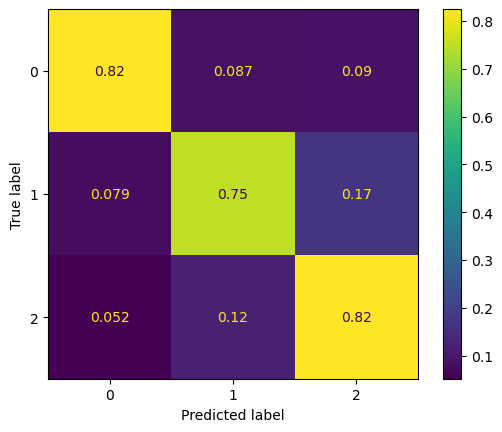

In [27]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_over,y_train_over)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)
            
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

# X_test=pd.DataFrame()
# X_train=pd.DataFrame()
# y_test=pd.DataFrame()
# y_train=pd.DataFrame()
# empty=pd.DataFrame()

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]

from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]
CMResult=[[[0 for k in range(3)]for j in range(3)] for i in range(10)]
skf.get_n_splits(X_train_over,y_train_over)

i=0
for tfold, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    #모델 정의, 예측

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

    #DNN
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.to_numpy())
    y_test = torch.LongTensor(y_test.to_numpy())

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset=TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=10000,shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=5000,shuffle=False)

    # 최대 Epoch을 지정합니다.
    num_epochs = 500
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel.pth'))

    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    print("{}번째 교차검증".format(tfold))
    final_loss, final_acc, y_predicted = model_test(model, test_dataloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')   

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

#     ## 원핫 인코딩
#     y_train=pd.get_dummies(y_train)
#     y_test=pd.get_dummies(y_test)


    # LogisticRegression
    lr = LogisticRegression(solver='liblinear', random_state=0)
    lr.fit(X_train, y_train)
    linear_pred = lr.predict(X_test)
    # linear_pred = lr.predict(X_train)
    
    # RidgeClassifier
    clf = RidgeClassifier(alpha=1.0)
    clf.fit(X_train, y_train)
    ridge_pred = clf.predict(X_test)
    # ridge_pred = clf.predict(X_train)
    
    # RandomForestClassifier
    regr = RandomForestClassifier(max_depth=6, random_state=0)
    regr.fit(X_train, y_train)
    regr_pred = regr.predict(X_test)
    # regr_pred = regr.predict(X_train)
    
    # GradientBoostingClassifier
    reg = GradientBoostingClassifier(random_state=0)
    reg.fit(X_train, y_train)
    reg_pred = reg.predict(X_test)
    # reg_pred = reg.predict(X_train)
    
    # DNN 결과값 넘파이 배열로 변환
    y_predicted_t=sum(y_predicted, [])
    DNN_y_predicted=np.array(y_predicted_t)

    # 최종모델
#     lgbm = LGBMClassifier()
    CatBoost = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
    new_data = np.array([linear_pred.squeeze(),ridge_pred.squeeze(),regr_pred.squeeze(),reg_pred.squeeze(),DNN_y_predicted.squeeze()])
    # new_data = np.array([linear_pred,ridge_pred,regr_pred,reg_pred,DNN_y_predicted])
    print(new_data.shape)

    new_data = np.transpose(new_data)
    print(new_data.shape)

    #y_test를 파이토치에서 넘파이 배열로 변환
    y_test=np.array(y_test)
    
    #lgbm 학습하기
    CatBoost.fit(new_data,y_test)
    # lgbm.fit(new_data, y_train)
    
    #LGBMClassifier 예측하기
    CatBoost_pred = CatBoost.predict(new_data)
    # lgbm_pred = lgbm.predict(X_test)

    print('Stacking ensemble (ML+DNN):',len(CatBoost_pred))
    
    
    accuracy=accuracy_score(y_test, CatBoost_pred) * 100
    print("[{}]Accuracy : {}".format(tfold,accuracy))   
    #f1score
    f1 = f1_score(y_test,CatBoost_pred, average='weighted')
    print("[{}]F1score : {}".format(tfold,f1))
    #precision/recall
    p_rlist=sk(y_test,CatBoost_pred,average='weighted')
    print("[{}]Precision : {}".format(tfold,p_rlist[0]))
    print("[{}]Recall : {}".format(tfold,p_rlist[1]))
    print()
     #결과 배열에 넣기
    Result[tfold][0]=accuracy
    Result[tfold][1]=f1
    Result[tfold][2]=p_rlist[0]
    Result[tfold][3]=p_rlist[1]
    del accuracy
    del f1
    del p_rlist
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    confusion_matrix(y_test, CatBoost_pred)

    cm = confusion_matrix(y_test, CatBoost_pred, labels=[0,1,2],normalize="true")
    CMResult[i]=cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    filename=("ConfusionMatrix_"+str(i))
    plt.savefig("./ConfusionMatrix_reward1/"+filename+".png")
    plt.show()
    
    i=i+1

In [28]:
Result_df=pd.DataFrame(Result,columns=['Accuracy','F1-Score','Precision','Recall'])
Result_df

,Accuracy,F1-Score,Precision,Recall
0,58.075397,0.581851,0.584458,0.580754
1,62.152778,0.604263,0.631743,0.621528
2,66.686508,0.664517,0.669077,0.666865
3,62.182540,0.617662,0.623740,0.621825
4,68.839286,0.685496,0.702917,0.688393
5,72.281746,0.721661,0.729769,0.722817
6,72.777778,0.726366,0.740667,0.727778
7,69.391805,0.691264,0.695932,0.693918
8,75.374541,0.753847,0.766555,0.753745
9,79.898799,0.799223,0.800901,0.798988


In [29]:
Matrix=pd.DataFrame(Result_df['Accuracy'],columns=['Accuracy'])
Matrix['Accuracy']=Result_df['Accuracy']
A=[Result_df['Accuracy'].mean(),Result_df['F1-Score'].mean(),Result_df['Precision'].mean(),Result_df['Recall'].mean()]
A=pd.DataFrame(A,columns=['Accuracy'])
Matrix=pd.concat([Matrix,A])
Matrix=Matrix.transpose()
Matrix.to_excel('./ConfusionMatrix_reward1/PFMatrix_ensemble2_final2_grid_reward1.xlsx')

In [30]:
new_data

array([[0, 2, 2, 0, 0],
       [0, 2, 2, 0, 0],
       [0, 2, 2, 0, 0],
       ...,
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2]], dtype=int64)

In [31]:
lgbm_pred

NameError: name 'lgbm_pred' is not defined

In [ ]:
y_test